<!--
If you are reading this, please recognize that this notebook is heavily catered to be PDF export friendly.
There will be large blocks of code in order to keep sections grouped together to minimize spacing, and a lot of markdown.
This will certainly not be a love letter to Jupyter Lab.
-->

In [1]:
import pandas as pd
import os
import string
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import defaultdict
from collections import Counter

import nbconvert
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px

from IPython.display import Markdown, SVG, display, Image, HTML

# Download the stopwords below through nltk once.
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

<div style="text-align: center;">

<h1>Yarn Survey 2024</h1>

<h4>Presented by</h4>

<h2>Premier Needle Arts</h2>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    The 2024 Yarn Survey was put on by Knit Picks, Berroco, and Crochet.com <br> to get more contextual knowledge of knitters, crocheters, and general yarn enthusiasts.
</div>

In [2]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')

In [3]:
# To export the notebook, uncomment the lines below.
# %%capture
# !jupyter nbconvert --to webpdf Yarn_survey.ipynb --output All_PDF_Export --output-dir ./PDF --no-input

## Demographic Summary

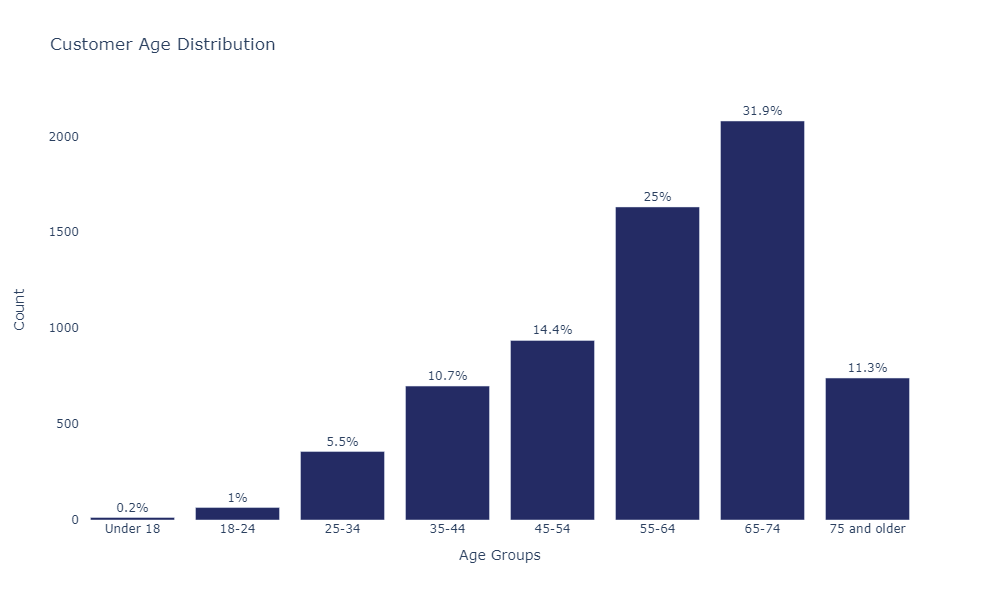

 - Out of **6521** respondents, the average respondent age is: **58** and the median age is: **59**. (From 6521 responses)

- Of these respondents, they identify as: (From 6521 responses)
    - Woman: **97.8%**
    - Non-Conforming / Non-Binary: **1.0%**
    - Man: **1.0%**
    - Transgender: **0.1%**


- The average household income ranges from **\$72,222** to **\$91,439**. (From 5024 responses)
  - For ages **Under 18**: the average is between **\$5,000** and **\$18,750**.
  - For ages **18-24**: the average is between **\$45,930** and **\$63,371**.
  - For ages **25-34**: the average is between **\$77,647** and **\$98,840**.
  - For ages **35-44**: the average is between **\$91,718** and **\$114,474**.
  - For ages **45-54**: the average is between **\$91,870** and **\$114,526**.
  - For ages **55-64**: the average is between **\$82,198** and **\$103,301**.
  - For ages **65-74**: the average is between **\$63,561** and **\$81,392**.
  - For ages **75 and older**: the average is between **\$55,842** and **\$72,483**.


In [4]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[75]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Groups',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondents, the average respondent age is: **{average_age}** and the median age is: **{median_age}**. (From {sample_size} responses)" ))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[76]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = f"- Of these respondents, they identify as: (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{value:.1f}%**\n"

display(Markdown(markdown_text))

### Income Section ###

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[all_responses.columns[75]] != 'Prefer not to answer') & 
                                        (all_responses[all_responses.columns[80]] != 'Prefer not to answer')]
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[75]], categories=categories, ordered=True)

# Define a new function to extract lower and upper bounds of the income range
def extract_income_range(value):
    if value == 'Under $20,000':
        return (0, 20000)
    elif value == 'Over $200,000':
        return (200000, 250000)
    else:
        lower, upper = value.replace('$', '').split(' - ')
        lower = int(lower.replace(',', ''))
        upper = int(upper.replace(',', ''))
        return (lower, upper)

# Assuming 'question' is the column index for income
question = all_responses.columns[80]

filtered_responses['income_range'] = filtered_responses[question].apply(lambda x: extract_income_range(x) if isinstance(x, str) else (0,0))
filtered_responses[['income_lower', 'income_upper']] = pd.DataFrame(filtered_responses['income_range'].tolist(), index=filtered_responses.index)

age_income_ranges = filtered_responses.groupby('age_range', observed=True).agg(
    average_lowerbound=pd.NamedAgg(column='income_lower', aggfunc='mean'),
    average_upperbound=pd.NamedAgg(column='income_upper', aggfunc='mean'),
    responses=pd.NamedAgg(column='income_lower', aggfunc='count')
).reset_index()

# Calculate overall average lower and upper bounds
overall_avg_lowerbound = filtered_responses['income_lower'].mean()
overall_avg_upperbound = filtered_responses['income_upper'].mean()
total_responses = filtered_responses['income_lower'].count()

# Formatting the overall averages for markdown_part1
formatted_avg_lower = "${:,.0f}".format(overall_avg_lowerbound)
formatted_avg_upper = "${:,.0f}".format(overall_avg_upperbound)

# Constructing markdown_part1 with the overall averages
markdown_part1 = f"- The average household income ranges from **\{formatted_avg_lower}** to **\{formatted_avg_upper}**. (From {total_responses} responses)"

# Initialize markdown_part2
markdown_part2 = ""
for _, row in age_income_ranges.iterrows():
    age_range = row['age_range']
    avg_lower = "${:,.0f}".format(row['average_lowerbound'])
    avg_upper = "${:,.0f}".format(row['average_upperbound'])
    responses = row['responses']
    markdown_part2 += f"  - For ages **{age_range}**: the average is between **\{avg_lower}** and **\{avg_upper}**.\n"

# Combining both parts
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

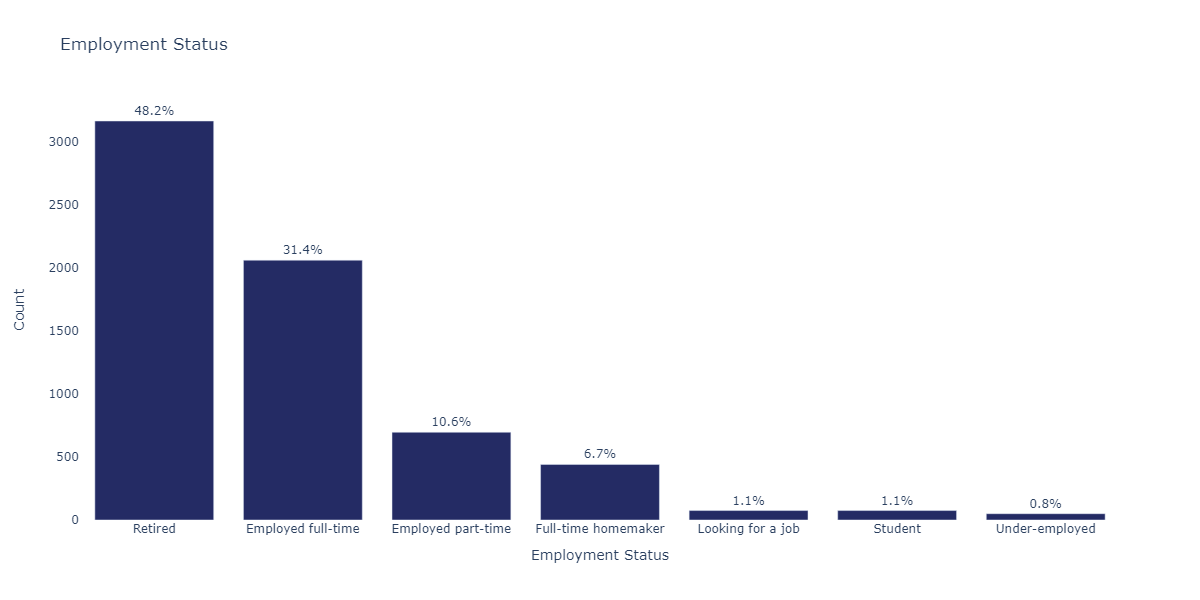

- Of the respondents, their employment statuses are as follows:  (From 6563 responses)
    - Retired: **48%**
    - Employed full-time: **31%**
    - Employed part-time: **11%**
    - Full-time homemaker: **7%**
    - Looking for a job: **1%**
    - Student: **1%**
    - Under-employed: **1%**


In [5]:
### Employment ###
question = all_responses.columns[77]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Employment Status',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1200
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, their employment statuses are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{round(value)}%**\n"

display(Markdown(markdown_text))

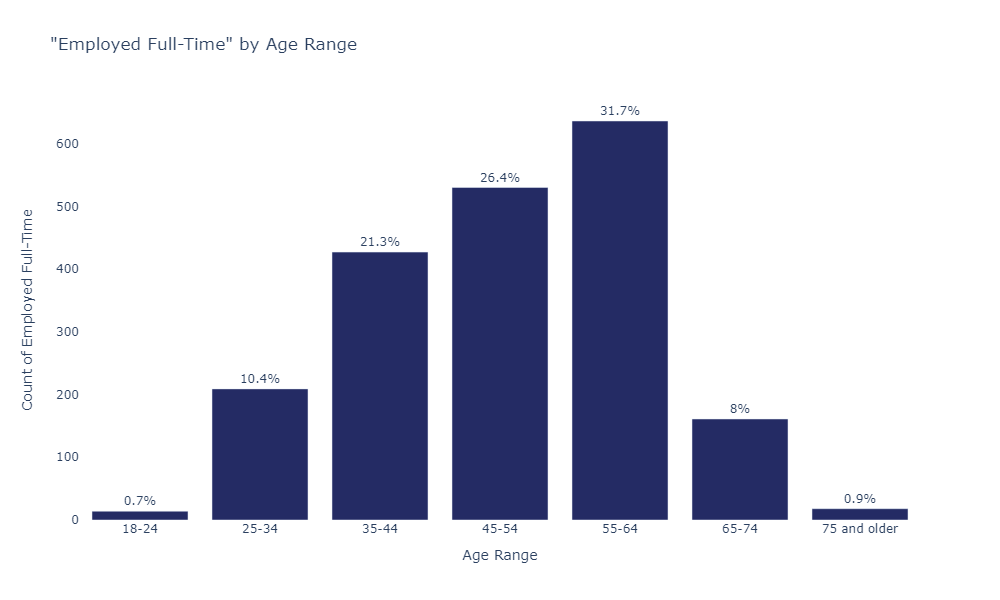

- Of those who responded 'Employed Full-Time': (From 2061 responses.)
    - For ages 55-64: **31.7%**
    - For ages 45-54: **26.4%**
    - For ages 35-44: **21.3%**
    - For ages 25-34: **10.4%**
    - For ages 65-74: **8.0%**
    - For ages 75 and older: **0.9%**
    - For ages 18-24: **0.7%**


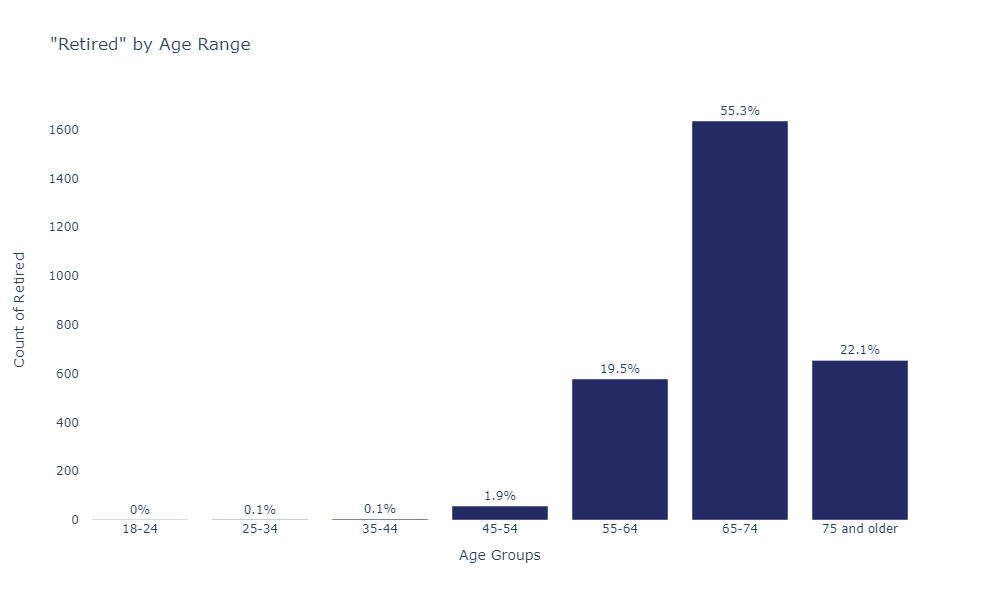

- Of those who responded 'Retired': (From 3165 responses.)
    - For ages 65-74: **55.3%**
    - For ages 75 and older: **22.1%**
    - For ages 55-64: **19.5%**
    - For ages 45-54: **1.9%**
    - For ages 25-34: **0.1%**
    - For ages 35-44: **0.1%**
    - For ages 18-24: **0.0%**


In [6]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[75]
employment_status_column = all_responses.columns[77]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']
sample_size = employed_full_time.shape[0]

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Employed Full-Time': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - For ages {age_group}: **{percentage}%**\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']
sample_size = retired.shape[0]

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Groups',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Retired': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - For ages {age_group}: **{percentage}%**\n"

display(Markdown(markdown_text))


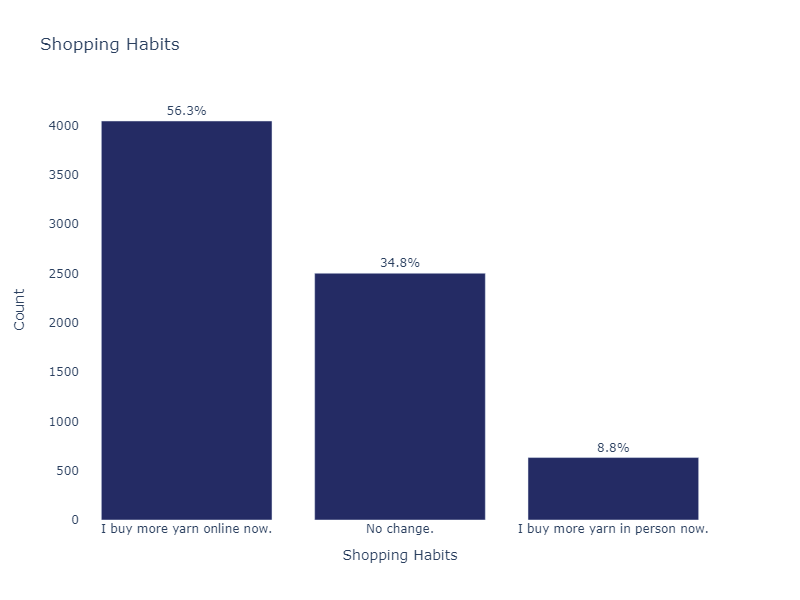

- Of the respondents, they reported that their shopping habbits have changed:  (From 7178 responses)
    - I buy more yarn online now.: **56%**
    - No change.: **35%**
    - I buy more yarn in person now.: **9%**


In [7]:
### Employment ###
question = all_responses.columns[20]

column_data = all_responses[all_responses.columns[20]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Shopping Habits',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Habits',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/shopping_habbits.png")
display(Image(filename="./IMG/shopping_habbits.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, they reported that their shopping habbits have changed:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{round(value)}%**\n"

display(Markdown(markdown_text))

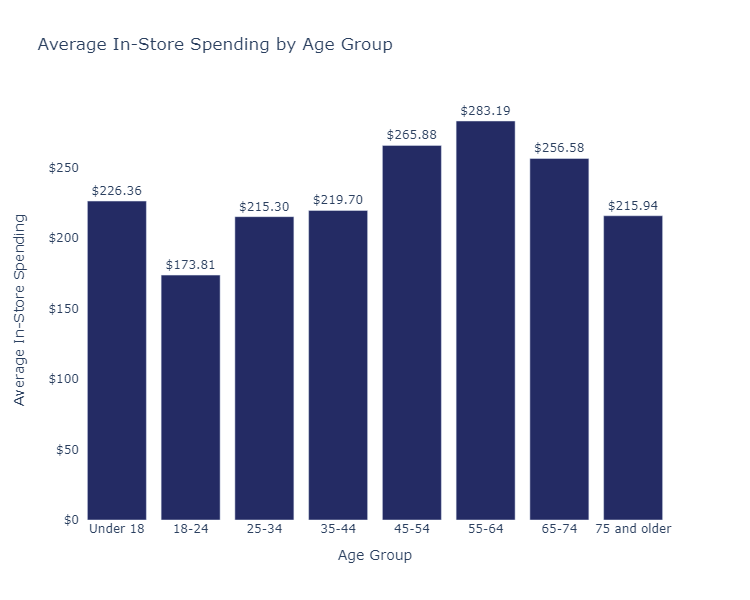

- Respondents reported making **4.7** purchases in-store per year on average, spending an average **\$53.28** per visit. On average spending **\$250.41** a year. (From 6673 responses.)
     - For ages Under 18: **6.0** purchases in-store per year, spending **\$37.73** per visit. On average spending **\$226.36** a year.
     - For ages 18-24: **4.9** purchases in-store per year, spending **\$35.46** per visit. On average spending **\$173.81** a year.
     - For ages 25-34: **4.6** purchases in-store per year, spending **\$46.88** per visit. On average spending **\$215.30** a year.
     - For ages 35-44: **4.4** purchases in-store per year, spending **\$50.26** per visit. On average spending **\$219.70** a year.
     - For ages 45-54: **5.1** purchases in-store per year, spending **\$52.54** per visit. On average spending **\$265.88** a year.
     - For ages 55-64: **5.0** purchases in-store per year, spending **\$57.01** per visit. On average spending **\$283.19** a year.
     - For ages 65-74: **4.7** purchases in-store per year, spending **\$54.74** per visit. On average spending **\$256.58** a year.
     - For ages 75 and older: **4.3** purchases in-store per year, spending **\$50.13** per visit. On average spending **\$215.94** a year.

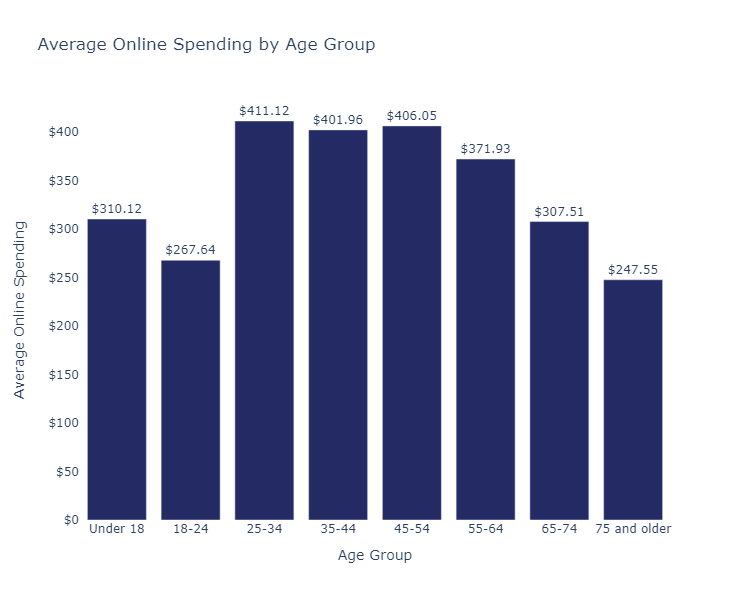

- Respondents reported making **5.0** purchases online per year on average, spending an average **\$67.33** per visit. On average spending **\$338.77** a year. (From 6799 responses.)
     - For ages Under 18: **5.4** purchases in-store per year, spending **\$57.82** per visit. On average spending **\$310.12** a year.
     - For ages 18-24: **5.0** purchases in-store per year, spending **\$53.70** per visit. On average spending **\$267.64** a year.
     - For ages 25-34: **5.4** purchases in-store per year, spending **\$76.23** per visit. On average spending **\$411.12** a year.
     - For ages 35-44: **5.4** purchases in-store per year, spending **\$74.90** per visit. On average spending **\$401.96** a year.
     - For ages 45-54: **5.5** purchases in-store per year, spending **\$73.95** per visit. On average spending **\$406.05** a year.
     - For ages 55-64: **5.3** purchases in-store per year, spending **\$70.55** per visit. On average spending **\$371.93** a year.
     - For ages 65-74: **4.8** purchases in-store per year, spending **\$63.54** per visit. On average spending **\$307.51** a year.
     - For ages 75 and older: **4.3** purchases in-store per year, spending **\$57.42** per visit. On average spending **\$247.55** a year.

In [8]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24], all_responses.columns[75]]]], axis=1)

# Clean up entries of "10+"
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))

# Clean up entries of "200+" and remove $.
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
filtered_df = share_of_wallet[share_of_wallet.iloc[:, 4] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
filtered_df[filtered_df.columns[4]] = pd.Categorical(filtered_df[filtered_df.columns[4]], categories=ages, ordered=True)

# Convert 'Age Group' column to a categorical type with specified order
filtered_df['Age Group'] = filtered_df[filtered_df.columns[4]]
filtered_df['Age Group'] = pd.Categorical(filtered_df['Age Group'], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_instore_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_instore_by_group = total_instore_by_group.reset_index().rename(columns={0: 'Total In-Store'})

# Create the bar graph
fig = px.bar(total_instore_by_group, x='Age Group', y='Total In-Store', title='Average In-Store Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_instore_by_group['Total In-Store']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average In-Store Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/instore_spend_by_age.png")
display(Image(filename="./IMG/instore_spend_by_age.png"))

# Markdown variables
sample_size_instore = share_of_wallet.iloc[:, 0].dropna().count()
avg_purchases_instore = share_of_wallet.iloc[:, 0].astype(float).mean()
avg_spending_instore = share_of_wallet.iloc[:, 1].astype(float).mean()
total_instore = avg_purchases_instore * avg_spending_instore

markdown_part1 = f"- Respondents reported making **{avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${avg_spending_instore:.2f}** per visit. On average spending **\${total_instore:.2f}** a year. (From {sample_size_instore} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_instore = frame.iloc[:, 0].dropna().count()
    group_avg_purchases_instore = frame.iloc[:, 0].astype(float).mean()
    group_avg_spending_instore = frame.iloc[:, 1].astype(float).mean()
    group_total_instore = group_avg_purchases_instore * group_avg_spending_instore
    # Append the group metrics to the markdown text
    markdown_part1 += f"\n     - For ages {group}: **{group_avg_purchases_instore:.1f}** purchases in-store per year, spending **\${group_avg_spending_instore:.2f}** per visit. On average spending **\${group_total_instore:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part1))

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[2]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[3]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_online_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_online_by_group = total_online_by_group.reset_index().rename(columns={0: 'Total Online'})

# Create the bar graph
fig = px.bar(total_online_by_group, x='Age Group', y='Total Online', title='Average Online Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_online_by_group['Total Online']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Online Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/online_spend_by_age.png")
display(Image(filename="./IMG/online_spend_by_age.png"))

# Markdown variables
sample_size_online = share_of_wallet.iloc[:, 2].dropna().count()
avg_purchases_online = share_of_wallet.iloc[:, 2].astype(float).mean()
avg_spending_online = share_of_wallet.iloc[:, 3].astype(float).mean()
total_online = avg_purchases_online * avg_spending_online

markdown_part2 = f"- Respondents reported making **{avg_purchases_online:.1f}** purchases online per year on average, spending an average **\${avg_spending_online:.2f}** per visit. On average spending **\${total_online:.2f}** a year. (From {sample_size_online} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_online = frame.iloc[:, 2].dropna().count()
    group_avg_purchases_online = frame.iloc[:, 2].astype(float).mean()
    group_avg_spending_online = frame.iloc[:, 3].astype(float).mean()
    group_total_online = group_avg_purchases_online * group_avg_spending_online
    # Append the group metrics to the markdown text
    markdown_part2 += f"\n     - For ages {group}: **{group_avg_purchases_online:.1f}** purchases in-store per year, spending **\${group_avg_spending_online:.2f}** per visit. On average spending **\${group_total_online:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part2))

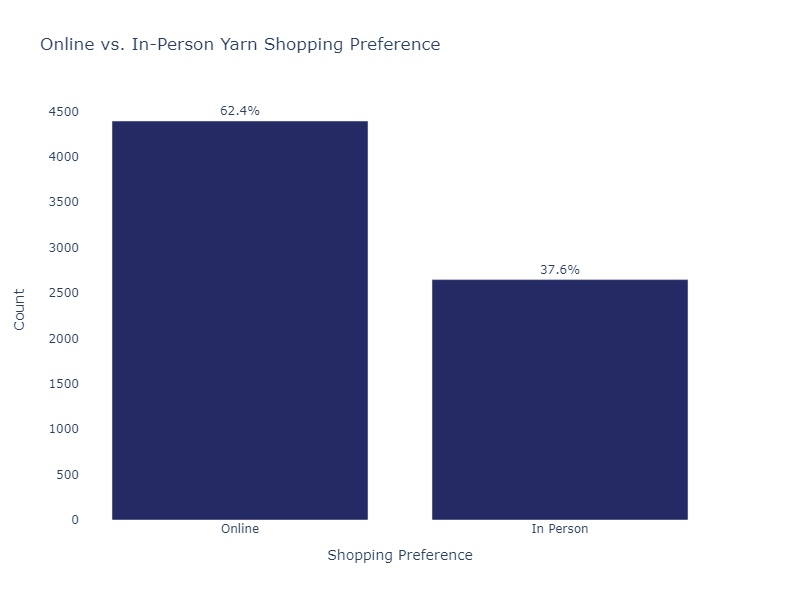

- Of the respondents **58.2%** preferred online shopping for yarn, while **35.04%** preferred shopping in person for yarn. (From 7043 responses.)
     - For ages Under 18: **30.8%** preferred shopping online, **69.2%** preferred shopping in person.
     - For ages 18-24: **67.7%** preferred shopping online, **32.3%** preferred shopping in person.
     - For ages 25-34: **72.5%** preferred shopping online, **26.1%** preferred shopping in person.
     - For ages 35-44: **71.5%** preferred shopping online, **27.2%** preferred shopping in person.
     - For ages 45-54: **65.5%** preferred shopping online, **31.3%** preferred shopping in person.
     - For ages 55-64: **60.1%** preferred shopping online, **37.4%** preferred shopping in person.
     - For ages 65-74: **57.9%** preferred shopping online, **39.8%** preferred shopping in person.
     - For ages 75 and older: **53.1%** preferred shopping online, **43.8%** preferred shopping in person.

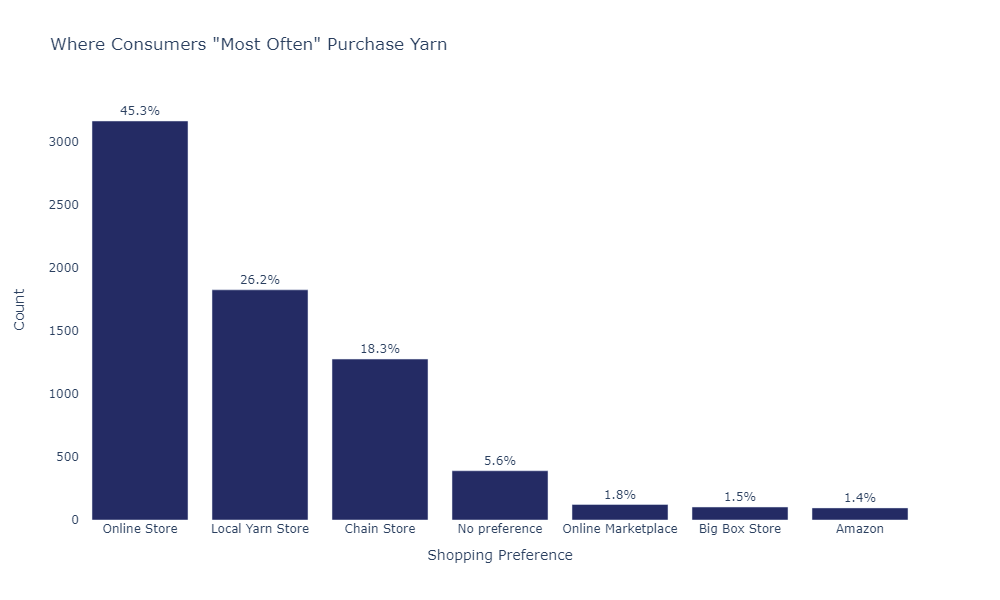

In [9]:
question = all_responses.columns[14]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Yarn Shopping Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_shopping.png")
display(Image(filename="./IMG/yarn_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[14], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for yarn, while **{inperson_percent:.2f}%** preferred shopping in person for yarn. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[15]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/yarn_shopping_location.png")
display(Image(filename="./IMG/yarn_shopping_location.png"))

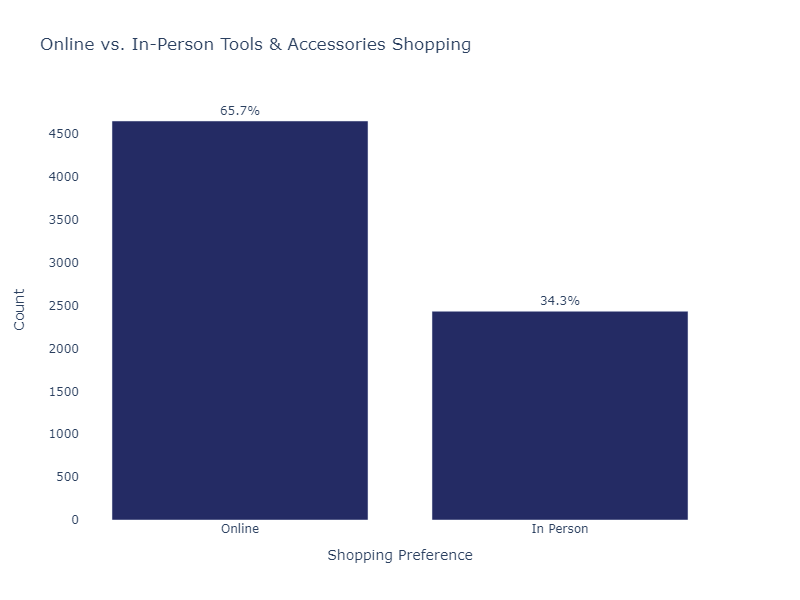

- Of the respondents **61.6%** preferred online shopping for tools & accessories, while **32.22%** preferred shopping in person for tools & accessories. (From 7090 responses.)
     - For ages Under 18: **53.8%** preferred shopping online, **46.2%** preferred shopping in person.
     - For ages 18-24: **69.2%** preferred shopping online, **30.8%** preferred shopping in person.
     - For ages 25-34: **73.1%** preferred shopping online, **25.8%** preferred shopping in person.
     - For ages 35-44: **77.8%** preferred shopping online, **21.1%** preferred shopping in person.
     - For ages 45-54: **71.2%** preferred shopping online, **26.7%** preferred shopping in person.
     - For ages 55-64: **64.1%** preferred shopping online, **34.2%** preferred shopping in person.
     - For ages 65-74: **61.2%** preferred shopping online, **37.1%** preferred shopping in person.
     - For ages 75 and older: **54.3%** preferred shopping online, **43.2%** preferred shopping in person.

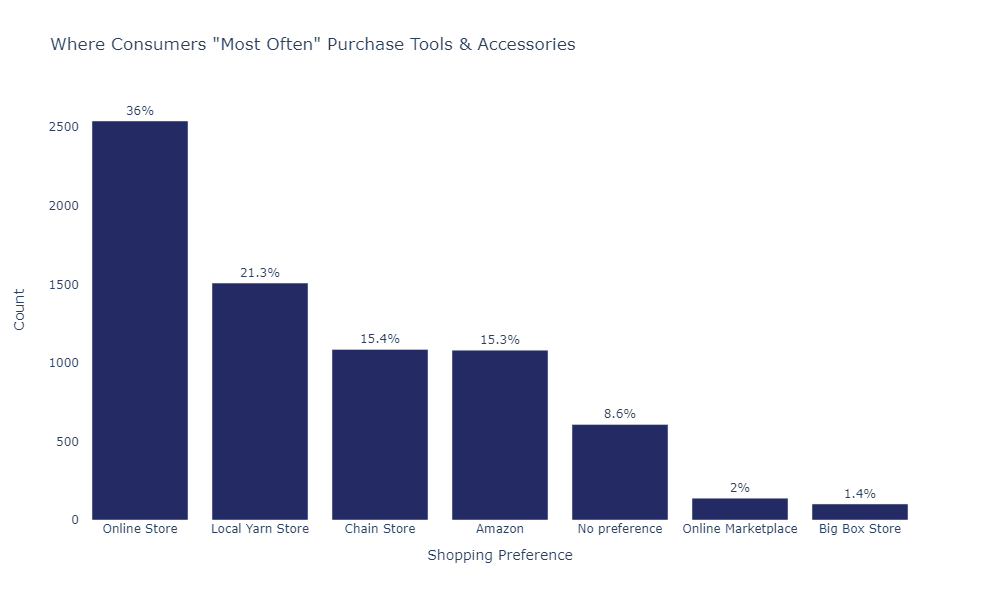

In [10]:
question = all_responses.columns[16]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Tools & Accessories Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping.png")
display(Image(filename="./IMG/tool_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[16], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for tools & accessories, while **{inperson_percent:.2f}%** preferred shopping in person for tools & accessories. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[17]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Tools & Accessories',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/tool_shopping_location.png")
display(Image(filename="./IMG/tool_shopping_location.png"))

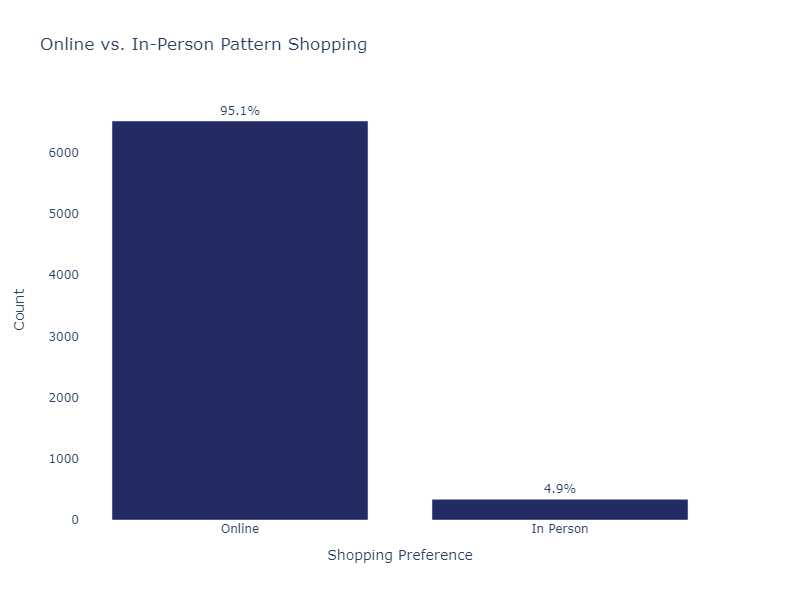

- Of the respondents **86.2%** preferred online shopping for patterns, while **4.47%** preferred shopping in person for patterns. (From 6856 responses.)
     - For ages Under 18: **69.2%** preferred shopping online, **7.7%** preferred shopping in person.
     - For ages 18-24: **95.4%** preferred shopping online, **0.0%** preferred shopping in person.
     - For ages 25-34: **95.0%** preferred shopping online, **1.1%** preferred shopping in person.
     - For ages 35-44: **95.8%** preferred shopping online, **2.1%** preferred shopping in person.
     - For ages 45-54: **94.9%** preferred shopping online, **1.7%** preferred shopping in person.
     - For ages 55-64: **92.4%** preferred shopping online, **2.9%** preferred shopping in person.
     - For ages 65-74: **88.5%** preferred shopping online, **5.9%** preferred shopping in person.
     - For ages 75 and older: **82.7%** preferred shopping online, **10.4%** preferred shopping in person.

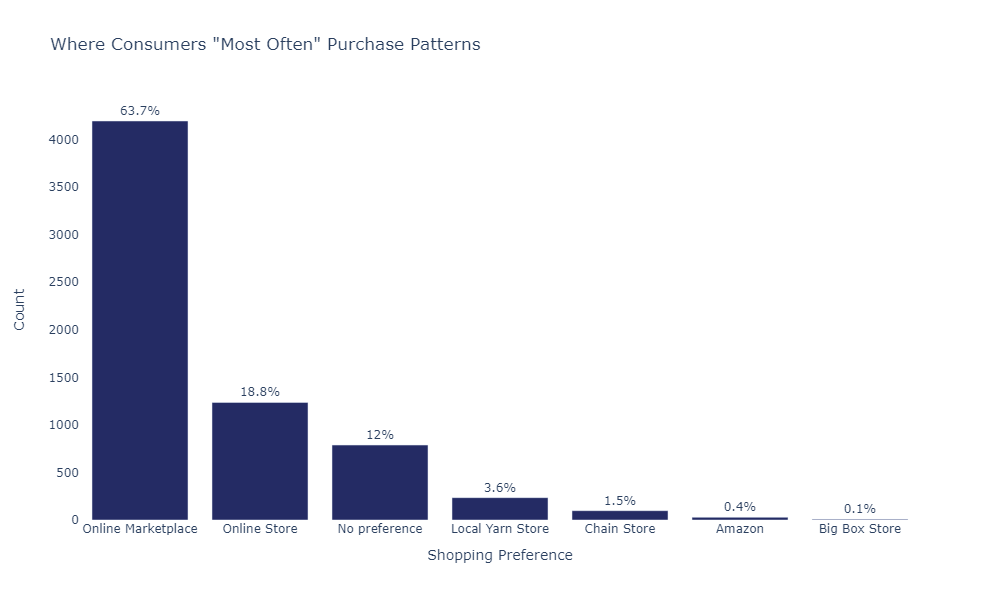

In [11]:
question = all_responses.columns[18]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Pattern Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/pattern_shopping.png")
display(Image(filename="./IMG/pattern_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[18], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for patterns, while **{inperson_percent:.2f}%** preferred shopping in person for patterns. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[19]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Patterns',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping_location.png")
display(Image(filename="./IMG/pattern_shopping_location.png"))

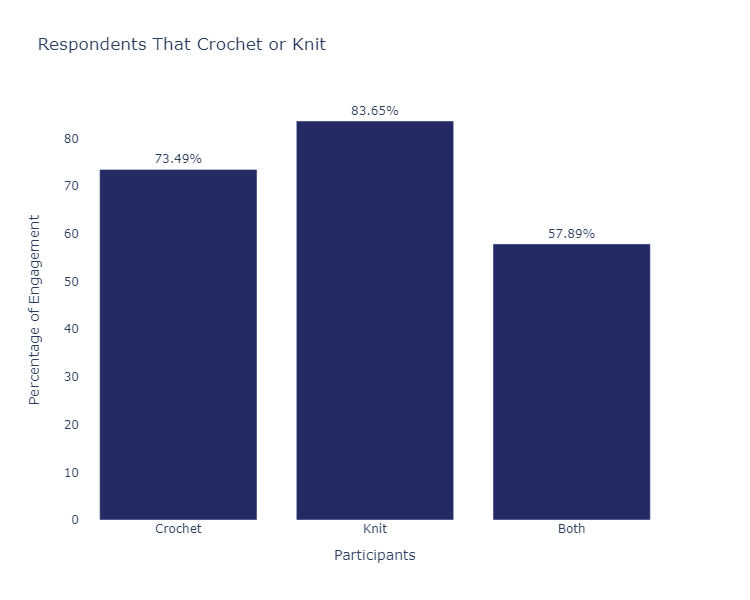

- Of the respondents, **73.5%** responded 'Yes' to crocheting, **83.65%** responded 'Yes' to knitting, while **57.89%** of respondents engage in both. (From 7558 responses.)
     - For ages Under 18, **100.0%** crochet, **61.5%** knit, and **61.5%** do both.
     - For ages 18-24, **90.8%** crochet, **67.7%** knit, and **58.5%** do both.
     - For ages 25-34, **82.6%** crochet, **73.4%** knit, and **56.3%** do both.
     - For ages 35-44, **79.1%** crochet, **78.9%** knit, and **58.0%** do both.
     - For ages 45-54, **78.5%** crochet, **78.6%** knit, and **57.2%** do both.
     - For ages 55-64, **77.5%** crochet, **81.6%** knit, and **59.0%** do both.
     - For ages 65-74, **69.7%** crochet, **89.9%** knit, and **59.7%** do both.
     - For ages 75 and older, **62.3%** crochet, **94.2%** knit, and **56.6%** do both.

In [12]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[4], all_responses.columns[7], all_responses.columns[75]]]], axis=1)

percent_yes = column_data[['Do you crochet?', 'Do you knit?']].apply(lambda x: (x == 'Yes').mean()) * 100
both_yes_percent = column_data[(column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')].shape[0] / column_data.shape[0] * 100
 
data = {'Crafting Type': ['Crochet', 'Knit'], 'Percentage': percent_yes.values}

# Update the data dictionary to include the new category
data['Crafting Type'].append('Both')
data['Percentage'] = np.append(data['Percentage'], both_yes_percent)

df = pd.DataFrame(data)

fig = px.bar(
    df,
    x='Crafting Type',
    y='Percentage',
    text='Percentage',
    title='Respondents That Crochet or Knit',
    color_discrete_sequence=['#242B64']
)

# Adding text on bars for the percentage value
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Participants',
    yaxis_title='Percentage of Engagement',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750
)

# Save and display the figure
fig.write_image("./IMG/crafting_participation.png")
display(Image(filename="./IMG/crafting_participation.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Variables
# Overall percentage of respondents who answered 'Yes' to crocheting
crochet_yes_percent = (column_data['Do you crochet?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to knitting
knit_yes_percent = (column_data['Do you knit?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to both crocheting and knitting
both_yes_percent = ((column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')).mean() * 100
# Total sample size
sample_size = column_data.shape[0]

# Initialize the markdown string
markdown_summary = f"- Of the respondents, **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.2f}%** responded 'Yes' to knitting, while **{both_yes_percent:.2f}%** of respondents engage in both. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data['What is your current age?  '] == age]
    
    # Calculate the percentages and sample size for the current age group
    crochet_yes_percent = (age_group_df['Do you crochet?'] == 'Yes').mean() * 100
    knit_yes_percent = (age_group_df['Do you knit?'] == 'Yes').mean() * 100
    both_yes_percent = ((age_group_df['Do you crochet?'] == 'Yes') & (age_group_df['Do you knit?'] == 'Yes')).mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}, **{crochet_yes_percent:.1f}%** crochet, **{knit_yes_percent:.1f}%** knit, and **{both_yes_percent:.1f}%** do both."

# Display the markdown summary
# Display the markdown text
display(Markdown(markdown_summary))

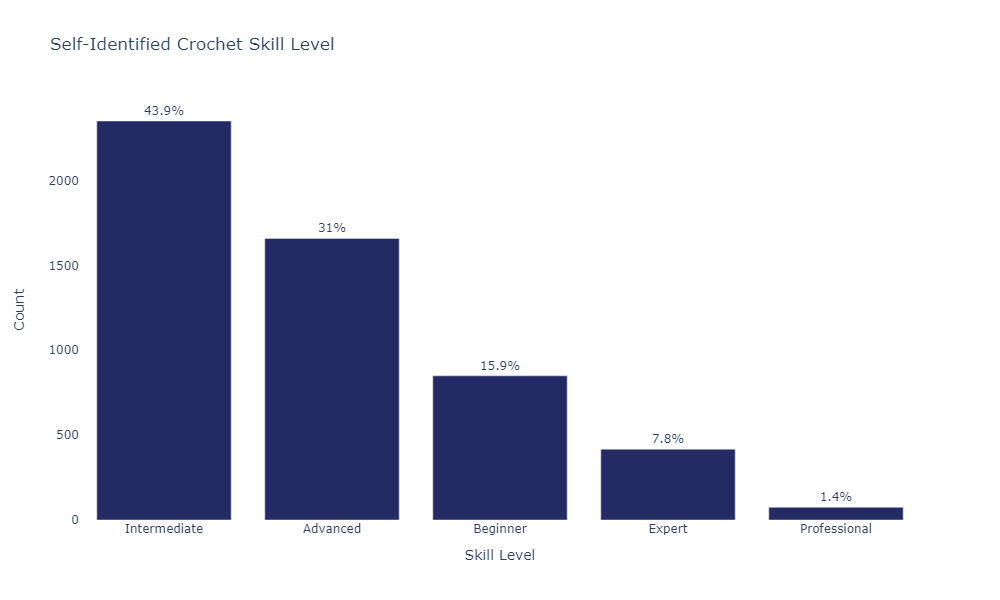

- Of the respondents who crochet, they rate their skill level as the following: (From 5554 responses.)
    - Intermediate: **43.93%**.
    - Advanced: **31.00%**.
    - Beginner: **15.87%**.
    - Expert: **7.80%**.
    - Professional: **1.40%**.


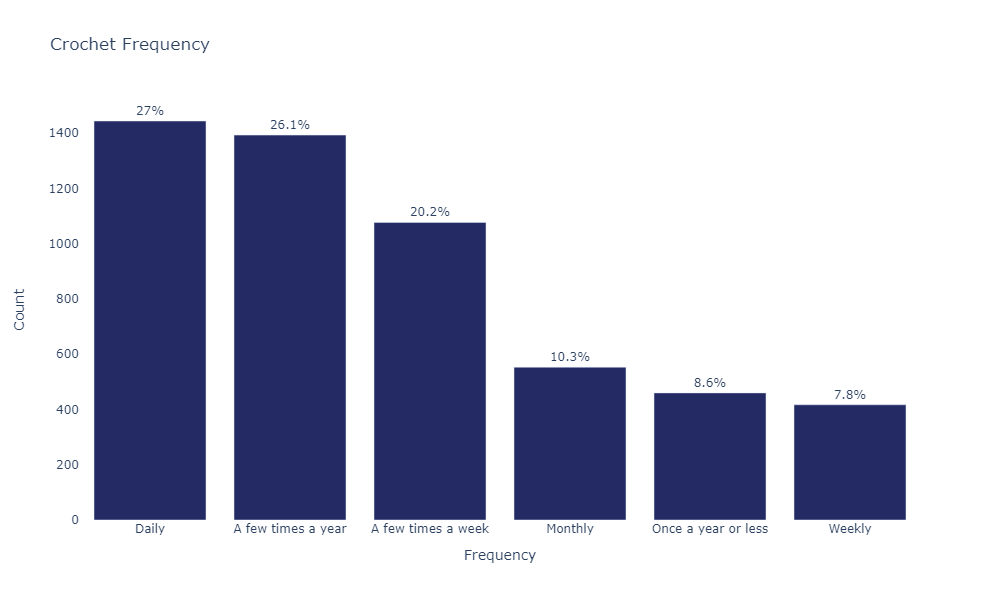

- Of the respondents who crochet, the frequency they do so is: (From 5554 responses.)
    -  Daily: **27.02%**
    -  A few times a year: **26.07%**
    -  A few times a week: **20.15%**
    -  Monthly: **10.35%**
    -  Once a year or less: **8.61%**
    -  Weekly: **7.80%**


In [13]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who crochet, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Crochet Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)
)

# Show the figure
fig.write_image("./IMG/crochet_frequency.png")
display(Image(filename="./IMG/crochet_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who crochet, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    -  {answer}: **{percentage:.2f}%**\n"
    
display(Markdown(markdown_summary))

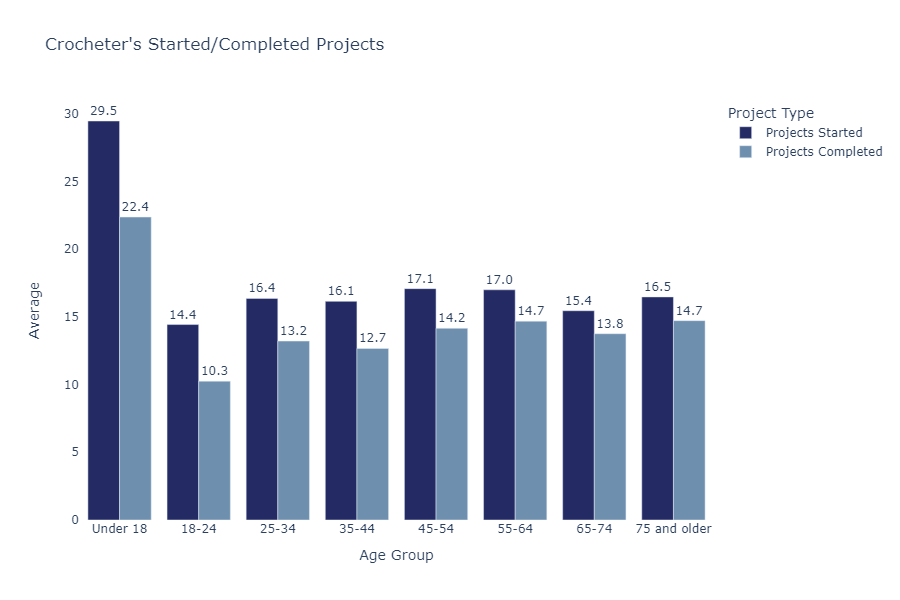

- Of the respondents, on average they start **16.4** crochet projects a year, and on average they complete **14.0** crochet projects a year. (From 5554 responses.)
     - For ages Under 18: They start **29.5** projects, and complete **22.4** projects a year.
     - For ages 18-24: They start **14.4** projects, and complete **10.2** projects a year.
     - For ages 25-34: They start **16.4** projects, and complete **13.2** projects a year.
     - For ages 35-44: They start **16.1** projects, and complete **12.7** projects a year.
     - For ages 45-54: They start **17.1** projects, and complete **14.2** projects a year.
     - For ages 55-64: They start **17.0** projects, and complete **14.7** projects a year.
     - For ages 65-74: They start **15.4** projects, and complete **13.8** projects a year.
     - For ages 75 and older: They start **16.5** projects, and complete **14.7** projects a year.

In [14]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Crocheter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/crochet_projects.png")
display(Image(filename="./IMG/crochet_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondents, on average they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: They start **{projects_started:.1f}** projects, and complete **{projects_completed:.1f}** projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

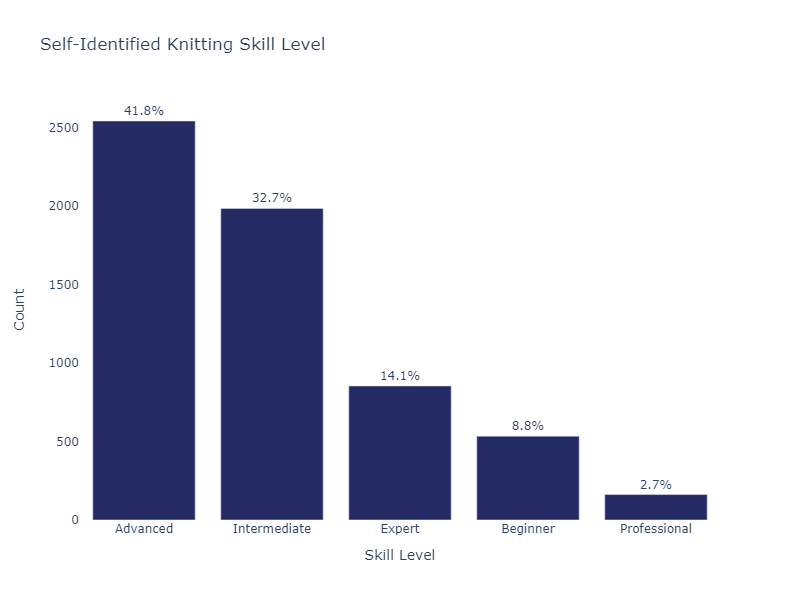

- Of the respondents who knit, they rate their skill level as the following: (From 6322 responses.)
    - Advanced: **41.83%**.
    - Intermediate: **32.66%**.
    - Expert: **14.05%**.
    - Beginner: **8.79%**.
    - Professional: **2.67%**.


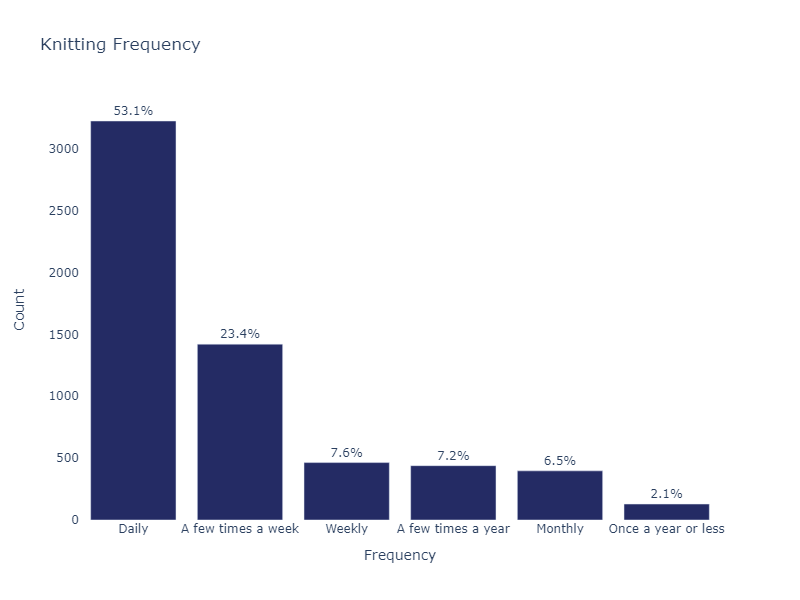

- Of the respondents who knit, the frequency they do so is: (From 6322 responses.)
    - Daily: **53.08%**.
    - A few times a week: **23.39%**.
    - Weekly: **7.64%**.
    - A few times a year: **7.23%**.
    - Monthly: **6.54%**.
    - Once a year or less: **2.12%**.


In [15]:
# Knitting Skill Level

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[8], all_responses.columns[9], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Knitting Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_skill.png")
display(Image(filename="./IMG/knitting_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who knit, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Knitting Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_frequency.png")
display(Image(filename="./IMG/knitting_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who knit, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

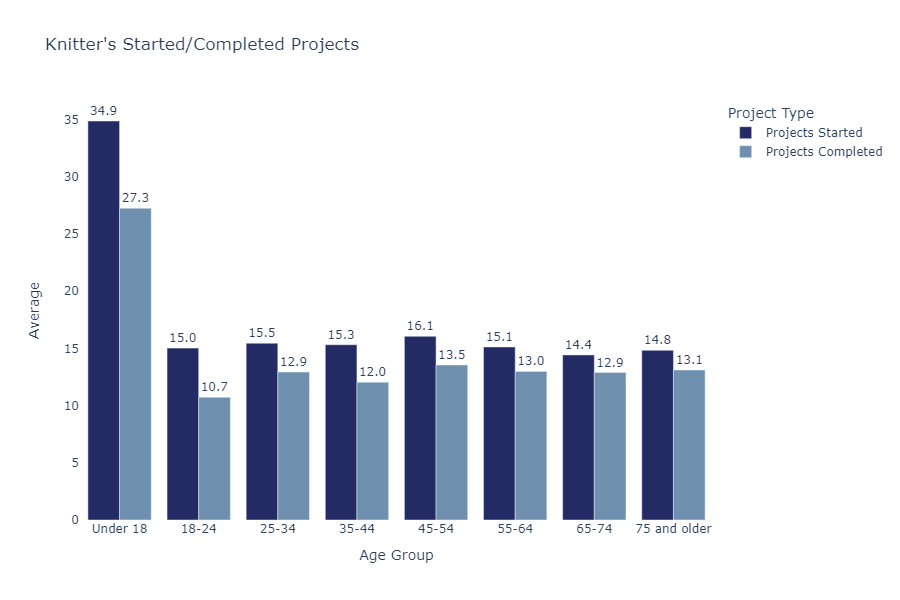

- Of the respondents, on average they start **15.0** knitting projects a year, and on average they complete **12.9** knitting projects a year. (From 6322 responses.)
     - For ages Under 18: They start **34.9** projects, and complete **27.2** projects a year.
     - For ages 18-24: They start **15.0** projects, and complete **10.7** projects a year.
     - For ages 25-34: They start **15.5** projects, and complete **12.9** projects a year.
     - For ages 35-44: They start **15.3** projects, and complete **12.0** projects a year.
     - For ages 45-54: They start **16.1** projects, and complete **13.5** projects a year.
     - For ages 55-64: They start **15.1** projects, and complete **13.0** projects a year.
     - For ages 65-74: They start **14.4** projects, and complete **12.9** projects a year.
     - For ages 75 and older: They start **14.8** projects, and complete **13.1** projects a year.

In [16]:
# Knitting Projects 

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Knitter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/knitting_projects.png")
display(Image(filename="./IMG/knitting_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondents, on average they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: They start **{projects_started:.1f}** projects, and complete **{projects_completed:.1f}** projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

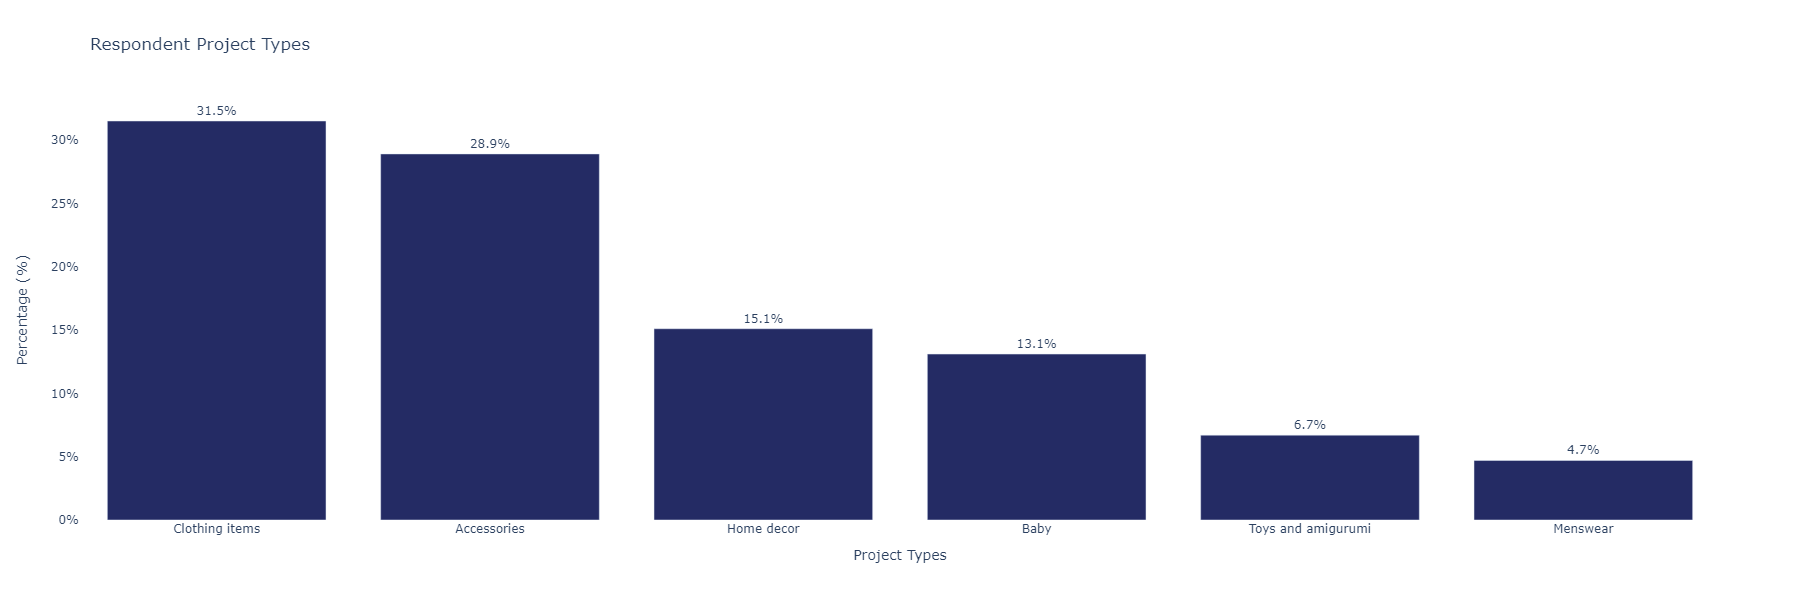

- Of the respondents, the most popular project type for all yarn crafts is: (From 6322 responses.)
     - For ages Under 18: The most popular types are **Clothing items** **(44.0%)**, then **Accessories** **(28.0%)**, followed by **Toys and amigurumi** **(16.0%)**.
     - For ages 18-24: The most popular types are **Clothing items** **(37.4%)**, then **Accessories** **(20.9%)**, followed by **Toys and amigurumi** **(15.1%)**.
     - For ages 25-34: The most popular types are **Clothing items** **(32.9%)**, then **Accessories** **(25.7%)**, followed by **Home decor** **(16.1%)**.
     - For ages 35-44: The most popular types are **Clothing items** **(30.4%)**, then **Accessories** **(27.9%)**, followed by **Home decor** **(16.5%)**.
     - For ages 45-54: The most popular types are **Clothing items** **(31.3%)**, then **Accessories** **(28.4%)**, followed by **Home decor** **(16.9%)**.
     - For ages 55-64: The most popular types are **Clothing items** **(30.7%)**, then **Accessories** **(29.1%)**, followed by **Home decor** **(16.4%)**.
     - For ages 65-74: The most popular types are **Clothing items** **(32.0%)**, then **Accessories** **(29.5%)**, followed by **Baby** **(15.1%)**.
     - For ages 75 and older: The most popular types are **Clothing items** **(31.5%)**, then **Accessories** **(30.0%)**, followed by **Baby** **(17.0%)**.

In [17]:
# Project Types

# Combining relevant columns into one DataFrame and dropping NaN values
column_data = pd.concat([all_responses[[all_responses.columns[41], all_responses.columns[75]]]], axis=1).dropna()

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Split project types more robustly, considering possible variations in the use of spaces around commas
split_projects = column_data[column_data.columns[0]].str.split(r'\s*,\s*')

# Explode the DataFrame to separate rows for each project type mentioned per response
exploded_projects = split_projects.explode().reset_index(drop=True)

# Filter out empty or whitespace-only project types
exploded_projects = exploded_projects[exploded_projects.str.strip().astype(bool)]

# Count occurrences of each project type
project_counts = exploded_projects.value_counts().reset_index(name='Count')
project_counts.columns = ['Project', 'Count']

# Calculate the percentage of each project's occurrence
total_mentions = project_counts['Count'].sum()
project_counts['Percentage'] = (project_counts['Count'] / total_mentions * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per project type
fig = px.bar(project_counts, x='Project', y='Percentage',
             title='Respondent Project Types',
             labels={'Percentage': 'Percentage (%)', 'Project': 'Project Types'},
             text='Percentage', color_discrete_sequence=['#242B64'])

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    yaxis_ticksuffix="%",
)

# Show the figure
fig.write_image("./IMG/project_type_preference_revised.png")
display(Image(filename="./IMG/project_type_preference_revised.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular project type for all yarn crafts is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Correctly split the project types for the current age group, taking into account spaces around commas
        exploded_projects = age_group_df.iloc[:, 0].str.split(' , ').explode()
        # Calculate the value counts and percentages for the current age group's project types
        percentages = exploded_projects.value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Project', 'Percentage']
        # Check if there are at least two project types to report
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular project types
            markdown_summary += f"\n     - For ages {age}: The most popular types are **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: The most popular types are **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one project type, mention only the most popular one
            markdown_summary += f"\n     - For ages{age}: The most popular type is **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]}%)**."
        else:
            # If there are no project types, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no project types with significant data."

# Display the markdown text
display(Markdown(markdown_summary))

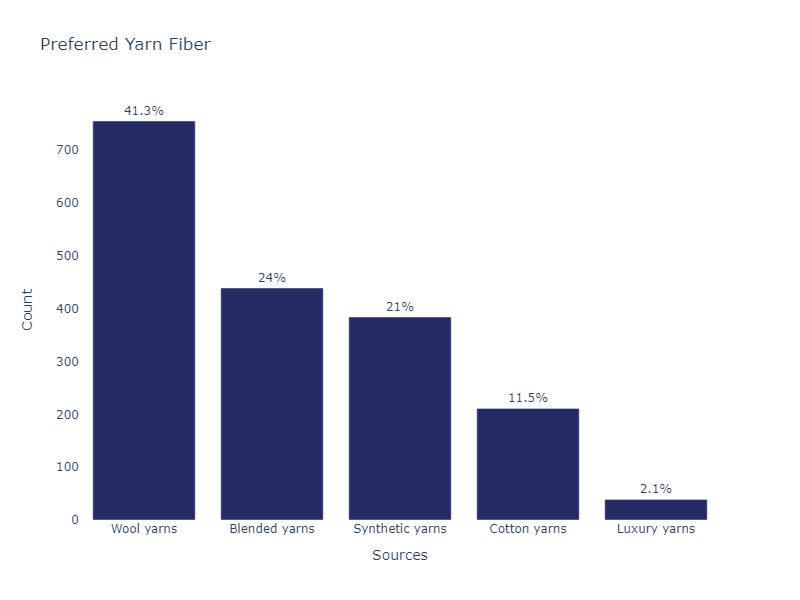

- Of the respondents, their preffered yarn fiber is: (From 1828 responses.)
     - For ages Under 18: Preferred **Wool yarns** **(50.0%)** and **Cotton yarns** **(50.0%)**.
     - For ages 18-24: Preferred **Synthetic yarns** **(50.0%)**, then **Wool yarns** **(22.2%)**, followed by **Cotton yarns** **(22.2%)**.
     - For ages 25-34: Preferred **Wool yarns** **(39.8%)**, then **Synthetic yarns** **(24.1%)**, followed by **Blended yarns** **(18.1%)**.
     - For ages 35-44: Preferred **Wool yarns** **(50.9%)**, then **Blended yarns** **(18.6%)**, followed by **Synthetic yarns** **(18.6%)**.
     - For ages 45-54: Preferred **Wool yarns** **(41.5%)**, then **Blended yarns** **(25.6%)**, followed by **Synthetic yarns** **(15.9%)**.
     - For ages 55-64: Preferred **Wool yarns** **(41.8%)**, then **Blended yarns** **(22.4%)**, followed by **Synthetic yarns** **(20.7%)**.
     - For ages 65-74: Preferred **Wool yarns** **(40.4%)**, then **Blended yarns** **(28.0%)**, followed by **Synthetic yarns** **(19.0%)**.
     - For ages 75 and older: Preferred **Wool yarns** **(40.4%)**, then **Synthetic yarns** **(26.5%)**, followed by **Blended yarns** **(25.1%)**.

In [18]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[75]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = column_data.iloc[:, 0].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Preferred Yarn Fiber',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_fibers.png")
display(Image(filename="./IMG/yarn_fibers.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, their preffered yarn fiber is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred types with significant data."



# Display the markdown text
display(Markdown(markdown_summary))

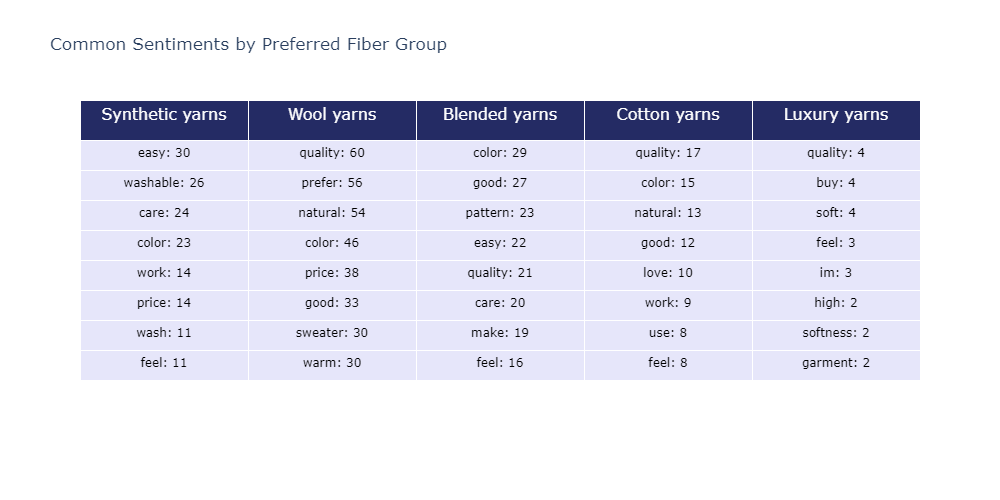

In [19]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[42]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'fiber_group', column_data.columns[1]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)
column_data.dropna(subset=[column_data.columns[1]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'yarn',
    'yarns',
    'project',
    'fibers',
    'acrylic',
    'alpaca',
    'wool',
    'cotton',
    'synthetic',
    'luxury',
    'blended',
    'knit',
    'crochet',
    'like',
    'machine'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all punctuation
    all_punct = string.punctuation + "’"  # Adding curly apostrophe
    text = text.translate(str.maketrans('', '', all_punct))
    # Tokenize
    tokens = word_tokenize(text)
    # Filter out stop words and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

# Function to analyze text data by fiber group
def analyze_by_fiber_group(data):
    # Dictionary to hold word counts for each group
    word_counts_by_group = defaultdict(Counter)
    
    for _, row in data.iterrows():
        fiber_group = row['fiber_group']
        tokens = preprocess_and_tokenize(row['responses'])
        # Update counts for this group
        word_counts_by_group[fiber_group].update(tokens)
    
    # Extracting most common words for each group
    most_common_by_group = {group: counts.most_common(8) for group, counts in word_counts_by_group.items()}
    return most_common_by_group

most_common_words = analyze_by_fiber_group(column_data)  

# Transform the 'most_common_words' dict to a format suitable for Plotly Table
max_words = max(len(words) for words in most_common_words.values())

# Re-initialize columns for the table using distinct fiber_group values
distinct_fiber_groups = column_data['fiber_group'].unique()
columns = ['Word'] + list(distinct_fiber_groups)

# Initialize the table data with empty strings for the updated columns list
table_data = [["" for _ in range(len(columns))] for _ in range(max_words)]

# Populate the first column with the word ranks
for i in range(max_words):
    table_data[i][0] = f"Word {i+1}"

# Fill in the word and count data using the updated fiber groups
for col_index, fiber_group in enumerate(distinct_fiber_groups, start=1):
    for row_index, (word, count) in enumerate(most_common_words.get(fiber_group, [])):
        # This assumes that the most_common_words dictionary keys match the distinct fiber group values exactly
        table_data[row_index][col_index] = f"{word}: {count}"

# Exclude the 'Word' column from the final presentation by adjusting the column headers and the table data
final_columns = columns[1:]  # Exclude the first column which is 'Word'
final_table_data = [row[1:] for row in table_data]  # Exclude the first element from each row

# Create the Plotly table without the 'Word' column
fig = go.Figure(data=[go.Table(
    header=dict(values=final_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*final_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply the same layout customizations as before
fig.update_layout(
    title_text='Common Sentiments by Preferred Fiber Group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000
)

fig.update_traces(
    columnwidth=[10, 10, 10, 10, 10]  # Adjust the numbers based on your preference and the number of columns
)

# Show the figure
fig.write_image("./IMG/yarn_common_words.png")
display(Image(filename="./IMG/yarn_common_words.png"))


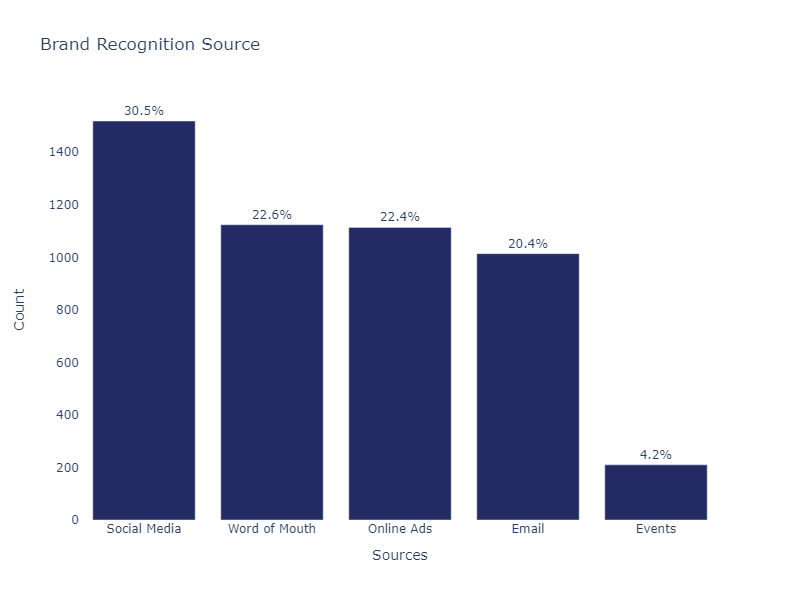

- Of the respondents, the most popular brand discovery sources are: (From 7140 responses.)
     - For ages Under 18: Preferred **Social Media** **(50.0%)**, then **Word of Mouth** **(30.0%)**, followed by **Email** **(20.0%)**.
     - For ages 18-24: Preferred **Social Media** **(31.6%)**, then **Online Ads** **(24.6%)**, followed by **Word of Mouth** **(22.8%)**.
     - For ages 25-34: Preferred **Social Media** **(42.3%)**, then **Online Ads** **(22.6%)**, followed by **Word of Mouth** **(21.9%)**.
     - For ages 35-44: Preferred **Social Media** **(39.4%)**, then **Word of Mouth** **(25.8%)**, followed by **Online Ads** **(20.3%)**.
     - For ages 45-54: Preferred **Social Media** **(39.7%)**, then **Online Ads** **(23.3%)**, followed by **Word of Mouth** **(22.9%)**.
     - For ages 55-64: Preferred **Social Media** **(34.1%)**, then **Word of Mouth** **(20.7%)**, followed by **Email** **(20.3%)**.
     - For ages 65-74: Preferred **Email** **(24.7%)**, then **Social Media** **(23.7%)**, followed by **Online Ads** **(23.6%)**.
     - For ages 75 and older: Preferred **Email** **(28.4%)**, then **Word of Mouth** **(26.1%)**, followed by **Online Ads** **(23.3%)**.

In [20]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[26], all_responses.columns[75]]]], axis=1)

categories = [
    'Social Media (Instagram, Facebook, Pinterest, etc.)', 
    'Online Ads (Search engines, Sponsored content)', 
    'Word of Mouth (Friends/Family, Colleagues)', 
    'Events (In-store, Trade shows, Workshops)', 
    'Email (Promotional, Newsletter)'
]

column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].where(column_data[all_responses.columns[26]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 26].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\s{2,}", " ", regex=True).str.strip()


# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Brand Recognition Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/brand_recognition_source.png")
display(Image(filename="./IMG/brand_recognition_source.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular brand discovery sources are: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

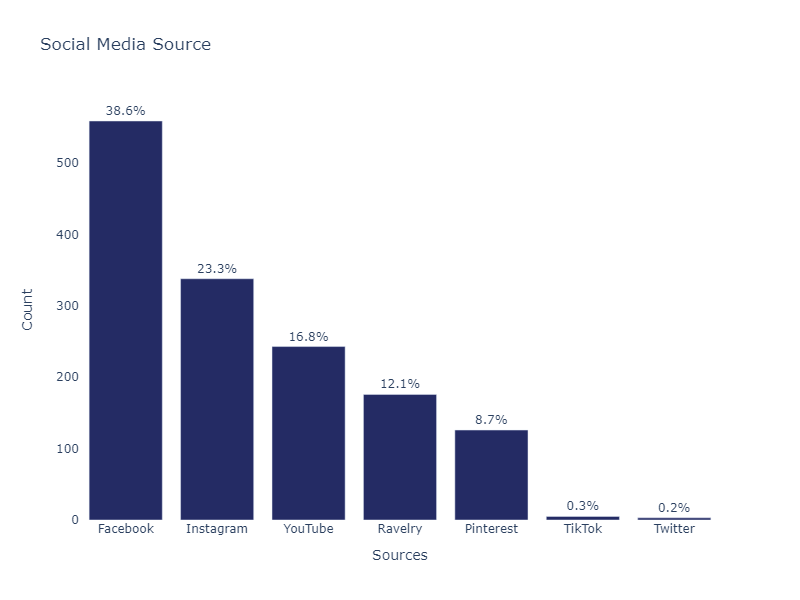

- Of the respondents that discovered a brand through social media, the most popular is: (From 1450 responses.)
     - For ages Under 18: Discovered through **YouTube** **(60.0%)**, then **Instagram** **(20.0%)**, followed by **TikTok** **(20.0%)**.
     - For ages 18-24: Discovered through **YouTube** **(50.0%)**, then **Instagram** **(43.8%)**, followed by **Pinterest** **(6.2%)**.
     - For ages 25-34: Discovered through **Instagram** **(50.8%)**, then **YouTube** **(26.2%)**, followed by **Facebook** **(10.7%)**.
     - For ages 35-44: Discovered through **Instagram** **(32.9%)**, then **Facebook** **(30.0%)**, followed by **YouTube** **(17.4%)**.
     - For ages 45-54: Discovered through **Facebook** **(37.1%)**, then **Instagram** **(24.0%)**, followed by **YouTube** **(21.7%)**.
     - For ages 55-64: Discovered through **Facebook** **(42.1%)**, then **Instagram** **(19.9%)**, followed by **YouTube** **(16.0%)**.
     - For ages 65-74: Discovered through **Facebook** **(52.5%)**, then **Pinterest** **(13.3%)**, followed by **Ravelry** **(13.3%)**.
     - For ages 75 and older: Discovered through **Facebook** **(59.7%)**, then **Ravelry** **(16.4%)**, followed by **Pinterest** **(9.0%)**.

In [21]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[27], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[all_responses.columns[27]] = column_data[all_responses.columns[27]].where(column_data[all_responses.columns[27]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media.png")
display(Image(filename="./IMG/social_media.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents that discovered a brand through social media, the most popular is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Discovered through **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Discovered through **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Discovered through **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

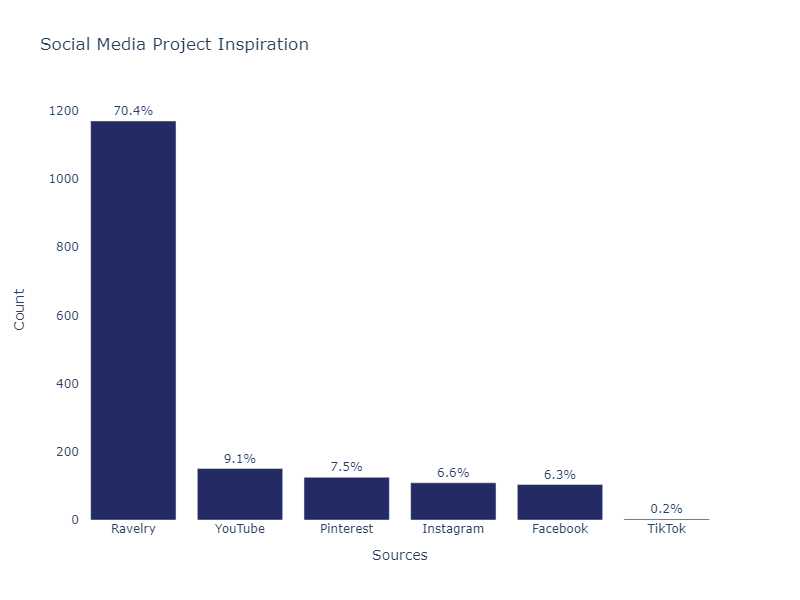

- Of the respondents, the most popular social media platform for inspiration is: (From 1662 responses.)
     - For ages Under 18: Preferred **Ravelry** **(100.0%)**.
     - For ages 18-24: Preferred **Instagram** **(40.0%)**, then **Ravelry** **(26.7%)**, followed by **Pinterest** **(20.0%)**.
     - For ages 25-34: Preferred **Ravelry** **(52.1%)**, then **Instagram** **(19.2%)**, followed by **Pinterest** **(13.7%)**.
     - For ages 35-44: Preferred **Ravelry** **(59.7%)**, then **Instagram** **(13.7%)**, followed by **Pinterest** **(10.8%)**.
     - For ages 45-54: Preferred **Ravelry** **(58.7%)**, then **Instagram** **(12.3%)**, followed by **YouTube** **(11.0%)**.
     - For ages 55-64: Preferred **Ravelry** **(65.6%)**, then **YouTube** **(11.7%)**, followed by **Pinterest** **(8.5%)**.
     - For ages 65-74: Preferred **Ravelry** **(78.7%)**, then **Facebook** **(7.0%)**, followed by **YouTube** **(6.2%)**.
     - For ages 75 and older: Preferred **Ravelry** **(80.5%)**, then **YouTube** **(6.5%)**, followed by **Pinterest** **(6.5%)**.

In [22]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[44], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Project Inspiration',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media_inspiration.png")
display(Image(filename="./IMG/social_media_inspiration.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular social media platform for inspiration is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

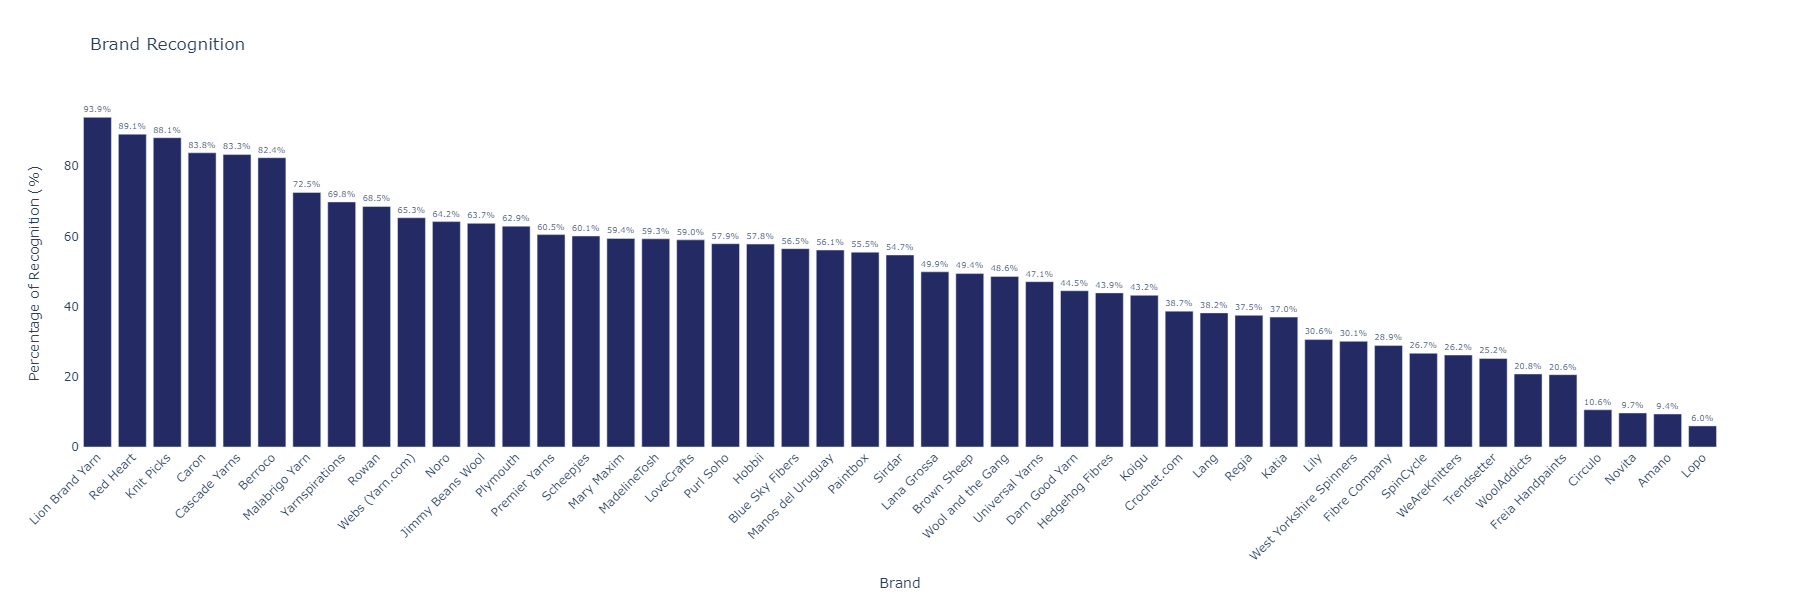

In [23]:
# Print statement question.
question = all_responses.columns[28]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 28].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 28].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Recognition',
             labels={'Percentage': 'Percentage of Recognition (%)', 'Brand': 'Brand'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_recognition.png")
display(Image(filename="./IMG/brand_recognition.png"))

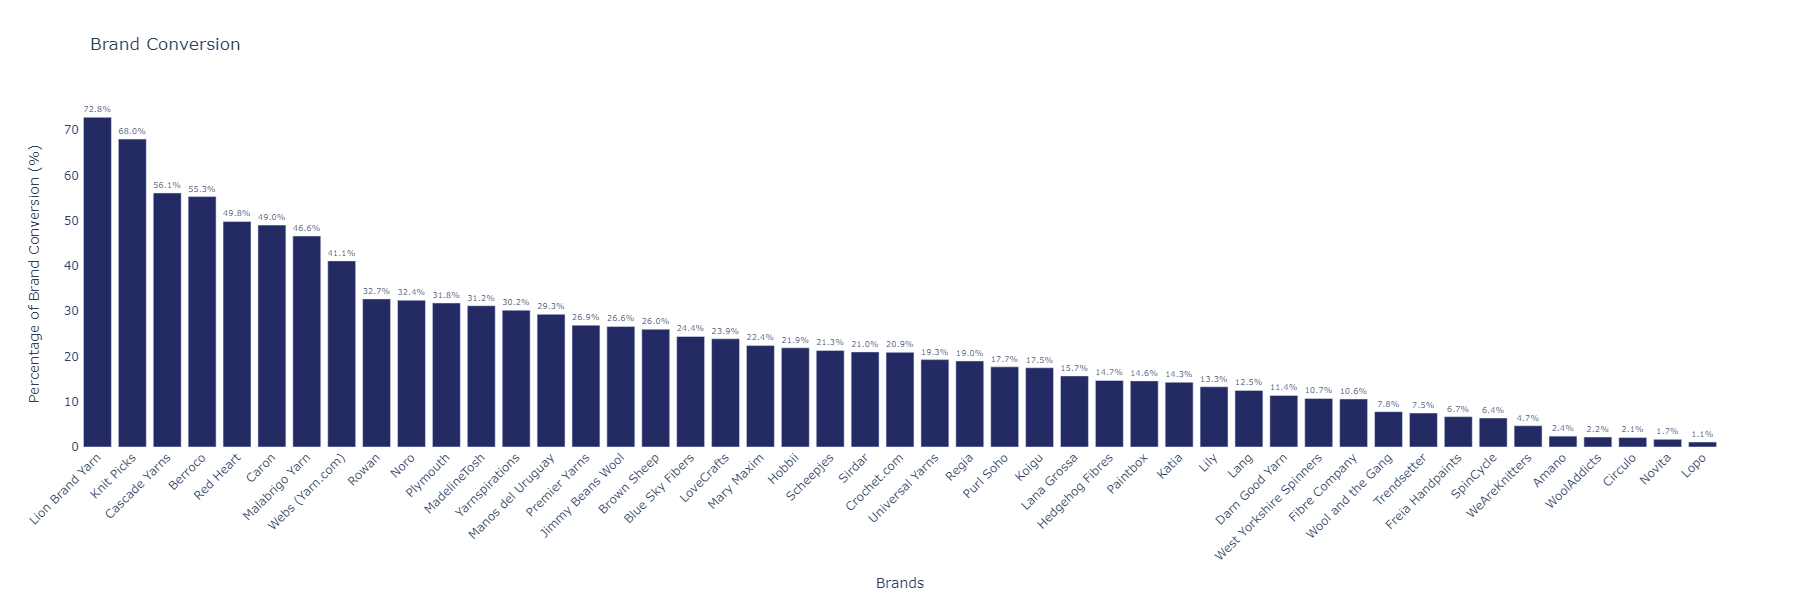

In [24]:
# Print statement question.
question = all_responses.columns[29]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 29].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 29].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Conversion',
             labels={'Percentage': 'Percentage of Brand Conversion (%)', 'Brand': 'Brands'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_conversion.png")
display(Image(filename="./IMG/brand_conversion.png"))

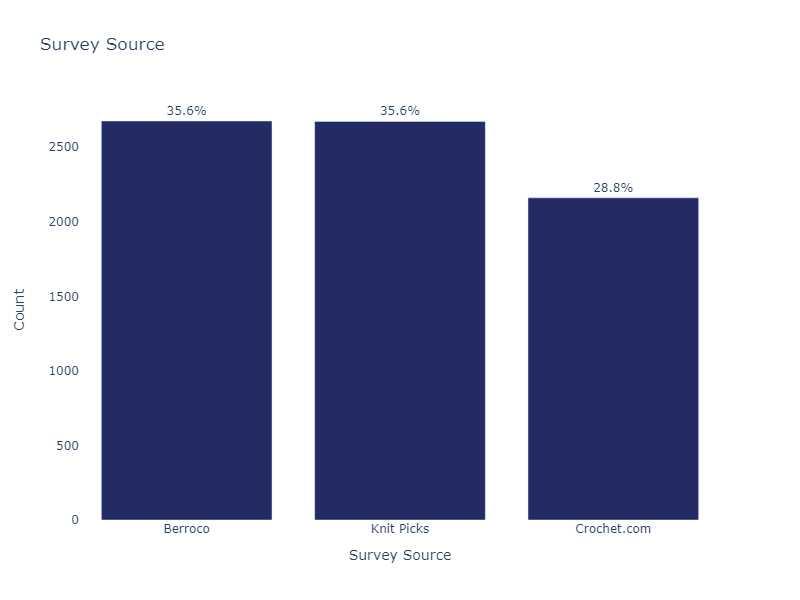

- Of the respondents, the survey sources are as follows:  (From 7510 responses)
    - Berroco: (36%)
    - Knit Picks: (36%)
    - Crochet.com: (29%)


In [25]:
question = all_responses.columns[25]

column_data = all_responses[all_responses.columns[25]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Survey Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Survey Source',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/survey_source.png")
display(Image(filename="./IMG/survey_source.png"))

summary = all_responses[question].dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, the survey sources are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: ({round(value)}%)\n"

display(Markdown(markdown_text))

<div style="page-break-after: always;">
   
</div>

<div style="text-align: center;">

<h1>Knit Picks</h1>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    This section will focus on questions answered by Knit Picks respondents, and the questions unique to Knit Picks.
</div>

In [26]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')
# Filter rows where the value in the column at index 25 is 'Knit Picks'
all_responses = all_responses[all_responses.iloc[:, 25] == 'Knit Picks']

## Demographic Summary

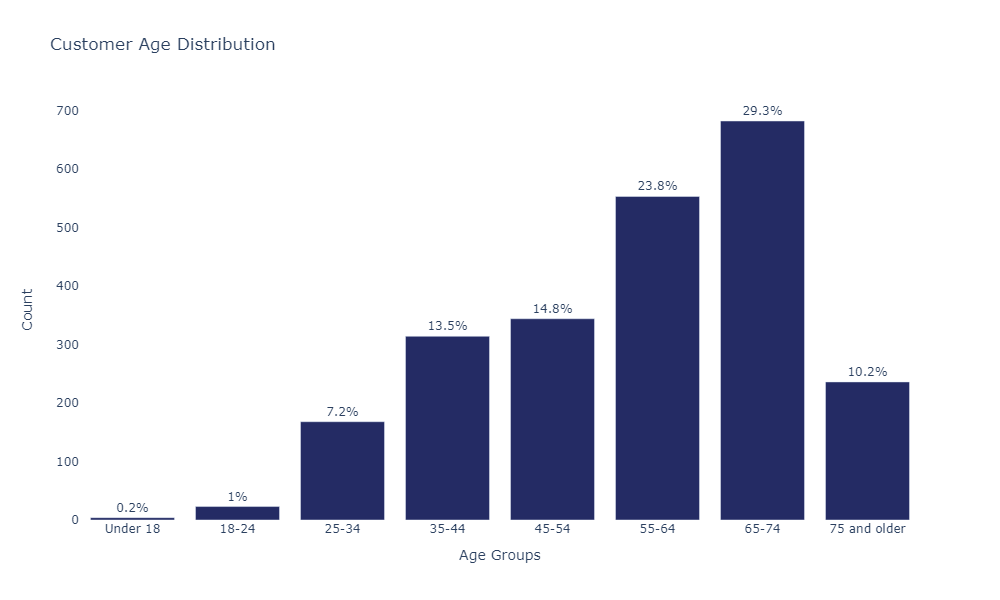

 - Out of **2324** respondents, the average respondent age is: **57** and the median age is: **59**. (From 2324 responses)

- Of these respondents, they identify as: (From 2324 responses)
    - Woman: **97.2%**
    - Non-Conforming / Non-Binary: **1.3%**
    - Man: **1.3%**
    - Transgender: **0.2%**


- The average household income ranges from **\$74,683** to **\$94,229**. (From 1785 responses)
  - For ages **Under 18**: the average is between **\$0** and **\$20,000**.
  - For ages **18-24**: the average is between **\$45,312** and **\$64,062**.
  - For ages **25-34**: the average is between **\$82,372** and **\$104,196**.
  - For ages **35-44**: the average is between **\$94,559** and **\$117,415**.
  - For ages **45-54**: the average is between **\$92,639** and **\$114,806**.
  - For ages **55-64**: the average is between **\$81,923** and **\$102,595**.
  - For ages **65-74**: the average is between **\$61,834** and **\$79,205**.
  - For ages **75 and older**: the average is between **\$53,488** and **\$69,805**.


In [27]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[75]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Groups',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondents, the average respondent age is: **{average_age}** and the median age is: **{median_age}**. (From {sample_size} responses)" ))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[76]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = f"- Of these respondents, they identify as: (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{value:.1f}%**\n"

display(Markdown(markdown_text))

### Income Section ###

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[all_responses.columns[75]] != 'Prefer not to answer') & 
                                        (all_responses[all_responses.columns[80]] != 'Prefer not to answer')]
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[75]], categories=categories, ordered=True)

# Define a new function to extract lower and upper bounds of the income range
def extract_income_range(value):
    if value == 'Under $20,000':
        return (0, 20000)
    elif value == 'Over $200,000':
        return (200000, 250000)
    else:
        lower, upper = value.replace('$', '').split(' - ')
        lower = int(lower.replace(',', ''))
        upper = int(upper.replace(',', ''))
        return (lower, upper)

# Assuming 'question' is the column index for income
question = all_responses.columns[80]

filtered_responses['income_range'] = filtered_responses[question].apply(lambda x: extract_income_range(x) if isinstance(x, str) else (0,0))
filtered_responses[['income_lower', 'income_upper']] = pd.DataFrame(filtered_responses['income_range'].tolist(), index=filtered_responses.index)

age_income_ranges = filtered_responses.groupby('age_range', observed=True).agg(
    average_lowerbound=pd.NamedAgg(column='income_lower', aggfunc='mean'),
    average_upperbound=pd.NamedAgg(column='income_upper', aggfunc='mean'),
    responses=pd.NamedAgg(column='income_lower', aggfunc='count')
).reset_index()

# Calculate overall average lower and upper bounds
overall_avg_lowerbound = filtered_responses['income_lower'].mean()
overall_avg_upperbound = filtered_responses['income_upper'].mean()
total_responses = filtered_responses['income_lower'].count()

# Formatting the overall averages for markdown_part1
formatted_avg_lower = "${:,.0f}".format(overall_avg_lowerbound)
formatted_avg_upper = "${:,.0f}".format(overall_avg_upperbound)

# Constructing markdown_part1 with the overall averages
markdown_part1 = f"- The average household income ranges from **\{formatted_avg_lower}** to **\{formatted_avg_upper}**. (From {total_responses} responses)"

# Initialize markdown_part2
markdown_part2 = ""
for _, row in age_income_ranges.iterrows():
    age_range = row['age_range']
    avg_lower = "${:,.0f}".format(row['average_lowerbound'])
    avg_upper = "${:,.0f}".format(row['average_upperbound'])
    responses = row['responses']
    markdown_part2 += f"  - For ages **{age_range}**: the average is between **\{avg_lower}** and **\{avg_upper}**.\n"

# Combining both parts
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

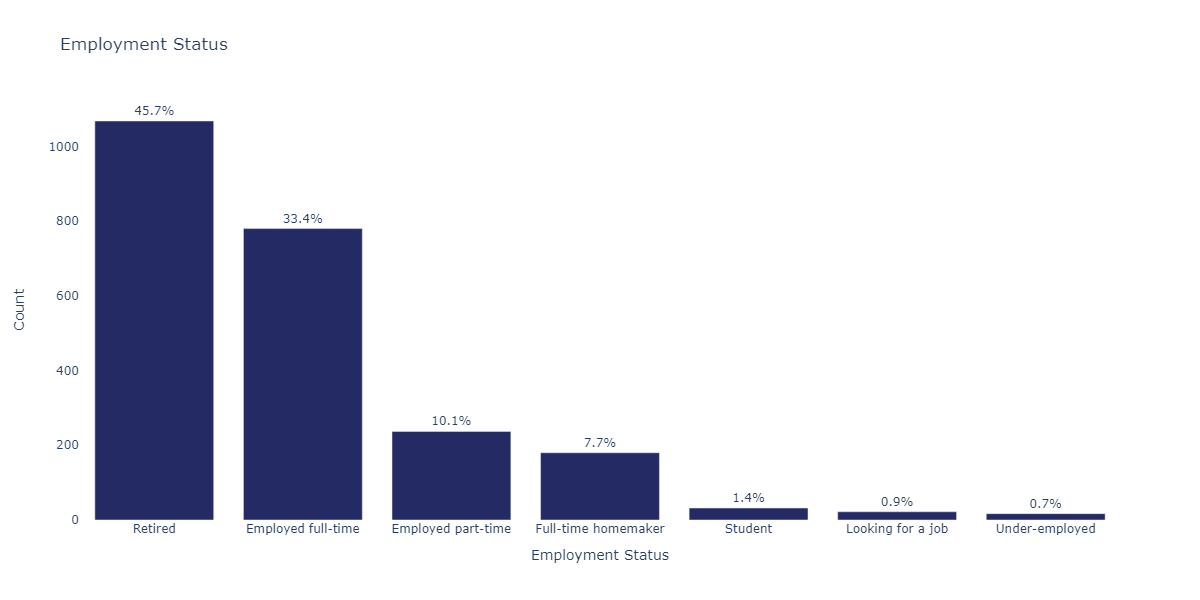

- Of the respondents, their employment statuses are as follows:  (From 2336 responses)
    - Retired: **46%**
    - Employed full-time: **33%**
    - Employed part-time: **10%**
    - Full-time homemaker: **8%**
    - Student: **1%**
    - Looking for a job: **1%**
    - Under-employed: **1%**


In [28]:
### Employment ###
question = all_responses.columns[77]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Employment Status',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1200
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, their employment statuses are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{round(value)}%**\n"

display(Markdown(markdown_text))

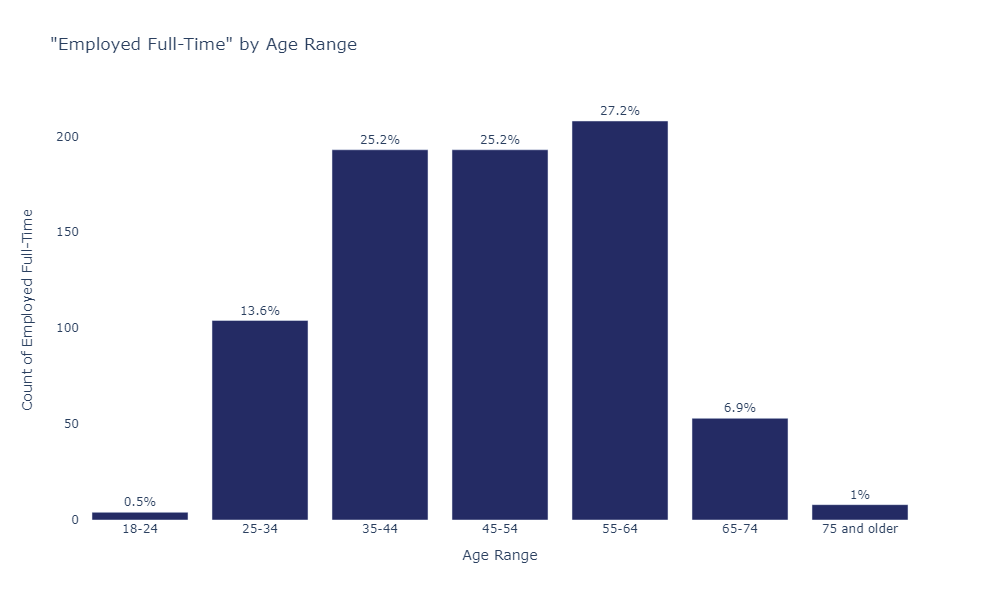

- Of those who responded 'Employed Full-Time': (From 780 responses.)
    - For ages 55-64: **27.2%**
    - For ages 35-44: **25.2%**
    - For ages 45-54: **25.2%**
    - For ages 25-34: **13.6%**
    - For ages 65-74: **6.9%**
    - For ages 75 and older: **1.0%**
    - For ages 18-24: **0.5%**


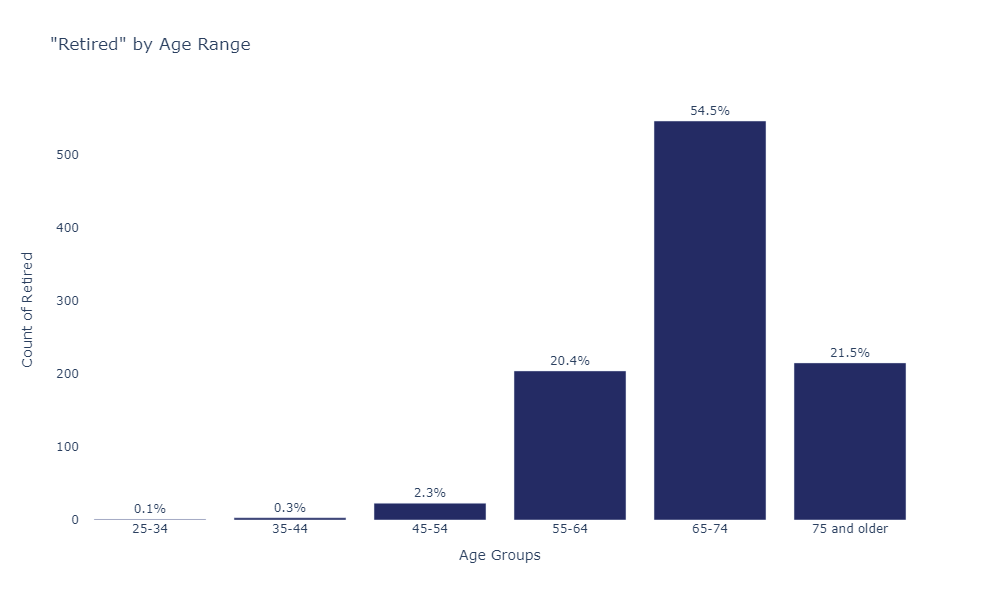

- Of those who responded 'Retired': (From 1068 responses.)
    - For ages 65-74: **54.5%**
    - For ages 75 and older: **21.5%**
    - For ages 55-64: **20.4%**
    - For ages 45-54: **2.3%**
    - For ages 35-44: **0.3%**
    - For ages 25-34: **0.1%**


In [29]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[75]
employment_status_column = all_responses.columns[77]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']
sample_size = employed_full_time.shape[0]

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Employed Full-Time': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - For ages {age_group}: **{percentage}%**\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']
sample_size = retired.shape[0]

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Groups',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Retired': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - For ages {age_group}: **{percentage}%**\n"

display(Markdown(markdown_text))


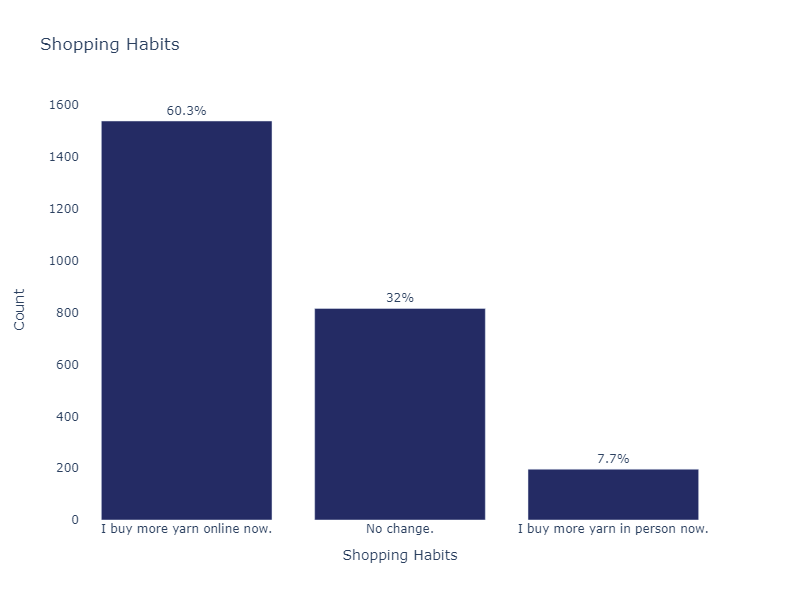

- Of the respondents, they reported that their shopping habbits have changed:  (From 2551 responses)
    - I buy more yarn online now.: **60%**
    - No change.: **32%**
    - I buy more yarn in person now.: **8%**


In [30]:
### Employment ###
question = all_responses.columns[20]

column_data = all_responses[all_responses.columns[20]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Shopping Habits',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Habits',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/shopping_habbits.png")
display(Image(filename="./IMG/shopping_habbits.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, they reported that their shopping habbits have changed:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{round(value)}%**\n"

display(Markdown(markdown_text))

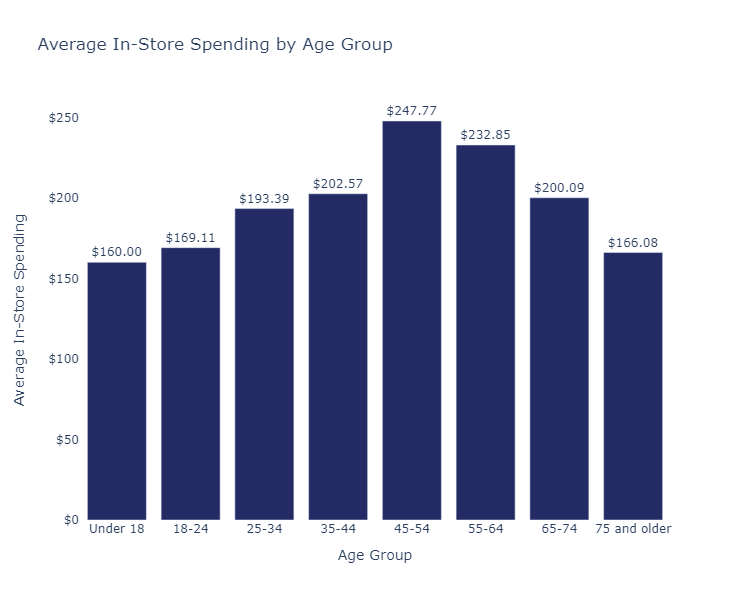

- Respondents reported making **4.1** purchases in-store per year on average, spending an average **\$50.73** per visit. On average spending **\$209.17** a year. (From 2381 responses.)
     - For ages 'Under 18': **8.0** purchases in-store per year, spending **\$20.00** per visit. On average spending **\$160.00** a year.
     - For ages '18-24': **3.9** purchases in-store per year, spending **\$43.42** per visit. On average spending **\$169.11** a year.
     - For ages '25-34': **4.1** purchases in-store per year, spending **\$46.85** per visit. On average spending **\$193.39** a year.
     - For ages '35-44': **4.1** purchases in-store per year, spending **\$49.90** per visit. On average spending **\$202.57** a year.
     - For ages '45-54': **4.6** purchases in-store per year, spending **\$54.15** per visit. On average spending **\$247.77** a year.
     - For ages '55-64': **4.3** purchases in-store per year, spending **\$54.26** per visit. On average spending **\$232.85** a year.
     - For ages '65-74': **4.0** purchases in-store per year, spending **\$50.31** per visit. On average spending **\$200.09** a year.
     - For ages '75 and older': **3.7** purchases in-store per year, spending **\$44.33** per visit. On average spending **\$166.08** a year.

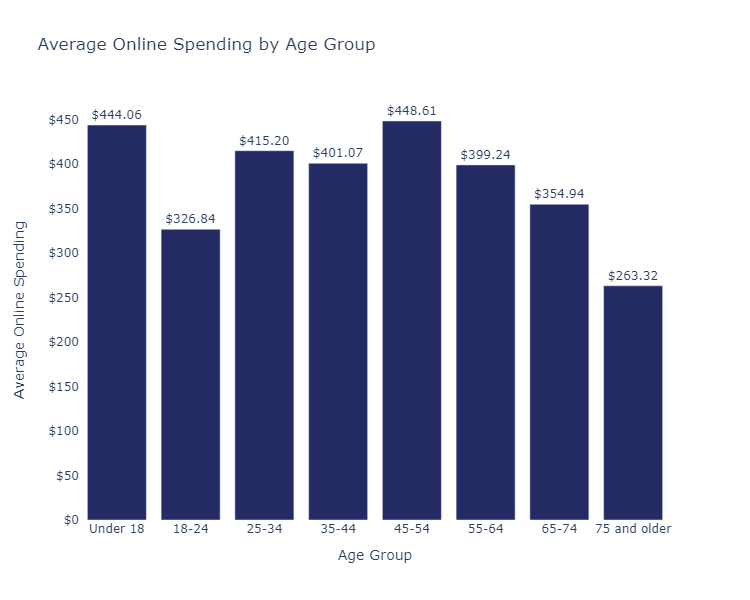

- Respondents reported making **5.1** purchases online per year on average, spending an average **\$72.67** per visit. On average spending **\$373.65** a year. (From 2430 responses.)
     - For ages 'Under 18': **8.8** purchases in-store per year, spending **\$50.75** per visit. On average spending **\$444.06** a year.
     - For ages '18-24': **4.7** purchases in-store per year, spending **\$69.00** per visit. On average spending **\$326.84** a year.
     - For ages '25-34': **5.1** purchases in-store per year, spending **\$81.35** per visit. On average spending **\$415.20** a year.
     - For ages '35-44': **5.3** purchases in-store per year, spending **\$75.90** per visit. On average spending **\$401.07** a year.
     - For ages '45-54': **5.4** purchases in-store per year, spending **\$82.94** per visit. On average spending **\$448.61** a year.
     - For ages '55-64': **5.3** purchases in-store per year, spending **\$75.15** per visit. On average spending **\$399.24** a year.
     - For ages '65-74': **5.1** purchases in-store per year, spending **\$69.11** per visit. On average spending **\$354.94** a year.
     - For ages '75 and older': **4.4** purchases in-store per year, spending **\$60.11** per visit. On average spending **\$263.32** a year.

In [31]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24], all_responses.columns[75]]]], axis=1)

# Clean up entries of "10+"
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))

# Clean up entries of "200+" and remove $.
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
filtered_df = share_of_wallet[share_of_wallet.iloc[:, 4] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
filtered_df[filtered_df.columns[4]] = pd.Categorical(filtered_df[filtered_df.columns[4]], categories=ages, ordered=True)

# Convert 'Age Group' column to a categorical type with specified order
filtered_df['Age Group'] = filtered_df[filtered_df.columns[4]]
filtered_df['Age Group'] = pd.Categorical(filtered_df['Age Group'], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_instore_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_instore_by_group = total_instore_by_group.reset_index().rename(columns={0: 'Total In-Store'})

# Create the bar graph
fig = px.bar(total_instore_by_group, x='Age Group', y='Total In-Store', title='Average In-Store Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_instore_by_group['Total In-Store']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average In-Store Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/instore_spend_by_age.png")
display(Image(filename="./IMG/instore_spend_by_age.png"))

# Markdown variables
sample_size_instore = share_of_wallet.iloc[:, 0].dropna().count()
avg_purchases_instore = share_of_wallet.iloc[:, 0].astype(float).mean()
avg_spending_instore = share_of_wallet.iloc[:, 1].astype(float).mean()
total_instore = avg_purchases_instore * avg_spending_instore

markdown_part1 = f"- Respondents reported making **{avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${avg_spending_instore:.2f}** per visit. On average spending **\${total_instore:.2f}** a year. (From {sample_size_instore} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_instore = frame.iloc[:, 0].dropna().count()
    group_avg_purchases_instore = frame.iloc[:, 0].astype(float).mean()
    group_avg_spending_instore = frame.iloc[:, 1].astype(float).mean()
    group_total_instore = group_avg_purchases_instore * group_avg_spending_instore
    # Append the group metrics to the markdown text
    markdown_part1 += f"\n     - For ages '{group}': **{group_avg_purchases_instore:.1f}** purchases in-store per year, spending **\${group_avg_spending_instore:.2f}** per visit. On average spending **\${group_total_instore:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part1))

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[2]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[3]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_online_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_online_by_group = total_online_by_group.reset_index().rename(columns={0: 'Total Online'})

# Create the bar graph
fig = px.bar(total_online_by_group, x='Age Group', y='Total Online', title='Average Online Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_online_by_group['Total Online']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Online Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/online_spend_by_age.png")
display(Image(filename="./IMG/online_spend_by_age.png"))

# Markdown variables
sample_size_online = share_of_wallet.iloc[:, 2].dropna().count()
avg_purchases_online = share_of_wallet.iloc[:, 2].astype(float).mean()
avg_spending_online = share_of_wallet.iloc[:, 3].astype(float).mean()
total_online = avg_purchases_online * avg_spending_online

markdown_part2 = f"- Respondents reported making **{avg_purchases_online:.1f}** purchases online per year on average, spending an average **\${avg_spending_online:.2f}** per visit. On average spending **\${total_online:.2f}** a year. (From {sample_size_online} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_online = frame.iloc[:, 2].dropna().count()
    group_avg_purchases_online = frame.iloc[:, 2].astype(float).mean()
    group_avg_spending_online = frame.iloc[:, 3].astype(float).mean()
    group_total_online = group_avg_purchases_online * group_avg_spending_online
    # Append the group metrics to the markdown text
    markdown_part2 += f"\n     - For ages '{group}': **{group_avg_purchases_online:.1f}** purchases in-store per year, spending **\${group_avg_spending_online:.2f}** per visit. On average spending **\${group_total_online:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part2))

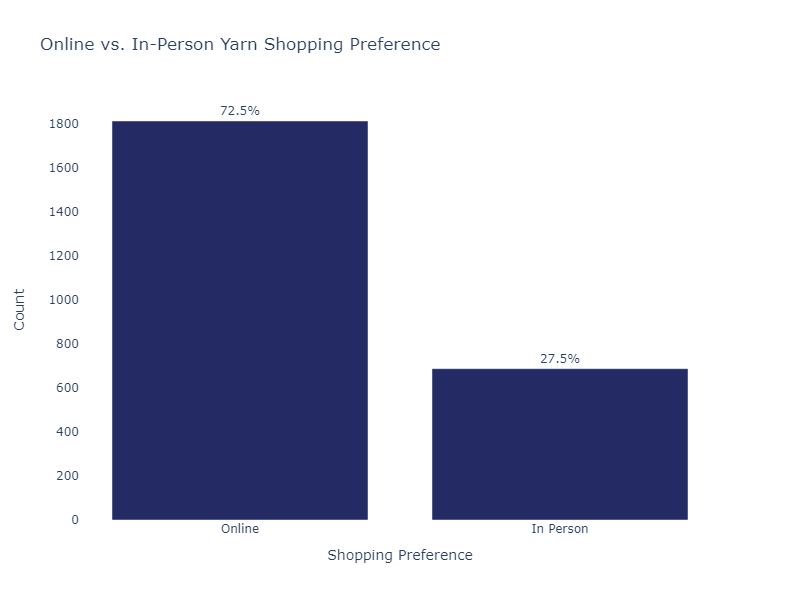

- Of the respondents **67.9%** preferred online shopping for yarn, while **25.74%** preferred shopping in person for yarn. (From 2502 responses.)
     - For ages Under 18: **50.0%** preferred shopping online, **50.0%** preferred shopping in person.
     - For ages 18-24: **82.6%** preferred shopping online, **17.4%** preferred shopping in person.
     - For ages 25-34: **76.2%** preferred shopping online, **23.2%** preferred shopping in person.
     - For ages 35-44: **74.8%** preferred shopping online, **23.9%** preferred shopping in person.
     - For ages 45-54: **69.5%** preferred shopping online, **25.9%** preferred shopping in person.
     - For ages 55-64: **70.3%** preferred shopping online, **27.5%** preferred shopping in person.
     - For ages 65-74: **72.6%** preferred shopping online, **25.8%** preferred shopping in person.
     - For ages 75 and older: **64.8%** preferred shopping online, **33.5%** preferred shopping in person.

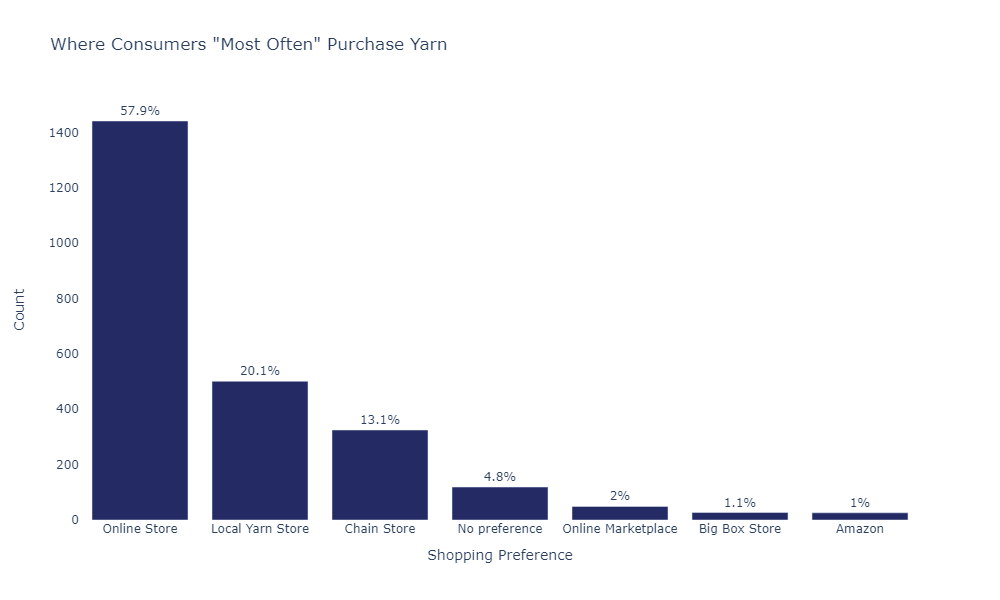

In [32]:
question = all_responses.columns[14]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Yarn Shopping Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_shopping.png")
display(Image(filename="./IMG/yarn_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[14], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for yarn, while **{inperson_percent:.2f}%** preferred shopping in person for yarn. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[15]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/yarn_shopping_location.png")
display(Image(filename="./IMG/yarn_shopping_location.png"))

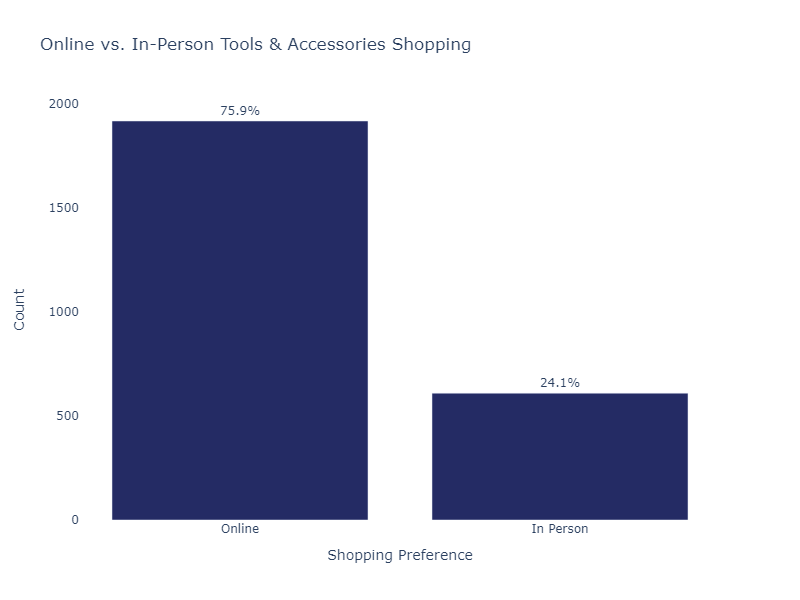

- Of the respondents **71.7%** preferred online shopping for tools & accessories, while **22.78%** preferred shopping in person for tools & accessories. (From 2525 responses.)
     - For ages Under 18: **75.0%** preferred shopping online, **25.0%** preferred shopping in person.
     - For ages 18-24: **78.3%** preferred shopping online, **21.7%** preferred shopping in person.
     - For ages 25-34: **76.2%** preferred shopping online, **23.2%** preferred shopping in person.
     - For ages 35-44: **81.2%** preferred shopping online, **17.5%** preferred shopping in person.
     - For ages 45-54: **75.9%** preferred shopping online, **21.5%** preferred shopping in person.
     - For ages 55-64: **75.9%** preferred shopping online, **23.0%** preferred shopping in person.
     - For ages 65-74: **75.4%** preferred shopping online, **23.9%** preferred shopping in person.
     - For ages 75 and older: **62.7%** preferred shopping online, **34.3%** preferred shopping in person.

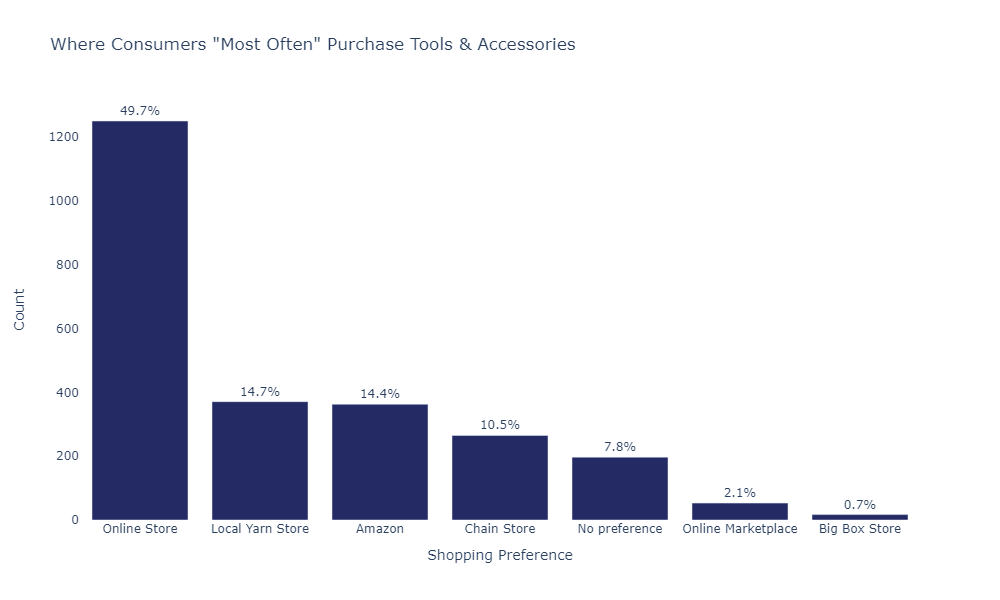

In [33]:
question = all_responses.columns[16]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Tools & Accessories Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping.png")
display(Image(filename="./IMG/tool_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[16], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for tools & accessories, while **{inperson_percent:.2f}%** preferred shopping in person for tools & accessories. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[17]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Tools & Accessories',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/tool_shopping_location.png")
display(Image(filename="./IMG/tool_shopping_location.png"))

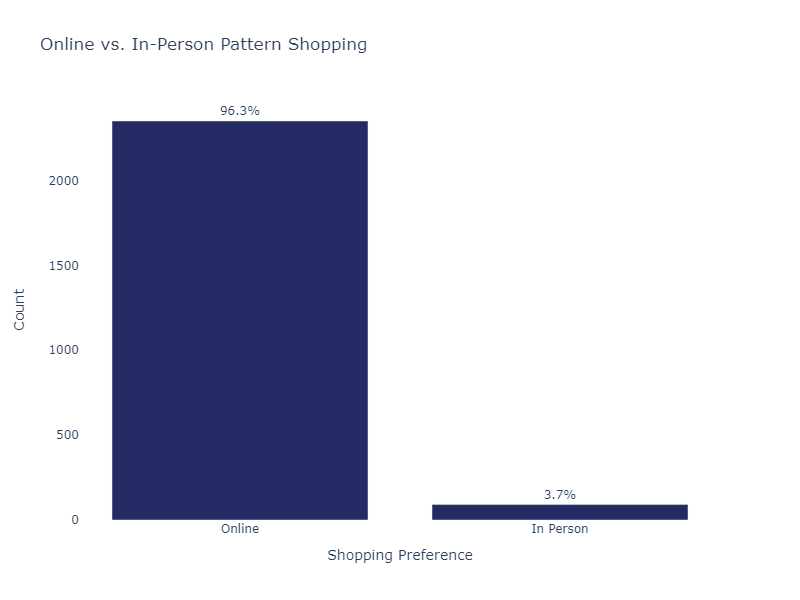

- Of the respondents **88.0%** preferred online shopping for patterns, while **3.40%** preferred shopping in person for patterns. (From 2442 responses.)
     - For ages Under 18: **75.0%** preferred shopping online, **0.0%** preferred shopping in person.
     - For ages 18-24: **100.0%** preferred shopping online, **0.0%** preferred shopping in person.
     - For ages 25-34: **94.6%** preferred shopping online, **1.2%** preferred shopping in person.
     - For ages 35-44: **95.9%** preferred shopping online, **2.5%** preferred shopping in person.
     - For ages 45-54: **97.1%** preferred shopping online, **0.6%** preferred shopping in person.
     - For ages 55-64: **94.2%** preferred shopping online, **2.5%** preferred shopping in person.
     - For ages 65-74: **90.6%** preferred shopping online, **3.7%** preferred shopping in person.
     - For ages 75 and older: **81.8%** preferred shopping online, **10.2%** preferred shopping in person.

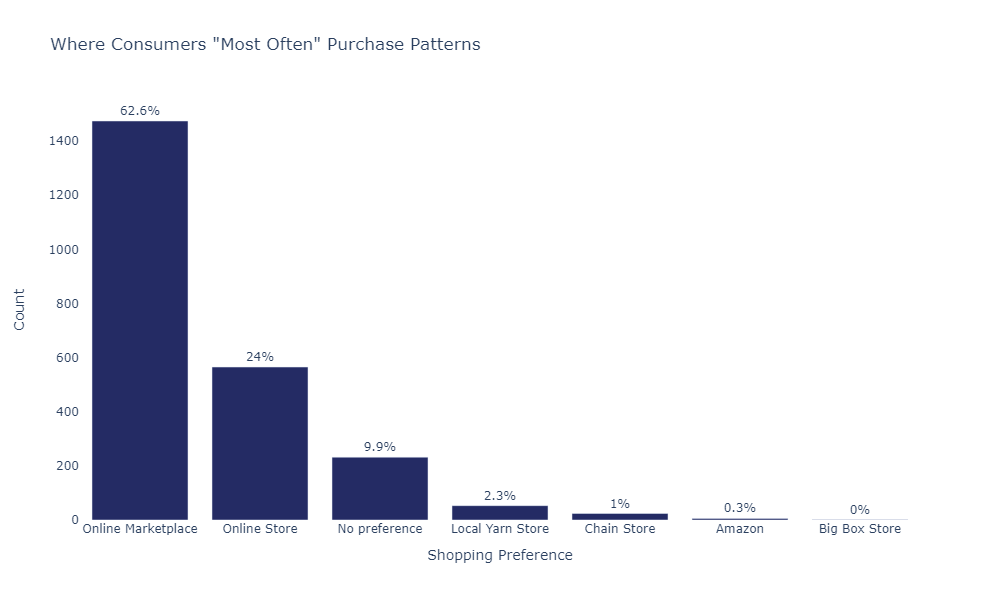

In [34]:
question = all_responses.columns[18]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Pattern Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/pattern_shopping.png")
display(Image(filename="./IMG/pattern_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[18], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for patterns, while **{inperson_percent:.2f}%** preferred shopping in person for patterns. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[19]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Patterns',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping_location.png")
display(Image(filename="./IMG/pattern_shopping_location.png"))

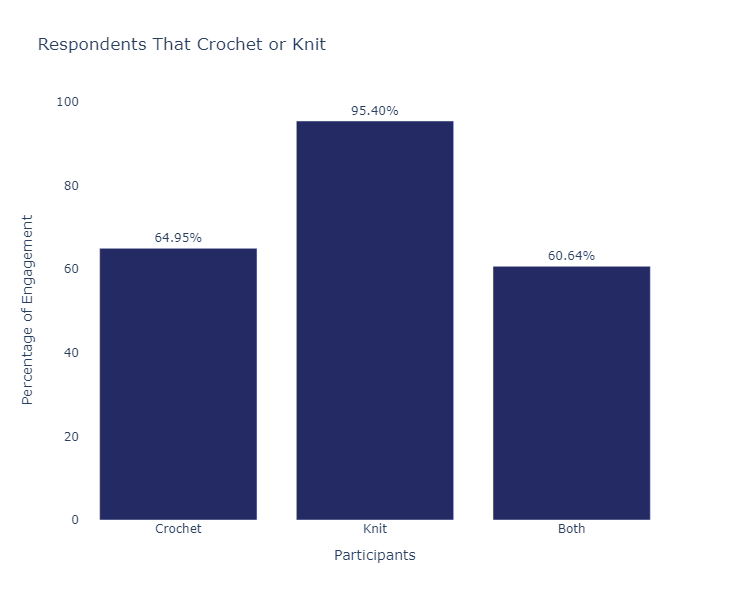

- Of the respondents, **64.9%** responded 'Yes' to crocheting, **95.40%** responded 'Yes' to knitting, while **60.64%** of respondents engage in both. (From 2673 responses.)
     - For ages Under 18, **100.0%** crochet, **100.0%** knit, and **100.0%** do both.
     - For ages 18-24, **73.9%** crochet, **95.7%** knit, and **69.6%** do both.
     - For ages 25-34, **67.3%** crochet, **94.6%** knit, and **62.5%** do both.
     - For ages 35-44, **63.4%** crochet, **97.1%** knit, and **60.5%** do both.
     - For ages 45-54, **64.8%** crochet, **93.6%** knit, and **58.4%** do both.
     - For ages 55-64, **69.6%** crochet, **94.4%** knit, and **64.0%** do both.
     - For ages 65-74, **63.0%** crochet, **96.3%** knit, and **59.5%** do both.
     - For ages 75 and older, **60.2%** crochet, **96.6%** knit, and **57.2%** do both.

In [35]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[4], all_responses.columns[7], all_responses.columns[75]]]], axis=1)

percent_yes = column_data[['Do you crochet?', 'Do you knit?']].apply(lambda x: (x == 'Yes').mean()) * 100
both_yes_percent = column_data[(column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')].shape[0] / column_data.shape[0] * 100
 
data = {'Crafting Type': ['Crochet', 'Knit'], 'Percentage': percent_yes.values}

# Update the data dictionary to include the new category
data['Crafting Type'].append('Both')
data['Percentage'] = np.append(data['Percentage'], both_yes_percent)

df = pd.DataFrame(data)

fig = px.bar(
    df,
    x='Crafting Type',
    y='Percentage',
    text='Percentage',
    title='Respondents That Crochet or Knit',
    color_discrete_sequence=['#242B64']
)

# Adding text on bars for the percentage value
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Participants',
    yaxis_title='Percentage of Engagement',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750
)

# Save and display the figure
fig.write_image("./IMG/crafting_participation.png")
display(Image(filename="./IMG/crafting_participation.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Variables
# Overall percentage of respondents who answered 'Yes' to crocheting
crochet_yes_percent = (column_data['Do you crochet?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to knitting
knit_yes_percent = (column_data['Do you knit?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to both crocheting and knitting
both_yes_percent = ((column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')).mean() * 100
# Total sample size
sample_size = column_data.shape[0]

# Initialize the markdown string
markdown_summary = f"- Of the respondents, **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.2f}%** responded 'Yes' to knitting, while **{both_yes_percent:.2f}%** of respondents engage in both. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data['What is your current age?  '] == age]
    
    # Calculate the percentages and sample size for the current age group
    crochet_yes_percent = (age_group_df['Do you crochet?'] == 'Yes').mean() * 100
    knit_yes_percent = (age_group_df['Do you knit?'] == 'Yes').mean() * 100
    both_yes_percent = ((age_group_df['Do you crochet?'] == 'Yes') & (age_group_df['Do you knit?'] == 'Yes')).mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}, **{crochet_yes_percent:.1f}%** crochet, **{knit_yes_percent:.1f}%** knit, and **{both_yes_percent:.1f}%** do both."

# Display the markdown summary
# Display the markdown text
display(Markdown(markdown_summary))

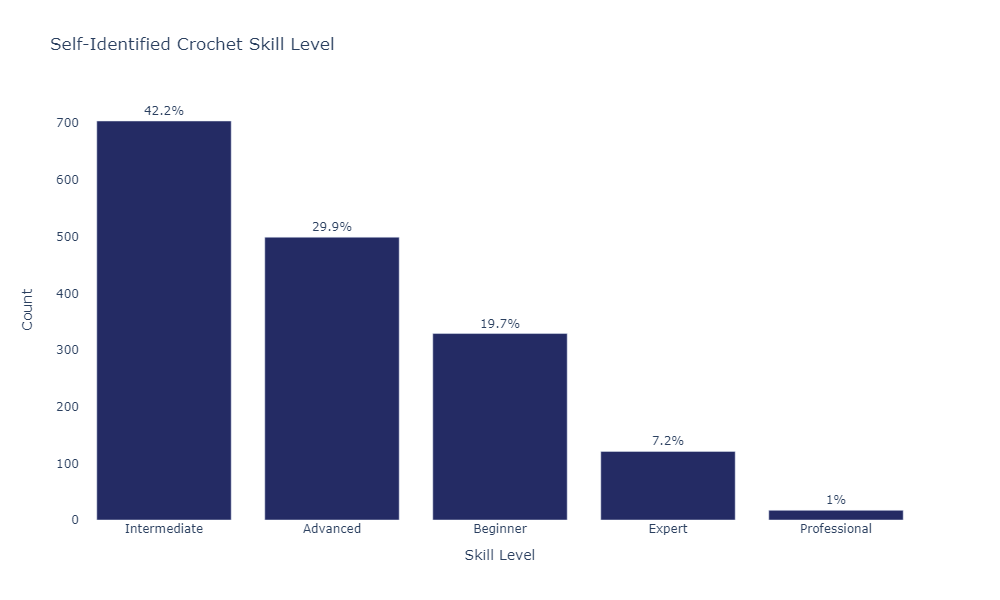

- Of the respondents who crochet, they rate their skill level as the following: (From 1736 responses.)
    - Intermediate: **42.16%**.
    - Advanced: **29.88%**.
    - Beginner: **19.70%**.
    - Expert: **7.25%**.
    - Professional: **1.02%**.


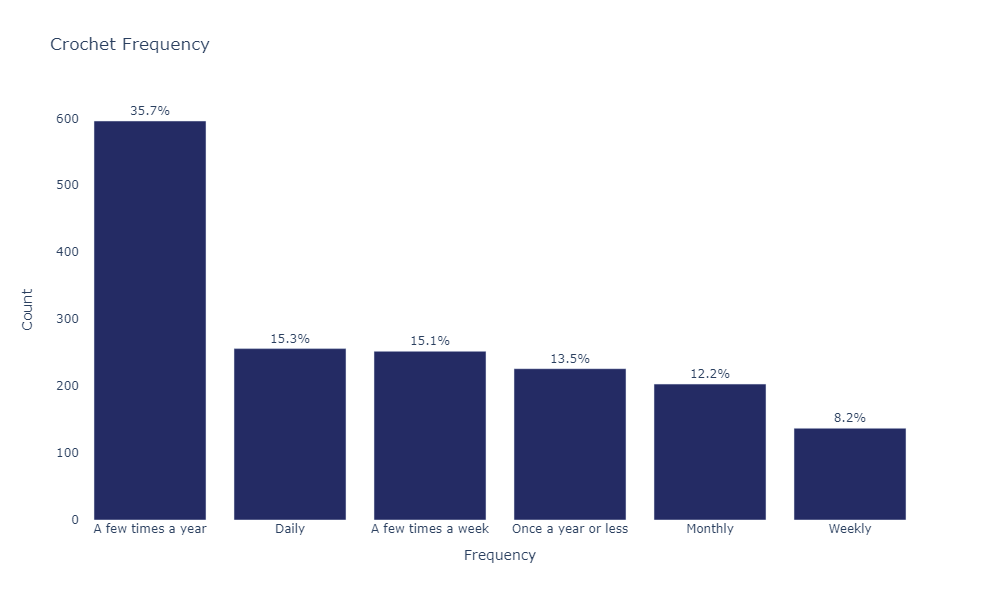

- Of the respondents who crochet, the frequency they do so is: (From 1736 responses.)
    -  A few times a year: **35.69%**
    -  Daily: **15.33%**
    -  A few times a week: **15.09%**
    -  Once a year or less: **13.53%**
    -  Monthly: **12.16%**
    -  Weekly: **8.20%**


In [36]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who crochet, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Crochet Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)
)

# Show the figure
fig.write_image("./IMG/crochet_frequency.png")
display(Image(filename="./IMG/crochet_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who crochet, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    -  {answer}: **{percentage:.2f}%**\n"
    
display(Markdown(markdown_summary))

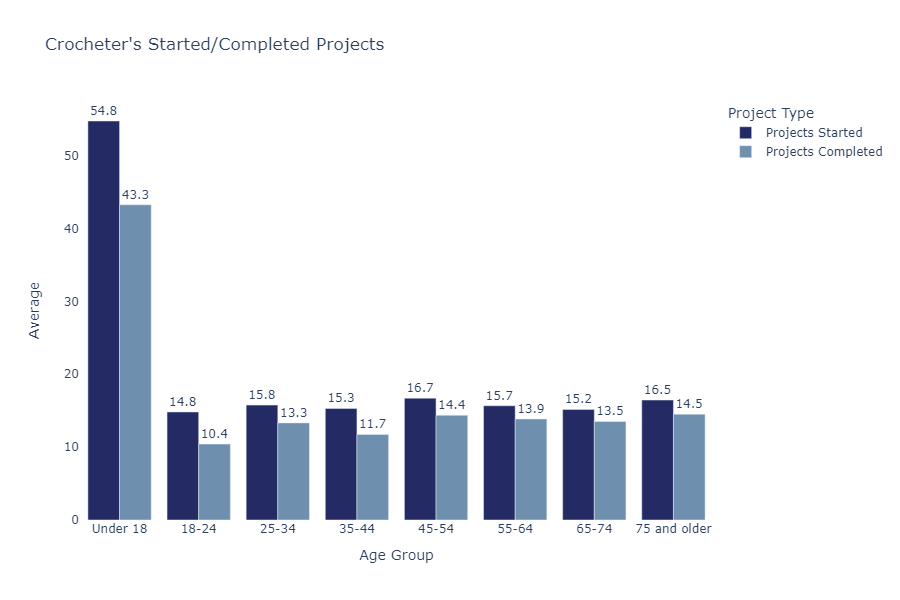

- Of the respondents, on average they start **15.8** crochet projects a year, and on average they complete **13.6** crochet projects a year. (From 1736 responses.)
     - For ages Under 18: They start **54.8** projects, and complete **43.2** projects a year.
     - For ages 18-24: They start **14.8** projects, and complete **10.4** projects a year.
     - For ages 25-34: They start **15.8** projects, and complete **13.3** projects a year.
     - For ages 35-44: They start **15.3** projects, and complete **11.7** projects a year.
     - For ages 45-54: They start **16.7** projects, and complete **14.4** projects a year.
     - For ages 55-64: They start **15.7** projects, and complete **13.9** projects a year.
     - For ages 65-74: They start **15.2** projects, and complete **13.5** projects a year.
     - For ages 75 and older: They start **16.5** projects, and complete **14.5** projects a year.

In [37]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Crocheter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/crochet_projects.png")
display(Image(filename="./IMG/crochet_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondents, on average they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: They start **{projects_started:.1f}** projects, and complete **{projects_completed:.1f}** projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

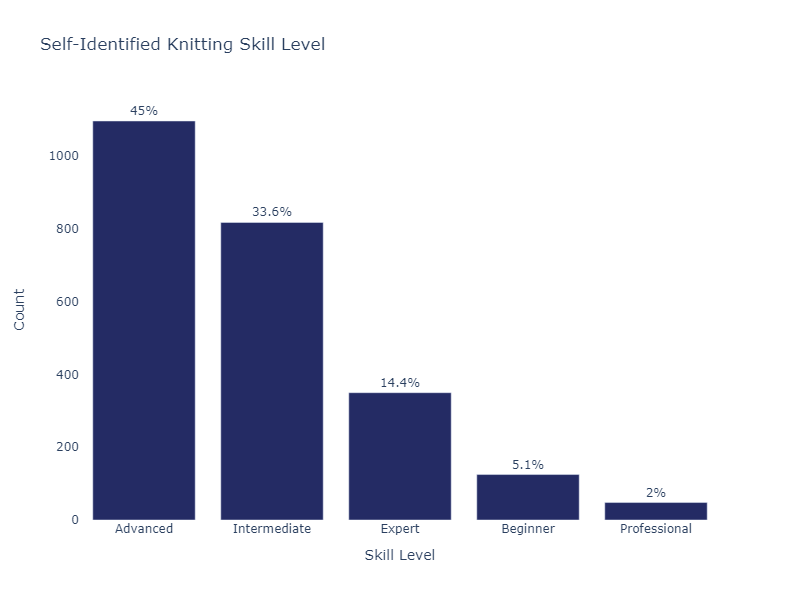

- Of the respondents who knit, they rate their skill level as the following: (From 2550 responses.)
    - Advanced: **45.00%**.
    - Intermediate: **33.55%**.
    - Expert: **14.36%**.
    - Beginner: **5.13%**.
    - Professional: **1.97%**.


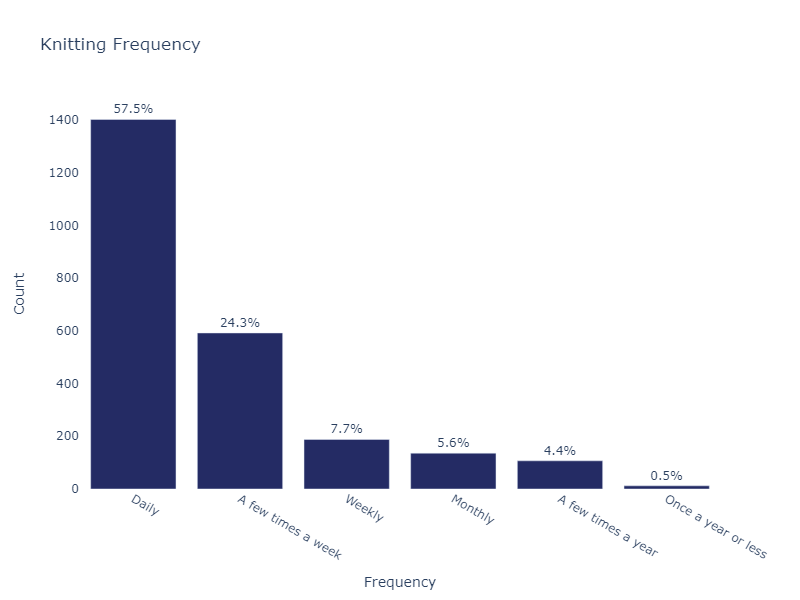

- Of the respondents who knit, the frequency they do so is: (From 2550 responses.)
    - Daily: **57.53%**.
    - A few times a week: **24.29%**.
    - Weekly: **7.71%**.
    - Monthly: **5.58%**.
    - A few times a year: **4.39%**.
    - Once a year or less: **0.49%**.


In [38]:
# Knitting Skill Level

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[8], all_responses.columns[9], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Knitting Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_skill.png")
display(Image(filename="./IMG/knitting_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who knit, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Knitting Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_frequency.png")
display(Image(filename="./IMG/knitting_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who knit, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

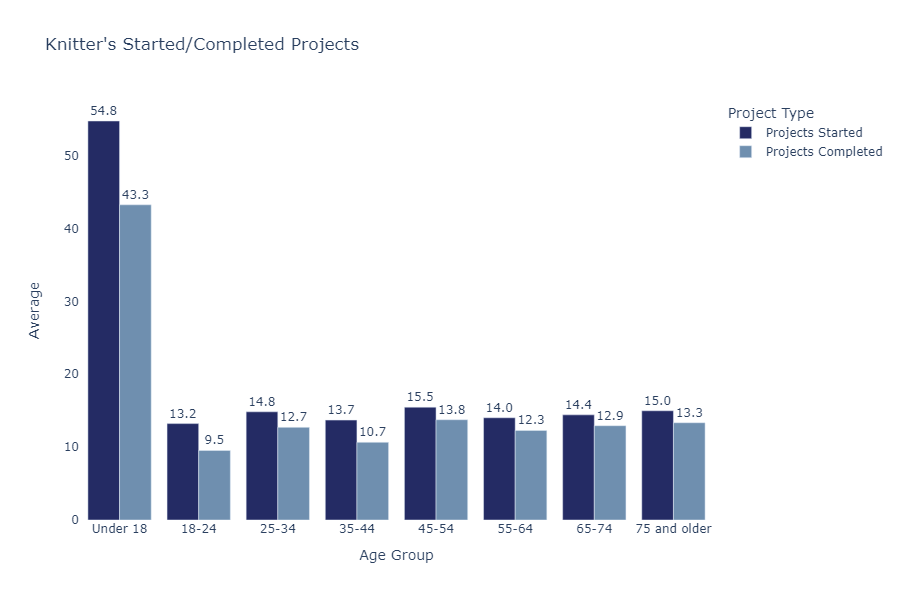

- Of the respondents, on average they start **14.5** knitting projects a year, and on average they complete **12.6** knitting projects a year. (From 2550 responses.)
     - For ages Under 18: They start **54.8** projects, and complete **43.2** projects a year.
     - For ages 18-24: They start **13.2** projects, and complete **9.5** projects a year.
     - For ages 25-34: They start **14.8** projects, and complete **12.7** projects a year.
     - For ages 35-44: They start **13.7** projects, and complete **10.7** projects a year.
     - For ages 45-54: They start **15.5** projects, and complete **13.8** projects a year.
     - For ages 55-64: They start **14.0** projects, and complete **12.3** projects a year.
     - For ages 65-74: They start **14.4** projects, and complete **12.9** projects a year.
     - For ages 75 and older: They start **15.0** projects, and complete **13.3** projects a year.

In [39]:
# Knitting Projects 

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Knitter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/knitting_projects.png")
display(Image(filename="./IMG/knitting_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondents, on average they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: They start **{projects_started:.1f}** projects, and complete **{projects_completed:.1f}** projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

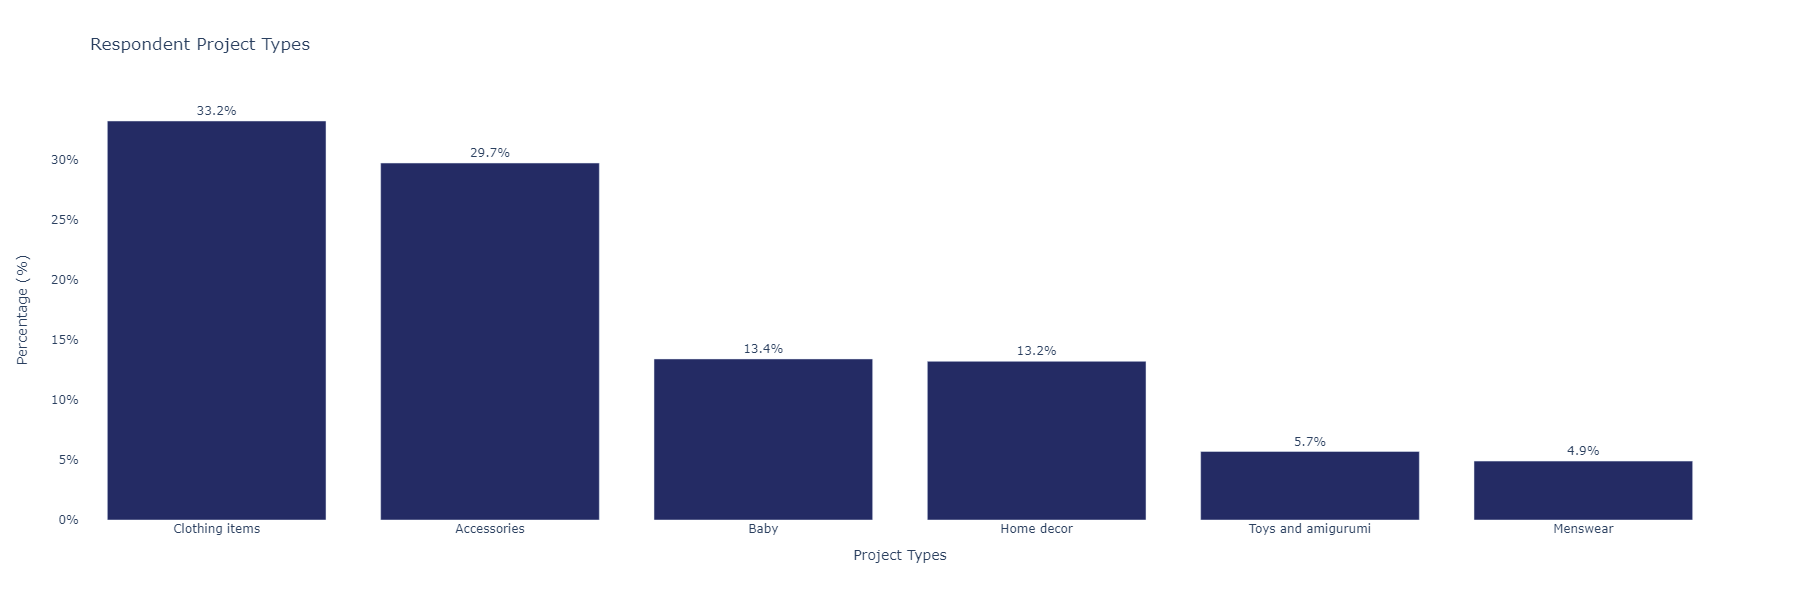

- Of the respondents, the most popular project type for all yarn crafts is: (From 2550 responses.)
     - For ages Under 18: The most popular types are **Accessories** **(37.5%)**, then **Clothing items** **(37.5%)**, and finally **Home decor** **(25.0%)**.
     - For ages 18-24: The most popular types are **Clothing items** **(41.2%)**, then **Accessories** **(21.6%)**, and finally **Toys and amigurumi** **(11.8%)**.
     - For ages 25-34: The most popular types are **Clothing items** **(35.6%)**, then **Accessories** **(27.3%)**, and finally **Home decor** **(12.9%)**.
     - For ages 35-44: The most popular types are **Clothing items** **(32.4%)**, then **Accessories** **(28.7%)**, and finally **Home decor** **(15.3%)**.
     - For ages 45-54: The most popular types are **Clothing items** **(33.5%)**, then **Accessories** **(30.5%)**, and finally **Home decor** **(13.3%)**.
     - For ages 55-64: The most popular types are **Clothing items** **(33.2%)**, then **Accessories** **(29.9%)**, and finally **Baby** **(13.4%)**.
     - For ages 65-74: The most popular types are **Clothing items** **(33.8%)**, then **Accessories** **(29.7%)**, and finally **Baby** **(15.1%)**.
     - For ages 75 and older: The most popular types are **Accessories** **(30.8%)**, then **Clothing items** **(30.4%)**, and finally **Baby** **(17.3%)**.

In [40]:
# Project Types

# Combining relevant columns into one DataFrame and dropping NaN values
column_data = pd.concat([all_responses[[all_responses.columns[41], all_responses.columns[75]]]], axis=1).dropna()

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Split project types more robustly, considering possible variations in the use of spaces around commas
split_projects = column_data[column_data.columns[0]].str.split(r'\s*,\s*')

# Explode the DataFrame to separate rows for each project type mentioned per response
exploded_projects = split_projects.explode().reset_index(drop=True)

# Filter out empty or whitespace-only project types
exploded_projects = exploded_projects[exploded_projects.str.strip().astype(bool)]

# Count occurrences of each project type
project_counts = exploded_projects.value_counts().reset_index(name='Count')
project_counts.columns = ['Project', 'Count']

# Calculate the percentage of each project's occurrence
total_mentions = project_counts['Count'].sum()
project_counts['Percentage'] = (project_counts['Count'] / total_mentions * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per project type
fig = px.bar(project_counts, x='Project', y='Percentage',
             title='Respondent Project Types',
             labels={'Percentage': 'Percentage (%)', 'Project': 'Project Types'},
             text='Percentage', color_discrete_sequence=['#242B64'])

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    yaxis_ticksuffix="%",
)

# Show the figure
fig.write_image("./IMG/project_type_preference_revised.png")
display(Image(filename="./IMG/project_type_preference_revised.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular project type for all yarn crafts is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Correctly split the project types for the current age group, taking into account spaces around commas
        exploded_projects = age_group_df.iloc[:, 0].str.split(' , ').explode()
        # Calculate the value counts and percentages for the current age group's project types
        percentages = exploded_projects.value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Project', 'Percentage']
        # Check the number of project types to report
        if len(percentages) >= 3:
            # Append the calculated metrics for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: The most popular types are **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]}%)**, and finally **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: The most popular types are **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one project type, mention only the most popular one
            markdown_summary += f"\n     - For ages{age}: The most popular type is **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]}%)**."
        else:
            # If there are no project types, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no project types with significant data."

# Display the markdown text
display(Markdown(markdown_summary))

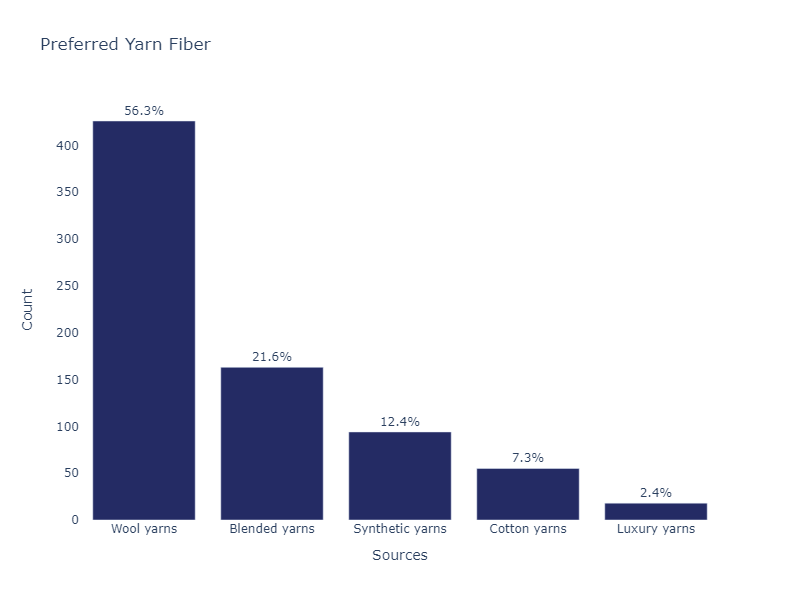

- Of the respondents, their preffered yarn fiber is: (From 756 responses.)
     - For ages Under 18: Preferred **Wool yarns** **(100.0%)**.
     - For ages 18-24: Preferred **Wool yarns** **(37.5%)**, then **Synthetic yarns** **(25.0%)**, followed by **Cotton yarns** **(25.0%)**.
     - For ages 25-34: Preferred **Wool yarns** **(62.9%)**, then **Blended yarns** **(20.0%)**, followed by **Cotton yarns** **(8.6%)**.
     - For ages 35-44: Preferred **Wool yarns** **(70.4%)**, then **Blended yarns** **(13.6%)**, followed by **Synthetic yarns** **(9.9%)**.
     - For ages 45-54: Preferred **Wool yarns** **(58.7%)**, then **Blended yarns** **(20.7%)**, followed by **Synthetic yarns** **(9.8%)**.
     - For ages 55-64: Preferred **Wool yarns** **(59.4%)**, then **Blended yarns** **(19.4%)**, followed by **Synthetic yarns** **(10.6%)**.
     - For ages 65-74: Preferred **Wool yarns** **(51.4%)**, then **Blended yarns** **(25.5%)**, followed by **Synthetic yarns** **(13.7%)**.
     - For ages 75 and older: Preferred **Wool yarns** **(53.9%)**, then **Blended yarns** **(23.6%)**, followed by **Synthetic yarns** **(16.9%)**.

In [41]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[75]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = column_data.iloc[:, 0].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Preferred Yarn Fiber',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_fibers.png")
display(Image(filename="./IMG/yarn_fibers.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, their preffered yarn fiber is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred types with significant data."



# Display the markdown text
display(Markdown(markdown_summary))

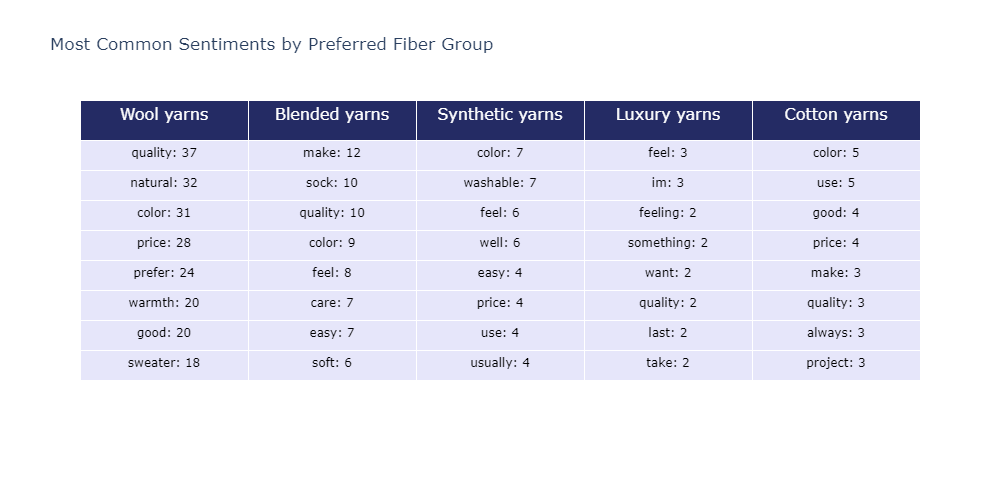

In [42]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[42]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'fiber_group', column_data.columns[1]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)
column_data.dropna(subset=[column_data.columns[1]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'yarn',
    'yarns',
    'project',
    'fibers',
    'acrylic',
    'alpaca',
    'wool',
    'cotton',
    'synthetic',
    'luxury',
    'blended',
    'knit',
    'crochet',
    'like',
    'machine'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all punctuation
    all_punct = string.punctuation + "’"  # Adding curly apostrophe
    text = text.translate(str.maketrans('', '', all_punct))
    # Tokenize
    tokens = word_tokenize(text)
    # Filter out stop words and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

# Function to analyze text data by fiber group
def analyze_by_fiber_group(data):
    # Dictionary to hold word counts for each group
    word_counts_by_group = defaultdict(Counter)
    
    for _, row in data.iterrows():
        fiber_group = row['fiber_group']
        tokens = preprocess_and_tokenize(row['responses'])
        # Update counts for this group
        word_counts_by_group[fiber_group].update(tokens)
    
    # Extracting most common words for each group
    most_common_by_group = {group: counts.most_common(8) for group, counts in word_counts_by_group.items()}
    return most_common_by_group

most_common_words = analyze_by_fiber_group(column_data)  

# Transform the 'most_common_words' dict to a format suitable for Plotly Table
max_words = max(len(words) for words in most_common_words.values())

# Re-initialize columns for the table using distinct fiber_group values
distinct_fiber_groups = column_data['fiber_group'].unique()
columns = ['Word'] + list(distinct_fiber_groups)

# Initialize the table data with empty strings for the updated columns list
table_data = [["" for _ in range(len(columns))] for _ in range(max_words)]

# Populate the first column with the word ranks
for i in range(max_words):
    table_data[i][0] = f"Word {i+1}"

# Fill in the word and count data using the updated fiber groups
for col_index, fiber_group in enumerate(distinct_fiber_groups, start=1):
    for row_index, (word, count) in enumerate(most_common_words.get(fiber_group, [])):
        # This assumes that the most_common_words dictionary keys match the distinct fiber group values exactly
        table_data[row_index][col_index] = f"{word}: {count}"

# Exclude the 'Word' column from the final presentation by adjusting the column headers and the table data
final_columns = columns[1:]  # Exclude the first column which is 'Word'
final_table_data = [row[1:] for row in table_data]  # Exclude the first element from each row

# Create the Plotly table without the 'Word' column
fig = go.Figure(data=[go.Table(
    header=dict(values=final_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*final_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply the same layout customizations as before
fig.update_layout(
    title_text='Most Common Sentiments by Preferred Fiber Group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000
)

fig.update_traces(
    columnwidth=[10, 10, 10, 10, 10]  # Adjust the numbers based on your preference and the number of columns
)

# Show the figure
fig.write_image("./IMG/yarn_common_words.png")
display(Image(filename="./IMG/yarn_common_words.png"))


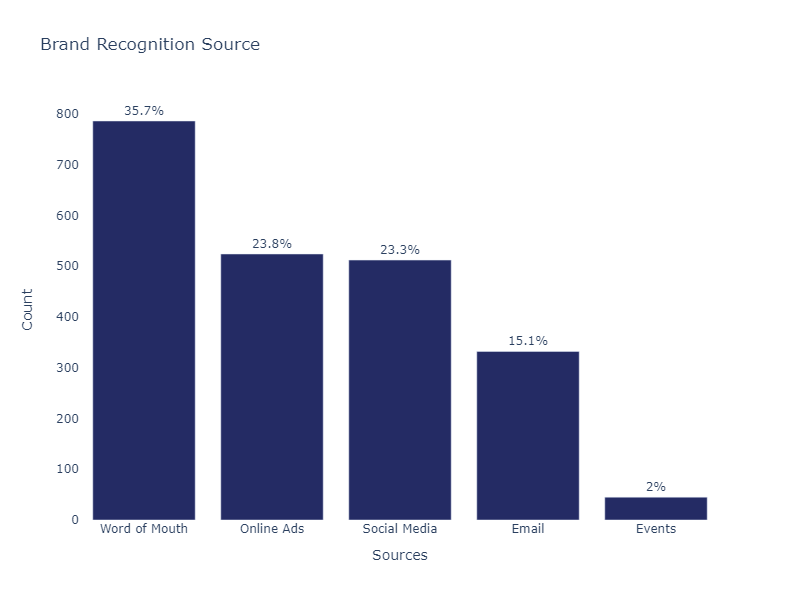

- Of the respondents, the most popular brand discovery sources are: (From 2538 responses.)
     - For ages Under 18: Preferred **Social Media** **(66.7%)** and **Word of Mouth** **(33.3%)**.
     - For ages 18-24: Preferred **Online Ads** **(34.8%)**, then **Word of Mouth** **(30.4%)**, followed by **Social Media** **(26.1%)**.
     - For ages 25-34: Preferred **Social Media** **(35.0%)**, then **Word of Mouth** **(33.8%)**, followed by **Online Ads** **(22.3%)**.
     - For ages 35-44: Preferred **Word of Mouth** **(37.3%)**, then **Social Media** **(28.0%)**, followed by **Online Ads** **(24.7%)**.
     - For ages 45-54: Preferred **Word of Mouth** **(38.8%)**, then **Social Media** **(28.9%)**, followed by **Online Ads** **(23.4%)**.
     - For ages 55-64: Preferred **Word of Mouth** **(33.7%)**, then **Social Media** **(26.6%)**, followed by **Online Ads** **(20.7%)**.
     - For ages 65-74: Preferred **Word of Mouth** **(36.9%)**, then **Online Ads** **(25.0%)**, followed by **Social Media** **(18.3%)**.
     - For ages 75 and older: Preferred **Word of Mouth** **(40.3%)**, then **Online Ads** **(23.4%)**, followed by **Email** **(21.9%)**.

In [43]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[26], all_responses.columns[75]]]], axis=1)

categories = [
    'Social Media (Instagram, Facebook, Pinterest, etc.)', 
    'Online Ads (Search engines, Sponsored content)', 
    'Word of Mouth (Friends/Family, Colleagues)', 
    'Events (In-store, Trade shows, Workshops)', 
    'Email (Promotional, Newsletter)'
]

column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].where(column_data[all_responses.columns[26]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 26].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\s{2,}", " ", regex=True).str.strip()


# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Brand Recognition Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/brand_recognition_source.png")
display(Image(filename="./IMG/brand_recognition_source.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular brand discovery sources are: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

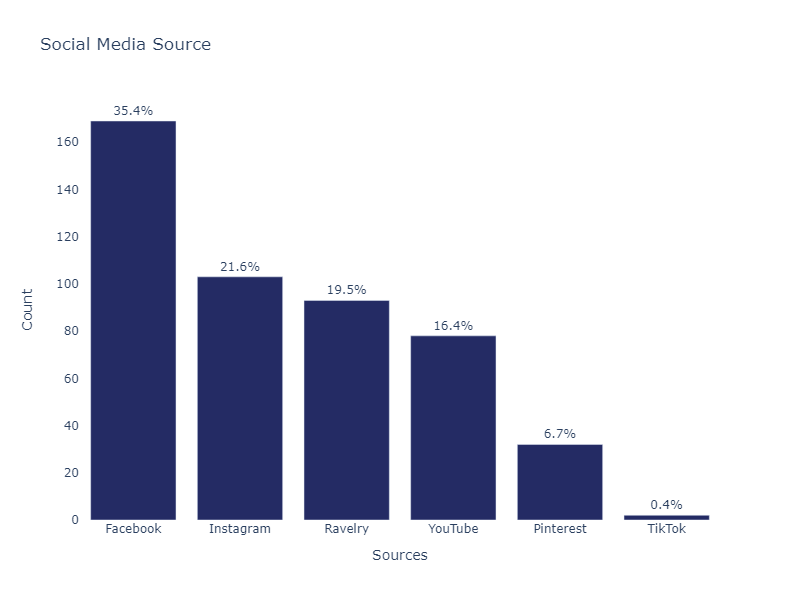

- Of the respondents that discovered a brand through social media, the most popular is: (From 477 responses.)
     - For ages Under 18: Preferred **TikTok** **(50.0%)** and **YouTube** **(50.0%)**.
     - For ages 18-24: Preferred **Instagram** **(83.3%)** and **YouTube** **(16.7%)**.
     - For ages 25-34: Preferred **Instagram** **(40.0%)**, then **YouTube** **(30.0%)**, followed by **Ravelry** **(16.0%)**.
     - For ages 35-44: Preferred **Instagram** **(28.6%)**, then **Facebook** **(27.1%)**, followed by **Ravelry** **(27.1%)**.
     - For ages 45-54: Preferred **Facebook** **(34.2%)**, then **YouTube** **(24.1%)**, followed by **Instagram** **(22.8%)**.
     - For ages 55-64: Preferred **Facebook** **(41.4%)**, then **Instagram** **(18.1%)**, followed by **Ravelry** **(17.2%)**.
     - For ages 65-74: Preferred **Facebook** **(46.1%)**, then **Ravelry** **(20.6%)**, followed by **Instagram** **(14.7%)**.
     - For ages 75 and older: Preferred **Facebook** **(59.1%)**, then **Ravelry** **(22.7%)**, followed by **Pinterest** **(9.1%)**.

In [44]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[27], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[all_responses.columns[27]] = column_data[all_responses.columns[27]].where(column_data[all_responses.columns[27]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media.png")
display(Image(filename="./IMG/social_media.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents that discovered a brand through social media, the most popular is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

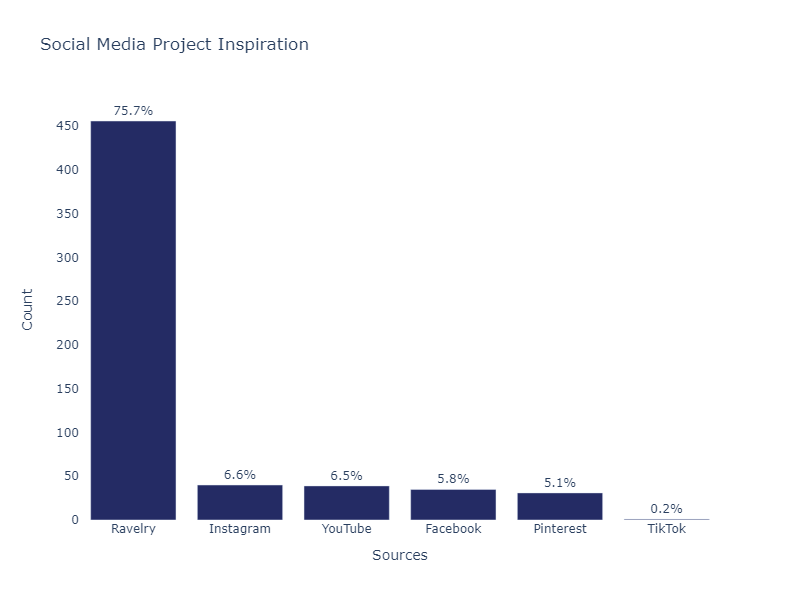

- Of the respondents, the most popular social media platform for inspiration is: (From 602 responses.)
     - For ages 18-24: Preferred **Instagram** **(44.4%)**, then **Ravelry** **(33.3%)**, followed by **Pinterest** **(22.2%)**.
     - For ages 25-34: Preferred **Ravelry** **(61.4%)**, then **Instagram** **(15.9%)**, followed by **Pinterest** **(9.1%)**.
     - For ages 35-44: Preferred **Ravelry** **(79.7%)**, then **Instagram** **(8.5%)**, followed by **Pinterest** **(6.8%)**.
     - For ages 45-54: Preferred **Ravelry** **(72.6%)**, then **Facebook** **(11.3%)**, followed by **YouTube** **(6.5%)**.
     - For ages 55-64: Preferred **Ravelry** **(75.2%)**, then **Instagram** **(6.8%)**, followed by **Facebook** **(6.8%)**.
     - For ages 65-74: Preferred **Ravelry** **(79.7%)**, then **Facebook** **(6.8%)**, followed by **YouTube** **(5.6%)**.
     - For ages 75 and older: Preferred **Ravelry** **(88.3%)**, then **Pinterest** **(5.0%)**, followed by **Facebook** **(3.3%)**.

In [45]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[44], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Project Inspiration',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media_inspiration.png")
display(Image(filename="./IMG/social_media_inspiration.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular social media platform for inspiration is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

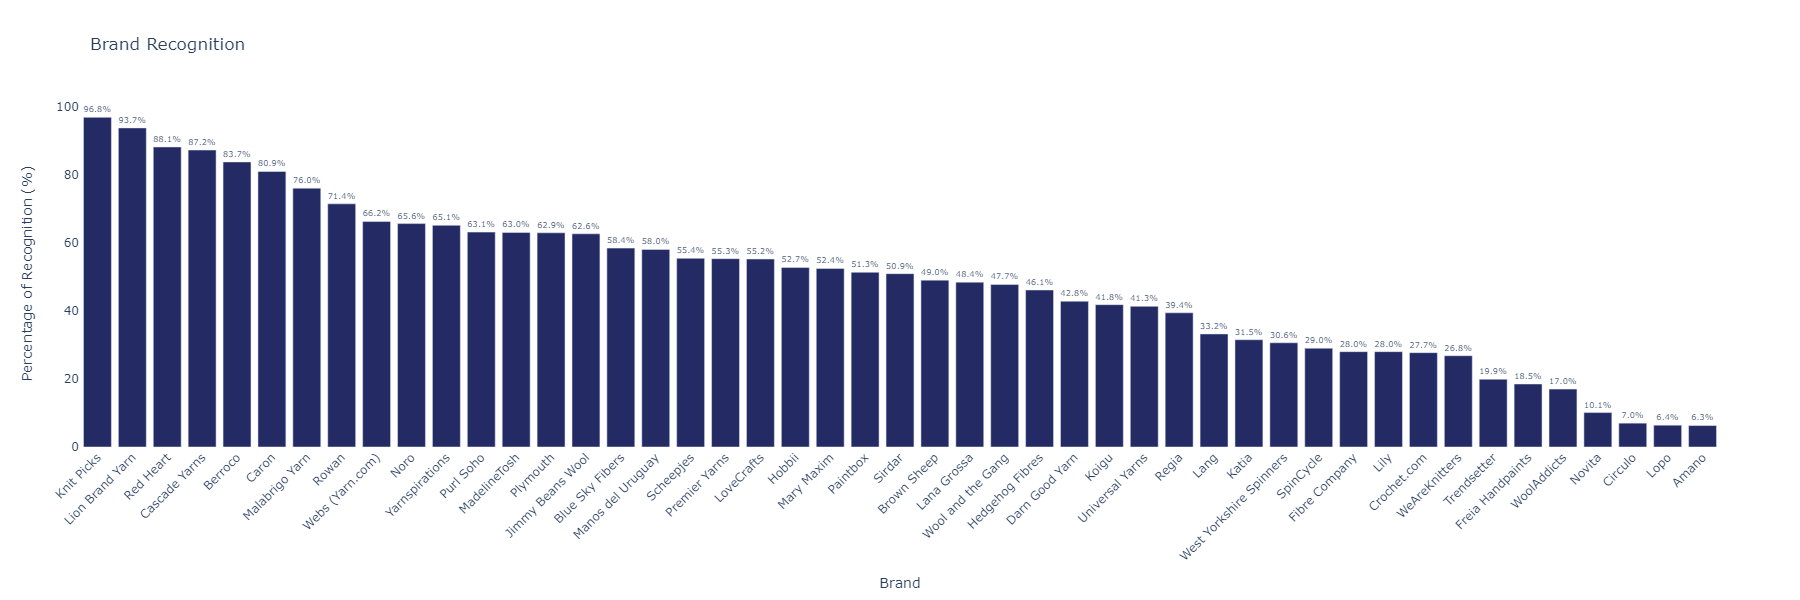

In [46]:
# Print statement question.
question = all_responses.columns[28]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 28].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 28].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Recognition',
             labels={'Percentage': 'Percentage of Recognition (%)', 'Brand': 'Brand'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_recognition.png")
display(Image(filename="./IMG/brand_recognition.png"))

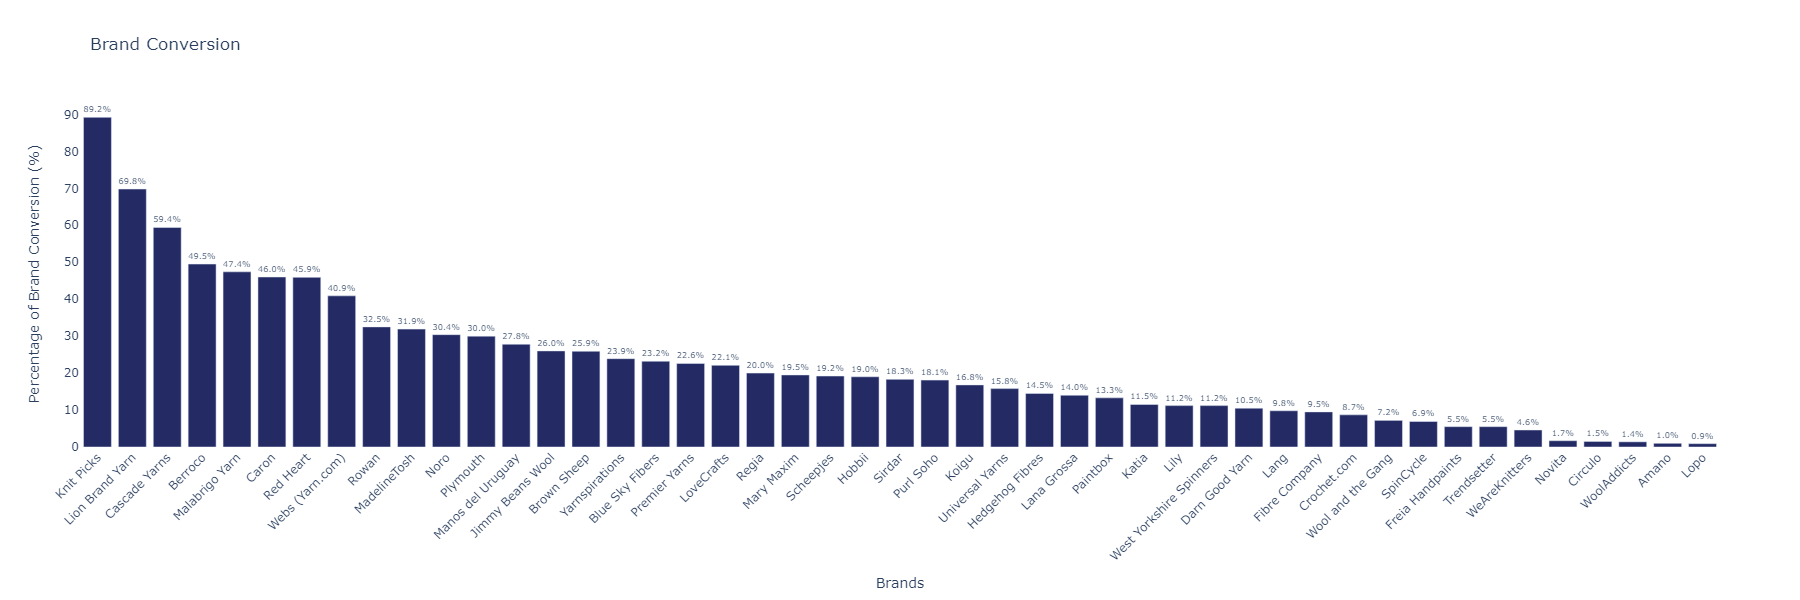

In [47]:
# Print statement question.
question = all_responses.columns[29]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 29].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 29].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Conversion',
             labels={'Percentage': 'Percentage of Brand Conversion (%)', 'Brand': 'Brands'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_conversion.png")
display(Image(filename="./IMG/brand_conversion.png"))

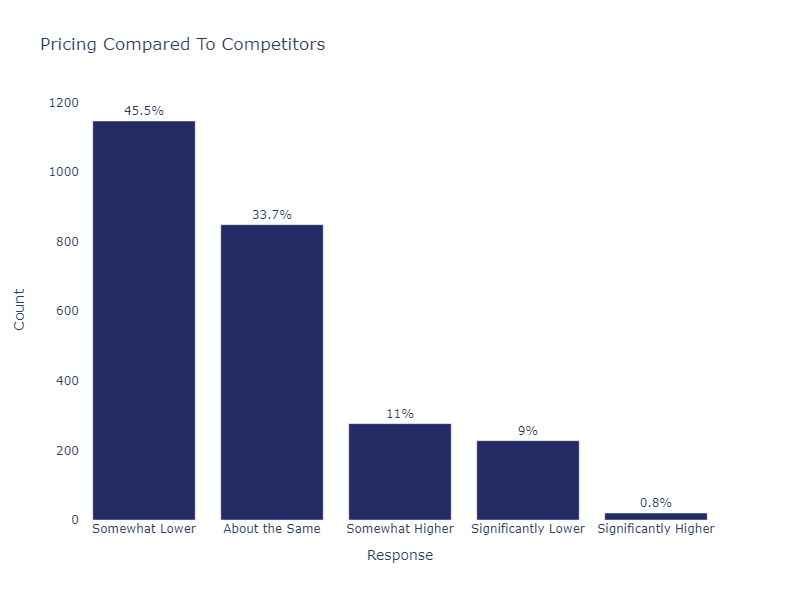

- Of the respondents, when asked about to rate the price of our produts compared to competitors:  (From 2521 responses)
    - Somewhat Lower: **(45%)**
    - About the Same: **(34%)**
    - Somewhat Higher: **(11%)**
    - Significantly Lower: **(9%)**
    - Significantly Higher: **(1%)**


In [48]:
### Employment ###
question = all_responses.columns[31]

column_data = all_responses[all_responses.columns[31]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Pricing Compared To Competitors',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/survey_source.png")
display(Image(filename="./IMG/survey_source.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about to rate the price of our produts compared to competitors:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

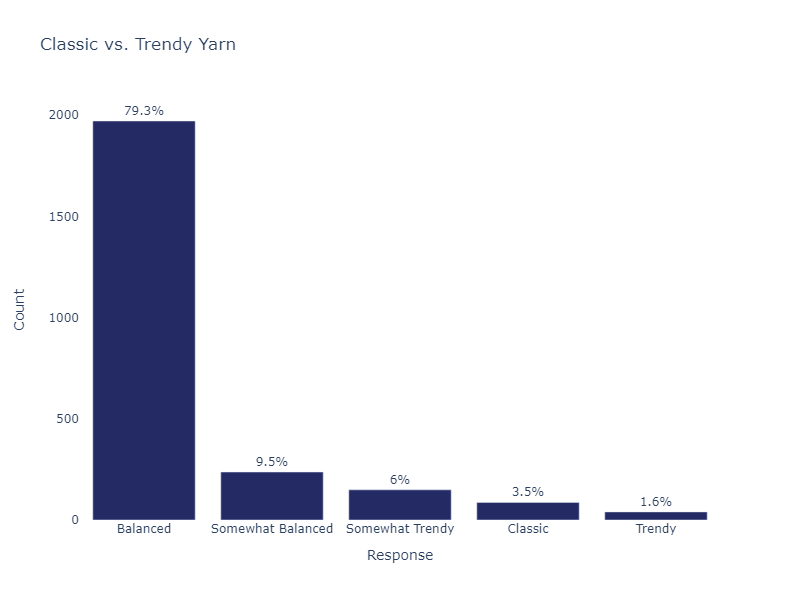

- Of the respondents, when asked about the balance between classic and trendy yarns in our selection:  (From 2484 responses)
    - Balanced: **(79%)**
    - Somewhat Balanced: **(10%)**
    - Somewhat Trendy: **(6%)**
    - Classic: **(4%)**
    - Trendy: **(2%)**


In [49]:
### Employment ###
question = all_responses.columns[48]

column_data = all_responses[all_responses.columns[48]].dropna()
sample_size = column_data.shape[0]

# Define the function to map income ranges to their midpoints
def map_answer(value):
    if value == 1:
        return 'Classic'
    elif value == 2:
        return 'Somewhat Balanced'
    elif value == 3:
        return 'Balanced'
    elif value == 4:
        return 'Somewhat Trendy'
    elif value == 5:
        return 'Trendy'
    else:
        return np.nan

# Apply the function to the column data
column_data = column_data.map(map_answer)

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Classic vs. Trendy Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/trendy_classic_yarn.png")
display(Image(filename="./IMG/trendy_classic_yarn.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about the balance between classic and trendy yarns in our selection:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

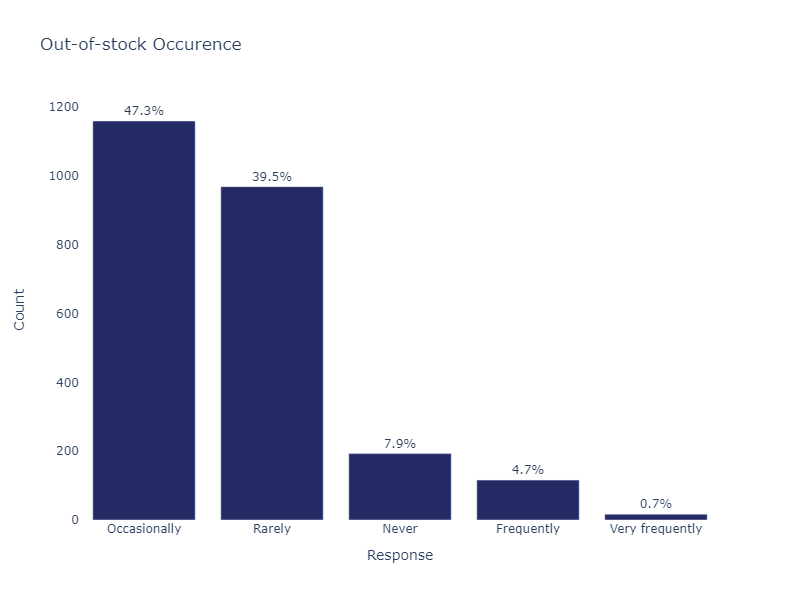

- Of the respondents, when asked about how often is something you want from our website out-of-stock:  (From 2455 responses)
    - Occasionally: **(47%)**
    - Rarely: **(39%)**
    - Never: **(8%)**
    - Frequently: **(5%)**
    - Very frequently: **(1%)**


In [50]:
question = all_responses.columns[49]

column_data = all_responses[all_responses.columns[49]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Out-of-stock Occurence',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/out_of_stock.png")
display(Image(filename="./IMG/out_of_stock.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about how often is something you want from our website out-of-stock:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

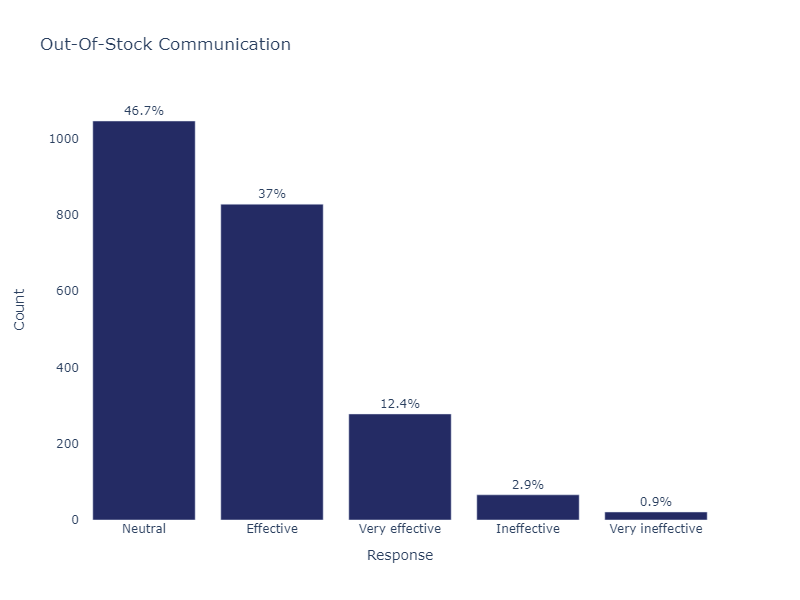

- Of the respondents who experienced out-of-stock issues, when asked about how effective is our communication is:  (From 2239 responses)
    - Neutral: **(47%)**
    - Effective: **(37%)**
    - Very effective: **(12%)**
    - Ineffective: **(3%)**
    - Very ineffective: **(1%)**


In [51]:
question = all_responses.columns[50]

column_data = all_responses[all_responses.columns[50]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Out-Of-Stock Communication',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/out_of_stock_communication.png")
display(Image(filename="./IMG/out_of_stock_communication.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents who experienced out-of-stock issues, when asked about how effective is our communication is:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

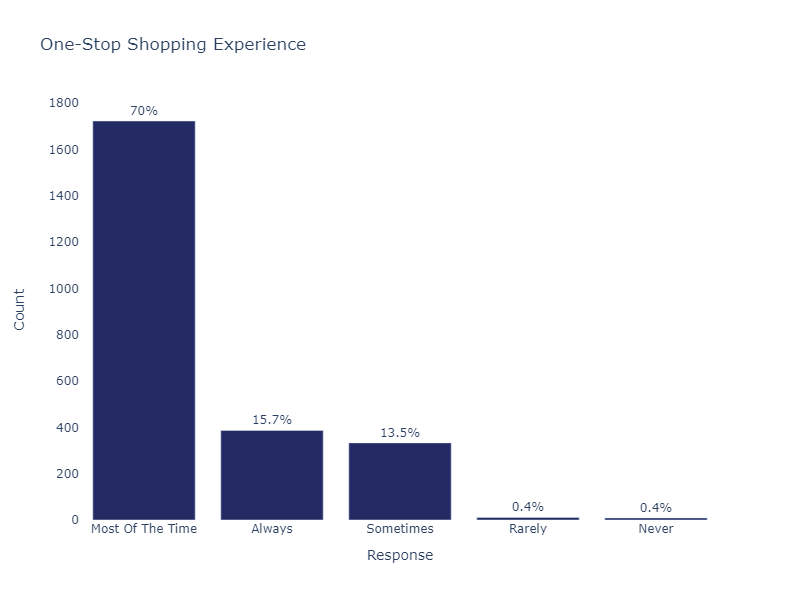

- Of the respondents, when asked if they were able to find everything they need for a project on our website:  (From 2463 responses)
    - Most Of The Time: **(70%)**
    - Always: **(16%)**
    - Sometimes: **(14%)**
    - Rarely: **(0%)**
    - Never: **(0%)**


In [52]:
question = all_responses.columns[51]

column_data = all_responses[all_responses.columns[51]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='One-Stop Shopping Experience',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/one_stop_shop.png")
display(Image(filename="./IMG/one_stop_shop.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they were able to find everything they need for a project on our website:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

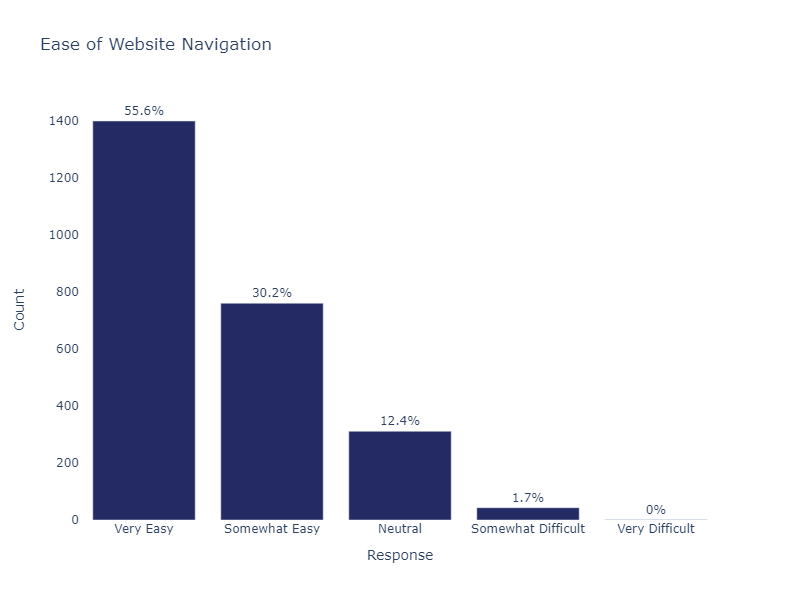

- Of the respondents, when asked the difficulty of navigating our website to browse products:  (From 2514 responses)
    - Very Easy: **(56%)**
    - Somewhat Easy: **(30%)**
    - Neutral: **(12%)**
    - Somewhat Difficult: **(2%)**
    - Very Difficult: **(0%)**


In [53]:
question = all_responses.columns[53]

column_data = all_responses[all_responses.columns[53]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Ease of Website Navigation',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/website_navigation.png")
display(Image(filename="./IMG/website_navigation.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked the difficulty of navigating our website to browse products:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

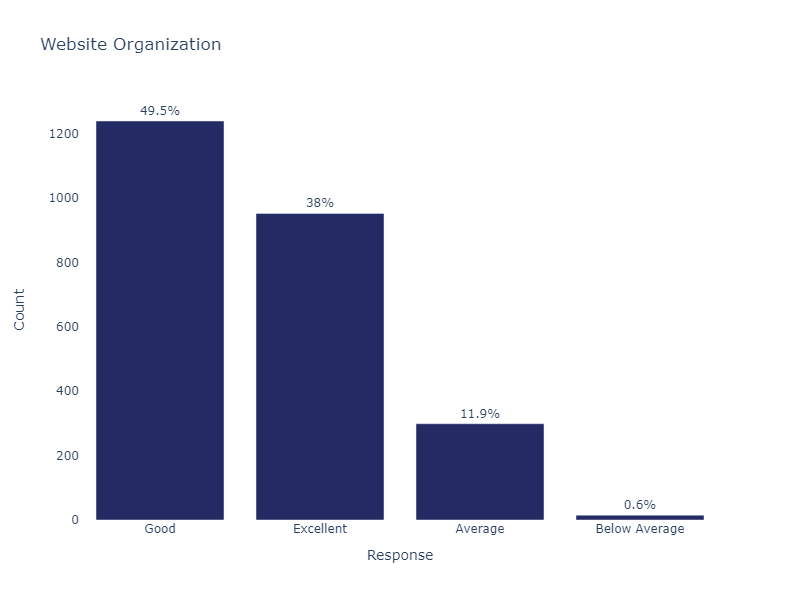

- Of the respondents, when asked how they would rate the organization and categorization of products on our site:  (From 2505 responses)
    - Good: **(49%)**
    - Excellent: **(38%)**
    - Average: **(12%)**
    - Below Average: **(1%)**


In [54]:
question = all_responses.columns[55]

column_data = all_responses[all_responses.columns[55]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Website Organization',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/website_organization.png")
display(Image(filename="./IMG/website_organization.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how they would rate the organization and categorization of products on our site:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

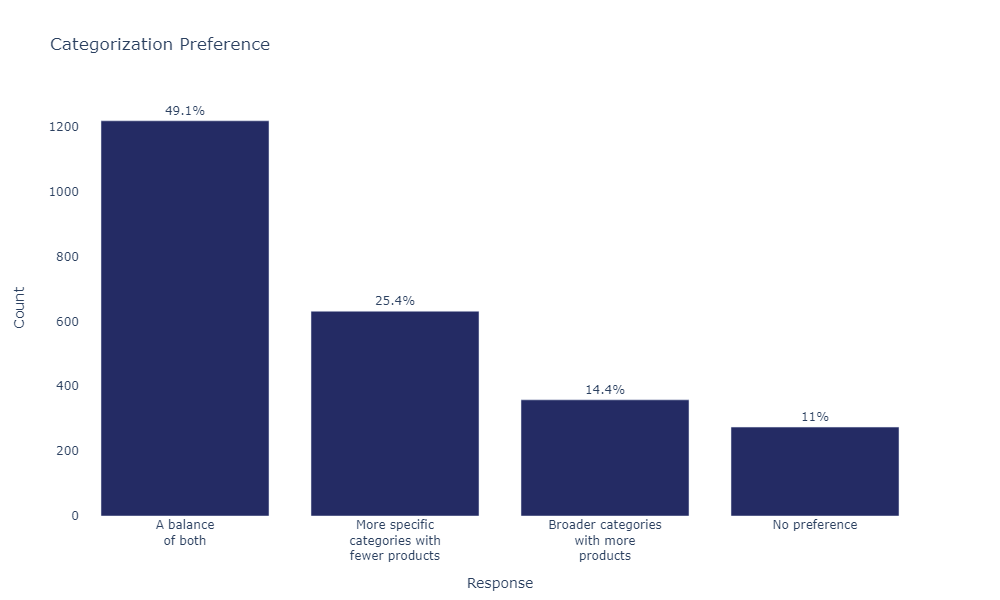

- Of the respondents, when asked if they prefer broader categories with more products or more specific categories with fewer products:  (From 2481 responses)
    - A balance of both: **(49%)**
    - More specific categories with fewer products: **(25%)**
    - Broader categories with more products: **(14%)**
    - No preference: **(11%)**


In [55]:
question = all_responses.columns[56]

column_data = all_responses[all_responses.columns[56]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

def insert_line_breaks(text):
    words = text.split()
    # Insert '<br>' after every two words
    return '<br>'.join(' '.join(words[i:i+2]) for i in range(0, len(words), 2))

# Apply the function to each category to insert line breaks
summary_df['CategoryWrapped'] = summary_df['Category'].apply(insert_line_breaks)

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='CategoryWrapped', y='Count', title='Categorization Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout to improve readability
fig.update_layout(
    xaxis=dict(
        title='Response',
        tickmode='array',
        tickvals=summary_df['CategoryWrapped'],  # Use the wrapped category
        ticktext=summary_df['CategoryWrapped']   # Use the wrapped text for ticktext
    ),
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)
# Show the figure
fig.write_image("./IMG/categorization_preference.png")
display(Image(filename="./IMG/categorization_preference.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they prefer broader categories with more products or more specific categories with fewer products:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

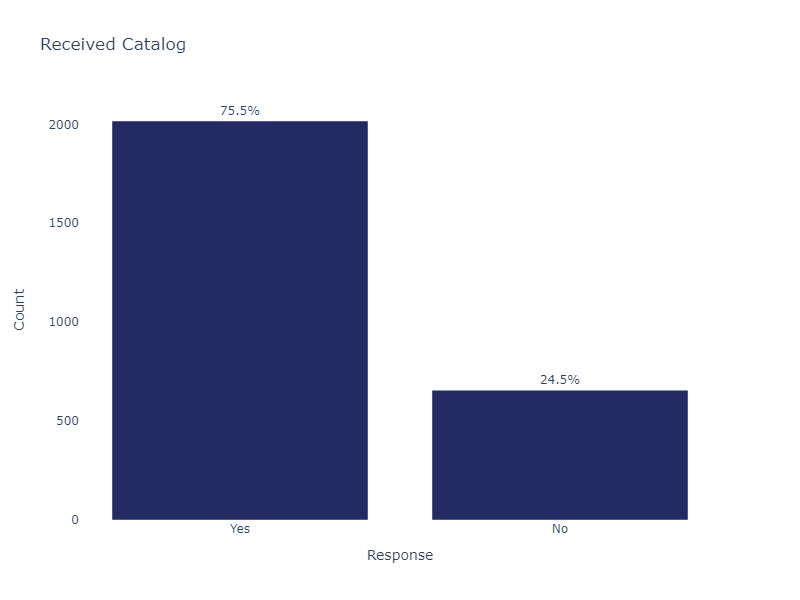

- Of the respondents, when asked if they have received one of our catalogs before:  (From 2673 responses)
    - Yes: **(75%)**
    - No: **(25%)**


In [56]:
question = all_responses.columns[57]

column_data = all_responses[all_responses.columns[57]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Received Catalog',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_received.png")
display(Image(filename="./IMG/catalog_received.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have received one of our catalogs before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

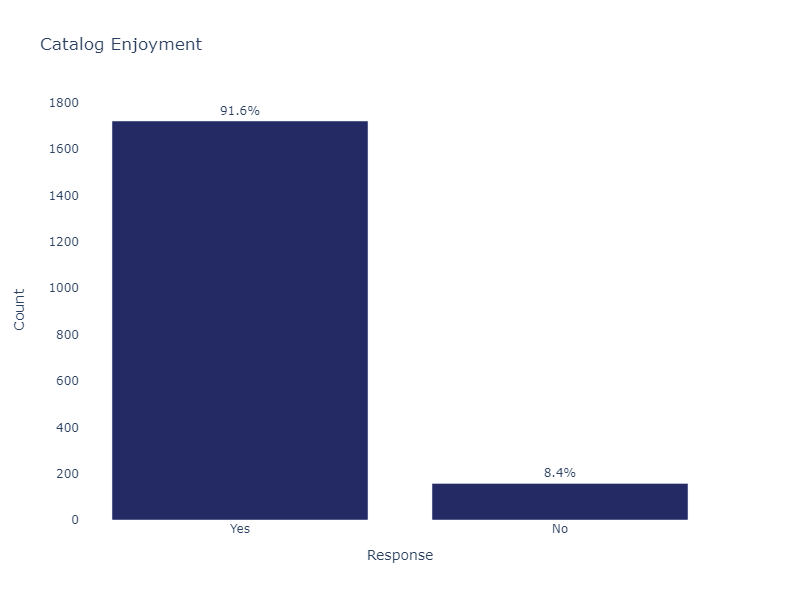

- Of the respondents, when asked if they enjoy receiving our catalog:  (From 1880 responses)
    - Yes: **(92%)**
    - No: **(8%)**


- Of the respondents, when asked if they enjoy receiving our catalog: 
     - For ages Under 18:  **Yes** **(100.0%)**
     - For ages 18-24:  **Yes** **(85.7%)**, and **No** **(14.3%)**.
     - For ages 25-34:  **Yes** **(84.3%)**, and **No** **(15.7%)**.
     - For ages 35-44:  **Yes** **(89.6%)**, and **No** **(10.4%)**.
     - For ages 45-54:  **Yes** **(90.3%)**, and **No** **(9.7%)**.
     - For ages 55-64:  **Yes** **(92.9%)**, and **No** **(7.1%)**.
     - For ages 65-74:  **Yes** **(93.0%)**, and **No** **(7.0%)**.
     - For ages 75 and older:  **Yes** **(94.1%)**, and **No** **(5.9%)**.

In [57]:
column_data = all_responses[all_responses.columns[58]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Enjoyment',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_enjoyment.png")
display(Image(filename="./IMG/catalog_enjoyment.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they enjoy receiving our catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[58], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they enjoy receiving our catalog: "

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

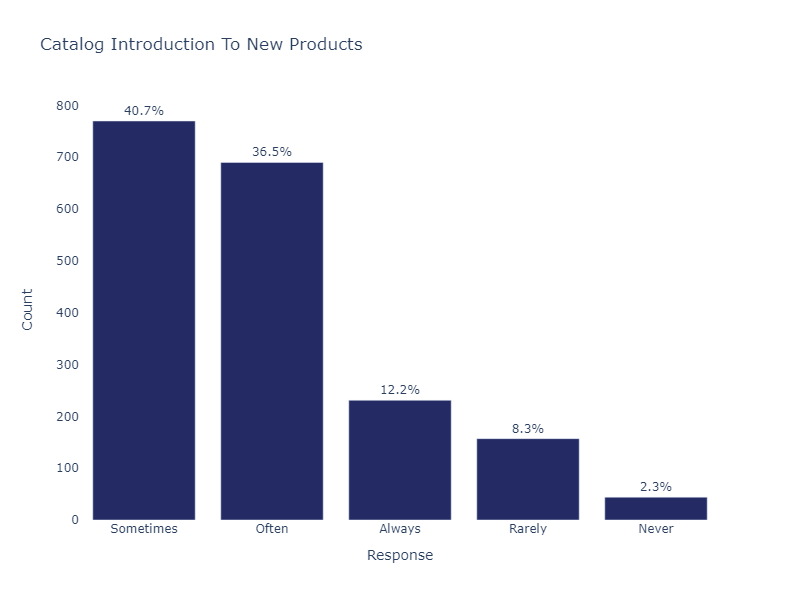

- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before:  (From 1892 responses)
    - Sometimes: **(41%)**
    - Often: **(36%)**
    - Always: **(12%)**
    - Rarely: **(8%)**
    - Never: **(2%)**


- Of the respondents,  when asked if catalogs have introduced them to products they weren't aware of before: (From 1892 responses.)
     - For ages Under 18:  **Rarely** **(50.0%)**, and **Always** **(50.0%)**.
     - For ages 18-24:  **Always** **(35.7%)**, **Sometimes** **(35.7%)**, and **Rarely** **(21.4%)**.
     - For ages 25-34:  **Sometimes** **(41.3%)**, **Often** **(28.9%)**, and **Rarely** **(15.7%)**.
     - For ages 35-44:  **Sometimes** **(40.5%)**, **Often** **(30.2%)**, and **Always** **(14.9%)**.
     - For ages 45-54:  **Sometimes** **(38.5%)**, **Often** **(35.4%)**, and **Always** **(15.2%)**.
     - For ages 55-64:  **Often** **(38.8%)**, **Sometimes** **(38.3%)**, and **Always** **(12.5%)**.
     - For ages 65-74:  **Sometimes** **(41.3%)**, **Often** **(40.8%)**, and **Always** **(11.5%)**.
     - For ages 75 and older:  **Sometimes** **(47.7%)**, **Often** **(34.3%)**, and **Always** **(10.5%)**.

In [58]:
column_data = all_responses[all_responses.columns[59]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Introduction To New Products',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_new_products.png")
display(Image(filename="./IMG/catalog_new_products.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[59], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents,  when asked if catalogs have introduced them to products they weren't aware of before: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

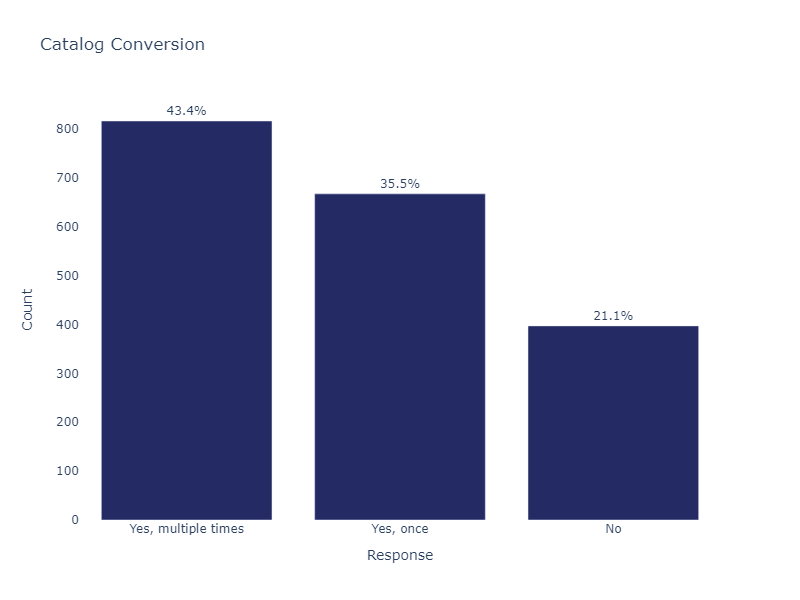

- Of the respondents, when asked if they have made a purchase after receiving a catalog:  (From 1880 responses)
    - Yes, multiple times: **(43%)**
    - Yes, once: **(35%)**
    - No: **(21%)**


- Of the respondents, when asked if they have made a purchase after receiving a catalog: (From 1880 responses.)
     - For ages Under 18:  **No** **(50.0%)**, and **Yes, once** **(50.0%)**.
     - For ages 18-24:  **No** **(50.0%)**, **Yes, once** **(35.7%)**, and **Yes, multiple times** **(14.3%)**.
     - For ages 25-34:  **No** **(40.0%)**, **Yes, once** **(37.5%)**, and **Yes, multiple times** **(22.5%)**.
     - For ages 35-44:  **Yes, once** **(36.8%)**, **Yes, multiple times** **(33.1%)**, and **No** **(30.2%)**.
     - For ages 45-54:  **Yes, multiple times** **(41.2%)**, **Yes, once** **(40.8%)**, and **No** **(18.0%)**.
     - For ages 55-64:  **Yes, multiple times** **(47.5%)**, **Yes, once** **(33.4%)**, and **No** **(19.1%)**.
     - For ages 65-74:  **Yes, multiple times** **(49.2%)**, **Yes, once** **(33.3%)**, and **No** **(17.5%)**.
     - For ages 75 and older:  **Yes, multiple times** **(52.4%)**, **Yes, once** **(34.1%)**, and **No** **(13.5%)**.

In [59]:
column_data = all_responses[all_responses.columns[60]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Conversion',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_purchase.png")
display(Image(filename="./IMG/catalog_purchase.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have made a purchase after receiving a catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[60], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they have made a purchase after receiving a catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

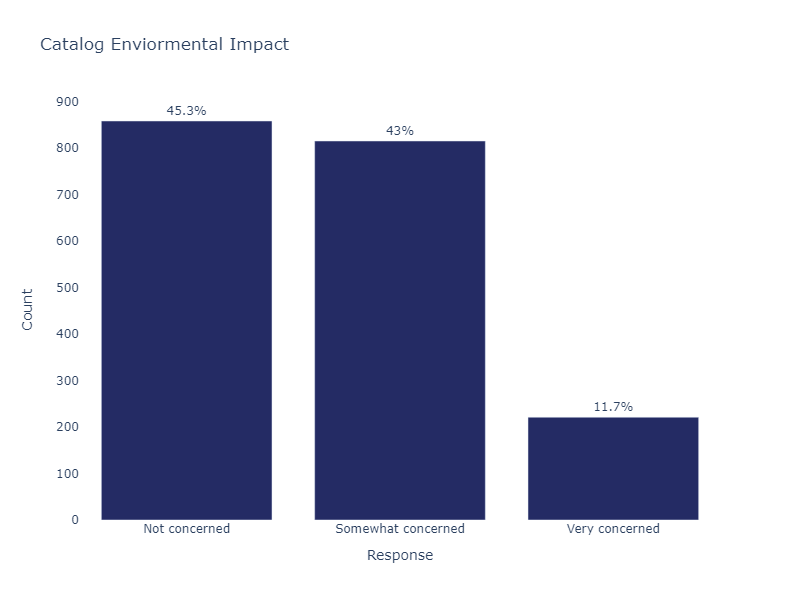

- Of the respondents, when asked if they had enviornmental concerns about the catalog:  (From 1894 responses)
    - Not concerned: **(45%)**
    - Somewhat concerned: **(43%)**
    - Very concerned: **(12%)**


- Of the respondents, when asked if they had enviornmental concerns about the catalog: (From 1894 responses.)
     - For ages Under 18:  **Somewhat concerned** **(100.0%)**
     - For ages 18-24:  **Not concerned** **(35.7%)**, **Somewhat concerned** **(35.7%)**, and **Very concerned** **(28.6%)**.
     - For ages 25-34:  **Somewhat concerned** **(47.9%)**, **Not concerned** **(41.3%)**, and **Very concerned** **(10.7%)**.
     - For ages 35-44:  **Somewhat concerned** **(46.3%)**, **Not concerned** **(40.5%)**, and **Very concerned** **(13.2%)**.
     - For ages 45-54:  **Not concerned** **(43.8%)**, **Somewhat concerned** **(43.8%)**, and **Very concerned** **(12.4%)**.
     - For ages 55-64:  **Not concerned** **(46.6%)**, **Somewhat concerned** **(40.6%)**, and **Very concerned** **(12.7%)**.
     - For ages 65-74:  **Not concerned** **(47.7%)**, **Somewhat concerned** **(43.2%)**, and **Very concerned** **(9.1%)**.
     - For ages 75 and older:  **Not concerned** **(47.1%)**, **Somewhat concerned** **(40.1%)**, and **Very concerned** **(12.8%)**.

In [60]:
column_data = all_responses[all_responses.columns[61]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Enviormental Impact',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_enviornmental_impact.png")
display(Image(filename="./IMG/catalog_enviornmental_impact.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they had enviornmental concerns about the catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[61], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they had enviornmental concerns about the catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

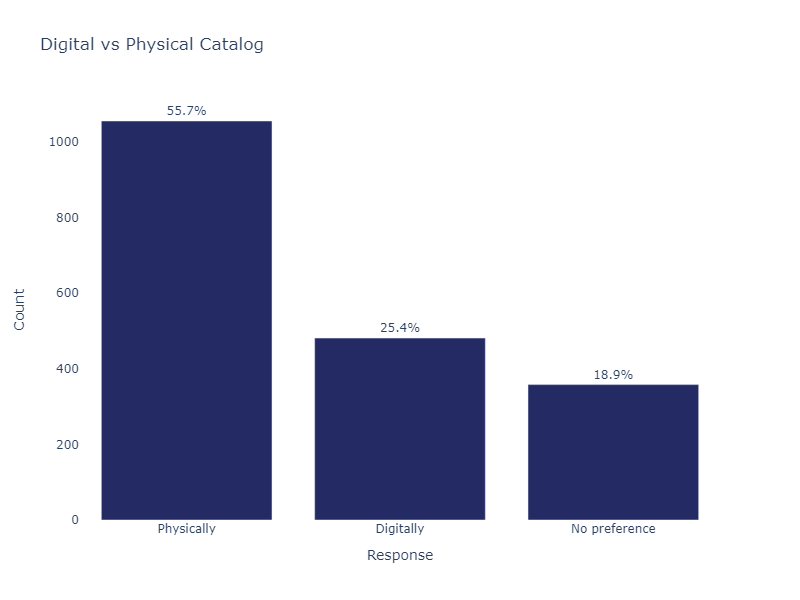

- Of the respondents, when asked if they would prefer a physical or digital catalog:  (From 1894 responses)
    - Physically: **(56%)**
    - Digitally: **(25%)**
    - No preference: **(19%)**


- Of the respondents, when asked if they would prefer a physical or digital catalog: (From 1894 responses.)
     - For ages Under 18:  **Digitally** **(50.0%)**, and **No preference** **(50.0%)**.
     - For ages 18-24:  **Physically** **(35.7%)**, **No preference** **(35.7%)**, and **Digitally** **(28.6%)**.
     - For ages 25-34:  **Physically** **(48.8%)**, **Digitally** **(29.8%)**, and **No preference** **(21.5%)**.
     - For ages 35-44:  **Physically** **(52.5%)**, **Digitally** **(28.9%)**, and **No preference** **(18.6%)**.
     - For ages 45-54:  **Physically** **(55.4%)**, **Digitally** **(25.4%)**, and **No preference** **(19.2%)**.
     - For ages 55-64:  **Physically** **(52.5%)**, **Digitally** **(25.3%)**, and **No preference** **(22.2%)**.
     - For ages 65-74:  **Physically** **(59.4%)**, **Digitally** **(23.8%)**, and **No preference** **(16.9%)**.
     - For ages 75 and older:  **Physically** **(62.4%)**, **Digitally** **(22.5%)**, and **No preference** **(15.0%)**.

In [61]:
column_data = all_responses[all_responses.columns[62]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Digital vs Physical Catalog',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_type_preference.png")
display(Image(filename="./IMG/catalog_type_preference.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they would prefer a physical or digital catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[62], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they would prefer a physical or digital catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

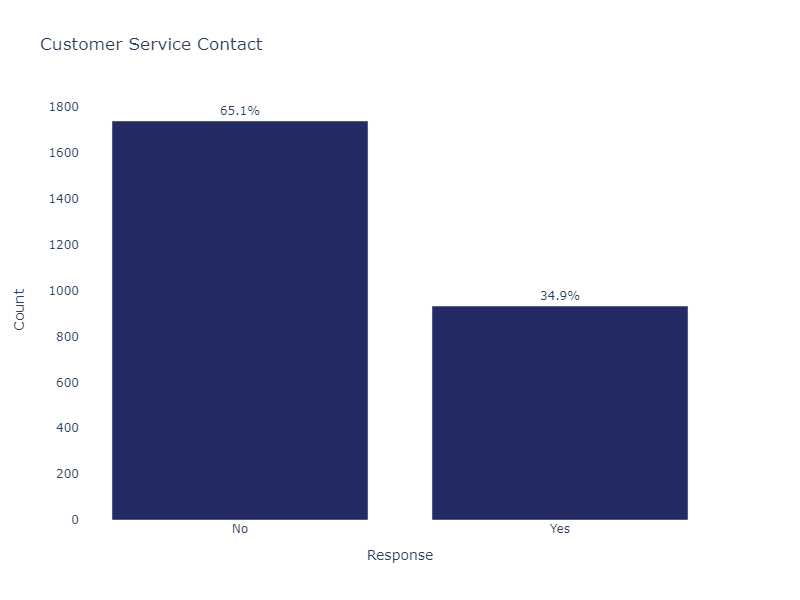

- Of the respondents, when asked if they have contacted customer service before:  (From 2673 responses)
    - No: **(65%)**
    - Yes: **(35%)**


In [62]:
column_data = all_responses[all_responses.columns[64]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Contact',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service.png")
display(Image(filename="./IMG/customer_service.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have contacted customer service before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

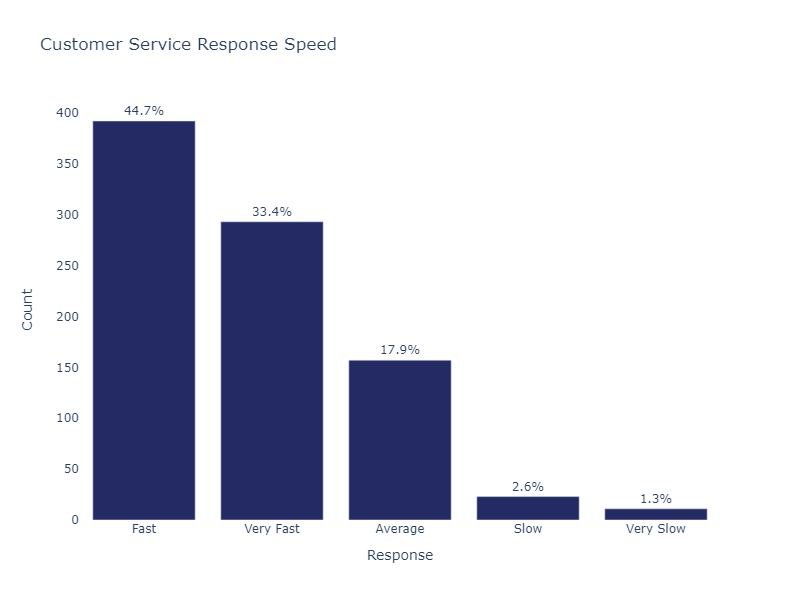

- Of the respondents, when asked about the response speed of our customer service:  (From 876 responses)
    - Fast: **(45%)**
    - Very Fast: **(33%)**
    - Average: **(18%)**
    - Slow: **(3%)**
    - Very Slow: **(1%)**


In [63]:
column_data = all_responses[all_responses.columns[65]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Response Speed',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service_speed.png")
display(Image(filename="./IMG/customer_service_speed.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about the response speed of our customer service:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

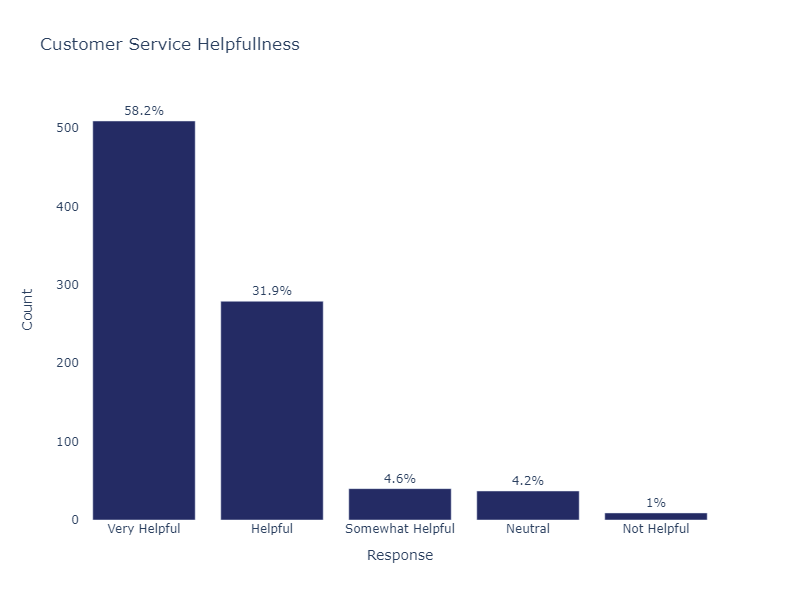

- Of the respondents, when asked how helpful our customer service is:  (From 874 responses)
    - Very Helpful: **(58%)**
    - Helpful: **(32%)**
    - Somewhat Helpful: **(5%)**
    - Neutral: **(4%)**
    - Not Helpful: **(1%)**


In [64]:
column_data = all_responses[all_responses.columns[66]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Helpfullness',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service_help.png")
display(Image(filename="./IMG/customer_service_help.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how helpful our customer service is:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

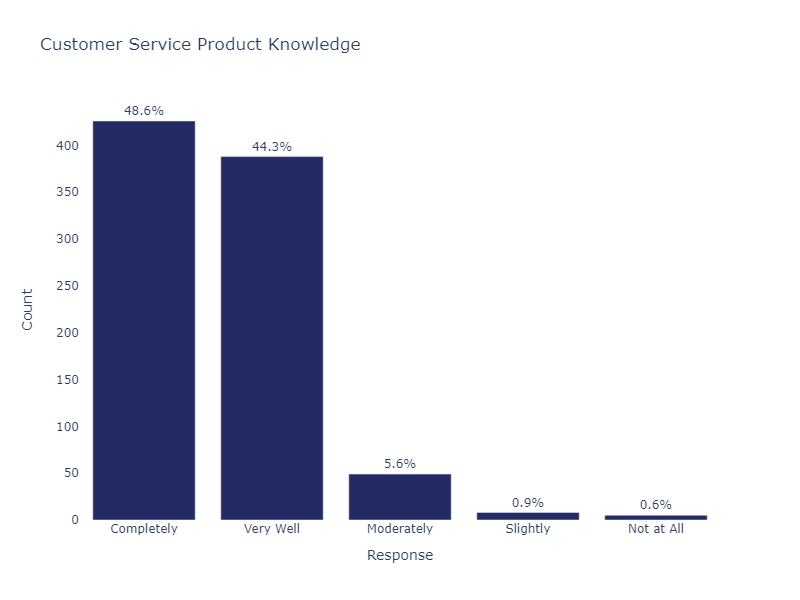

- Of the respondents, when asked how well our customer service understood the products related to their inquiry:  (From 876 responses)
    - Completely: **(49%)**
    - Very Well: **(44%)**
    - Moderately: **(6%)**
    - Slightly: **(1%)**
    - Not at All: **(1%)**


In [65]:
column_data = all_responses[all_responses.columns[67]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Product Knowledge',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service_help.png")
display(Image(filename="./IMG/customer_service_help.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how well our customer service understood the products related to their inquiry:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

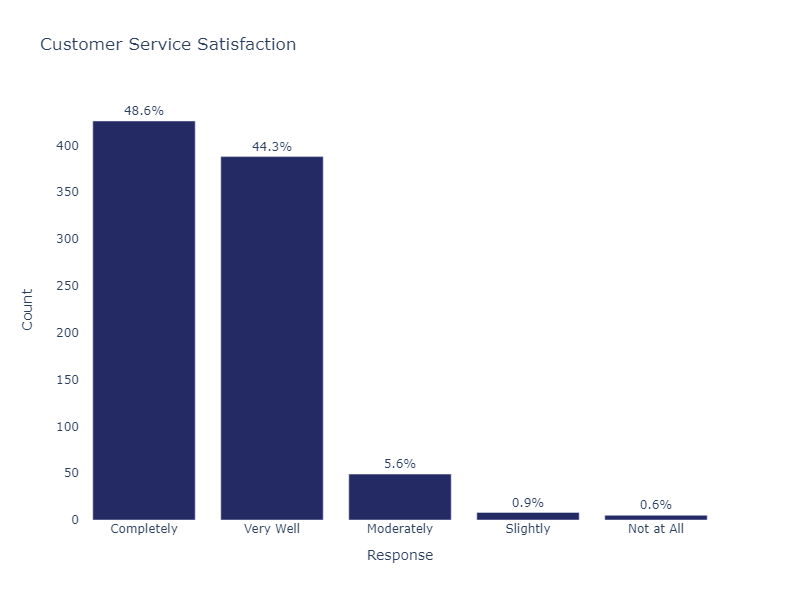

- Of the respondents, when asked how satisfied they were with out customer service:  (From 876 responses)
    - Completely: **(49%)**
    - Very Well: **(44%)**
    - Moderately: **(6%)**
    - Slightly: **(1%)**
    - Not at All: **(1%)**


In [66]:
column_data = all_responses[all_responses.columns[67]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Satisfaction',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service_satisfaction.png")
display(Image(filename="./IMG/customer_service_satisfaction.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how satisfied they were with out customer service:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

<div style="page-break-after: always;">
   
</div>

<div style="text-align: center;">

<h1>Crochet.com</h1>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    This section will focus on questions answered by Crochet.com respondents, and the questions unique to Crochet.com.
</div>

In [67]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')
# Filter rows where the value in the column at index 25 is 'Knit Picks'
all_responses = all_responses[all_responses.iloc[:, 25] == 'Crochet.com']

## Demographic Summary

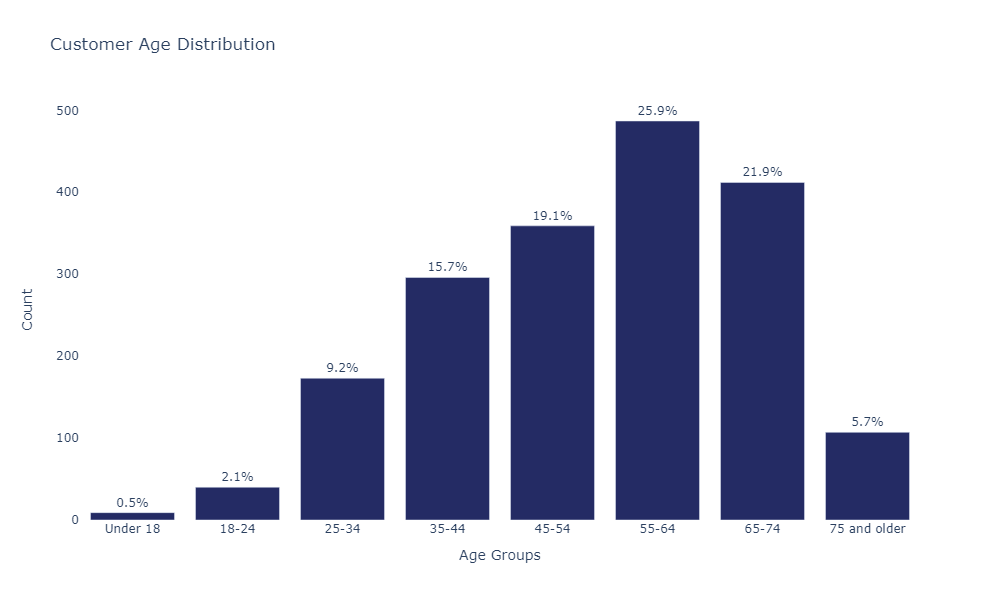

 - Out of **1883** respondents, the average respondent age is: **53** and the median age is: **59**. (From 1883 responses)

- Of these respondents, they identify as: (From 1883 responses)
    - Woman: **97.3%**
    - Non-Conforming / Non-Binary: **1.4%**
    - Man: **1.1%**
    - Transgender: **0.2%**


- The average household income ranges from **\$69,381** to **\$88,779**. (From 1463 responses)
  - For ages **Under 18**: the average is between **\$6,667** and **\$18,333**.
  - For ages **18-24**: the average is between **\$44,200** and **\$60,799**.
  - For ages **25-34**: the average is between **\$72,014** and **\$92,553**.
  - For ages **35-44**: the average is between **\$87,864** and **\$110,140**.
  - For ages **45-54**: the average is between **\$89,449** and **\$111,856**.
  - For ages **55-64**: the average is between **\$69,799** and **\$89,597**.
  - For ages **65-74**: the average is between **\$52,729** and **\$69,621**.
  - For ages **75 and older**: the average is between **\$52,338** and **\$69,674**.


In [68]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[75]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Groups',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondents, the average respondent age is: **{average_age}** and the median age is: **{median_age}**. (From {sample_size} responses)" ))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[76]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = f"- Of these respondents, they identify as: (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{value:.1f}%**\n"

display(Markdown(markdown_text))

### Income Section ###

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[all_responses.columns[75]] != 'Prefer not to answer') & 
                                        (all_responses[all_responses.columns[80]] != 'Prefer not to answer')]
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[75]], categories=categories, ordered=True)

# Define a new function to extract lower and upper bounds of the income range
def extract_income_range(value):
    if value == 'Under $20,000':
        return (0, 20000)
    elif value == 'Over $200,000':
        return (200000, 250000)
    else:
        lower, upper = value.replace('$', '').split(' - ')
        lower = int(lower.replace(',', ''))
        upper = int(upper.replace(',', ''))
        return (lower, upper)

# Assuming 'question' is the column index for income
question = all_responses.columns[80]

filtered_responses['income_range'] = filtered_responses[question].apply(lambda x: extract_income_range(x) if isinstance(x, str) else (0,0))
filtered_responses[['income_lower', 'income_upper']] = pd.DataFrame(filtered_responses['income_range'].tolist(), index=filtered_responses.index)

age_income_ranges = filtered_responses.groupby('age_range', observed=True).agg(
    average_lowerbound=pd.NamedAgg(column='income_lower', aggfunc='mean'),
    average_upperbound=pd.NamedAgg(column='income_upper', aggfunc='mean'),
    responses=pd.NamedAgg(column='income_lower', aggfunc='count')
).reset_index()

# Calculate overall average lower and upper bounds
overall_avg_lowerbound = filtered_responses['income_lower'].mean()
overall_avg_upperbound = filtered_responses['income_upper'].mean()
total_responses = filtered_responses['income_lower'].count()

# Formatting the overall averages for markdown_part1
formatted_avg_lower = "${:,.0f}".format(overall_avg_lowerbound)
formatted_avg_upper = "${:,.0f}".format(overall_avg_upperbound)

# Constructing markdown_part1 with the overall averages
markdown_part1 = f"- The average household income ranges from **\{formatted_avg_lower}** to **\{formatted_avg_upper}**. (From {total_responses} responses)"

# Initialize markdown_part2
markdown_part2 = ""
for _, row in age_income_ranges.iterrows():
    age_range = row['age_range']
    avg_lower = "${:,.0f}".format(row['average_lowerbound'])
    avg_upper = "${:,.0f}".format(row['average_upperbound'])
    responses = row['responses']
    markdown_part2 += f"  - For ages **{age_range}**: the average is between **\{avg_lower}** and **\{avg_upper}**.\n"

# Combining both parts
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

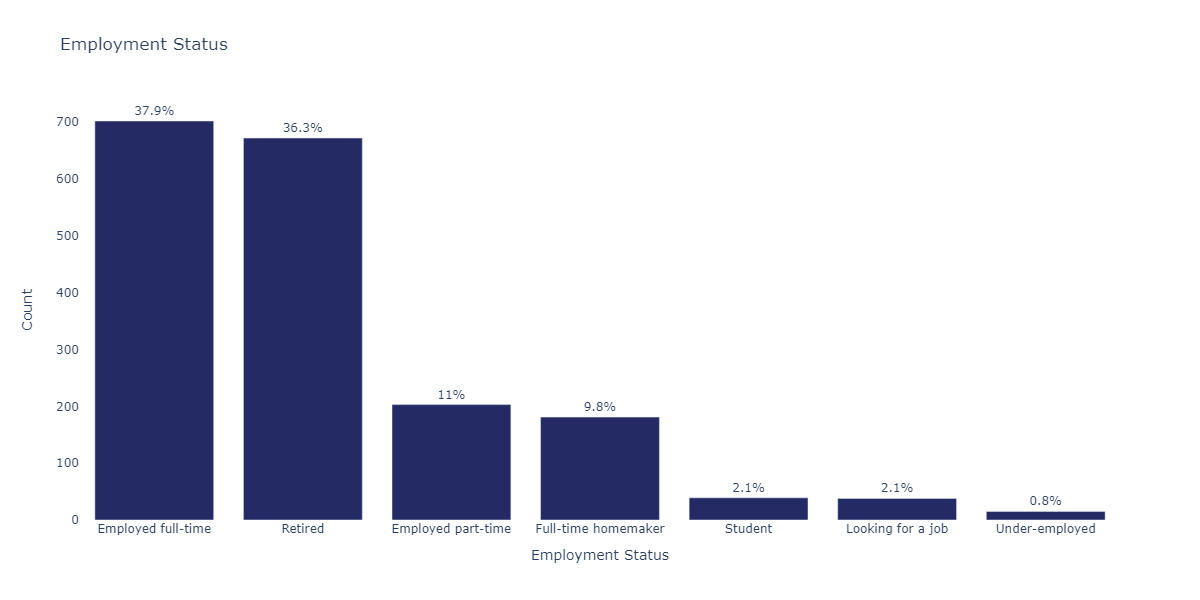

- Of the respondents, their employment statuses are as follows:  (From 1850 responses)
    - Employed full-time: **38%**
    - Retired: **36%**
    - Employed part-time: **11%**
    - Full-time homemaker: **10%**
    - Student: **2%**
    - Looking for a job: **2%**
    - Under-employed: **1%**


In [69]:
### Employment ###
question = all_responses.columns[77]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Employment Status',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1200
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, their employment statuses are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{round(value)}%**\n"

display(Markdown(markdown_text))

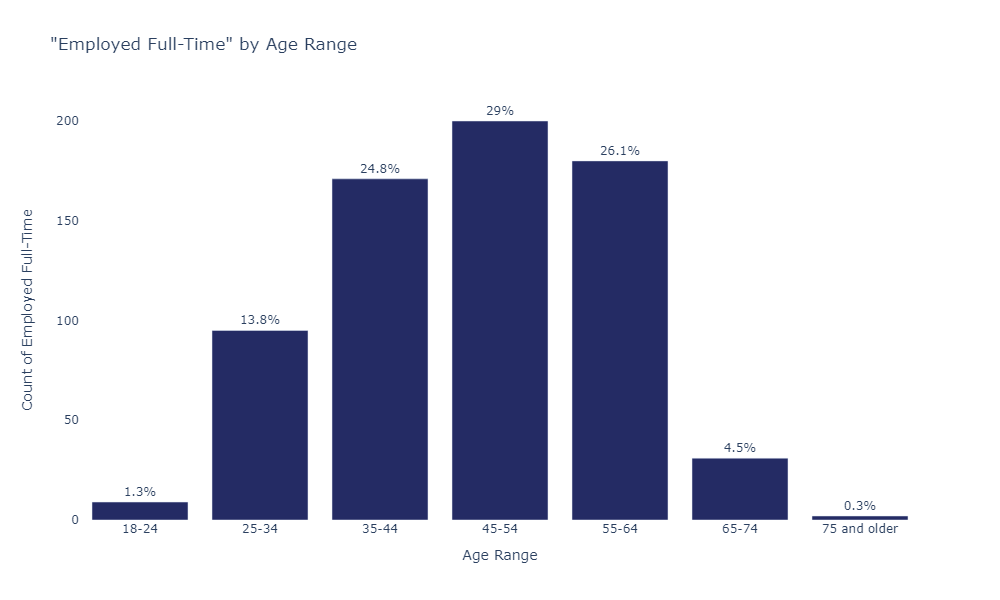

- Of those who responded 'Employed Full-Time': (From 702 responses.)
    - For ages 45-54: **29.0%**
    - For ages 55-64: **26.1%**
    - For ages 35-44: **24.8%**
    - For ages 25-34: **13.8%**
    - For ages 65-74: **4.5%**
    - For ages 18-24: **1.3%**
    - For ages 75 and older: **0.3%**


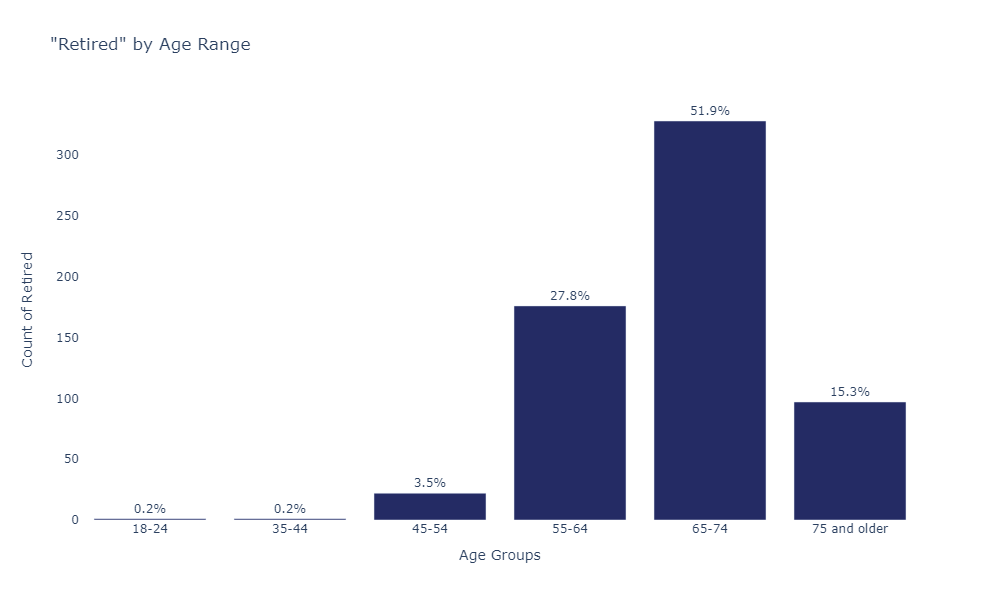

- Of those who responded 'Retired': (From 672 responses.)
    - For ages 65-74: **51.9%**
    - For ages 55-64: **27.8%**
    - For ages 75 and older: **15.3%**
    - For ages 45-54: **3.5%**
    - For ages 18-24: **0.2%**
    - For ages 35-44: **0.2%**


In [70]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[75]
employment_status_column = all_responses.columns[77]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']
sample_size = employed_full_time.shape[0]

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Employed Full-Time': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - For ages {age_group}: **{percentage}%**\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']
sample_size = retired.shape[0]

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Groups',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Retired': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - For ages {age_group}: **{percentage}%**\n"

display(Markdown(markdown_text))


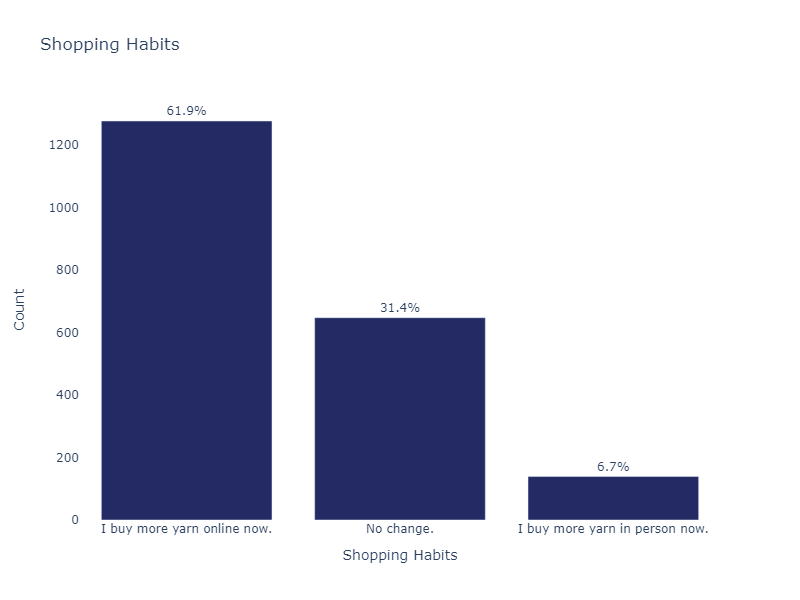

- Of the respondents, they reported that their shopping habbits have changed:  (From 2062 responses)
    - I buy more yarn online now.: **62%**
    - No change.: **31%**
    - I buy more yarn in person now.: **7%**


In [71]:
### Employment ###
question = all_responses.columns[20]

column_data = all_responses[all_responses.columns[20]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Shopping Habits',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Habits',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/shopping_habbits.png")
display(Image(filename="./IMG/shopping_habbits.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, they reported that their shopping habbits have changed:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{round(value)}%**\n"

display(Markdown(markdown_text))

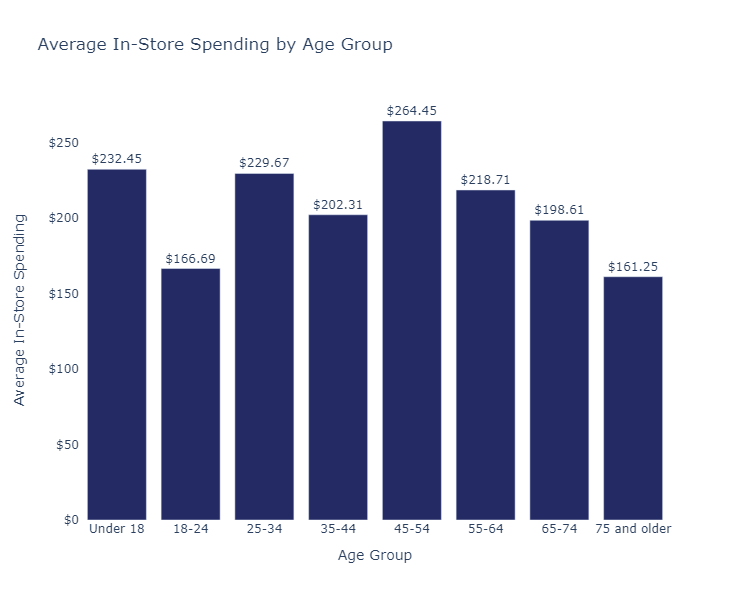

- Respondents reported making **5.0** purchases in-store per year on average, spending an average **\$42.56** per visit. On average spending **\$213.01** a year. (From 1953 responses.)
     - For ages 'Under 18': **4.9** purchases in-store per year, spending **\$47.86** per visit. On average spending **\$232.45** a year.
     - For ages '18-24': **5.3** purchases in-store per year, spending **\$31.45** per visit. On average spending **\$166.69** a year.
     - For ages '25-34': **5.0** purchases in-store per year, spending **\$45.93** per visit. On average spending **\$229.67** a year.
     - For ages '35-44': **4.6** purchases in-store per year, spending **\$44.42** per visit. On average spending **\$202.31** a year.
     - For ages '45-54': **5.7** purchases in-store per year, spending **\$46.33** per visit. On average spending **\$264.45** a year.
     - For ages '55-64': **5.2** purchases in-store per year, spending **\$42.32** per visit. On average spending **\$218.71** a year.
     - For ages '65-74': **4.9** purchases in-store per year, spending **\$40.60** per visit. On average spending **\$198.61** a year.
     - For ages '75 and older': **4.3** purchases in-store per year, spending **\$37.33** per visit. On average spending **\$161.25** a year.

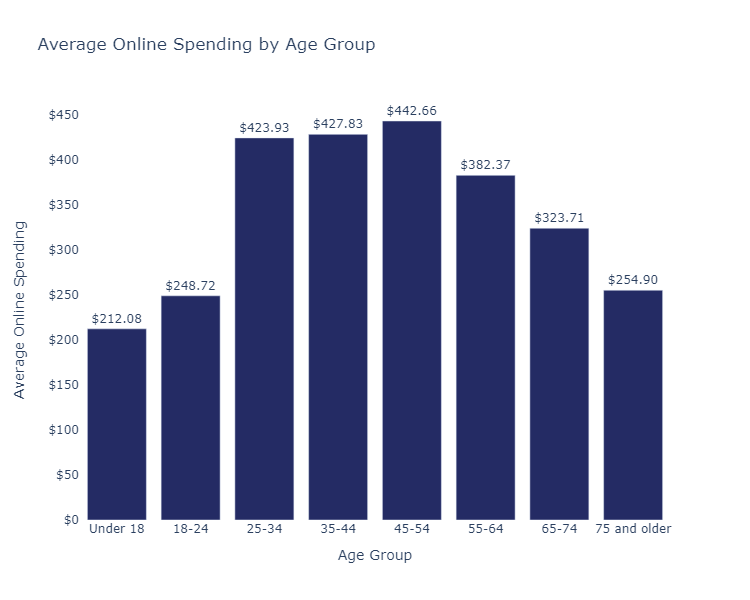

- Respondents reported making **5.7** purchases online per year on average, spending an average **\$65.87** per visit. On average spending **\$374.12** a year. (From 1977 responses.)
     - For ages 'Under 18': **3.4** purchases in-store per year, spending **\$61.86** per visit. On average spending **\$212.08** a year.
     - For ages '18-24': **5.2** purchases in-store per year, spending **\$47.38** per visit. On average spending **\$248.72** a year.
     - For ages '25-34': **5.8** purchases in-store per year, spending **\$73.23** per visit. On average spending **\$423.93** a year.
     - For ages '35-44': **5.7** purchases in-store per year, spending **\$74.55** per visit. On average spending **\$427.83** a year.
     - For ages '45-54': **6.2** purchases in-store per year, spending **\$71.97** per visit. On average spending **\$442.66** a year.
     - For ages '55-64': **5.9** purchases in-store per year, spending **\$65.07** per visit. On average spending **\$382.37** a year.
     - For ages '65-74': **5.6** purchases in-store per year, spending **\$58.19** per visit. On average spending **\$323.71** a year.
     - For ages '75 and older': **4.9** purchases in-store per year, spending **\$52.49** per visit. On average spending **\$254.90** a year.

In [72]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24], all_responses.columns[75]]]], axis=1)

# Clean up entries of "10+"
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))

# Clean up entries of "200+" and remove $.
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
filtered_df = share_of_wallet[share_of_wallet.iloc[:, 4] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
filtered_df[filtered_df.columns[4]] = pd.Categorical(filtered_df[filtered_df.columns[4]], categories=ages, ordered=True)

# Convert 'Age Group' column to a categorical type with specified order
filtered_df['Age Group'] = filtered_df[filtered_df.columns[4]]
filtered_df['Age Group'] = pd.Categorical(filtered_df['Age Group'], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_instore_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_instore_by_group = total_instore_by_group.reset_index().rename(columns={0: 'Total In-Store'})

# Create the bar graph
fig = px.bar(total_instore_by_group, x='Age Group', y='Total In-Store', title='Average In-Store Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_instore_by_group['Total In-Store']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average In-Store Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/instore_spend_by_age.png")
display(Image(filename="./IMG/instore_spend_by_age.png"))

# Markdown variables
sample_size_instore = share_of_wallet.iloc[:, 0].dropna().count()
avg_purchases_instore = share_of_wallet.iloc[:, 0].astype(float).mean()
avg_spending_instore = share_of_wallet.iloc[:, 1].astype(float).mean()
total_instore = avg_purchases_instore * avg_spending_instore

markdown_part1 = f"- Respondents reported making **{avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${avg_spending_instore:.2f}** per visit. On average spending **\${total_instore:.2f}** a year. (From {sample_size_instore} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_instore = frame.iloc[:, 0].dropna().count()
    group_avg_purchases_instore = frame.iloc[:, 0].astype(float).mean()
    group_avg_spending_instore = frame.iloc[:, 1].astype(float).mean()
    group_total_instore = group_avg_purchases_instore * group_avg_spending_instore
    # Append the group metrics to the markdown text
    markdown_part1 += f"\n     - For ages '{group}': **{group_avg_purchases_instore:.1f}** purchases in-store per year, spending **\${group_avg_spending_instore:.2f}** per visit. On average spending **\${group_total_instore:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part1))

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[2]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[3]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_online_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_online_by_group = total_online_by_group.reset_index().rename(columns={0: 'Total Online'})

# Create the bar graph
fig = px.bar(total_online_by_group, x='Age Group', y='Total Online', title='Average Online Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_online_by_group['Total Online']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Online Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/online_spend_by_age.png")
display(Image(filename="./IMG/online_spend_by_age.png"))

# Markdown variables
sample_size_online = share_of_wallet.iloc[:, 2].dropna().count()
avg_purchases_online = share_of_wallet.iloc[:, 2].astype(float).mean()
avg_spending_online = share_of_wallet.iloc[:, 3].astype(float).mean()
total_online = avg_purchases_online * avg_spending_online

markdown_part2 = f"- Respondents reported making **{avg_purchases_online:.1f}** purchases online per year on average, spending an average **\${avg_spending_online:.2f}** per visit. On average spending **\${total_online:.2f}** a year. (From {sample_size_online} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_online = frame.iloc[:, 2].dropna().count()
    group_avg_purchases_online = frame.iloc[:, 2].astype(float).mean()
    group_avg_spending_online = frame.iloc[:, 3].astype(float).mean()
    group_total_online = group_avg_purchases_online * group_avg_spending_online
    # Append the group metrics to the markdown text
    markdown_part2 += f"\n     - For ages '{group}': **{group_avg_purchases_online:.1f}** purchases in-store per year, spending **\${group_avg_spending_online:.2f}** per visit. On average spending **\${group_total_online:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part2))

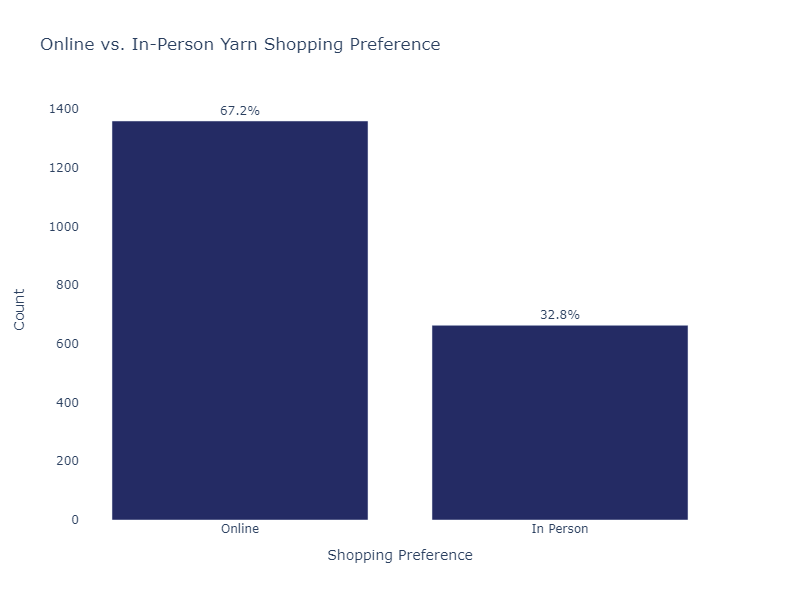

- Of the respondents **62.9%** preferred online shopping for yarn, while **30.68%** preferred shopping in person for yarn. (From 2022 responses.)
     - For ages Under 18: **22.2%** preferred shopping online, **77.8%** preferred shopping in person.
     - For ages 18-24: **62.5%** preferred shopping online, **37.5%** preferred shopping in person.
     - For ages 25-34: **71.7%** preferred shopping online, **26.6%** preferred shopping in person.
     - For ages 35-44: **74.7%** preferred shopping online, **24.0%** preferred shopping in person.
     - For ages 45-54: **66.0%** preferred shopping online, **30.4%** preferred shopping in person.
     - For ages 55-64: **64.5%** preferred shopping online, **33.5%** preferred shopping in person.
     - For ages 65-74: **59.7%** preferred shopping online, **36.2%** preferred shopping in person.
     - For ages 75 and older: **59.8%** preferred shopping online, **36.4%** preferred shopping in person.

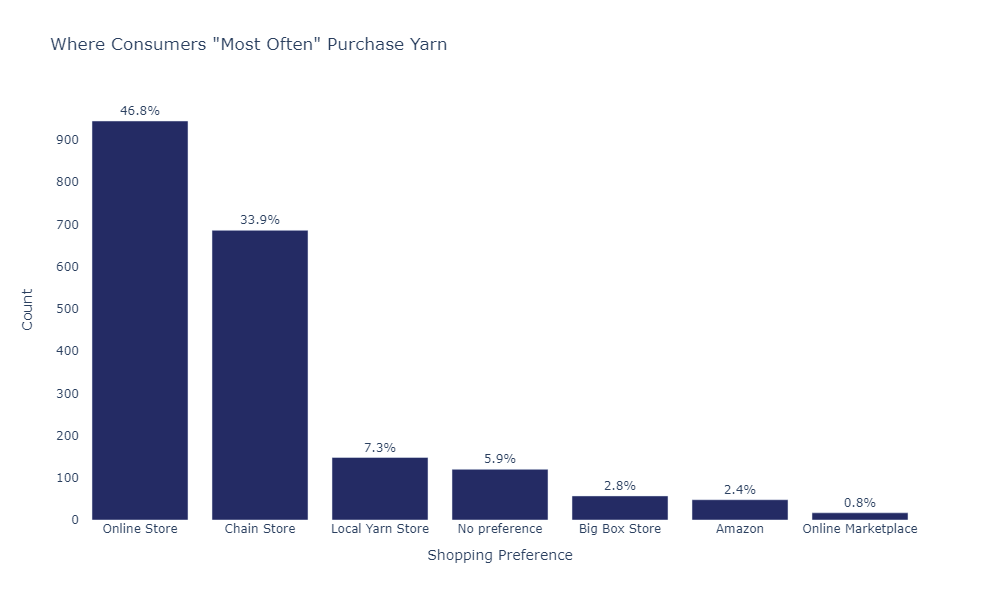

In [73]:
question = all_responses.columns[14]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Yarn Shopping Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_shopping.png")
display(Image(filename="./IMG/yarn_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[14], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for yarn, while **{inperson_percent:.2f}%** preferred shopping in person for yarn. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[15]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/yarn_shopping_location.png")
display(Image(filename="./IMG/yarn_shopping_location.png"))

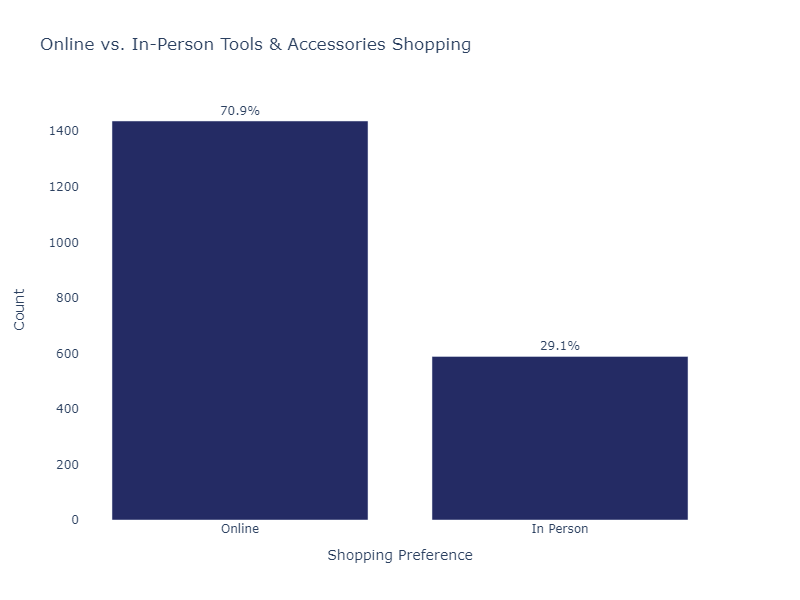

- Of the respondents **66.5%** preferred online shopping for tools & accessories, while **27.26%** preferred shopping in person for tools & accessories. (From 2026 responses.)
     - For ages Under 18: **44.4%** preferred shopping online, **55.6%** preferred shopping in person.
     - For ages 18-24: **67.5%** preferred shopping online, **32.5%** preferred shopping in person.
     - For ages 25-34: **71.7%** preferred shopping online, **26.6%** preferred shopping in person.
     - For ages 35-44: **80.1%** preferred shopping online, **18.9%** preferred shopping in person.
     - For ages 45-54: **72.1%** preferred shopping online, **25.3%** preferred shopping in person.
     - For ages 55-64: **68.8%** preferred shopping online, **28.7%** preferred shopping in person.
     - For ages 65-74: **65.5%** preferred shopping online, **31.3%** preferred shopping in person.
     - For ages 75 and older: **60.7%** preferred shopping online, **35.5%** preferred shopping in person.

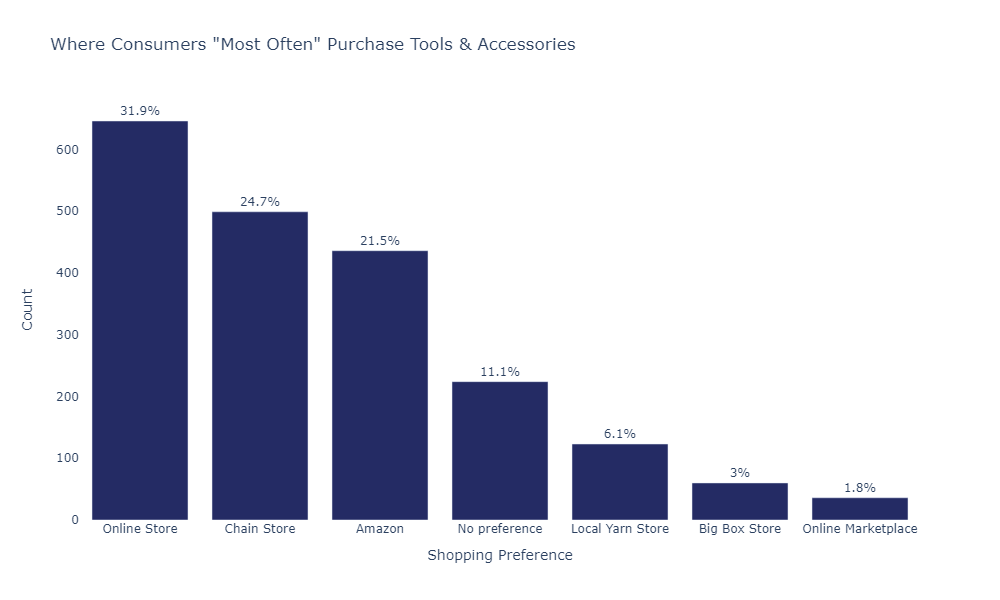

In [74]:
question = all_responses.columns[16]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Tools & Accessories Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping.png")
display(Image(filename="./IMG/tool_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[16], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for tools & accessories, while **{inperson_percent:.2f}%** preferred shopping in person for tools & accessories. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[17]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Tools & Accessories',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/tool_shopping_location.png")
display(Image(filename="./IMG/tool_shopping_location.png"))

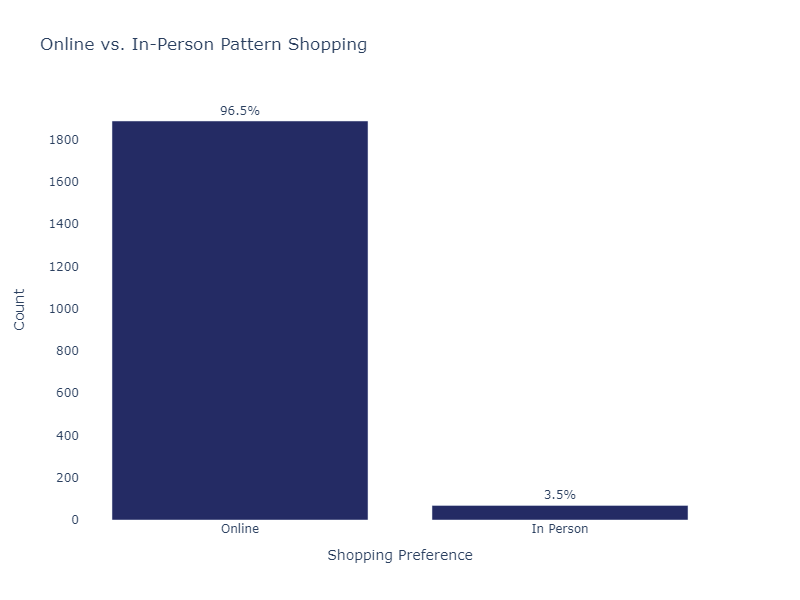

- Of the respondents **87.4%** preferred online shopping for patterns, while **3.19%** preferred shopping in person for patterns. (From 1958 responses.)
     - For ages Under 18: **66.7%** preferred shopping online, **11.1%** preferred shopping in person.
     - For ages 18-24: **92.5%** preferred shopping online, **0.0%** preferred shopping in person.
     - For ages 25-34: **96.0%** preferred shopping online, **0.6%** preferred shopping in person.
     - For ages 35-44: **96.3%** preferred shopping online, **1.7%** preferred shopping in person.
     - For ages 45-54: **95.3%** preferred shopping online, **1.4%** preferred shopping in person.
     - For ages 55-64: **91.4%** preferred shopping online, **2.3%** preferred shopping in person.
     - For ages 65-74: **85.4%** preferred shopping online, **7.0%** preferred shopping in person.
     - For ages 75 and older: **85.0%** preferred shopping online, **6.5%** preferred shopping in person.

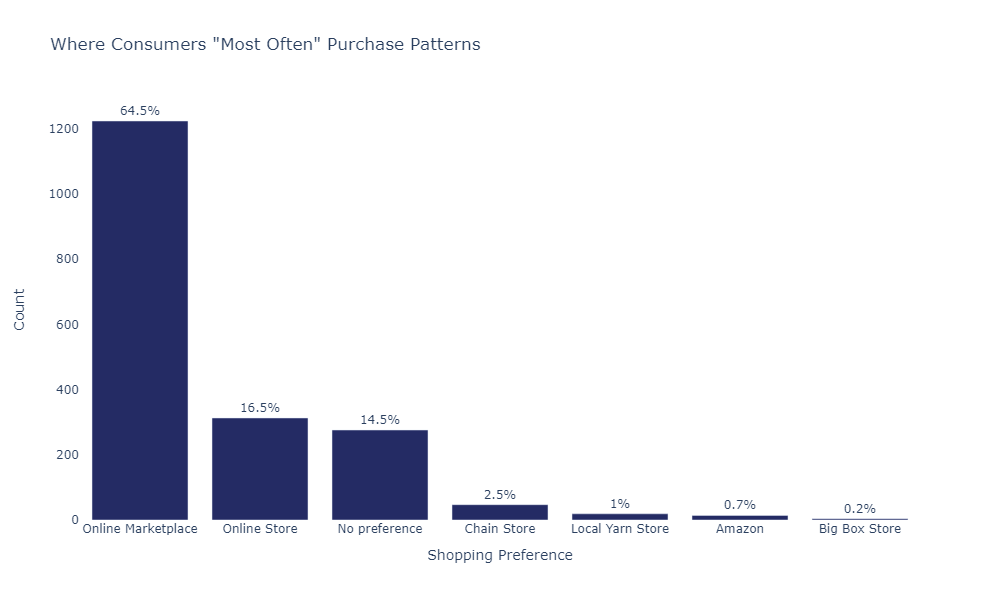

In [75]:
question = all_responses.columns[18]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Pattern Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/pattern_shopping.png")
display(Image(filename="./IMG/pattern_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[18], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for patterns, while **{inperson_percent:.2f}%** preferred shopping in person for patterns. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[19]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Patterns',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping_location.png")
display(Image(filename="./IMG/pattern_shopping_location.png"))

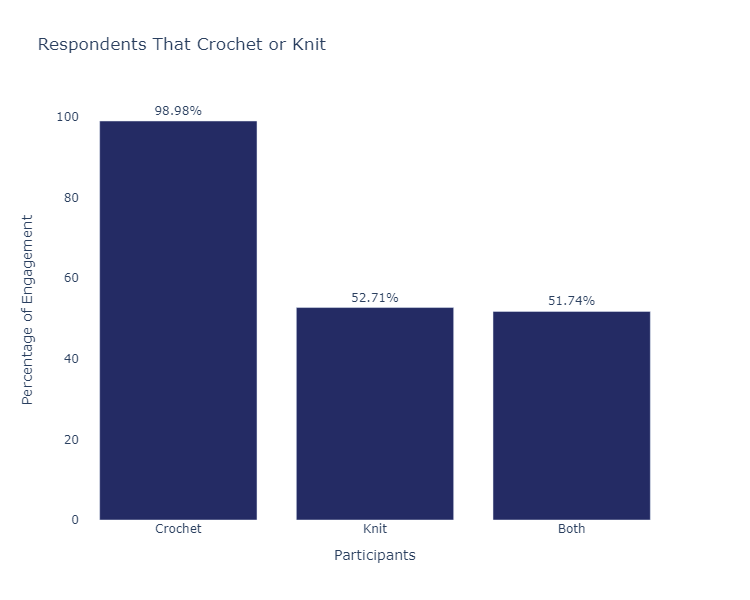

- Of the respondents, **99.0%** responded 'Yes' to crocheting, **52.71%** responded 'Yes' to knitting, while **51.74%** of respondents engage in both. (From 2161 responses.)
     - For ages Under 18, **100.0%** crochet, **44.4%** knit, and **44.4%** do both.
     - For ages 18-24, **100.0%** crochet, **50.0%** knit, and **50.0%** do both.
     - For ages 25-34, **98.3%** crochet, **51.4%** knit, and **49.7%** do both.
     - For ages 35-44, **98.3%** crochet, **54.4%** knit, and **52.7%** do both.
     - For ages 45-54, **98.6%** crochet, **51.8%** knit, and **50.4%** do both.
     - For ages 55-64, **99.2%** crochet, **47.2%** knit, and **46.4%** do both.
     - For ages 65-74, **99.0%** crochet, **58.3%** knit, and **57.5%** do both.
     - For ages 75 and older, **100.0%** crochet, **69.2%** knit, and **69.2%** do both.

In [76]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[4], all_responses.columns[7], all_responses.columns[75]]]], axis=1)

percent_yes = column_data[['Do you crochet?', 'Do you knit?']].apply(lambda x: (x == 'Yes').mean()) * 100
both_yes_percent = column_data[(column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')].shape[0] / column_data.shape[0] * 100
 
data = {'Crafting Type': ['Crochet', 'Knit'], 'Percentage': percent_yes.values}

# Update the data dictionary to include the new category
data['Crafting Type'].append('Both')
data['Percentage'] = np.append(data['Percentage'], both_yes_percent)

df = pd.DataFrame(data)

fig = px.bar(
    df,
    x='Crafting Type',
    y='Percentage',
    text='Percentage',
    title='Respondents That Crochet or Knit',
    color_discrete_sequence=['#242B64']
)

# Adding text on bars for the percentage value
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Participants',
    yaxis_title='Percentage of Engagement',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750
)

# Save and display the figure
fig.write_image("./IMG/crafting_participation.png")
display(Image(filename="./IMG/crafting_participation.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Variables
# Overall percentage of respondents who answered 'Yes' to crocheting
crochet_yes_percent = (column_data['Do you crochet?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to knitting
knit_yes_percent = (column_data['Do you knit?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to both crocheting and knitting
both_yes_percent = ((column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')).mean() * 100
# Total sample size
sample_size = column_data.shape[0]

# Initialize the markdown string
markdown_summary = f"- Of the respondents, **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.2f}%** responded 'Yes' to knitting, while **{both_yes_percent:.2f}%** of respondents engage in both. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data['What is your current age?  '] == age]
    
    # Calculate the percentages and sample size for the current age group
    crochet_yes_percent = (age_group_df['Do you crochet?'] == 'Yes').mean() * 100
    knit_yes_percent = (age_group_df['Do you knit?'] == 'Yes').mean() * 100
    both_yes_percent = ((age_group_df['Do you crochet?'] == 'Yes') & (age_group_df['Do you knit?'] == 'Yes')).mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}, **{crochet_yes_percent:.1f}%** crochet, **{knit_yes_percent:.1f}%** knit, and **{both_yes_percent:.1f}%** do both."

# Display the markdown summary
# Display the markdown text
display(Markdown(markdown_summary))

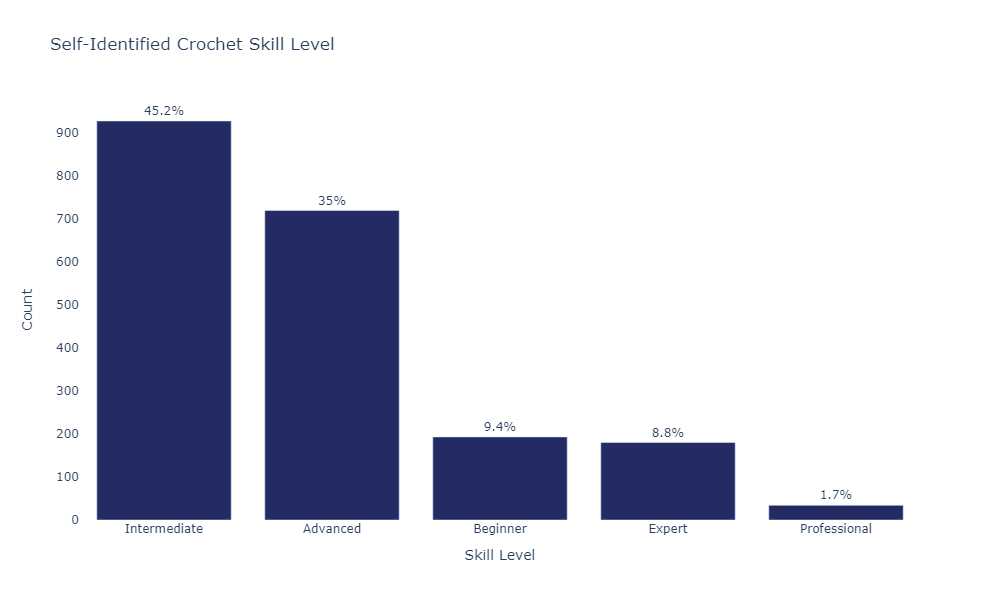

- Of the respondents who crochet, they rate their skill level as the following: (From 2139 responses.)
    - Intermediate: **45.15%**.
    - Advanced: **35.02%**.
    - Beginner: **9.40%**.
    - Expert: **8.77%**.
    - Professional: **1.66%**.


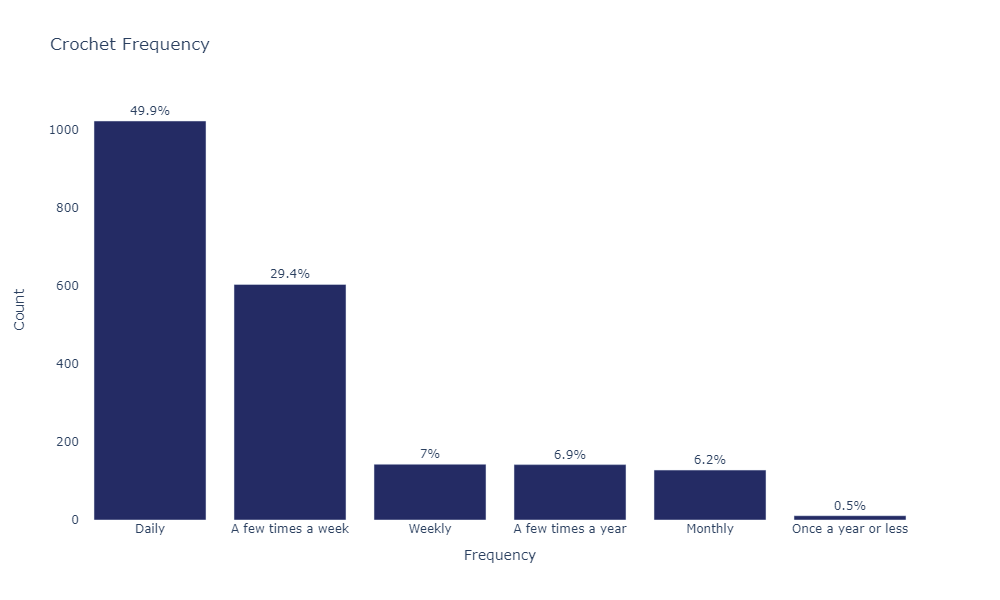

- Of the respondents who crochet, the frequency they do so is: (From 2139 responses.)
    -  Daily: **49.88%**
    -  A few times a week: **29.45%**
    -  Weekly: **6.97%**
    -  A few times a year: **6.92%**
    -  Monthly: **6.24%**
    -  Once a year or less: **0.54%**


In [77]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who crochet, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Crochet Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)
)

# Show the figure
fig.write_image("./IMG/crochet_frequency.png")
display(Image(filename="./IMG/crochet_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who crochet, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    -  {answer}: **{percentage:.2f}%**\n"
    
display(Markdown(markdown_summary))

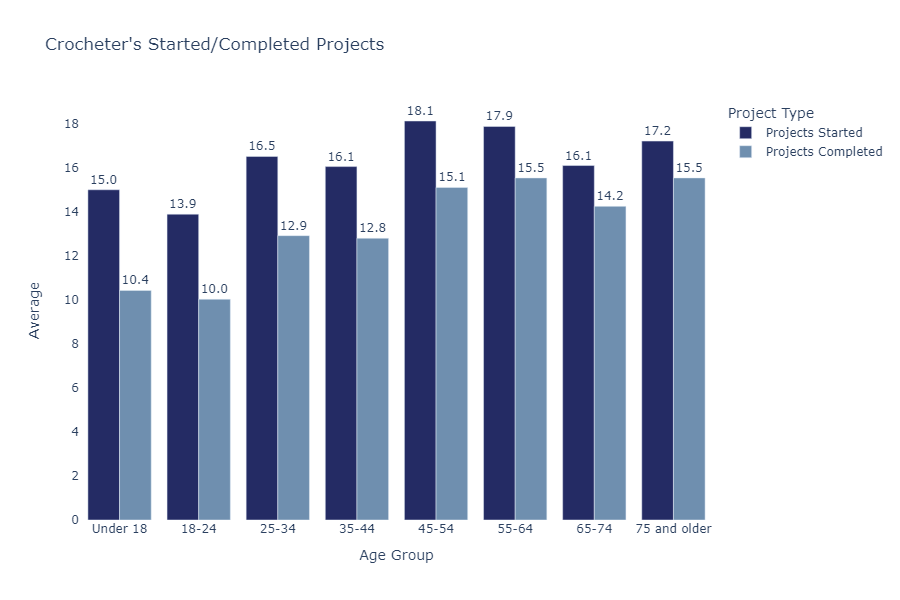

- Of the respondents, on average they start **17.0** crochet projects a year, and on average they complete **14.4** crochet projects a year. (From 2139 responses.)
     - For ages Under 18: They start **15.0** projects, and complete **10.4** projects a year.
     - For ages 18-24: They start **13.9** projects, and complete **10.0** projects a year.
     - For ages 25-34: They start **16.5** projects, and complete **12.9** projects a year.
     - For ages 35-44: They start **16.1** projects, and complete **12.8** projects a year.
     - For ages 45-54: They start **18.1** projects, and complete **15.1** projects a year.
     - For ages 55-64: They start **17.9** projects, and complete **15.5** projects a year.
     - For ages 65-74: They start **16.1** projects, and complete **14.2** projects a year.
     - For ages 75 and older: They start **17.2** projects, and complete **15.5** projects a year.

In [78]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Crocheter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/crochet_projects.png")
display(Image(filename="./IMG/crochet_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondents, on average they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: They start **{projects_started:.1f}** projects, and complete **{projects_completed:.1f}** projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

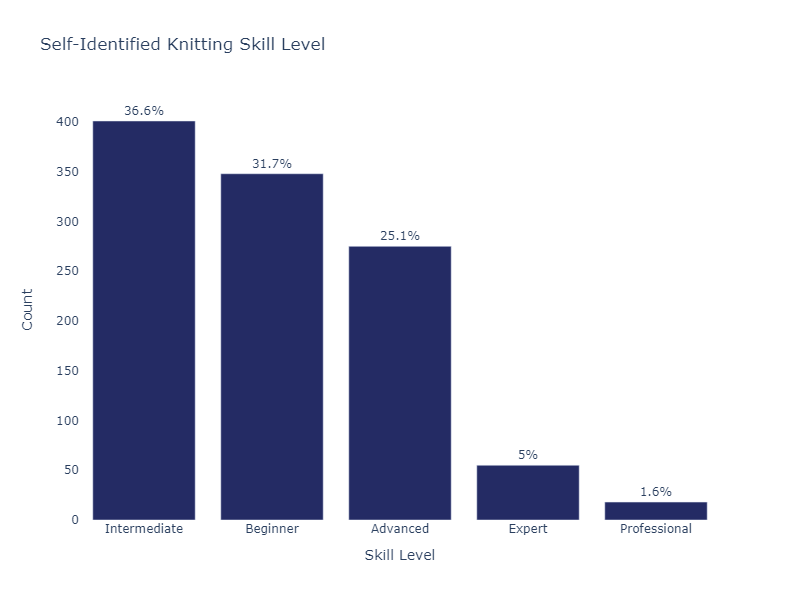

- Of the respondents who knit, they rate their skill level as the following: (From 1139 responses.)
    - Intermediate: **36.55%**.
    - Beginner: **31.72%**.
    - Advanced: **25.07%**.
    - Expert: **5.01%**.
    - Professional: **1.64%**.


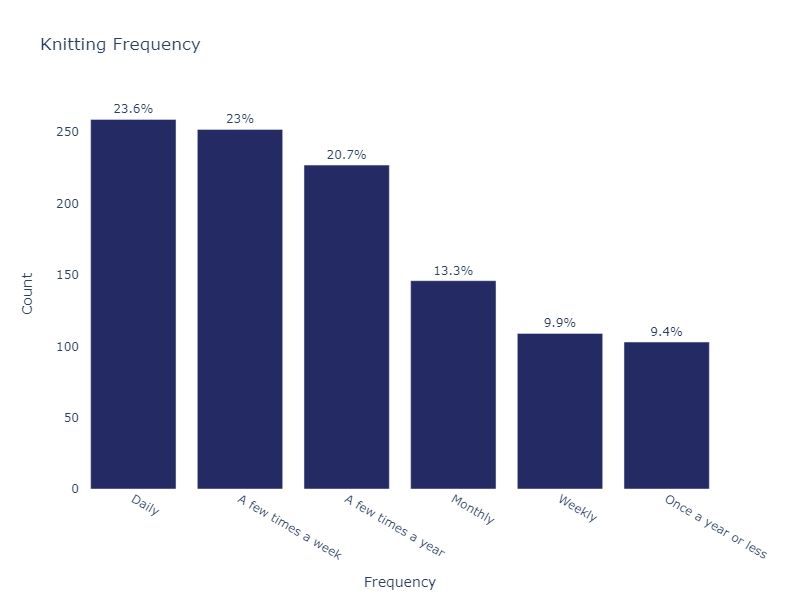

- Of the respondents who knit, the frequency they do so is: (From 1139 responses.)
    - Daily: **23.63%**.
    - A few times a week: **22.99%**.
    - A few times a year: **20.71%**.
    - Monthly: **13.32%**.
    - Weekly: **9.95%**.
    - Once a year or less: **9.40%**.


In [79]:
# Knitting Skill Level

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[8], all_responses.columns[9], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Knitting Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_skill.png")
display(Image(filename="./IMG/knitting_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who knit, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Knitting Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_frequency.png")
display(Image(filename="./IMG/knitting_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who knit, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

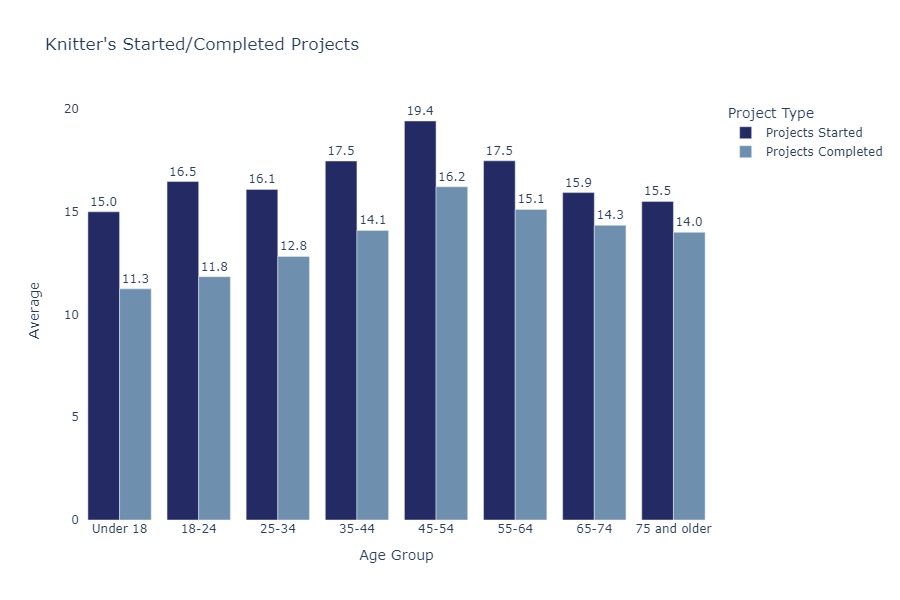

- Of the respondents, on average they start **17.2** knitting projects a year, and on average they complete **14.6** knitting projects a year. (From 1139 responses.)
     - For ages Under 18: They start **15.0** projects, and complete **11.2** projects a year.
     - For ages 18-24: They start **16.5** projects, and complete **11.8** projects a year.
     - For ages 25-34: They start **16.1** projects, and complete **12.8** projects a year.
     - For ages 35-44: They start **17.5** projects, and complete **14.1** projects a year.
     - For ages 45-54: They start **19.4** projects, and complete **16.2** projects a year.
     - For ages 55-64: They start **17.5** projects, and complete **15.1** projects a year.
     - For ages 65-74: They start **15.9** projects, and complete **14.3** projects a year.
     - For ages 75 and older: They start **15.5** projects, and complete **14.0** projects a year.

In [80]:
# Knitting Projects 

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Knitter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/knitting_projects.png")
display(Image(filename="./IMG/knitting_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondents, on average they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: They start **{projects_started:.1f}** projects, and complete **{projects_completed:.1f}** projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

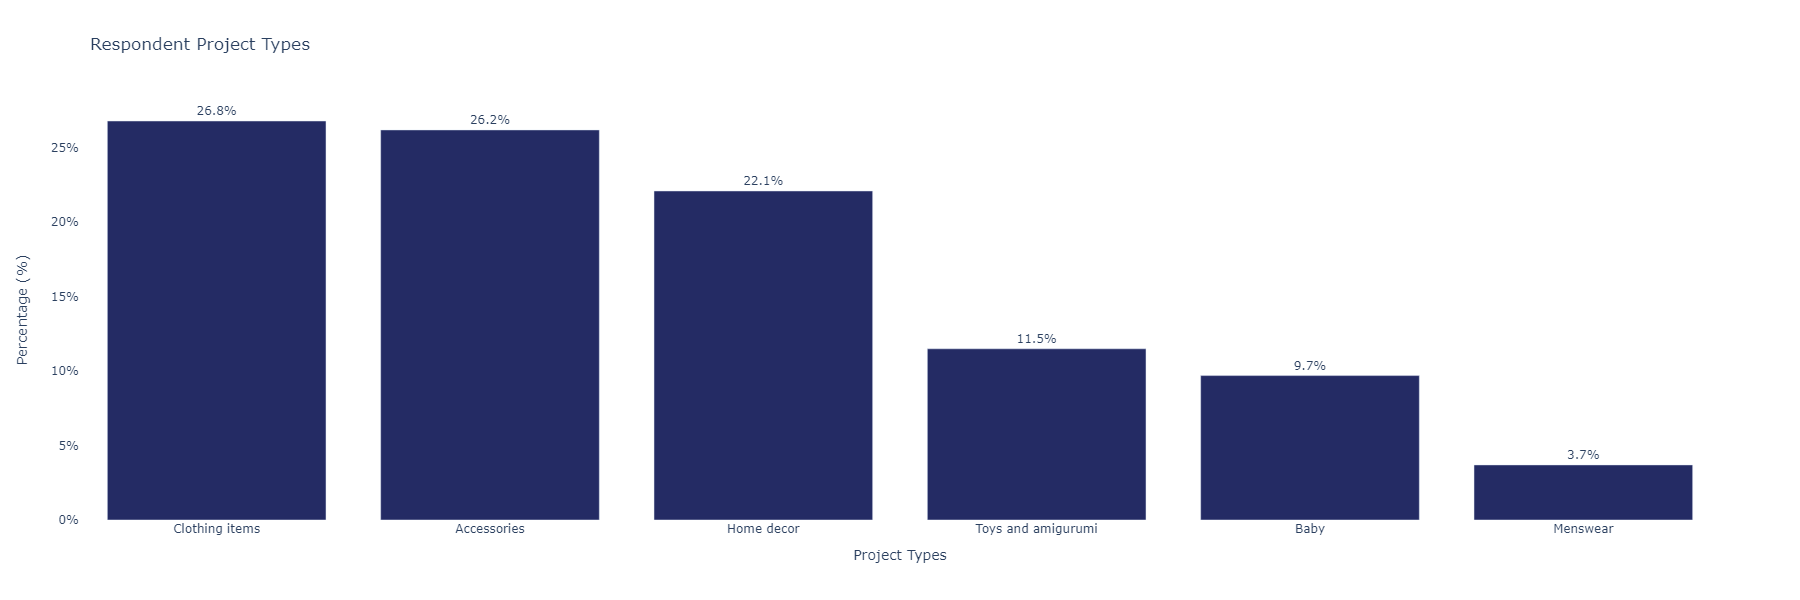

- Of the respondents, the most popular project type for all yarn crafts is: (From 1139 responses.)
     - For ages Under 18: The most popular types are **Clothing items** **(47.1%)**, then **Toys and amigurumi** **(23.5%)**, and finally **Accessories** **(23.5%)**.
     - For ages 18-24: The most popular types are **Clothing items** **(34.9%)**, then **Accessories** **(19.3%)**, and finally **Toys and amigurumi** **(18.1%)**.
     - For ages 25-34: The most popular types are **Clothing items** **(29.5%)**, then **Accessories** **(23.9%)**, and finally **Home decor** **(20.2%)**.
     - For ages 35-44: The most popular types are **Clothing items** **(28.1%)**, then **Accessories** **(26.1%)**, and finally **Home decor** **(19.6%)**.
     - For ages 45-54: The most popular types are **Clothing items** **(28.2%)**, then **Accessories** **(25.4%)**, and finally **Home decor** **(22.0%)**.
     - For ages 55-64: The most popular types are **Accessories** **(26.7%)**, then **Clothing items** **(25.2%)**, and finally **Home decor** **(25.1%)**.
     - For ages 65-74: The most popular types are **Accessories** **(27.3%)**, then **Clothing items** **(24.9%)**, and finally **Home decor** **(22.5%)**.
     - For ages 75 and older: The most popular types are **Accessories** **(27.7%)**, then **Clothing items** **(25.1%)**, and finally **Home decor** **(20.3%)**.

In [81]:
# Project Types

# Combining relevant columns into one DataFrame and dropping NaN values
column_data = pd.concat([all_responses[[all_responses.columns[41], all_responses.columns[75]]]], axis=1).dropna()

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Split project types more robustly, considering possible variations in the use of spaces around commas
split_projects = column_data[column_data.columns[0]].str.split(r'\s*,\s*')

# Explode the DataFrame to separate rows for each project type mentioned per response
exploded_projects = split_projects.explode().reset_index(drop=True)

# Filter out empty or whitespace-only project types
exploded_projects = exploded_projects[exploded_projects.str.strip().astype(bool)]

# Count occurrences of each project type
project_counts = exploded_projects.value_counts().reset_index(name='Count')
project_counts.columns = ['Project', 'Count']

# Calculate the percentage of each project's occurrence
total_mentions = project_counts['Count'].sum()
project_counts['Percentage'] = (project_counts['Count'] / total_mentions * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per project type
fig = px.bar(project_counts, x='Project', y='Percentage',
             title='Respondent Project Types',
             labels={'Percentage': 'Percentage (%)', 'Project': 'Project Types'},
             text='Percentage', color_discrete_sequence=['#242B64'])

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    yaxis_ticksuffix="%",
)

# Show the figure
fig.write_image("./IMG/project_type_preference_revised.png")
display(Image(filename="./IMG/project_type_preference_revised.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular project type for all yarn crafts is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Correctly split the project types for the current age group, taking into account spaces around commas
        exploded_projects = age_group_df.iloc[:, 0].str.split(' , ').explode()
        # Calculate the value counts and percentages for the current age group's project types
        percentages = exploded_projects.value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Project', 'Percentage']
        # Check the number of project types to report
        if len(percentages) >= 3:
            # Append the calculated metrics for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: The most popular types are **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]}%)**, and finally **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: The most popular types are **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one project type, mention only the most popular one
            markdown_summary += f"\n     - For ages{age}: The most popular type is **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]}%)**."
        else:
            # If there are no project types, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no project types with significant data."

# Display the markdown text
display(Markdown(markdown_summary))

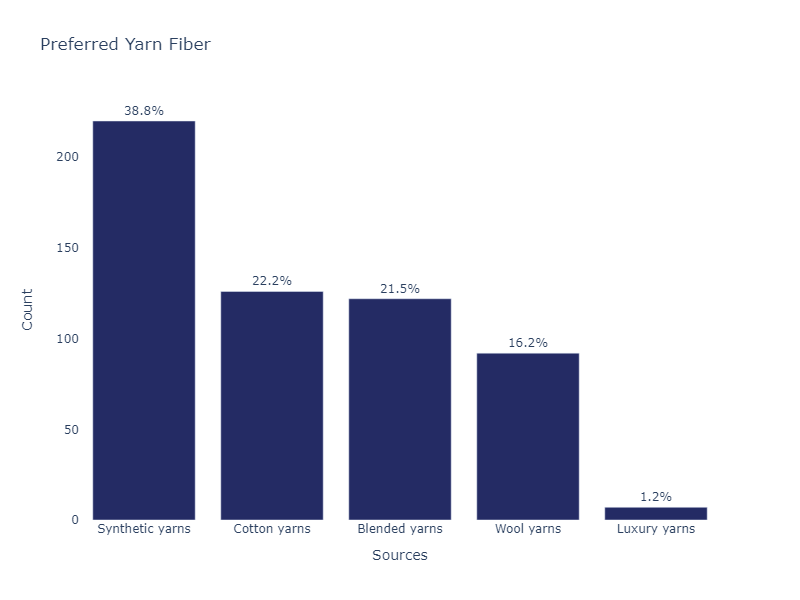

- Of the respondents, their preffered yarn fiber is: (From 567 responses.)
     - For ages Under 18: Preferred **Cotton yarns** **(100.0%)**.
     - For ages 18-24: Preferred **Synthetic yarns** **(70.0%)**, then **Cotton yarns** **(20.0%)**, followed by **Wool yarns** **(10.0%)**.
     - For ages 25-34: Preferred **Synthetic yarns** **(37.0%)**, then **Cotton yarns** **(23.9%)**, followed by **Wool yarns** **(21.7%)**.
     - For ages 35-44: Preferred **Synthetic yarns** **(29.9%)**, then **Wool yarns** **(26.9%)**, followed by **Blended yarns** **(22.4%)**.
     - For ages 45-54: Preferred **Blended yarns** **(26.8%)**, then **Cotton yarns** **(26.8%)**, followed by **Synthetic yarns** **(26.8%)**.
     - For ages 55-64: Preferred **Synthetic yarns** **(40.8%)**, then **Cotton yarns** **(24.3%)**, followed by **Blended yarns** **(20.4%)**.
     - For ages 65-74: Preferred **Synthetic yarns** **(38.6%)**, then **Blended yarns** **(27.6%)**, followed by **Cotton yarns** **(20.5%)**.
     - For ages 75 and older: Preferred **Synthetic yarns** **(51.3%)**, then **Blended yarns** **(20.5%)**, followed by **Cotton yarns** **(15.4%)**.

In [82]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[75]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = column_data.iloc[:, 0].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Preferred Yarn Fiber',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_fibers.png")
display(Image(filename="./IMG/yarn_fibers.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, their preffered yarn fiber is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred types with significant data."



# Display the markdown text
display(Markdown(markdown_summary))

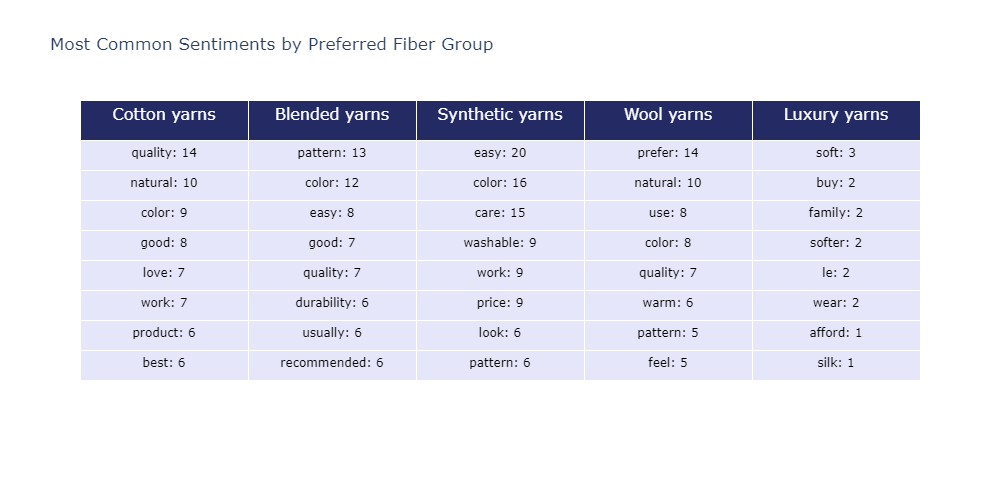

In [83]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[42]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'fiber_group', column_data.columns[1]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)
column_data.dropna(subset=[column_data.columns[1]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'yarn',
    'yarns',
    'project',
    'fibers',
    'acrylic',
    'alpaca',
    'wool',
    'cotton',
    'synthetic',
    'luxury',
    'blended',
    'knit',
    'crochet',
    'like',
    'machine'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all punctuation
    all_punct = string.punctuation + "’"  # Adding curly apostrophe
    text = text.translate(str.maketrans('', '', all_punct))
    # Tokenize
    tokens = word_tokenize(text)
    # Filter out stop words and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

# Function to analyze text data by fiber group
def analyze_by_fiber_group(data):
    # Dictionary to hold word counts for each group
    word_counts_by_group = defaultdict(Counter)
    
    for _, row in data.iterrows():
        fiber_group = row['fiber_group']
        tokens = preprocess_and_tokenize(row['responses'])
        # Update counts for this group
        word_counts_by_group[fiber_group].update(tokens)
    
    # Extracting most common words for each group
    most_common_by_group = {group: counts.most_common(8) for group, counts in word_counts_by_group.items()}
    return most_common_by_group

most_common_words = analyze_by_fiber_group(column_data)  

# Transform the 'most_common_words' dict to a format suitable for Plotly Table
max_words = max(len(words) for words in most_common_words.values())

# Re-initialize columns for the table using distinct fiber_group values
distinct_fiber_groups = column_data['fiber_group'].unique()
columns = ['Word'] + list(distinct_fiber_groups)

# Initialize the table data with empty strings for the updated columns list
table_data = [["" for _ in range(len(columns))] for _ in range(max_words)]

# Populate the first column with the word ranks
for i in range(max_words):
    table_data[i][0] = f"Word {i+1}"

# Fill in the word and count data using the updated fiber groups
for col_index, fiber_group in enumerate(distinct_fiber_groups, start=1):
    for row_index, (word, count) in enumerate(most_common_words.get(fiber_group, [])):
        # This assumes that the most_common_words dictionary keys match the distinct fiber group values exactly
        table_data[row_index][col_index] = f"{word}: {count}"

# Exclude the 'Word' column from the final presentation by adjusting the column headers and the table data
final_columns = columns[1:]  # Exclude the first column which is 'Word'
final_table_data = [row[1:] for row in table_data]  # Exclude the first element from each row

# Create the Plotly table without the 'Word' column
fig = go.Figure(data=[go.Table(
    header=dict(values=final_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*final_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply the same layout customizations as before
fig.update_layout(
    title_text='Most Common Sentiments by Preferred Fiber Group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000
)

fig.update_traces(
    columnwidth=[10, 10, 10, 10, 10]  # Adjust the numbers based on your preference and the number of columns
)

# Show the figure
fig.write_image("./IMG/yarn_common_words.png")
display(Image(filename="./IMG/yarn_common_words.png"))


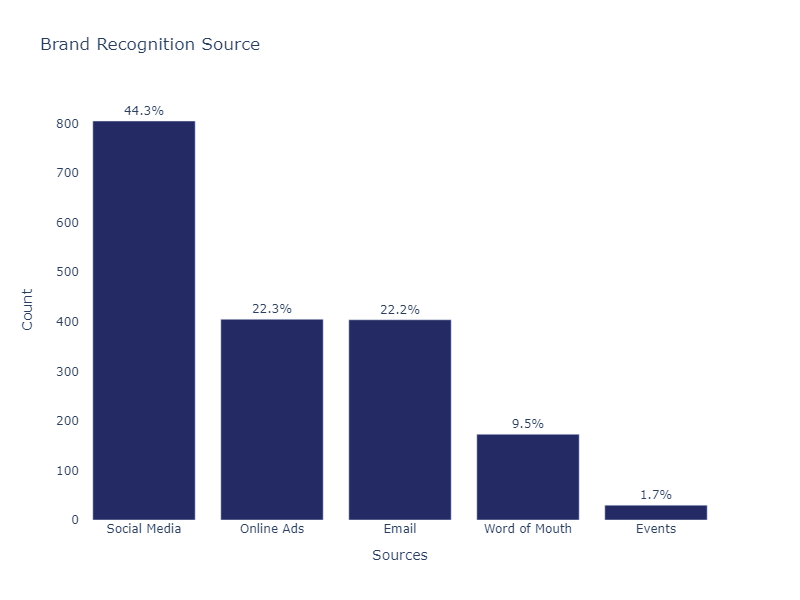

- Of the respondents, the most popular brand discovery sources are: (From 2042 responses.)
     - For ages Under 18: Preferred **Social Media** **(42.9%)**, then **Email** **(28.6%)**, followed by **Word of Mouth** **(28.6%)**.
     - For ages 18-24: Preferred **Social Media** **(36.4%)**, then **Email** **(30.3%)**, followed by **Online Ads** **(18.2%)**.
     - For ages 25-34: Preferred **Social Media** **(49.0%)**, then **Online Ads** **(23.2%)**, followed by **Email** **(14.8%)**.
     - For ages 35-44: Preferred **Social Media** **(52.9%)**, then **Online Ads** **(16.7%)**, followed by **Email** **(16.0%)**.
     - For ages 45-54: Preferred **Social Media** **(51.6%)**, then **Online Ads** **(24.4%)**, followed by **Email** **(12.7%)**.
     - For ages 55-64: Preferred **Social Media** **(46.5%)**, then **Email** **(22.6%)**, followed by **Online Ads** **(20.3%)**.
     - For ages 65-74: Preferred **Social Media** **(37.2%)**, then **Email** **(30.9%)**, followed by **Online Ads** **(24.3%)**.
     - For ages 75 and older: Preferred **Email** **(39.2%)**, then **Online Ads** **(27.5%)**, followed by **Social Media** **(23.5%)**.

In [84]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[26], all_responses.columns[75]]]], axis=1)

categories = [
    'Social Media (Instagram, Facebook, Pinterest, etc.)', 
    'Online Ads (Search engines, Sponsored content)', 
    'Word of Mouth (Friends/Family, Colleagues)', 
    'Events (In-store, Trade shows, Workshops)', 
    'Email (Promotional, Newsletter)'
]

column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].where(column_data[all_responses.columns[26]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 26].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\s{2,}", " ", regex=True).str.strip()


# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Brand Recognition Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/brand_recognition_source.png")
display(Image(filename="./IMG/brand_recognition_source.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular brand discovery sources are: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

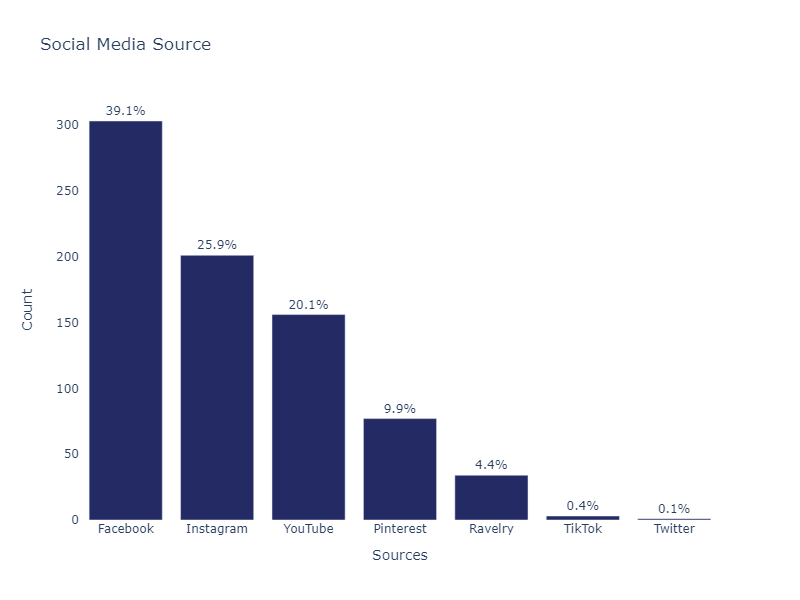

- Of the respondents that discovered a brand through social media, the most popular is: (From 775 responses.)
     - For ages Under 18: Preferred **YouTube** **(66.7%)** and **Instagram** **(33.3%)**.
     - For ages 18-24: Preferred **YouTube** **(70.0%)**, then **Instagram** **(20.0%)**, followed by **Pinterest** **(10.0%)**.
     - For ages 25-34: Preferred **Instagram** **(58.0%)**, then **YouTube** **(24.6%)**, followed by **Facebook** **(8.7%)**.
     - For ages 35-44: Preferred **Instagram** **(35.1%)**, then **Facebook** **(30.5%)**, followed by **YouTube** **(21.4%)**.
     - For ages 45-54: Preferred **Facebook** **(40.1%)**, then **Instagram** **(24.8%)**, followed by **YouTube** **(24.2%)**.
     - For ages 55-64: Preferred **Facebook** **(44.5%)**, then **Instagram** **(20.9%)**, followed by **YouTube** **(19.4%)**.
     - For ages 65-74: Preferred **Facebook** **(55.3%)**, then **Pinterest** **(17.4%)**, followed by **YouTube** **(12.9%)**.
     - For ages 75 and older: Preferred **Facebook** **(69.6%)**, then **Pinterest** **(13.0%)**, followed by **YouTube** **(8.7%)**.

In [85]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[27], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[all_responses.columns[27]] = column_data[all_responses.columns[27]].where(column_data[all_responses.columns[27]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media.png")
display(Image(filename="./IMG/social_media.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents that discovered a brand through social media, the most popular is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

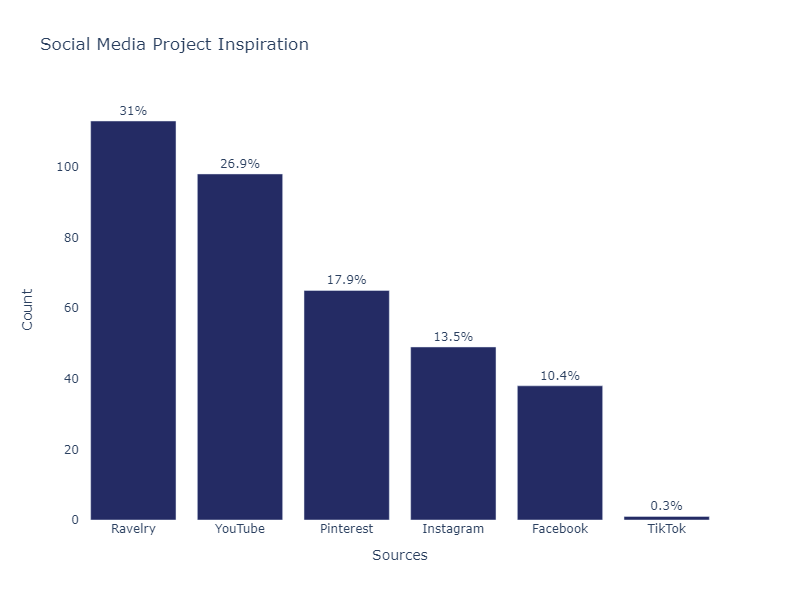

- Of the respondents, the most popular social media platform for inspiration is: (From 364 responses.)
     - For ages Under 18: Preferred **Ravelry** **(100.0%)**.
     - For ages 18-24: Preferred **YouTube** **(33.3%)**, then **Instagram** **(33.3%)**, followed by **Ravelry** **(16.7%)**.
     - For ages 25-34: Preferred **Ravelry** **(34.8%)**, then **Instagram** **(26.1%)**, followed by **Pinterest** **(17.4%)**.
     - For ages 35-44: Preferred **Ravelry** **(37.7%)**, then **Instagram** **(21.3%)**, followed by **YouTube** **(19.7%)**.
     - For ages 45-54: Preferred **Ravelry** **(26.9%)**, then **Instagram** **(23.1%)**, followed by **YouTube** **(19.2%)**.
     - For ages 55-64: Preferred **YouTube** **(31.9%)**, then **Ravelry** **(24.5%)**, followed by **Pinterest** **(19.1%)**.
     - For ages 65-74: Preferred **Ravelry** **(31.1%)**, then **YouTube** **(29.7%)**, followed by **Pinterest** **(23.0%)**.
     - For ages 75 and older: Preferred **YouTube** **(39.1%)**, then **Ravelry** **(39.1%)**, followed by **Pinterest** **(8.7%)**.

In [86]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[44], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Project Inspiration',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media_inspiration.png")
display(Image(filename="./IMG/social_media_inspiration.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular social media platform for inspiration is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

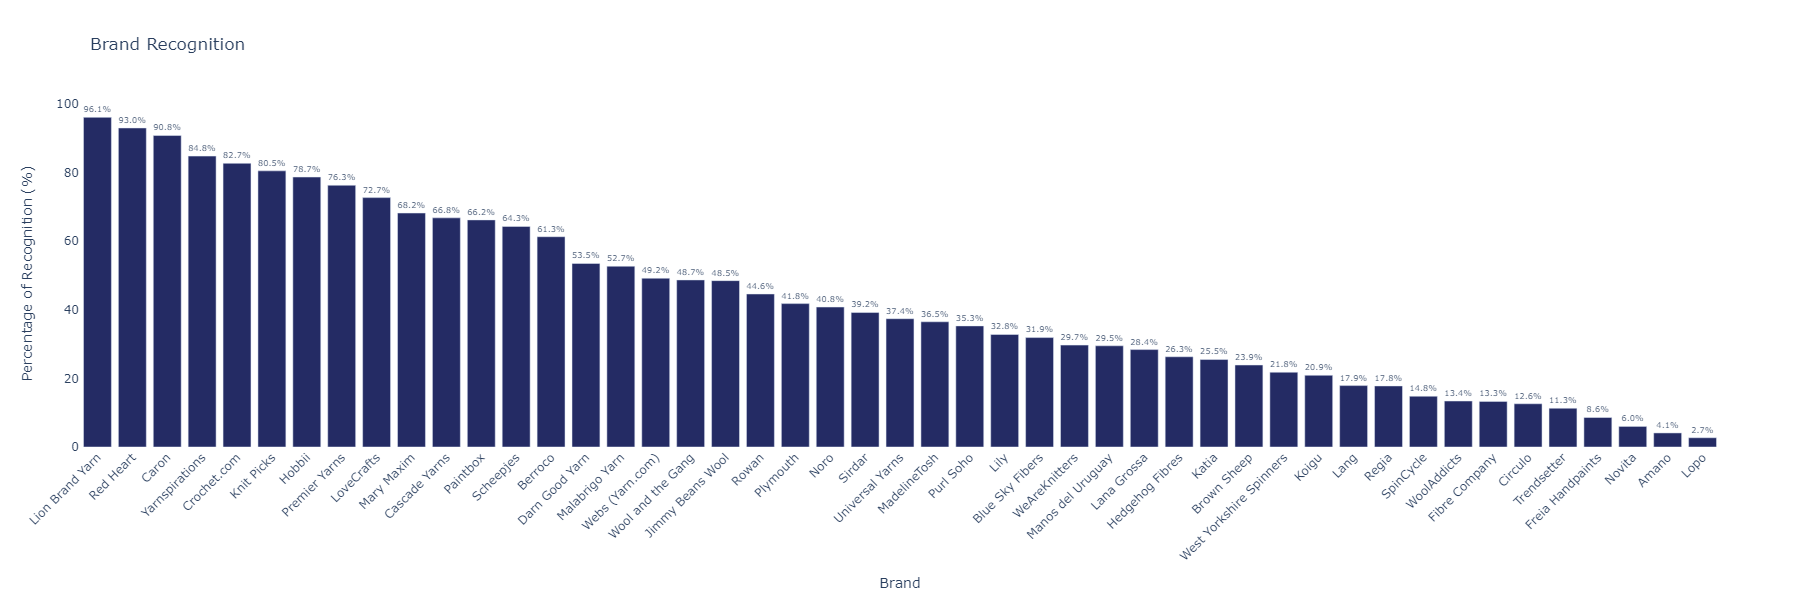

In [87]:
# Print statement question.
question = all_responses.columns[28]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 28].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 28].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Recognition',
             labels={'Percentage': 'Percentage of Recognition (%)', 'Brand': 'Brand'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_recognition.png")
display(Image(filename="./IMG/brand_recognition.png"))

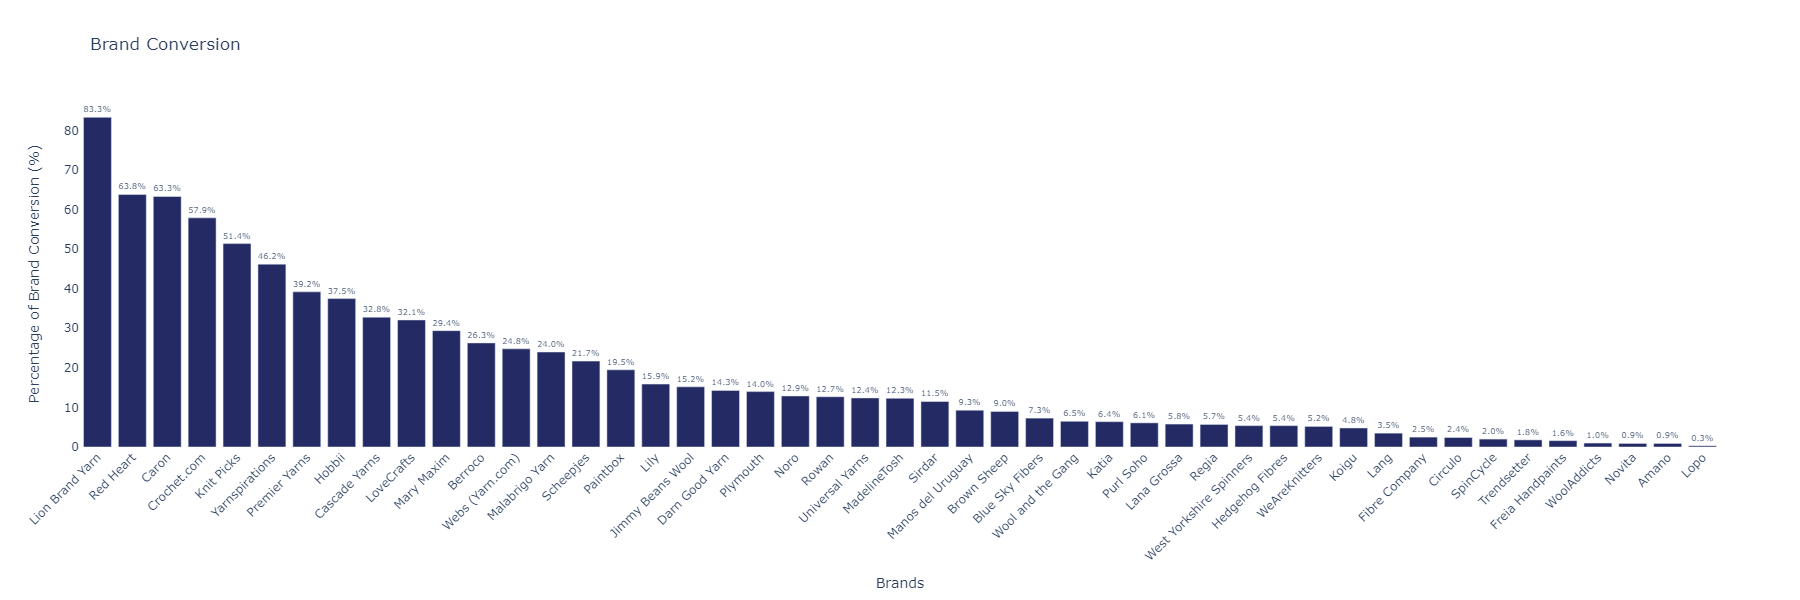

In [88]:
# Print statement question.
question = all_responses.columns[29]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 29].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 29].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Conversion',
             labels={'Percentage': 'Percentage of Brand Conversion (%)', 'Brand': 'Brands'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_conversion.png")
display(Image(filename="./IMG/brand_conversion.png"))

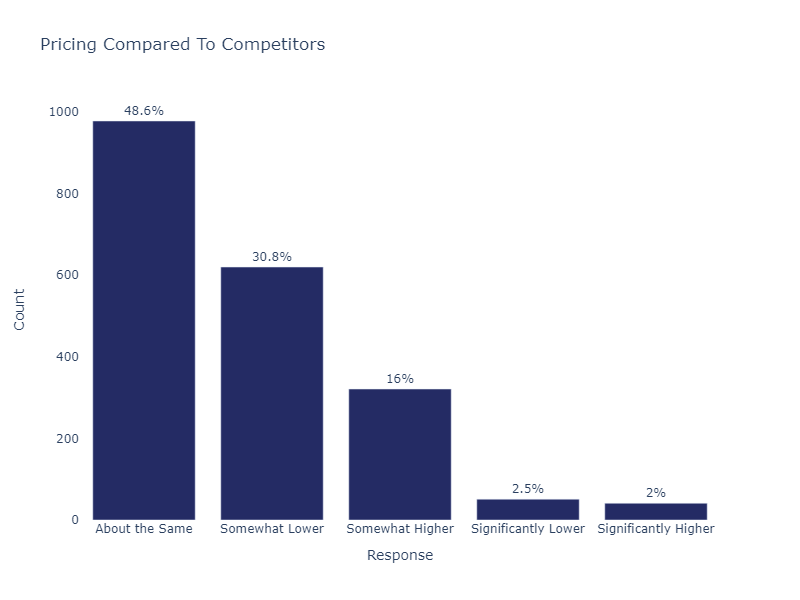

- Of the respondents, when asked about to rate the price of our produts compared to competitors:  (From 2011 responses)
    - About the Same: **(49%)**
    - Somewhat Lower: **(31%)**
    - Somewhat Higher: **(16%)**
    - Significantly Lower: **(3%)**
    - Significantly Higher: **(2%)**


In [89]:
### Employment ###
question = all_responses.columns[31]

column_data = all_responses[all_responses.columns[31]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Pricing Compared To Competitors',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/survey_source.png")
display(Image(filename="./IMG/survey_source.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about to rate the price of our produts compared to competitors:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

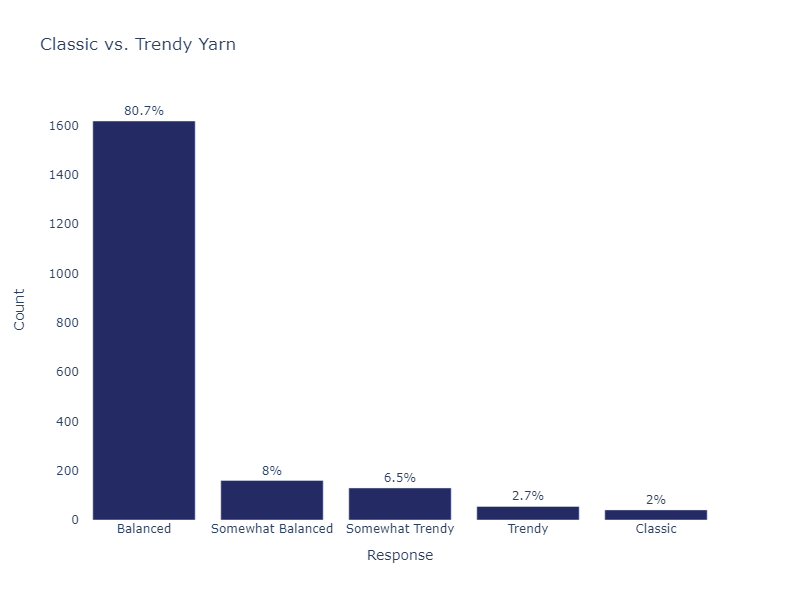

- Of the respondents, when asked about the balance between classic and trendy yarns in our selection:  (From 2004 responses)
    - Balanced: **(81%)**
    - Somewhat Balanced: **(8%)**
    - Somewhat Trendy: **(6%)**
    - Trendy: **(3%)**
    - Classic: **(2%)**


In [90]:
### Employment ###
question = all_responses.columns[48]

column_data = all_responses[all_responses.columns[48]].dropna()
sample_size = column_data.shape[0]

# Define the function to map income ranges to their midpoints
def map_answer(value):
    if value == 1:
        return 'Classic'
    elif value == 2:
        return 'Somewhat Balanced'
    elif value == 3:
        return 'Balanced'
    elif value == 4:
        return 'Somewhat Trendy'
    elif value == 5:
        return 'Trendy'
    else:
        return np.nan

# Apply the function to the column data
column_data = column_data.map(map_answer)

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Classic vs. Trendy Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/trendy_classic_yarn.png")
display(Image(filename="./IMG/trendy_classic_yarn.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about the balance between classic and trendy yarns in our selection:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

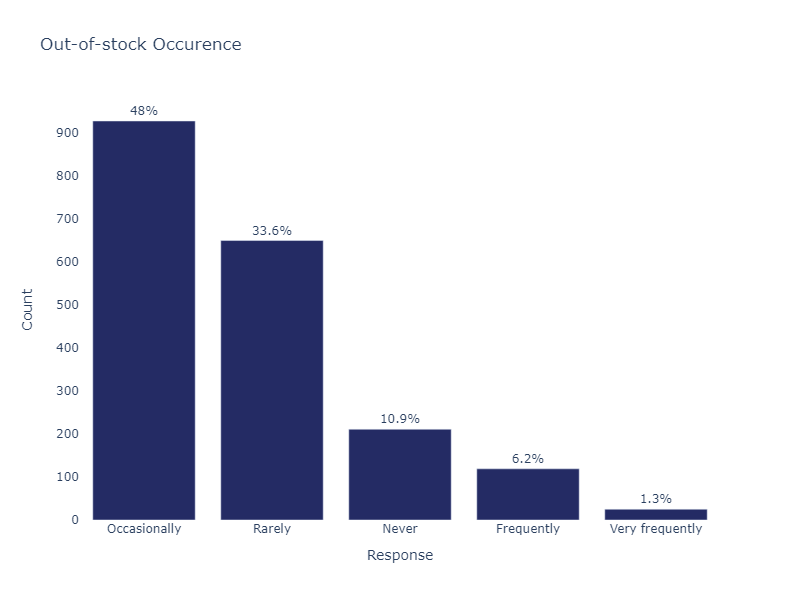

- Of the respondents, when asked about how often is something you want from our website out-of-stock:  (From 1933 responses)
    - Occasionally: **(48%)**
    - Rarely: **(34%)**
    - Never: **(11%)**
    - Frequently: **(6%)**
    - Very frequently: **(1%)**


In [91]:
question = all_responses.columns[49]

column_data = all_responses[all_responses.columns[49]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Out-of-stock Occurence',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/out_of_stock.png")
display(Image(filename="./IMG/out_of_stock.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about how often is something you want from our website out-of-stock:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

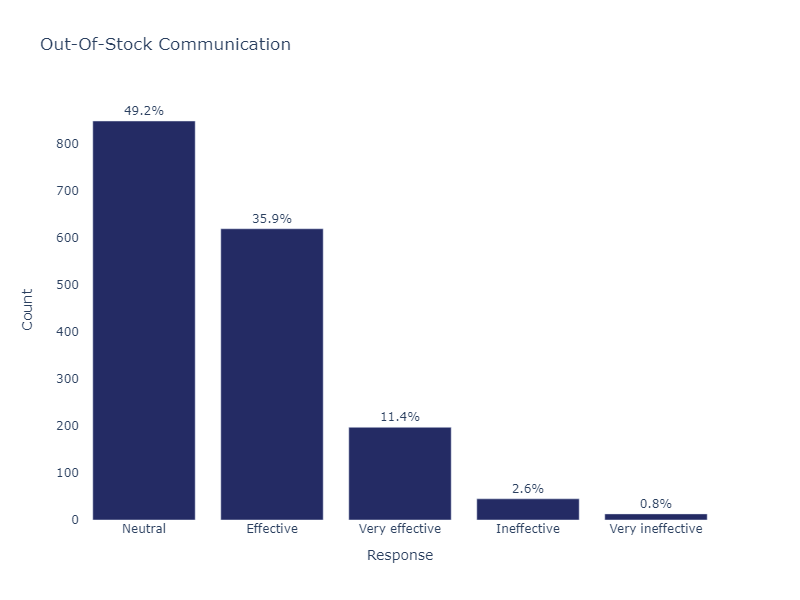

- Of the respondents who experienced out-of-stock issues, when asked about how effective is our communication is:  (From 1722 responses)
    - Neutral: **(49%)**
    - Effective: **(36%)**
    - Very effective: **(11%)**
    - Ineffective: **(3%)**
    - Very ineffective: **(1%)**


In [92]:
question = all_responses.columns[50]

column_data = all_responses[all_responses.columns[50]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Out-Of-Stock Communication',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/out_of_stock_communication.png")
display(Image(filename="./IMG/out_of_stock_communication.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents who experienced out-of-stock issues, when asked about how effective is our communication is:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

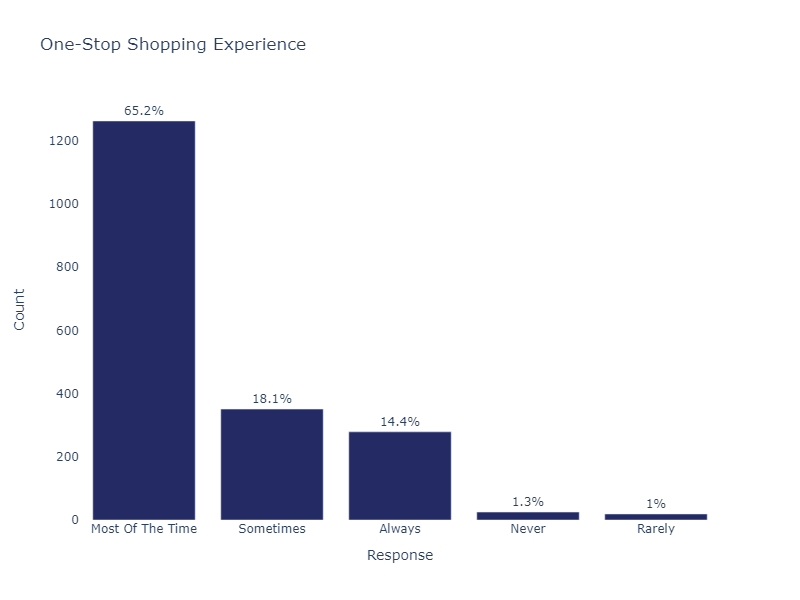

- Of the respondents, when asked if they were able to find everything they need for a project on our website:  (From 1937 responses)
    - Most Of The Time: **(65%)**
    - Sometimes: **(18%)**
    - Always: **(14%)**
    - Never: **(1%)**
    - Rarely: **(1%)**


In [93]:
question = all_responses.columns[51]

column_data = all_responses[all_responses.columns[51]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='One-Stop Shopping Experience',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/one_stop_shop.png")
display(Image(filename="./IMG/one_stop_shop.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they were able to find everything they need for a project on our website:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

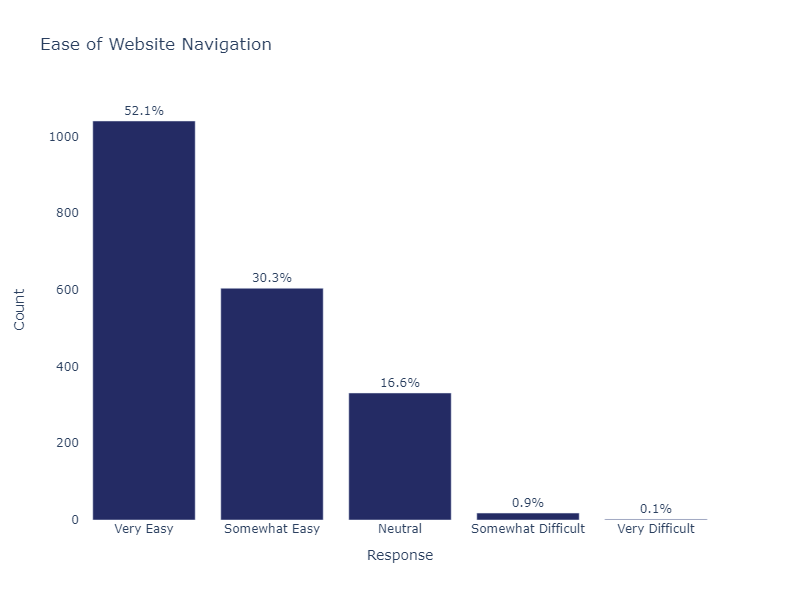

- Of the respondents, when asked the difficulty of navigating our website to browse products:  (From 1995 responses)
    - Very Easy: **(52%)**
    - Somewhat Easy: **(30%)**
    - Neutral: **(17%)**
    - Somewhat Difficult: **(1%)**
    - Very Difficult: **(0%)**


In [94]:
question = all_responses.columns[53]

column_data = all_responses[all_responses.columns[53]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Ease of Website Navigation',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/website_navigation.png")
display(Image(filename="./IMG/website_navigation.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked the difficulty of navigating our website to browse products:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

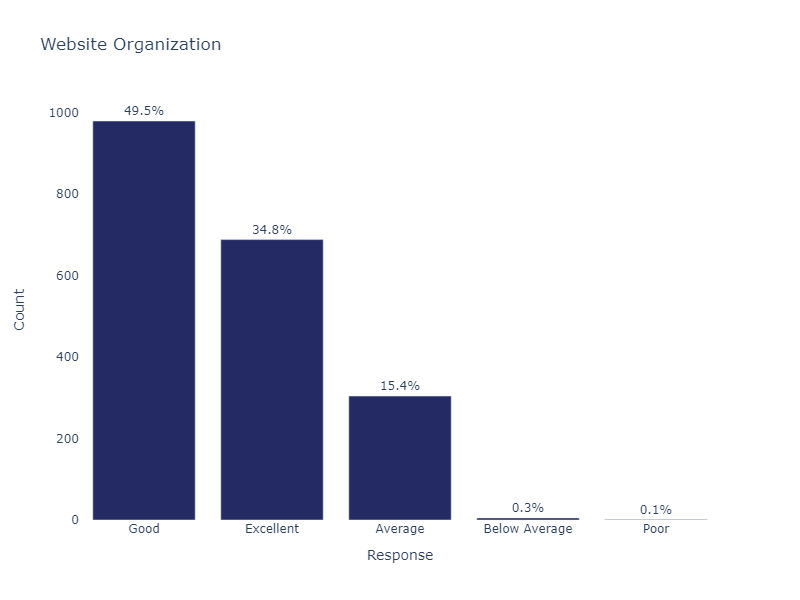

- Of the respondents, when asked how they would rate the organization and categorization of products on our site:  (From 1977 responses)
    - Good: **(50%)**
    - Excellent: **(35%)**
    - Average: **(15%)**
    - Below Average: **(0%)**
    - Poor: **(0%)**


In [95]:
question = all_responses.columns[55]

column_data = all_responses[all_responses.columns[55]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Website Organization',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/website_organization.png")
display(Image(filename="./IMG/website_organization.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how they would rate the organization and categorization of products on our site:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

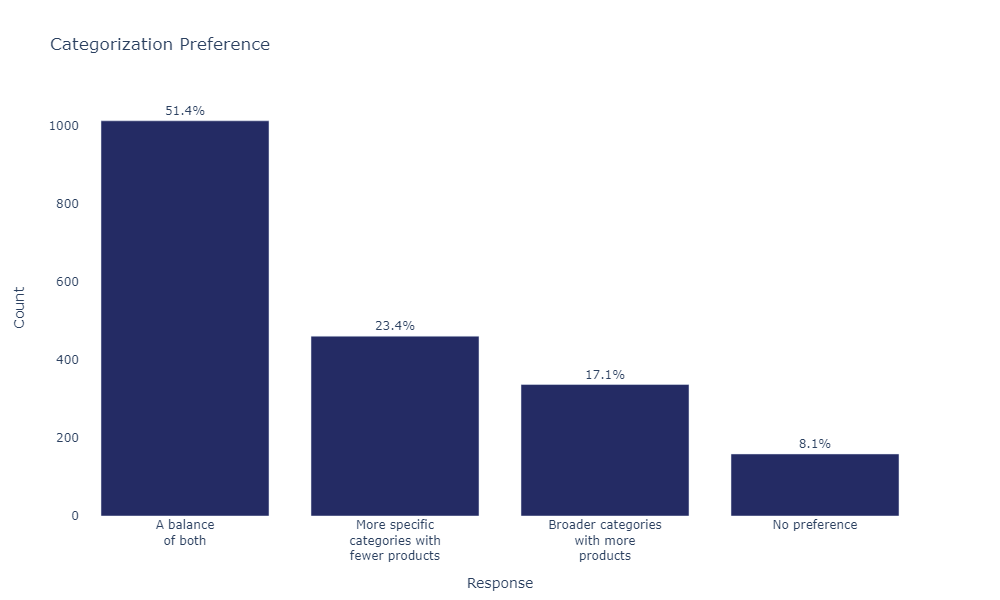

- Of the respondents, when asked if they prefer broader categories with more products or more specific categories with fewer products:  (From 1970 responses)
    - A balance of both: **(51%)**
    - More specific categories with fewer products: **(23%)**
    - Broader categories with more products: **(17%)**
    - No preference: **(8%)**


In [96]:
question = all_responses.columns[56]

column_data = all_responses[all_responses.columns[56]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

def insert_line_breaks(text):
    words = text.split()
    # Insert '<br>' after every two words
    return '<br>'.join(' '.join(words[i:i+2]) for i in range(0, len(words), 2))

# Apply the function to each category to insert line breaks
summary_df['CategoryWrapped'] = summary_df['Category'].apply(insert_line_breaks)

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='CategoryWrapped', y='Count', title='Categorization Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout to improve readability
fig.update_layout(
    xaxis=dict(
        title='Response',
        tickmode='array',
        tickvals=summary_df['CategoryWrapped'],  # Use the wrapped category
        ticktext=summary_df['CategoryWrapped']   # Use the wrapped text for ticktext
    ),
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)
# Show the figure
fig.write_image("./IMG/categorization_preference.png")
display(Image(filename="./IMG/categorization_preference.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they prefer broader categories with more products or more specific categories with fewer products:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

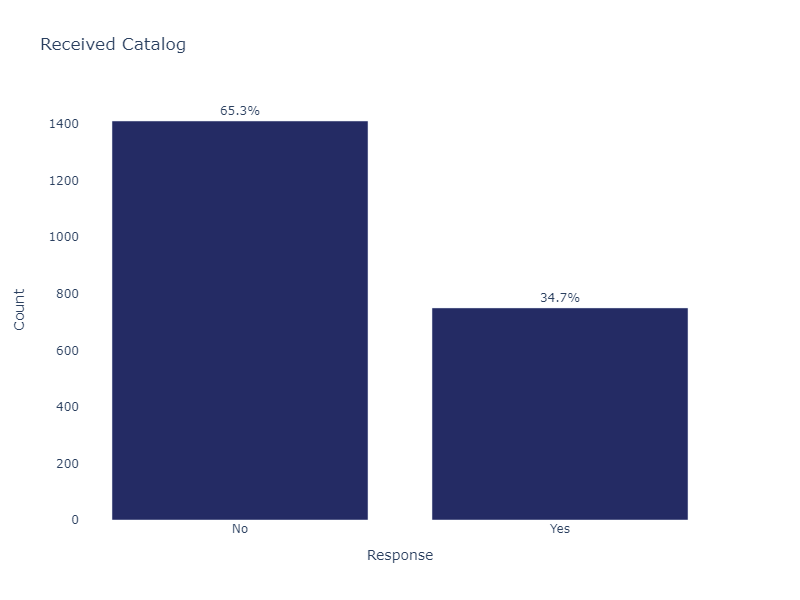

- Of the respondents, when asked if they have received one of our catalogs before:  (From 2161 responses)
    - No: **(65%)**
    - Yes: **(35%)**


In [97]:
question = all_responses.columns[57]

column_data = all_responses[all_responses.columns[57]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Received Catalog',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_received.png")
display(Image(filename="./IMG/catalog_received.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have received one of our catalogs before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

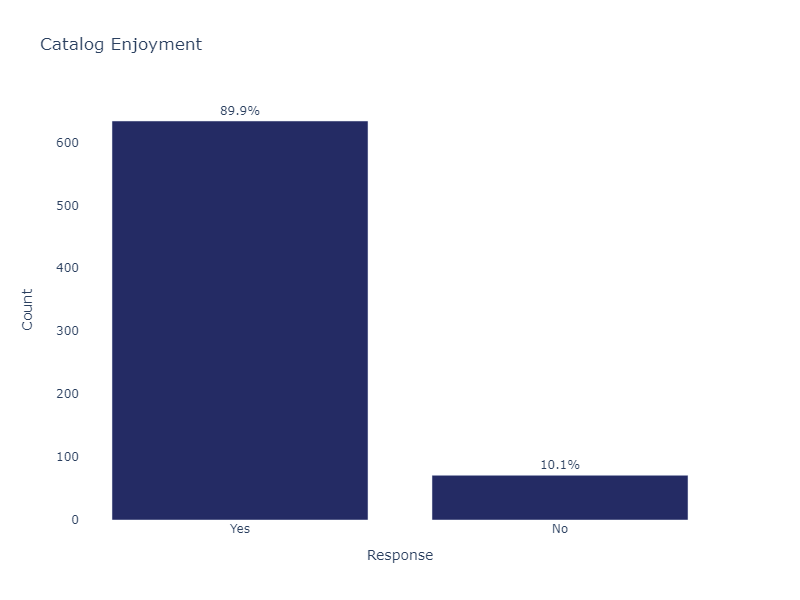

- Of the respondents, when asked if they enjoy receiving our catalog:  (From 705 responses)
    - Yes: **(90%)**
    - No: **(10%)**


- Of the respondents, when asked if they enjoy receiving our catalog: 
     - For ages Under 18:  **No** **(50.0%)**, and **Yes** **(50.0%)**.
     - For ages 18-24:  **Yes** **(91.7%)**, and **No** **(8.3%)**.
     - For ages 25-34:  **Yes** **(87.2%)**, and **No** **(12.8%)**.
     - For ages 35-44:  **Yes** **(88.5%)**, and **No** **(11.5%)**.
     - For ages 45-54:  **Yes** **(87.7%)**, and **No** **(12.3%)**.
     - For ages 55-64:  **Yes** **(93.7%)**, and **No** **(6.3%)**.
     - For ages 65-74:  **Yes** **(92.9%)**, and **No** **(7.1%)**.
     - For ages 75 and older:  **Yes** **(90.0%)**, and **No** **(10.0%)**.

In [98]:
column_data = all_responses[all_responses.columns[58]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Enjoyment',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_enjoyment.png")
display(Image(filename="./IMG/catalog_enjoyment.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they enjoy receiving our catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[58], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they enjoy receiving our catalog: "

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

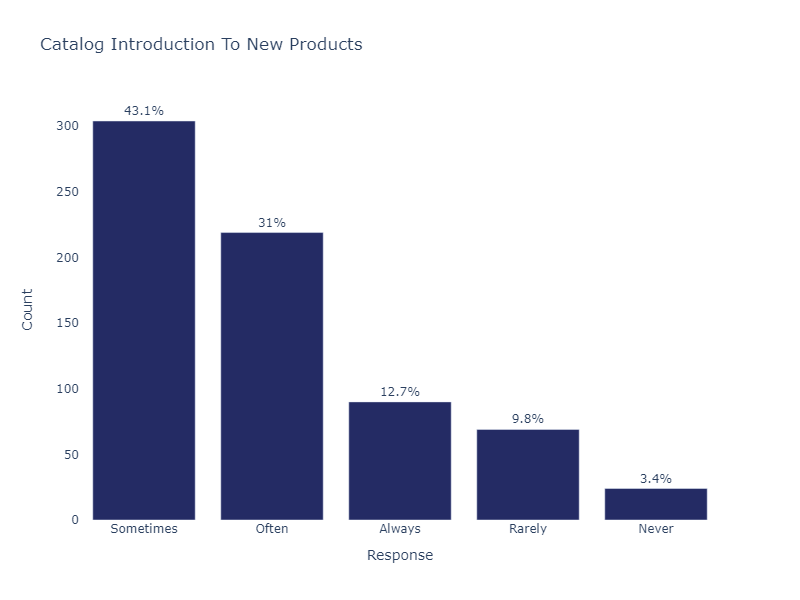

- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before:  (From 706 responses)
    - Sometimes: **(43%)**
    - Often: **(31%)**
    - Always: **(13%)**
    - Rarely: **(10%)**
    - Never: **(3%)**


- Of the respondents,  when asked if catalogs have introduced them to products they weren't aware of before: (From 706 responses.)
     - For ages Under 18:  **Rarely** **(50.0%)**, and **Sometimes** **(50.0%)**.
     - For ages 18-24:  **Sometimes** **(66.7%)**, **Often** **(25.0%)**, and **Rarely** **(8.3%)**.
     - For ages 25-34:  **Sometimes** **(33.3%)**, **Often** **(26.9%)**, and **Always** **(16.7%)**.
     - For ages 35-44:  **Sometimes** **(47.7%)**, **Often** **(27.7%)**, and **Rarely** **(13.8%)**.
     - For ages 45-54:  **Sometimes** **(40.4%)**, **Often** **(35.6%)**, and **Always** **(10.3%)**.
     - For ages 55-64:  **Sometimes** **(39.8%)**, **Often** **(34.2%)**, and **Always** **(16.1%)**.
     - For ages 65-74:  **Sometimes** **(50.0%)**, **Often** **(27.7%)**, and **Always** **(12.5%)**.
     - For ages 75 and older:  **Often** **(40.0%)**, **Sometimes** **(40.0%)**, and **Always** **(15.0%)**.

In [99]:
column_data = all_responses[all_responses.columns[59]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Introduction To New Products',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_new_products.png")
display(Image(filename="./IMG/catalog_new_products.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if catalogs have introduced them to products they weren't aware of before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[59], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents,  when asked if catalogs have introduced them to products they weren't aware of before: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

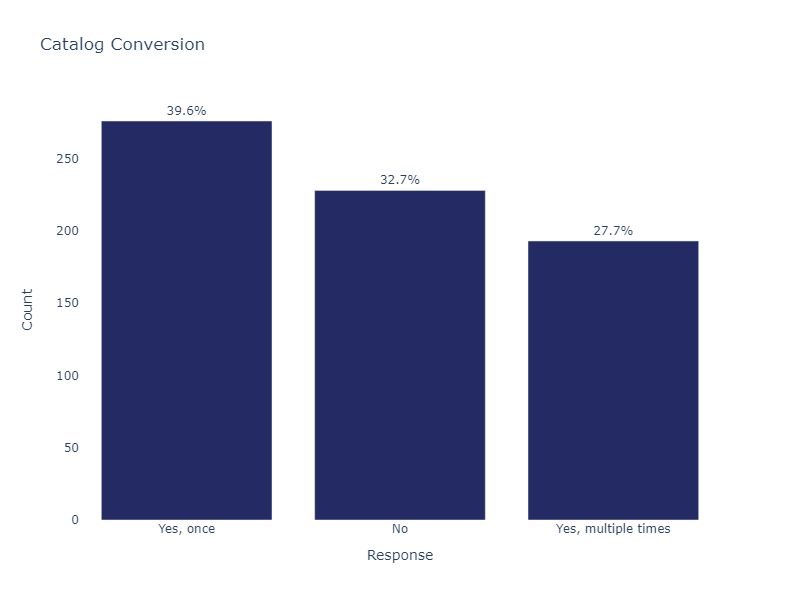

- Of the respondents, when asked if they have made a purchase after receiving a catalog:  (From 697 responses)
    - Yes, once: **(40%)**
    - No: **(33%)**
    - Yes, multiple times: **(28%)**


- Of the respondents, when asked if they have made a purchase after receiving a catalog: (From 697 responses.)
     - For ages Under 18:  **No** **(50.0%)**, and **Yes, once** **(50.0%)**.
     - For ages 18-24:  **No** **(66.7%)**, and **Yes, once** **(33.3%)**.
     - For ages 25-34:  **No** **(44.9%)**, **Yes, once** **(43.6%)**, and **Yes, multiple times** **(11.5%)**.
     - For ages 35-44:  **No** **(40.3%)**, **Yes, once** **(38.0%)**, and **Yes, multiple times** **(21.7%)**.
     - For ages 45-54:  **Yes, once** **(40.7%)**, **No** **(33.8%)**, and **Yes, multiple times** **(25.5%)**.
     - For ages 55-64:  **Yes, once** **(42.9%)**, **Yes, multiple times** **(35.3%)**, and **No** **(21.8%)**.
     - For ages 65-74:  **Yes, once** **(36.9%)**, **Yes, multiple times** **(36.9%)**, and **No** **(26.1%)**.
     - For ages 75 and older:  **Yes, multiple times** **(57.9%)**, **No** **(21.1%)**, and **Yes, once** **(21.1%)**.

In [100]:
column_data = all_responses[all_responses.columns[60]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Conversion',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_purchase.png")
display(Image(filename="./IMG/catalog_purchase.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have made a purchase after receiving a catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[60], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they have made a purchase after receiving a catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

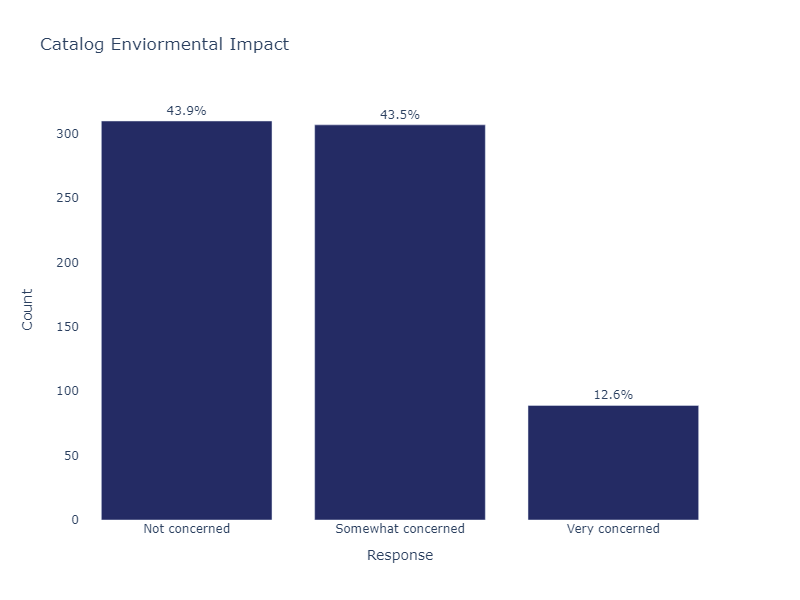

- Of the respondents, when asked if they had enviornmental concerns about the catalog:  (From 706 responses)
    - Not concerned: **(44%)**
    - Somewhat concerned: **(43%)**
    - Very concerned: **(13%)**


- Of the respondents, when asked if they had enviornmental concerns about the catalog: (From 706 responses.)
     - For ages Under 18:  **Somewhat concerned** **(100.0%)**
     - For ages 18-24:  **Somewhat concerned** **(75.0%)**, and **Not concerned** **(25.0%)**.
     - For ages 25-34:  **Not concerned** **(44.9%)**, **Somewhat concerned** **(35.9%)**, and **Very concerned** **(19.2%)**.
     - For ages 35-44:  **Somewhat concerned** **(47.3%)**, **Not concerned** **(37.2%)**, and **Very concerned** **(15.5%)**.
     - For ages 45-54:  **Somewhat concerned** **(45.9%)**, **Not concerned** **(43.8%)**, and **Very concerned** **(10.3%)**.
     - For ages 55-64:  **Not concerned** **(49.1%)**, **Somewhat concerned** **(44.7%)**, and **Very concerned** **(6.2%)**.
     - For ages 65-74:  **Not concerned** **(44.6%)**, **Somewhat concerned** **(39.3%)**, and **Very concerned** **(16.1%)**.
     - For ages 75 and older:  **Somewhat concerned** **(45.0%)**, **Not concerned** **(40.0%)**, and **Very concerned** **(15.0%)**.

In [101]:
column_data = all_responses[all_responses.columns[61]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Catalog Enviormental Impact',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_enviornmental_impact.png")
display(Image(filename="./IMG/catalog_enviornmental_impact.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they had enviornmental concerns about the catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[61], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they had enviornmental concerns about the catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

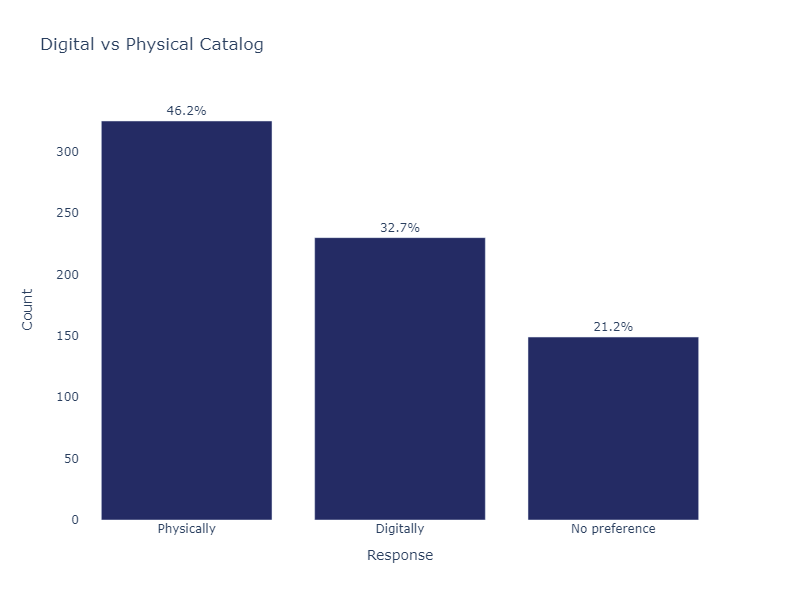

- Of the respondents, when asked if they would prefer a physical or digital catalog:  (From 704 responses)
    - Physically: **(46%)**
    - Digitally: **(33%)**
    - No preference: **(21%)**


- Of the respondents, when asked if they would prefer a physical or digital catalog: (From 704 responses.)
     - For ages Under 18:  **Digitally** **(100.0%)**
     - For ages 18-24:  **Digitally** **(41.7%)**, **No preference** **(33.3%)**, and **Physically** **(25.0%)**.
     - For ages 25-34:  **Physically** **(43.6%)**, **Digitally** **(39.7%)**, and **No preference** **(16.7%)**.
     - For ages 35-44:  **Physically** **(43.8%)**, **Digitally** **(33.8%)**, and **No preference** **(22.3%)**.
     - For ages 45-54:  **Physically** **(44.9%)**, **Digitally** **(34.0%)**, and **No preference** **(21.1%)**.
     - For ages 55-64:  **Physically** **(50.3%)**, **Digitally** **(26.4%)**, and **No preference** **(23.3%)**.
     - For ages 65-74:  **Physically** **(47.8%)**, **Digitally** **(31.0%)**, and **No preference** **(21.2%)**.
     - For ages 75 and older:  **Physically** **(55.0%)**, **Digitally** **(30.0%)**, and **No preference** **(15.0%)**.

In [102]:
column_data = all_responses[all_responses.columns[62]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Digital vs Physical Catalog',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/catalog_type_preference.png")
display(Image(filename="./IMG/catalog_type_preference.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they would prefer a physical or digital catalog:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

column_data = pd.concat([all_responses[[all_responses.columns[62], all_responses.columns[75]]]], axis=1)

ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, when asked if they would prefer a physical or digital catalog: (From {sample_size} responses.)"

for age in ages:
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        platform_count = len(percentages)
        
        markdown_summary += f"\n     - For ages {age}:"
        if platform_count > 0:
            markdown_summary += " "
            for i in range(min(platform_count, 3)):  # Adjust the number to include more platforms if needed
                if i == 0:
                    markdown_summary += f" **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
                elif i == min(platform_count, 3) - 1:
                    markdown_summary += f", and **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**."
                else:
                    markdown_summary += f", **{percentages.iloc[i, 0]}** **({percentages.iloc[i, 1]}%)**"
        else:
            markdown_summary += " there was no significant data."
            
# Display the markdown text
display(Markdown(markdown_summary))

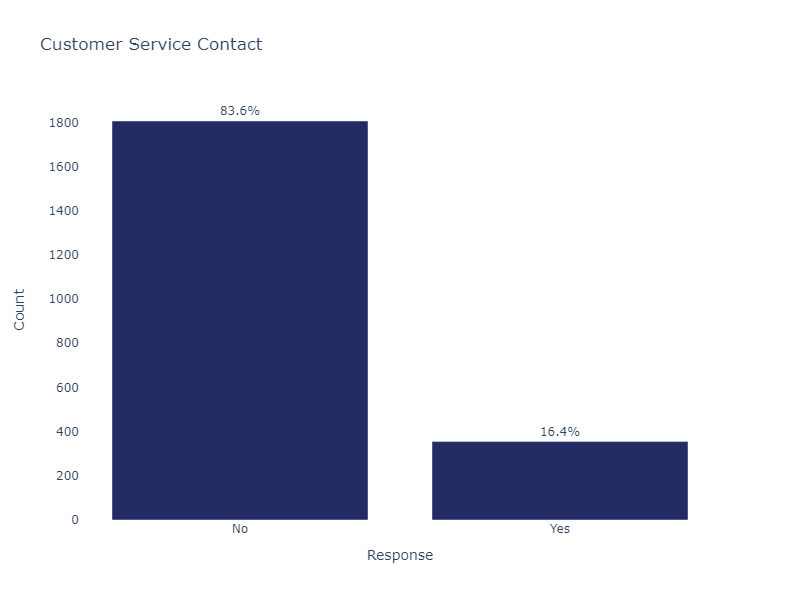

- Of the respondents, when asked if they have contacted customer service before:  (From 2161 responses)
    - No: **(84%)**
    - Yes: **(16%)**


In [103]:
column_data = all_responses[all_responses.columns[64]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Contact',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service.png")
display(Image(filename="./IMG/customer_service.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked if they have contacted customer service before:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

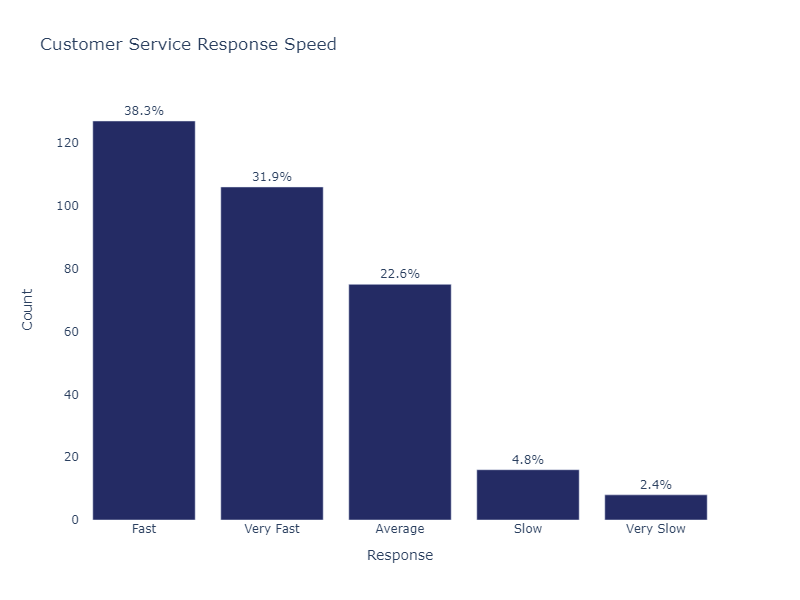

- Of the respondents, when asked about the response speed of our customer service:  (From 332 responses)
    - Fast: **(38%)**
    - Very Fast: **(32%)**
    - Average: **(23%)**
    - Slow: **(5%)**
    - Very Slow: **(2%)**


In [104]:
column_data = all_responses[all_responses.columns[65]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Response Speed',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service_speed.png")
display(Image(filename="./IMG/customer_service_speed.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked about the response speed of our customer service:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

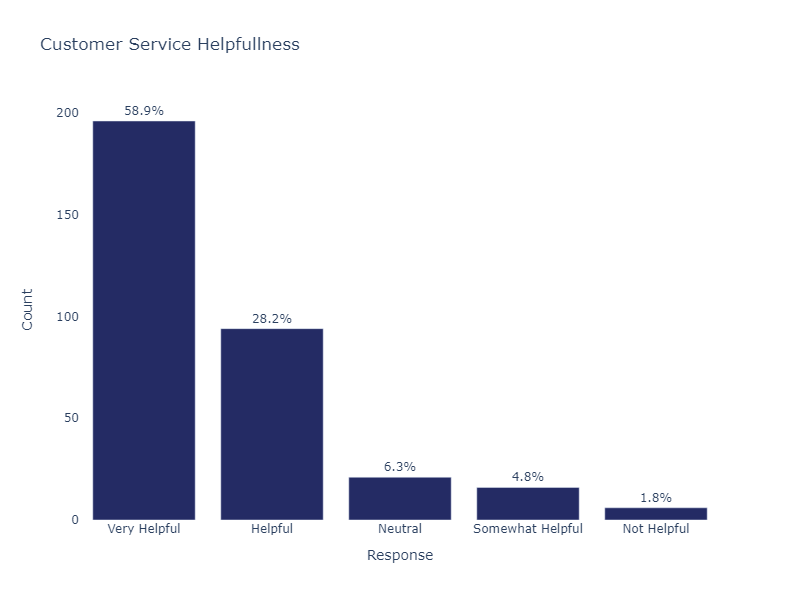

- Of the respondents, when asked how helpful our customer service is:  (From 333 responses)
    - Very Helpful: **(59%)**
    - Helpful: **(28%)**
    - Neutral: **(6%)**
    - Somewhat Helpful: **(5%)**
    - Not Helpful: **(2%)**


In [105]:
column_data = all_responses[all_responses.columns[66]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Helpfullness',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service_help.png")
display(Image(filename="./IMG/customer_service_help.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how helpful our customer service is:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

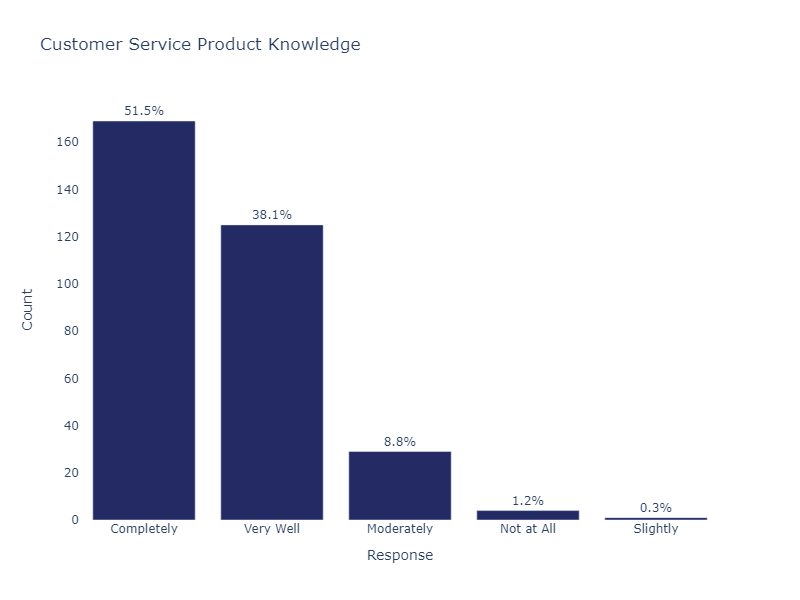

- Of the respondents, when asked how well our customer service understood the products related to their inquiry:  (From 328 responses)
    - Completely: **(52%)**
    - Very Well: **(38%)**
    - Moderately: **(9%)**
    - Not at All: **(1%)**
    - Slightly: **(0%)**


In [106]:
column_data = all_responses[all_responses.columns[67]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Product Knowledge',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service_help.png")
display(Image(filename="./IMG/customer_service_help.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how well our customer service understood the products related to their inquiry:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

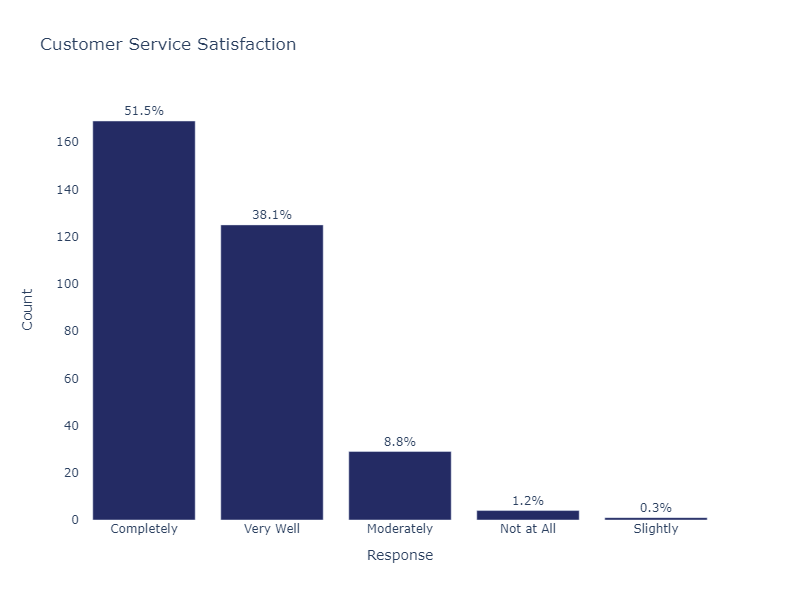

- Of the respondents, when asked how satisfied they were with out customer service:  (From 328 responses)
    - Completely: **(52%)**
    - Very Well: **(38%)**
    - Moderately: **(9%)**
    - Not at All: **(1%)**
    - Slightly: **(0%)**


In [107]:
column_data = all_responses[all_responses.columns[67]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Service Satisfaction',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/customer_service_satisfaction.png")
display(Image(filename="./IMG/customer_service_satisfaction.png"))

summary = column_data.dropna().value_counts(normalize=True) * 100

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, when asked how satisfied they were with out customer service:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **({round(value)}%)**\n"

display(Markdown(markdown_text))

<div style="page-break-after: always;">
   
</div>

<div style="text-align: center;">

<h1>Berroco</h1>

</div>
<br>
<br>
<div style="page-break-after: always; text-align: center;">
    This section will focus on questions answered by Berroco respondents, and the questions unique to Berroco.
</div>

In [108]:
all_responses = pd.read_csv('./CSV/all_processed.csv', encoding='utf-8')
# Filter rows where the value in the column at index 25 is 'Knit Picks'
all_responses = all_responses[all_responses.iloc[:, 25] == 'Berroco']

## Demographic Summary

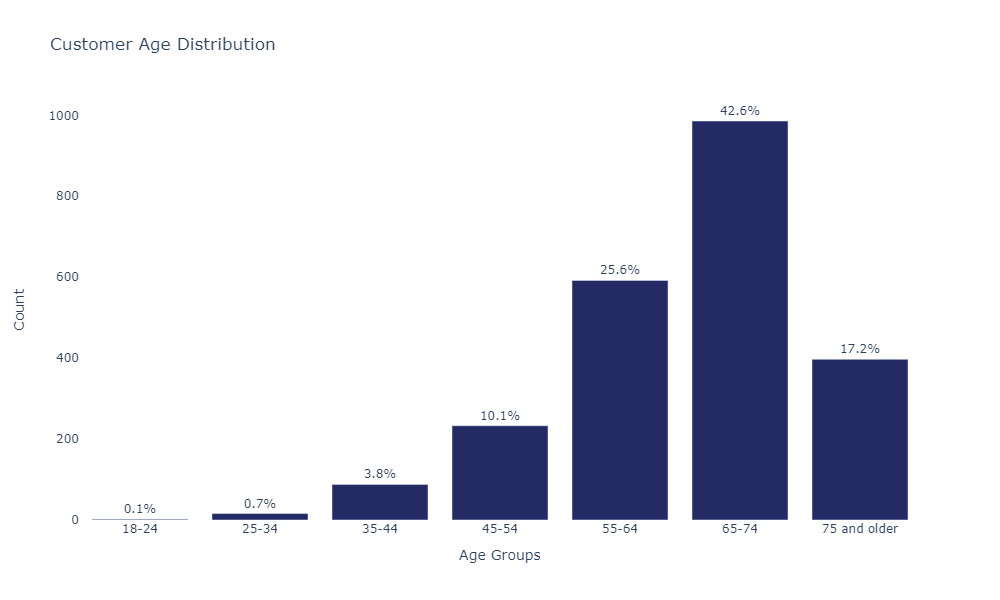

 - Out of **2314** respondents, the average respondent age is: **64** and the median age is: **69**. (From 2314 responses)

- Of these respondents, they identify as: (From 2314 responses)
    - Woman: **98.9%**
    - Man: **0.6%**
    - Non-Conforming / Non-Binary: **0.5%**
    - Transgender: **0.0%**


- The average household income ranges from **\$74,091** to **\$93,350**. (From 1728 responses)
  - For ages **18-24**: the average is between **\$72,500** and **\$89,999**.
  - For ages **25-34**: the average is between **\$88,077** and **\$109,615**.
  - For ages **35-44**: the average is between **\$93,699** and **\$117,533**.
  - For ages **45-54**: the average is between **\$94,724** and **\$118,585**.
  - For ages **55-64**: the average is between **\$92,945** and **\$115,562**.
  - For ages **65-74**: the average is between **\$69,103** and **\$87,627**.
  - For ages **75 and older**: the average is between **\$58,127** and **\$74,720**.


In [109]:
#### Demographic Title Section ###
display(Markdown(f"## Demographic Summary"))
print("\n")

### Age Graph Section ###

question = all_responses.columns[75]
column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Age display order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# New line to convert 'Category' into an ordered categorical type with custom descending order
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Customer Age Distribution',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Groups',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/age.png")
display(Image(filename="./IMG/age.png"))

### Age Text Section ###

# Function to map age ranges to their average values
def map_age_to_average(value):
    if value == 'Under 18':
        return 18
    elif value == '18-24':
        return 21
    elif value == '25-34':
        return 29.5
    elif value == '35-44':
        return 39.5
    elif value == '45-54':
        return 49.5
    elif value == '55-64':
        return 59.5
    elif value == '65-74':
        return 69.5
    elif value == '75 and older':
        return 77
    else:
        return np.nan

# Apply the function to your column_data
age_data = column_data.map(map_age_to_average)
# Calculate the average age
average_age = age_data.mean().astype(int)
# Calculate the average age
median_age = age_data.median().astype(int)

display(Markdown(f" - Out of **{sample_size}** respondents, the average respondent age is: **{average_age}** and the median age is: **{median_age}**. (From {sample_size} responses)" ))

### Identify Text Section ###

# Gender question.
question = all_responses.columns[76]

# Calculate percentage of each answer excluding nulls
summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output in Markdown
markdown_text = f"- Of these respondents, they identify as: (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{value:.1f}%**\n"

display(Markdown(markdown_text))

### Income Section ###

# Recreate filtered_responses DataFrame excluding 'Prefer not to answer'
filtered_responses = all_responses.loc[(all_responses[all_responses.columns[75]] != 'Prefer not to answer') & 
                                        (all_responses[all_responses.columns[80]] != 'Prefer not to answer')]
# Convert age_range to a categorical type with the specified order
filtered_responses['age_range'] = pd.Categorical(filtered_responses[all_responses.columns[75]], categories=categories, ordered=True)

# Define a new function to extract lower and upper bounds of the income range
def extract_income_range(value):
    if value == 'Under $20,000':
        return (0, 20000)
    elif value == 'Over $200,000':
        return (200000, 250000)
    else:
        lower, upper = value.replace('$', '').split(' - ')
        lower = int(lower.replace(',', ''))
        upper = int(upper.replace(',', ''))
        return (lower, upper)

# Assuming 'question' is the column index for income
question = all_responses.columns[80]

filtered_responses['income_range'] = filtered_responses[question].apply(lambda x: extract_income_range(x) if isinstance(x, str) else (0,0))
filtered_responses[['income_lower', 'income_upper']] = pd.DataFrame(filtered_responses['income_range'].tolist(), index=filtered_responses.index)

age_income_ranges = filtered_responses.groupby('age_range', observed=True).agg(
    average_lowerbound=pd.NamedAgg(column='income_lower', aggfunc='mean'),
    average_upperbound=pd.NamedAgg(column='income_upper', aggfunc='mean'),
    responses=pd.NamedAgg(column='income_lower', aggfunc='count')
).reset_index()

# Calculate overall average lower and upper bounds
overall_avg_lowerbound = filtered_responses['income_lower'].mean()
overall_avg_upperbound = filtered_responses['income_upper'].mean()
total_responses = filtered_responses['income_lower'].count()

# Formatting the overall averages for markdown_part1
formatted_avg_lower = "${:,.0f}".format(overall_avg_lowerbound)
formatted_avg_upper = "${:,.0f}".format(overall_avg_upperbound)

# Constructing markdown_part1 with the overall averages
markdown_part1 = f"- The average household income ranges from **\{formatted_avg_lower}** to **\{formatted_avg_upper}**. (From {total_responses} responses)"

# Initialize markdown_part2
markdown_part2 = ""
for _, row in age_income_ranges.iterrows():
    age_range = row['age_range']
    avg_lower = "${:,.0f}".format(row['average_lowerbound'])
    avg_upper = "${:,.0f}".format(row['average_upperbound'])
    responses = row['responses']
    markdown_part2 += f"  - For ages **{age_range}**: the average is between **\{avg_lower}** and **\{avg_upper}**.\n"

# Combining both parts
combined_markdown = markdown_part1 + "\n" + markdown_part2
display(Markdown(combined_markdown))

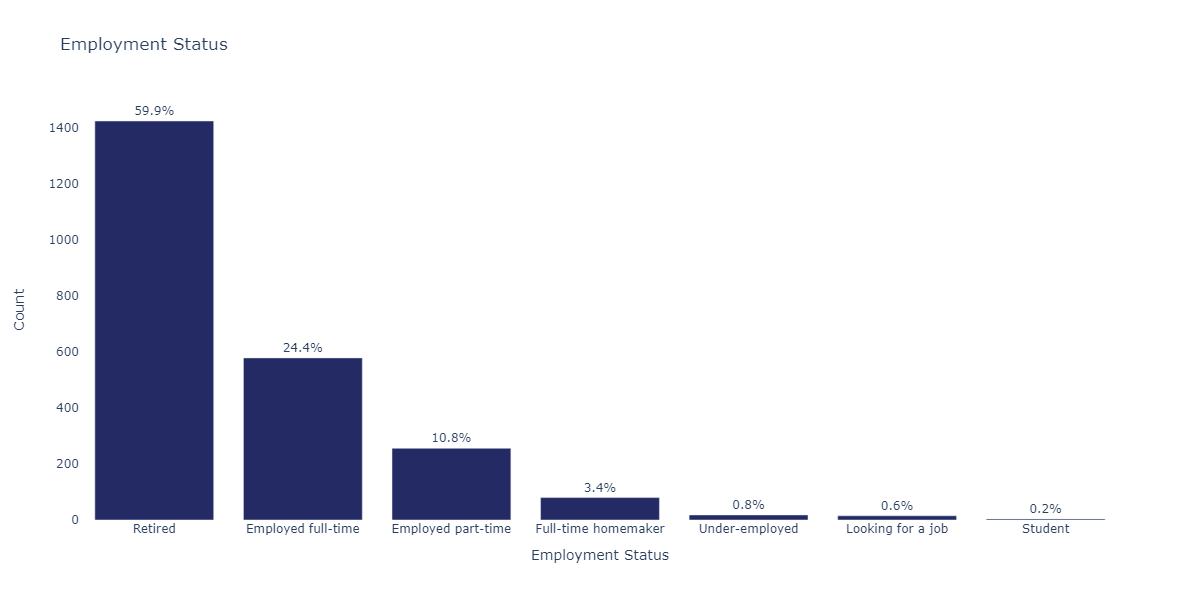

- Of the respondents, their employment statuses are as follows:  (From 2377 responses)
    - Retired: **60%**
    - Employed full-time: **24%**
    - Employed part-time: **11%**
    - Full-time homemaker: **3%**
    - Under-employed: **1%**
    - Looking for a job: **1%**
    - Student: **0%**


In [110]:
### Employment ###
question = all_responses.columns[77]

column_data = all_responses[question].loc[all_responses[question] != 'Prefer not to answer'].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Employment Status',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Employment Status',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1200
)

# Show the figure
fig.write_image("./IMG/employment.png")
display(Image(filename="./IMG/employment.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, their employment statuses are as follows:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{round(value)}%**\n"

display(Markdown(markdown_text))

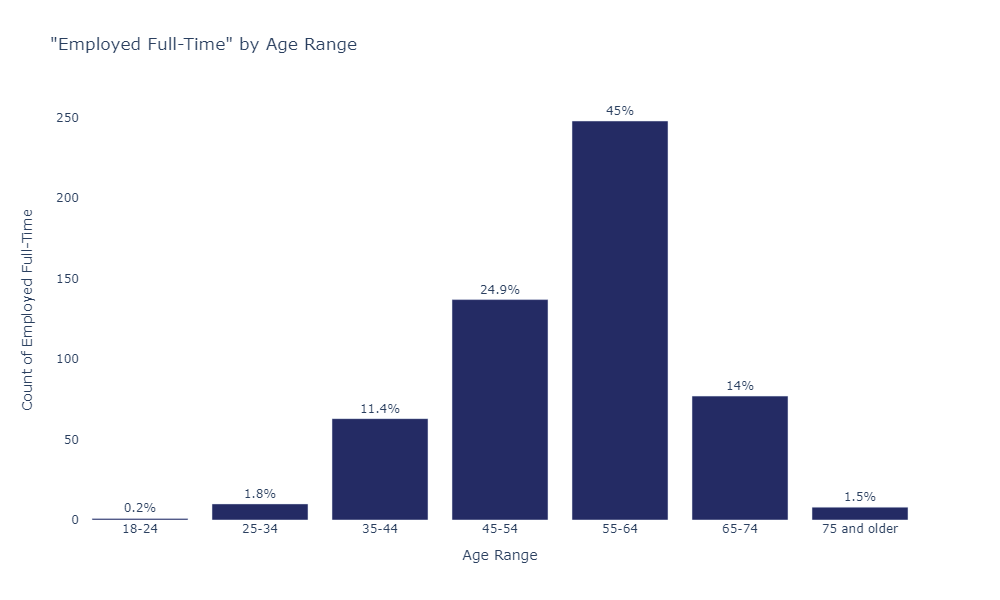

- Of those who responded 'Employed Full-Time': (From 579 responses.)
    - For ages 55-64: **45.0%**
    - For ages 45-54: **24.9%**
    - For ages 65-74: **14.0%**
    - For ages 35-44: **11.4%**
    - For ages 25-34: **1.8%**
    - For ages 75 and older: **1.5%**
    - For ages 18-24: **0.2%**


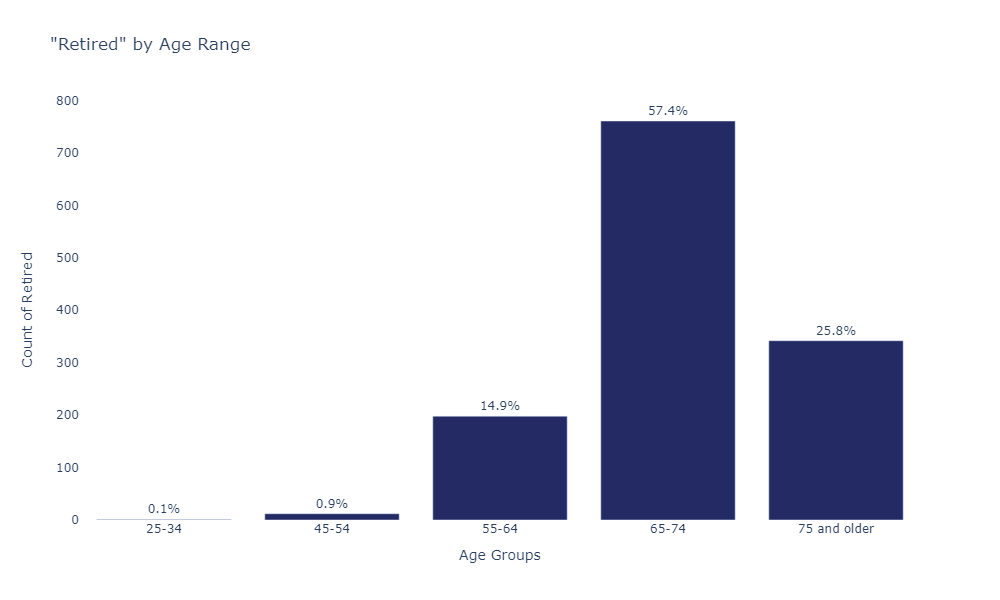

- Of those who responded 'Retired': (From 1425 responses.)
    - For ages 65-74: **57.4%**
    - For ages 75 and older: **25.8%**
    - For ages 55-64: **14.9%**
    - For ages 45-54: **0.9%**
    - For ages 25-34: **0.1%**


In [111]:
# Assuming all_responses is your DataFrame
age_column = all_responses.columns[75]
employment_status_column = all_responses.columns[77]

# Filter for 'Employed full-time'
employed_full_time = all_responses[all_responses[employment_status_column] == 'Employed full-time']
sample_size = employed_full_time.shape[0]

# Filter based on age range
age_data = employed_full_time[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Employed Full-Time" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Range',
    yaxis_title='Count of Employed Full-Time',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)

# Save and display the figure
fig.write_image("./IMG/employed_full_time_by_age.png")
display(Image(filename="./IMG/employed_full_time_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Employed Full-Time': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - For ages {age_group}: **{percentage}%**\n"

display(Markdown(markdown_text))

# Filter for 'Retired'
retired = all_responses[all_responses[employment_status_column] == 'Retired']
sample_size = retired.shape[0]

# Filter based on age range
age_data = retired[age_column].dropna()

# Calculate counts and percentages
value_counts = age_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = age_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Define the age categories in ascending order
categories = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Convert 'Category' into an ordered categorical type
summary_df['Category'] = pd.Categorical(summary_df['Category'], categories=categories, ordered=True)
summary_df = summary_df.sort_values('Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='"Retired" by Age Range',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Groups',
    yaxis_title='Count of Retired',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=1000
)

# Save and display the figure
fig.write_image("./IMG/retired_by_age.png")
display(Image(filename="./IMG/retired_by_age.png"))


# Sort summary_df by 'Percentage' in descending order for display
summary_df_sorted = summary_df.sort_values('Percentage', ascending=False).dropna()

markdown_text = f"- Of those who responded 'Retired': (From {sample_size} responses.)\n"
for row in summary_df_sorted.itertuples():
    age_group = row.Category
    percentage = row.Percentage
    # Ensure each line is indented under the introductory sentence
    markdown_text += f"    - For ages {age_group}: **{percentage}%**\n"

display(Markdown(markdown_text))


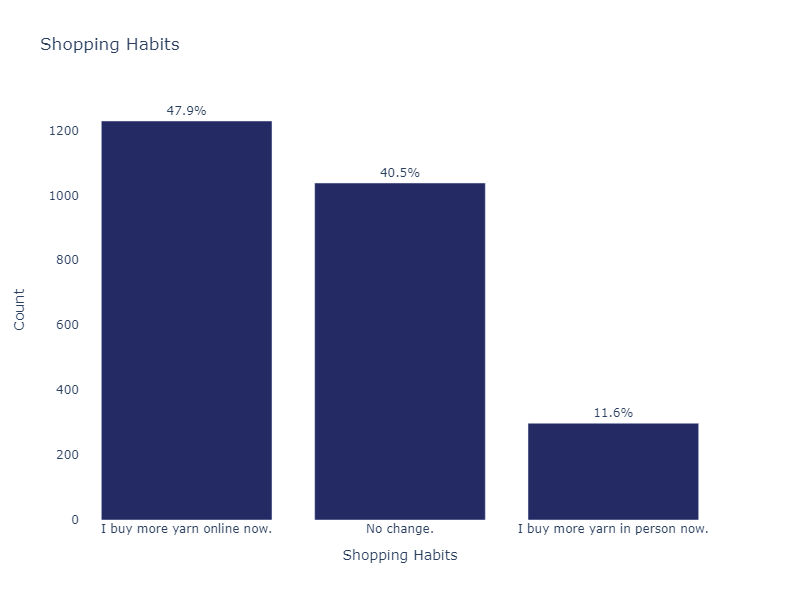

- Of the respondents, they reported that their shopping habbits have changed:  (From 2565 responses)
    - I buy more yarn online now.: **48%**
    - No change.: **40%**
    - I buy more yarn in person now.: **12%**


In [112]:
### Employment ###
question = all_responses.columns[20]

column_data = all_responses[all_responses.columns[20]].dropna()
sample_size = column_data.shape[0]

# Calculate counts and percentages
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']
# Merge counts with percentages
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Shopping Habits',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Habits',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/shopping_habbits.png")
display(Image(filename="./IMG/shopping_habbits.png"))

summary = (all_responses[question][all_responses[question] != 'Prefer not to answer'].dropna().value_counts(normalize=True) * 100)

# Formatting the output as a numbered list
markdown_text = f"- Of the respondents, they reported that their shopping habbits have changed:  (From {sample_size} responses)\n"
for i, (key, value) in enumerate(summary.items(), 1):
    markdown_text += f"    - {key}: **{round(value)}%**\n"

display(Markdown(markdown_text))

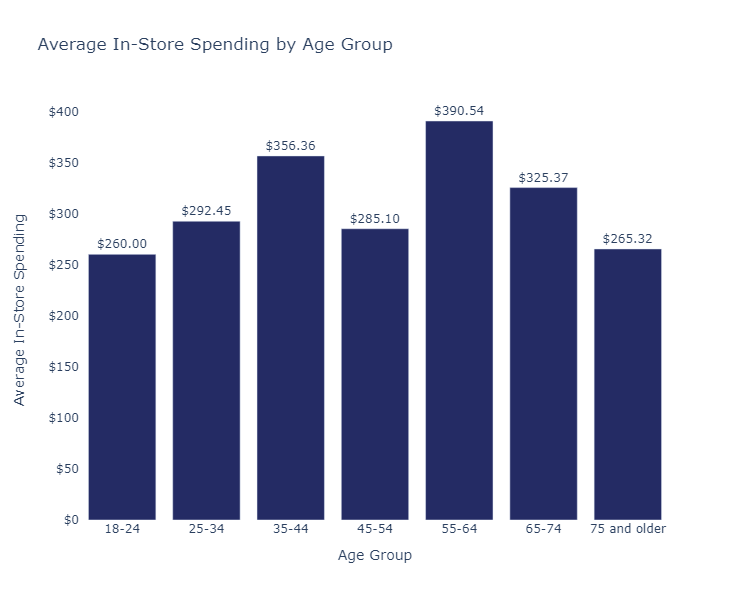

- Respondents reported making **5.0** purchases in-store per year on average, spending an average **\$64.62** per visit. On average spending **\$325.22** a year. (From 2339 responses.)
     - For ages 18-24: **6.5** purchases in-store per year, spending **\$40.00** per visit. On average spending **\$260.00** a year.
     - For ages 25-34: **5.1** purchases in-store per year, spending **\$57.06** per visit. On average spending **\$292.45** a year.
     - For ages 35-44: **4.9** purchases in-store per year, spending **\$72.56** per visit. On average spending **\$356.36** a year.
     - For ages 45-54: **4.7** purchases in-store per year, spending **\$60.26** per visit. On average spending **\$285.10** a year.
     - For ages 55-64: **5.4** purchases in-store per year, spending **\$71.90** per visit. On average spending **\$390.54** a year.
     - For ages 65-74: **5.1** purchases in-store per year, spending **\$63.83** per visit. On average spending **\$325.37** a year.
     - For ages 75 and older: **4.6** purchases in-store per year, spending **\$57.19** per visit. On average spending **\$265.32** a year.

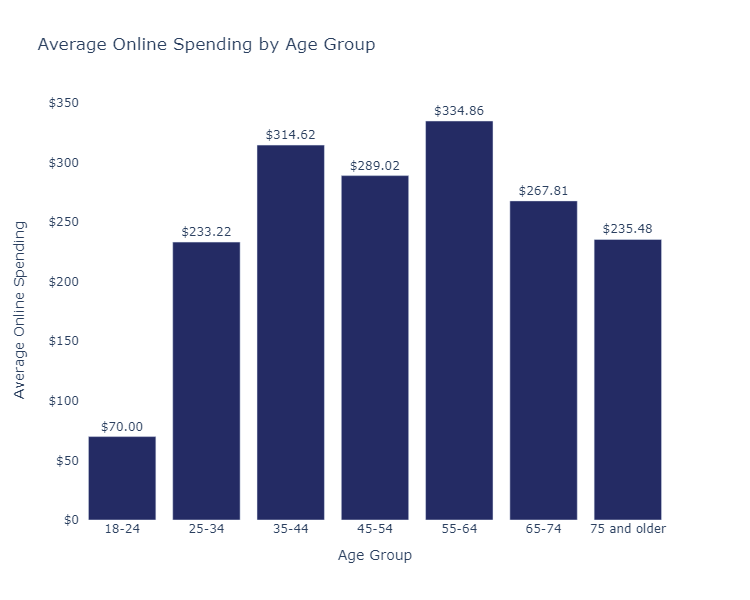

- Respondents reported making **4.4** purchases online per year on average, spending an average **\$63.20** per visit. On average spending **\$277.03** a year. (From 2392 responses.)
     - For ages 18-24: **2.0** purchases in-store per year, spending **\$35.00** per visit. On average spending **\$70.00** a year.
     - For ages 25-34: **4.2** purchases in-store per year, spending **\$54.88** per visit. On average spending **\$233.22** a year.
     - For ages 35-44: **4.4** purchases in-store per year, spending **\$72.25** per visit. On average spending **\$314.62** a year.
     - For ages 45-54: **4.5** purchases in-store per year, spending **\$63.69** per visit. On average spending **\$289.02** a year.
     - For ages 55-64: **4.7** purchases in-store per year, spending **\$70.86** per visit. On average spending **\$334.86** a year.
     - For ages 65-74: **4.3** purchases in-store per year, spending **\$61.91** per visit. On average spending **\$267.81** a year.
     - For ages 75 and older: **4.1** purchases in-store per year, spending **\$57.21** per visit. On average spending **\$235.48** a year.

In [113]:
# Function to number to string
def assign_count(value):
    if value == '10+':
        return 10
    else:
        return value

# Function to assign middle value
def assign_middle_price(value):
    if value == '$200 +':
        return 200
    elif value == '$0':
        return 0
    else:
        low, high = value.replace('$', '').split(' - ')
        return (int(low) + int(high)) // 2

# Combining all the columns into one dataframe
share_of_wallet = pd.concat([all_responses[[all_responses.columns[21], all_responses.columns[22], all_responses.columns[23], all_responses.columns[24], all_responses.columns[75]]]], axis=1)

# Clean up entries of "10+"
share_of_wallet.iloc[:, [0, 2]] = share_of_wallet.iloc[:, [0, 2]].apply(lambda x: x.apply(lambda y: assign_count(y) if pd.notnull(y) else y))

# Clean up entries of "200+" and remove $.
share_of_wallet.iloc[:, [1, 3]] = share_of_wallet.iloc[:, [1, 3]].apply(lambda x: x.apply(lambda y: assign_middle_price(y) if pd.notnull(y) else y))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
filtered_df = share_of_wallet[share_of_wallet.iloc[:, 4] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
filtered_df[filtered_df.columns[4]] = pd.Categorical(filtered_df[filtered_df.columns[4]], categories=ages, ordered=True)

# Convert 'Age Group' column to a categorical type with specified order
filtered_df['Age Group'] = filtered_df[filtered_df.columns[4]]
filtered_df['Age Group'] = pd.Categorical(filtered_df['Age Group'], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_instore_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_instore_by_group = total_instore_by_group.reset_index().rename(columns={0: 'Total In-Store'})

# Create the bar graph
fig = px.bar(total_instore_by_group, x='Age Group', y='Total In-Store', title='Average In-Store Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_instore_by_group['Total In-Store']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average In-Store Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/instore_spend_by_age.png")
display(Image(filename="./IMG/instore_spend_by_age.png"))

# Markdown variables
sample_size_instore = share_of_wallet.iloc[:, 0].dropna().count()
avg_purchases_instore = share_of_wallet.iloc[:, 0].astype(float).mean()
avg_spending_instore = share_of_wallet.iloc[:, 1].astype(float).mean()
total_instore = avg_purchases_instore * avg_spending_instore

markdown_part1 = f"- Respondents reported making **{avg_purchases_instore:.1f}** purchases in-store per year on average, spending an average **\${avg_spending_instore:.2f}** per visit. On average spending **\${total_instore:.2f}** a year. (From {sample_size_instore} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_instore = frame.iloc[:, 0].dropna().count()
    group_avg_purchases_instore = frame.iloc[:, 0].astype(float).mean()
    group_avg_spending_instore = frame.iloc[:, 1].astype(float).mean()
    group_total_instore = group_avg_purchases_instore * group_avg_spending_instore
    # Append the group metrics to the markdown text
    markdown_part1 += f"\n     - For ages {group}: **{group_avg_purchases_instore:.1f}** purchases in-store per year, spending **\${group_avg_spending_instore:.2f}** per visit. On average spending **\${group_total_instore:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part1))

# Calculate the mean of the two columns by group
mean_purchases_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[2]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
mean_spending_by_group = filtered_df.groupby('Age Group', observed=True)[filtered_df.columns[3]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

# Multiply the means to get 'Total In-Store' for each group
total_online_by_group = mean_purchases_by_group * mean_spending_by_group

# Reset index to use in Plotly Express and rename columns for clarity
total_online_by_group = total_online_by_group.reset_index().rename(columns={0: 'Total Online'})

# Create the bar graph
fig = px.bar(total_online_by_group, x='Age Group', y='Total Online', title='Average Online Spending by Age Group',
             text=[f"${v:,.2f}" for v in total_online_by_group['Total Online']], color_discrete_sequence=['#242B64'])

# Customization for displaying formatted values above bars
fig.update_traces(texttemplate='%{text}', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Age Group',
    yaxis_title='Average Online Spending',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750,
    yaxis_tickprefix="$",
    yaxis_tickformat=","
)

# Save and display the figure
fig.write_image("./IMG/online_spend_by_age.png")
display(Image(filename="./IMG/online_spend_by_age.png"))

# Markdown variables
sample_size_online = share_of_wallet.iloc[:, 2].dropna().count()
avg_purchases_online = share_of_wallet.iloc[:, 2].astype(float).mean()
avg_spending_online = share_of_wallet.iloc[:, 3].astype(float).mean()
total_online = avg_purchases_online * avg_spending_online

markdown_part2 = f"- Respondents reported making **{avg_purchases_online:.1f}** purchases online per year on average, spending an average **\${avg_spending_online:.2f}** per visit. On average spending **\${total_online:.2f}** a year. (From {sample_size_online} responses.)"

# Group by the demographic data in column [75] and calculate metrics
for group, frame in filtered_df.groupby(filtered_df.columns[4], observed=True):
    #group_sample_size_online = frame.iloc[:, 2].dropna().count()
    group_avg_purchases_online = frame.iloc[:, 2].astype(float).mean()
    group_avg_spending_online = frame.iloc[:, 3].astype(float).mean()
    group_total_online = group_avg_purchases_online * group_avg_spending_online
    # Append the group metrics to the markdown text
    markdown_part2 += f"\n     - For ages {group}: **{group_avg_purchases_online:.1f}** purchases in-store per year, spending **\${group_avg_spending_online:.2f}** per visit. On average spending **\${group_total_online:.2f}** a year."

# Display the markdown text
display(Markdown(markdown_part2))

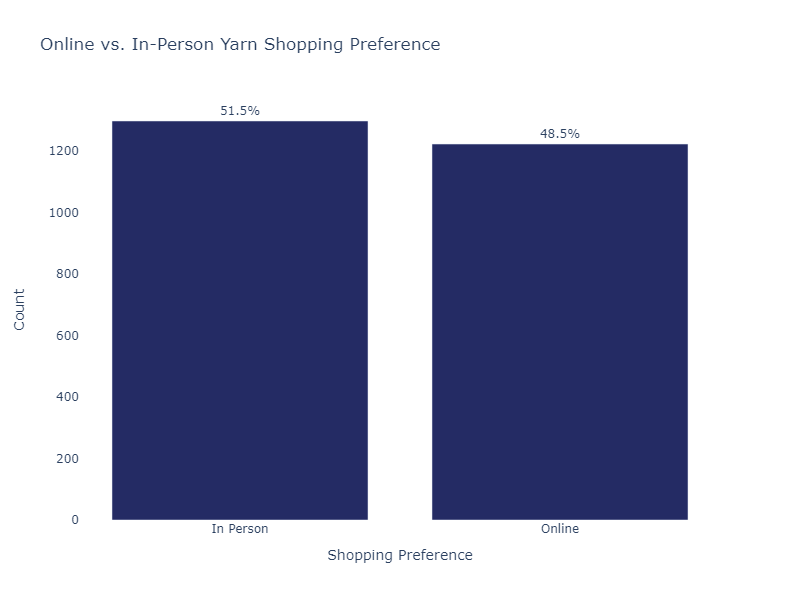

- Of the respondents **45.7%** preferred online shopping for yarn, while **48.47%** preferred shopping in person for yarn. (From 2519 responses.)
     - For ages Under 18: **nan%** preferred shopping online, **nan%** preferred shopping in person.
     - For ages 18-24: **0.0%** preferred shopping online, **100.0%** preferred shopping in person.
     - For ages 25-34: **43.8%** preferred shopping online, **50.0%** preferred shopping in person.
     - For ages 35-44: **48.9%** preferred shopping online, **50.0%** preferred shopping in person.
     - For ages 45-54: **58.8%** preferred shopping online, **40.8%** preferred shopping in person.
     - For ages 55-64: **47.0%** preferred shopping online, **50.0%** preferred shopping in person.
     - For ages 65-74: **47.0%** preferred shopping online, **50.9%** preferred shopping in person.
     - For ages 75 and older: **44.3%** preferred shopping online, **51.9%** preferred shopping in person.

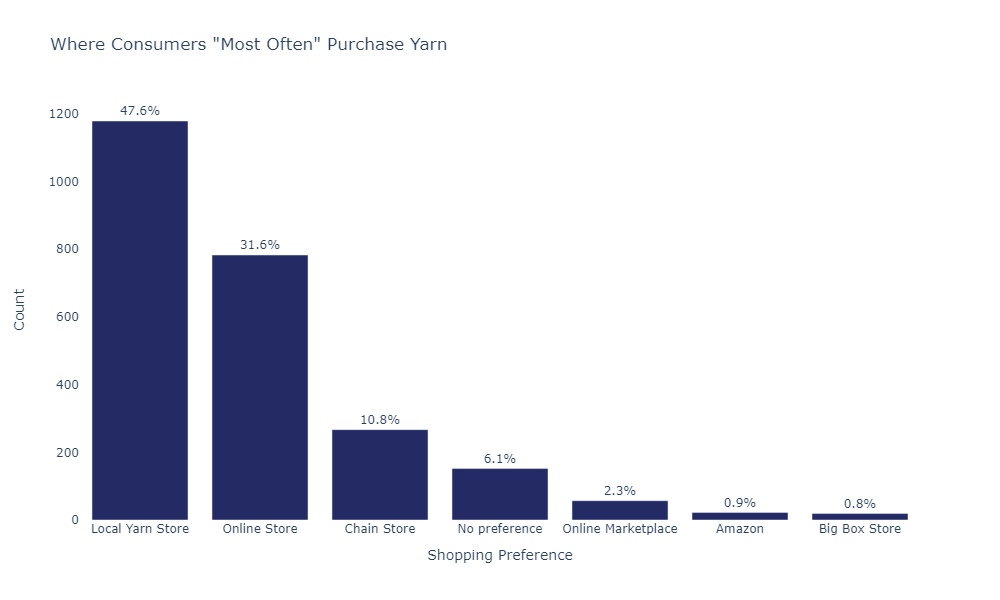

In [114]:
question = all_responses.columns[14]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Yarn Shopping Preference',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_shopping.png")
display(Image(filename="./IMG/yarn_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[14], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for yarn, while **{inperson_percent:.2f}%** preferred shopping in person for yarn. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[15]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Yarn',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/yarn_shopping_location.png")
display(Image(filename="./IMG/yarn_shopping_location.png"))

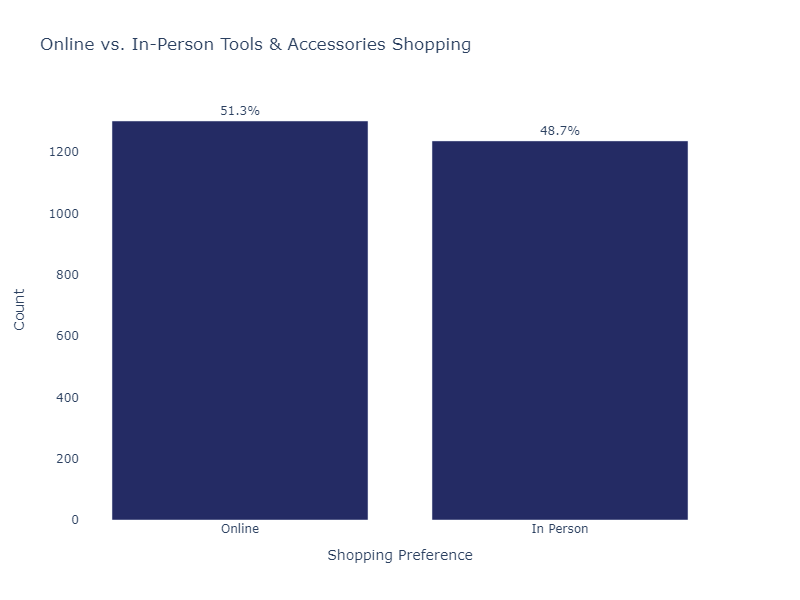

- Of the respondents **48.7%** preferred online shopping for tools & accessories, while **46.23%** preferred shopping in person for tools & accessories. (From 2539 responses.)
     - For ages Under 18: **nan%** preferred shopping online, **nan%** preferred shopping in person.
     - For ages 18-24: **0.0%** preferred shopping online, **100.0%** preferred shopping in person.
     - For ages 25-34: **56.2%** preferred shopping online, **43.8%** preferred shopping in person.
     - For ages 35-44: **58.0%** preferred shopping online, **40.9%** preferred shopping in person.
     - For ages 45-54: **62.7%** preferred shopping online, **36.5%** preferred shopping in person.
     - For ages 55-64: **49.2%** preferred shopping online, **49.2%** preferred shopping in person.
     - For ages 65-74: **49.5%** preferred shopping online, **48.6%** preferred shopping in person.
     - For ages 75 and older: **47.6%** preferred shopping online, **50.6%** preferred shopping in person.

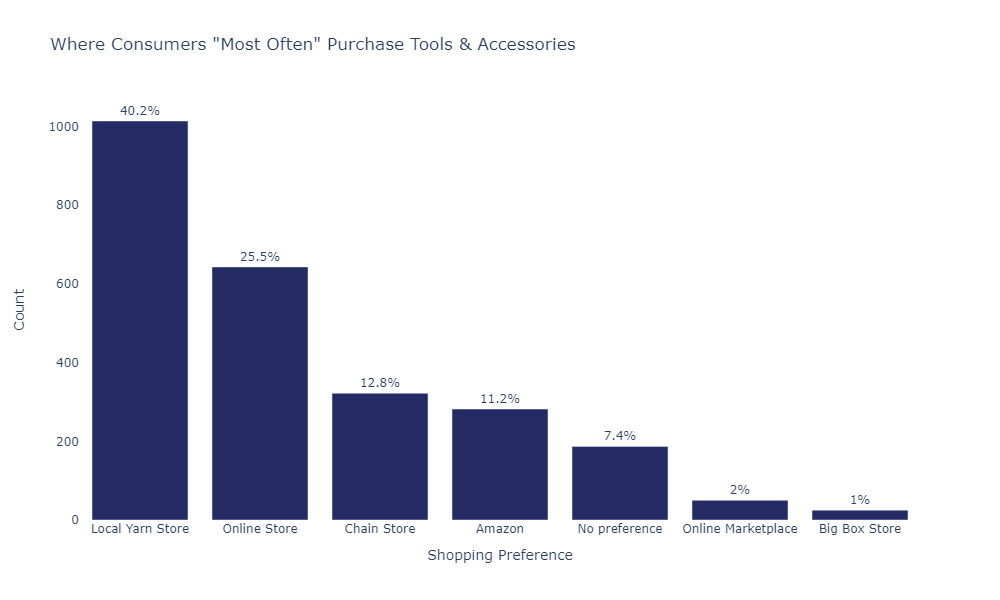

In [115]:
question = all_responses.columns[16]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Tools & Accessories Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/tool_shopping.png")
display(Image(filename="./IMG/tool_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[16], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for tools & accessories, while **{inperson_percent:.2f}%** preferred shopping in person for tools & accessories. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[17]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Tools & Accessories',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000
)

# Show the figure
fig.write_image("./IMG/tool_shopping_location.png")
display(Image(filename="./IMG/tool_shopping_location.png"))

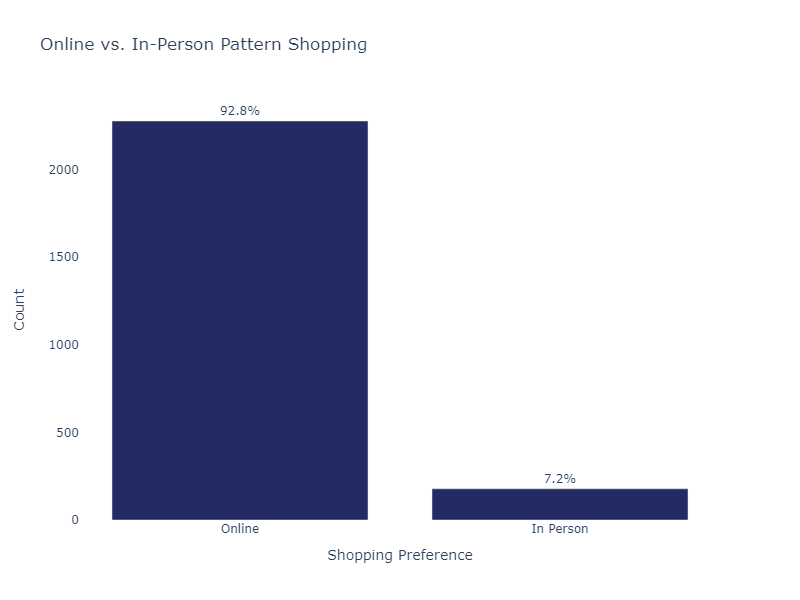

- Of the respondents **85.1%** preferred online shopping for patterns, while **6.65%** preferred shopping in person for patterns. (From 2456 responses.)
     - For ages Under 18: **nan%** preferred shopping online, **nan%** preferred shopping in person.
     - For ages 18-24: **100.0%** preferred shopping online, **0.0%** preferred shopping in person.
     - For ages 25-34: **87.5%** preferred shopping online, **6.2%** preferred shopping in person.
     - For ages 35-44: **94.3%** preferred shopping online, **2.3%** preferred shopping in person.
     - For ages 45-54: **91.0%** preferred shopping online, **3.9%** preferred shopping in person.
     - For ages 55-64: **91.6%** preferred shopping online, **3.9%** preferred shopping in person.
     - For ages 65-74: **88.3%** preferred shopping online, **7.0%** preferred shopping in person.
     - For ages 75 and older: **82.6%** preferred shopping online, **11.6%** preferred shopping in person.

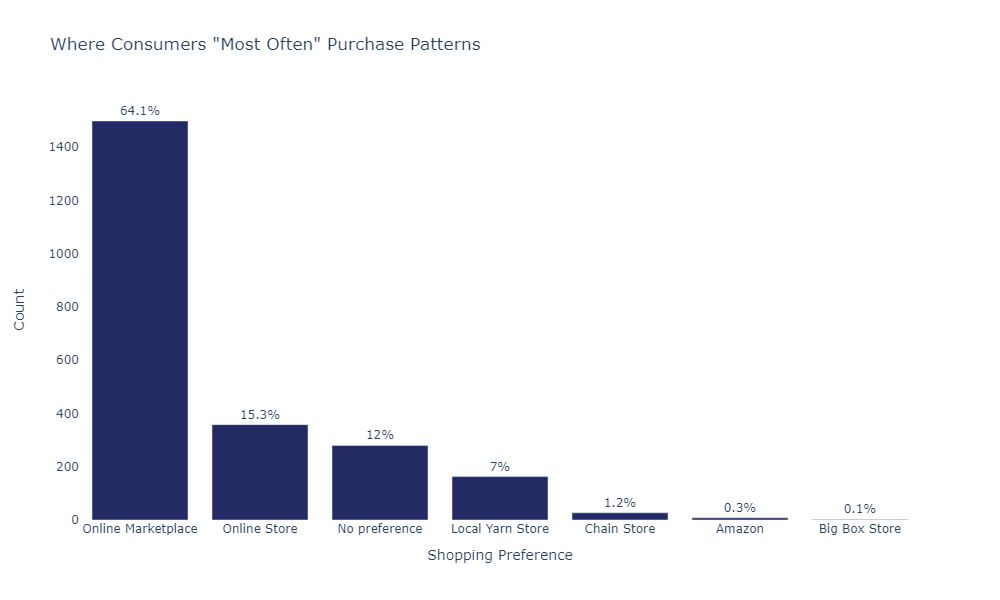

In [116]:
question = all_responses.columns[18]

column_data = all_responses.loc[all_responses[question].isin(['Online', 'In Person']), question]
sample_size = column_data.shape[0]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Online vs. In-Person Pattern Shopping',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/pattern_shopping.png")
display(Image(filename="./IMG/pattern_shopping.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Combining all the columns into one dataframe
shopping_preference = pd.concat([all_responses[[all_responses.columns[18], all_responses.columns[75]]]], axis=1)

# Variables
# Overall percentage of respondents who answered 'Online'
online_percent = (shopping_preference[shopping_preference.columns[0]] == 'Online').mean() * 100
# Overall percentage of respondents who answered 'In Person'
inperson_percent = (shopping_preference[shopping_preference.columns[0]] == 'In Person').mean() * 100

# Initialize the markdown string
markdown_summary = f"- Of the respondents **{online_percent:.1f}%** preferred online shopping for patterns, while **{inperson_percent:.2f}%** preferred shopping in person for patterns. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = shopping_preference[shopping_preference[shopping_preference.columns[1]] == age]
    
    # Calculate the percentages for 'Online' and 'In Person' within the current age group
    online_percent = (age_group_df[age_group_df.columns[0]] == 'Online').mean() * 100
    inperson_percent = (age_group_df[age_group_df.columns[0]] == 'In Person').mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: **{online_percent:.1f}%** preferred shopping online, **{inperson_percent:.1f}%** preferred shopping in person."

# Display the markdown summary
display(Markdown(markdown_summary))

### Graph #### 

question = all_responses.columns[19]

column_data = all_responses.loc[all_responses[question].isin(['Amazon', 'Big Box Store (Walmart, Target, etc...)', 'Chain Store (Joann\'s, Michaels, Hobby Lobby, etc...)', 'Local Yarn Store', 'Online Store (Knitpicks, Crochet.com, etc...)', 'Online Marketplace (Facebook, Etsy, Ravelry, etc...)', 'No preference']), question]
sample_size = column_data.shape[0]

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data = column_data.str.replace(r"\(.+?\)", "", regex=True)
column_data = column_data.str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Where Consumers "Most Often" Purchase Patterns',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')
 
# Customization for layout
fig.update_layout(
    xaxis_title='Shopping Preference',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/pattern_shopping_location.png")
display(Image(filename="./IMG/pattern_shopping_location.png"))

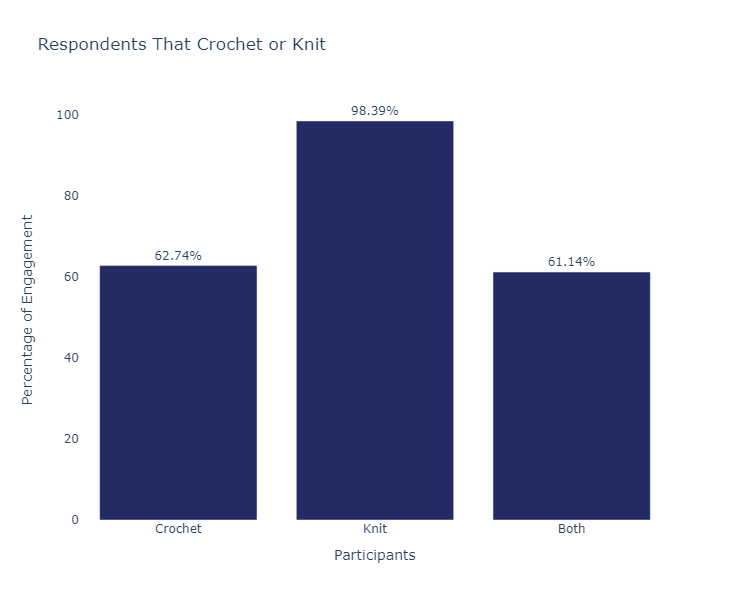

- Of the respondents, **62.7%** responded 'Yes' to crocheting, **98.39%** responded 'Yes' to knitting, while **61.14%** of respondents engage in both. (From 2676 responses.)
     - For ages Under 18, **nan%** crochet, **nan%** knit, and **nan%** do both.
     - For ages 18-24, **100.0%** crochet, **100.0%** knit, and **100.0%** do both.
     - For ages 25-34, **75.0%** crochet, **87.5%** knit, and **62.5%** do both.
     - For ages 35-44, **70.5%** crochet, **96.6%** knit, and **67.0%** do both.
     - For ages 45-54, **67.8%** crochet, **97.9%** knit, and **65.7%** do both.
     - For ages 55-64, **66.9%** crochet, **97.8%** knit, and **64.7%** do both.
     - For ages 65-74, **62.1%** crochet, **98.7%** knit, and **60.8%** do both.
     - For ages 75 and older, **53.4%** crochet, **99.5%** knit, and **52.9%** do both.

In [117]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[4], all_responses.columns[7], all_responses.columns[75]]]], axis=1)

percent_yes = column_data[['Do you crochet?', 'Do you knit?']].apply(lambda x: (x == 'Yes').mean()) * 100
both_yes_percent = column_data[(column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')].shape[0] / column_data.shape[0] * 100
 
data = {'Crafting Type': ['Crochet', 'Knit'], 'Percentage': percent_yes.values}

# Update the data dictionary to include the new category
data['Crafting Type'].append('Both')
data['Percentage'] = np.append(data['Percentage'], both_yes_percent)

df = pd.DataFrame(data)

fig = px.bar(
    df,
    x='Crafting Type',
    y='Percentage',
    text='Percentage',
    title='Respondents That Crochet or Knit',
    color_discrete_sequence=['#242B64']
)

# Adding text on bars for the percentage value
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Participants',
    yaxis_title='Percentage of Engagement',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    height=600,
    width=750
)

# Save and display the figure
fig.write_image("./IMG/crafting_participation.png")
display(Image(filename="./IMG/crafting_participation.png"))

# Define age order for consistent output
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']

# Variables
# Overall percentage of respondents who answered 'Yes' to crocheting
crochet_yes_percent = (column_data['Do you crochet?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to knitting
knit_yes_percent = (column_data['Do you knit?'] == 'Yes').mean() * 100
# Overall percentage of respondents who answered 'Yes' to both crocheting and knitting
both_yes_percent = ((column_data['Do you crochet?'] == 'Yes') & (column_data['Do you knit?'] == 'Yes')).mean() * 100
# Total sample size
sample_size = column_data.shape[0]

# Initialize the markdown string
markdown_summary = f"- Of the respondents, **{crochet_yes_percent:.1f}%** responded 'Yes' to crocheting, **{knit_yes_percent:.2f}%** responded 'Yes' to knitting, while **{both_yes_percent:.2f}%** of respondents engage in both. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data['What is your current age?  '] == age]
    
    # Calculate the percentages and sample size for the current age group
    crochet_yes_percent = (age_group_df['Do you crochet?'] == 'Yes').mean() * 100
    knit_yes_percent = (age_group_df['Do you knit?'] == 'Yes').mean() * 100
    both_yes_percent = ((age_group_df['Do you crochet?'] == 'Yes') & (age_group_df['Do you knit?'] == 'Yes')).mean() * 100
    
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}, **{crochet_yes_percent:.1f}%** crochet, **{knit_yes_percent:.1f}%** knit, and **{both_yes_percent:.1f}%** do both."

# Display the markdown summary
# Display the markdown text
display(Markdown(markdown_summary))

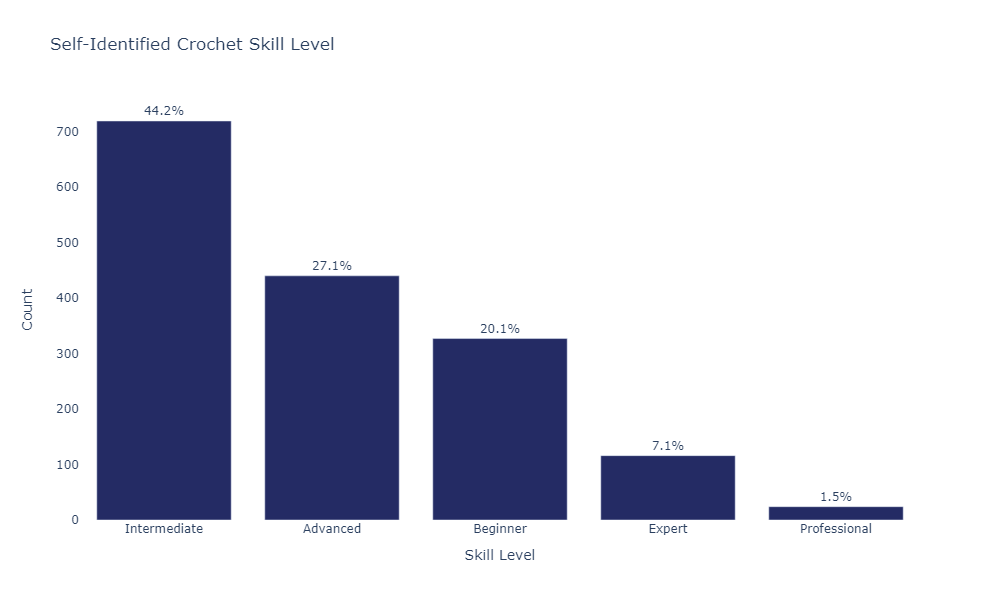

- Of the respondents who crochet, they rate their skill level as the following: (From 1679 responses.)
    - Intermediate: **44.22%**.
    - Advanced: **27.06%**.
    - Beginner: **20.11%**.
    - Expert: **7.13%**.
    - Professional: **1.48%**.


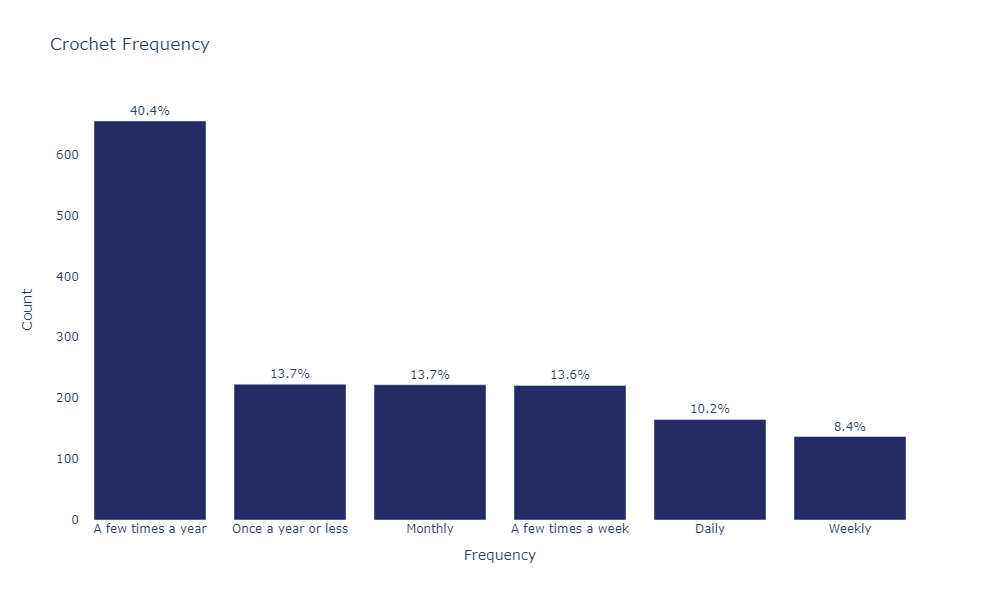

- Of the respondents who crochet, the frequency they do so is: (From 1679 responses.)
    -  A few times a year: **40.36%**
    -  Once a year or less: **13.74%**
    -  Monthly: **13.68%**
    -  A few times a week: **13.62%**
    -  Daily: **10.17%**
    -  Weekly: **8.44%**


In [118]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[5], all_responses.columns[6], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Crochet Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/crochet_skill.png")
display(Image(filename="./IMG/crochet_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who crochet, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Crochet Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1000,
    margin=dict(t=100)
)

# Show the figure
fig.write_image("./IMG/crochet_frequency.png")
display(Image(filename="./IMG/crochet_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who crochet, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    -  {answer}: **{percentage:.2f}%**\n"
    
display(Markdown(markdown_summary))

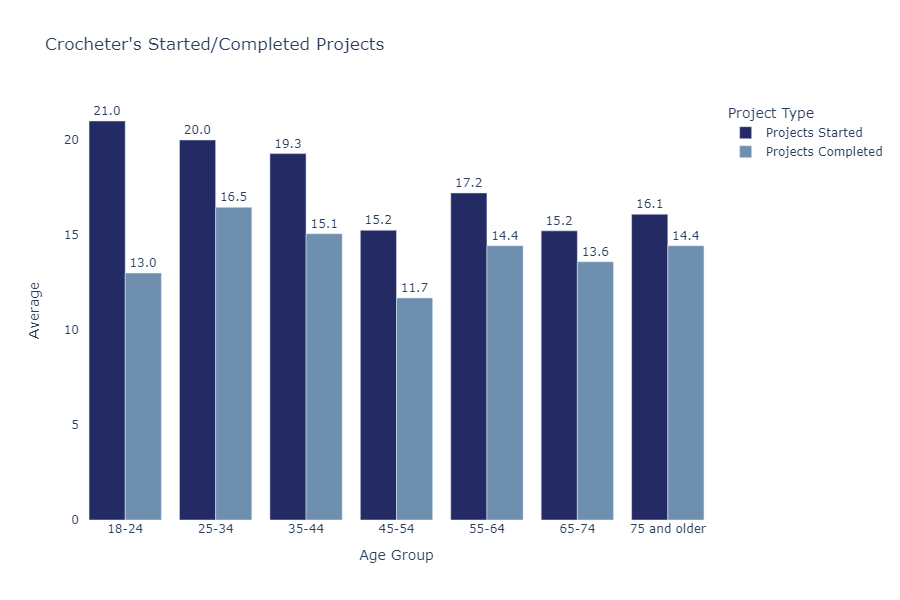

- Of the respondents, on average they start **16.1** crochet projects a year, and on average they complete **13.8** crochet projects a year. (From 1679 responses.)
     - For ages Under 18: They start **nan** projects, and complete **nan** projects a year.
     - For ages 18-24: They start **21.0** projects, and complete **13.0** projects a year.
     - For ages 25-34: They start **20.0** projects, and complete **16.5** projects a year.
     - For ages 35-44: They start **19.3** projects, and complete **15.1** projects a year.
     - For ages 45-54: They start **15.2** projects, and complete **11.7** projects a year.
     - For ages 55-64: They start **17.2** projects, and complete **14.4** projects a year.
     - For ages 65-74: They start **15.2** projects, and complete **13.6** projects a year.
     - For ages 75 and older: They start **16.1** projects, and complete **14.4** projects a year.

In [119]:
# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 4] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Crocheter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/crochet_projects.png")
display(Image(filename="./IMG/crochet_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondents, on average they start **{projects_started:.1f}** crochet projects a year, and on average they complete **{projects_completed:.1f}** crochet projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: They start **{projects_started:.1f}** projects, and complete **{projects_completed:.1f}** projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

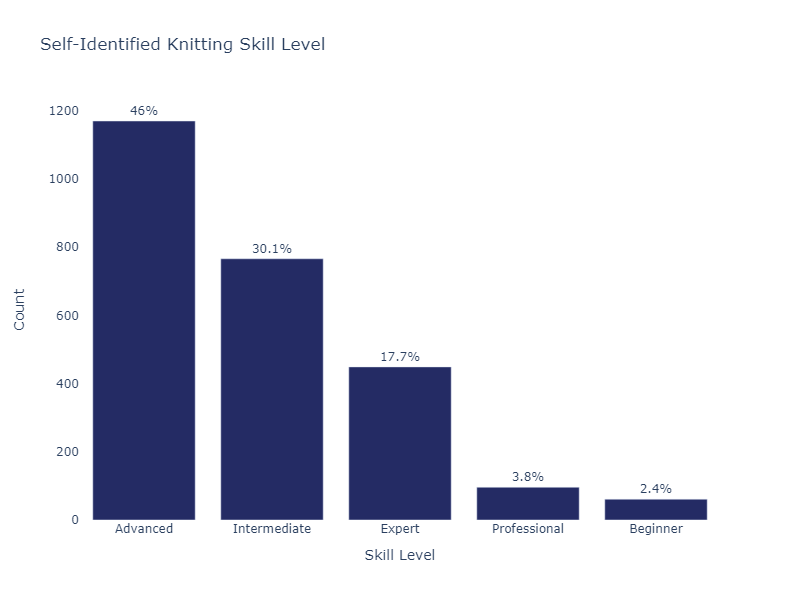

- Of the respondents who knit, they rate their skill level as the following: (From 2633 responses.)
    - Advanced: **46.03%**.
    - Intermediate: **30.13%**.
    - Expert: **17.66%**.
    - Professional: **3.78%**.
    - Beginner: **2.40%**.


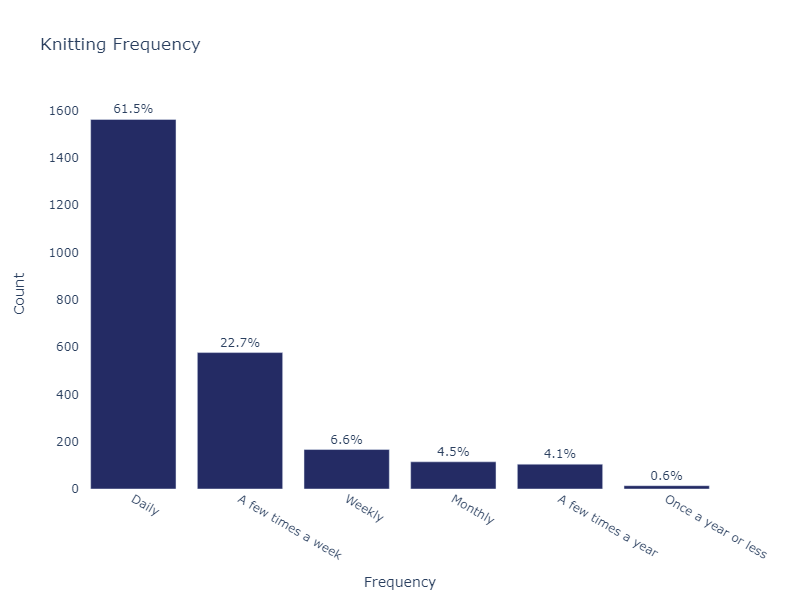

- Of the respondents who knit, the frequency they do so is: (From 2633 responses.)
    - Daily: **61.51%**.
    - A few times a week: **22.71%**.
    - Weekly: **6.57%**.
    - Monthly: **4.53%**.
    - A few times a year: **4.13%**.
    - Once a year or less: **0.55%**.


In [120]:
# Knitting Skill Level

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[8], all_responses.columns[9], all_responses.columns[75]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Self-Identified Knitting Skill Level',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Skill Level',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_skill.png")
display(Image(filename="./IMG/knitting_skill.png"))


# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who knit, they rate their skill level as the following: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

# How often do you crochet?

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 1].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 1].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Knitting Frequency',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/knitting_frequency.png")
display(Image(filename="./IMG/knitting_frequency.png"))

sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[1]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents who knit, the frequency they do so is: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.2f}%**.\n"
    
display(Markdown(markdown_summary))

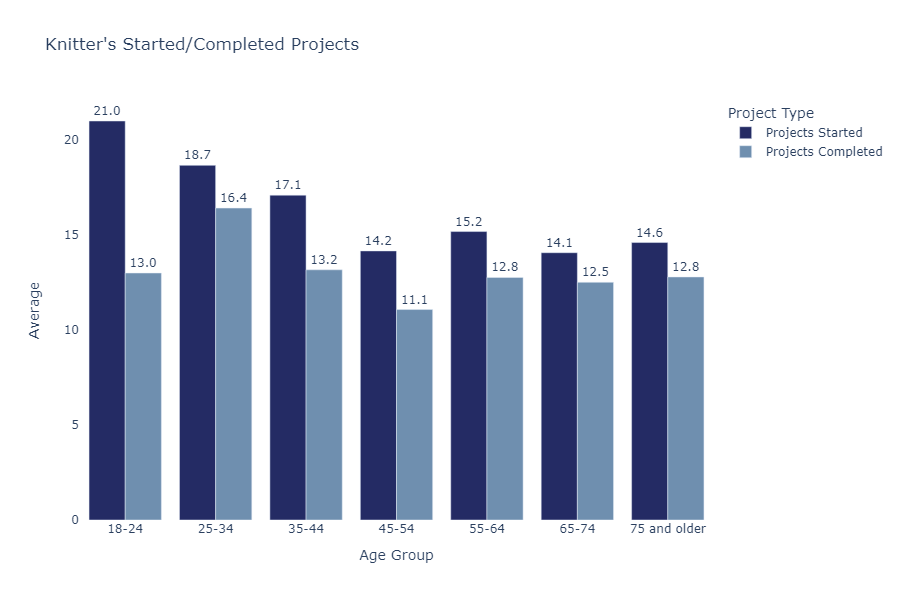

- Of the respondents, on average they start **14.6** knitting projects a year, and on average they complete **12.5** knitting projects a year. (From 2633 responses.)
     - For ages Under 18: They start **nan** projects, and complete **nan** projects a year.
     - For ages 18-24: They start **21.0** projects, and complete **13.0** projects a year.
     - For ages 25-34: They start **18.7** projects, and complete **16.4** projects a year.
     - For ages 35-44: They start **17.1** projects, and complete **13.2** projects a year.
     - For ages 45-54: They start **14.2** projects, and complete **11.1** projects a year.
     - For ages 55-64: They start **15.2** projects, and complete **12.8** projects a year.
     - For ages 65-74: They start **14.1** projects, and complete **12.5** projects a year.
     - For ages 75 and older: They start **14.6** projects, and complete **12.8** projects a year.

In [121]:
# Knitting Projects 

# Combining all the columns into one dataframe
filtered_rows = all_responses[all_responses.iloc[:, 7] == 'Yes']
column_data = filtered_rows[[all_responses.columns[46], all_responses.columns[47], all_responses.columns[75]]]

# Total sample size
sample_size = column_data.shape[0]

# Filter out extreme outliers (values above 100) in the first two columns
column_data[column_data.columns[0]] = pd.to_numeric(column_data[column_data.columns[0]], errors='coerce')
column_data[column_data.columns[1]] = pd.to_numeric(column_data[column_data.columns[1]], errors='coerce')
column_data = column_data[(column_data[column_data.columns[0]] <= 100) & (column_data[column_data.columns[1]] <= 100)]

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 2] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[2]] = pd.Categorical(column_data[column_data.columns[2]], categories=ages, ordered=True)

# Calculate the mean of the two columns by group
projects_started_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[0]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())
projects_completed_by_group = column_data.groupby(column_data[column_data.columns[2]], observed=True)[column_data.columns[1]].apply(lambda x: pd.to_numeric(x, errors='coerce').mean())

combined_data = pd.DataFrame({
    'Age Group': projects_started_by_group.index,
    'Projects Started': projects_started_by_group.values,
    'Projects Completed': projects_completed_by_group.values
})

# Melt the DataFrame
melted_data = pd.melt(combined_data, id_vars=['Age Group'], value_vars=['Projects Started', 'Projects Completed'],
                      var_name='Project Type', value_name='Average')

# Plot
fig = px.bar(melted_data, x='Age Group', y='Average', title='Knitter\'s Started/Completed Projects', color='Project Type', barmode='group',
             text='Average',  color_discrete_sequence=['#242B64', '#6F8FAF'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=900,
)

# Show the figure
fig.write_image("./IMG/knitting_projects.png")
display(Image(filename="./IMG/knitting_projects.png"))


# Overall percentage of respondents who answered 'Yes' to crocheting
projects_started = (column_data[column_data.columns[0]]).mean() 
# Overall percentage of respondents who answered 'Yes' to knitting
projects_completed = (column_data[column_data.columns[1]]).mean() 

# Initialize the markdown string
markdown_summary = f"- Of the respondents, on average they start **{projects_started:.1f}** knitting projects a year, and on average they complete **{projects_completed:.1f}** knitting projects a year. (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 2] == age]
    # Calculate the mean of projects started/completed.
    projects_started = (age_group_df[age_group_df.columns[0]]).mean() 
    projects_completed = (age_group_df[age_group_df.columns[1]]).mean() 
    # Append the calculated metrics to the markdown string
    markdown_summary += f"\n     - For ages {age}: They start **{projects_started:.1f}** projects, and complete **{projects_completed:.1f}** projects a year."

# Display the markdown text
display(Markdown(markdown_summary))

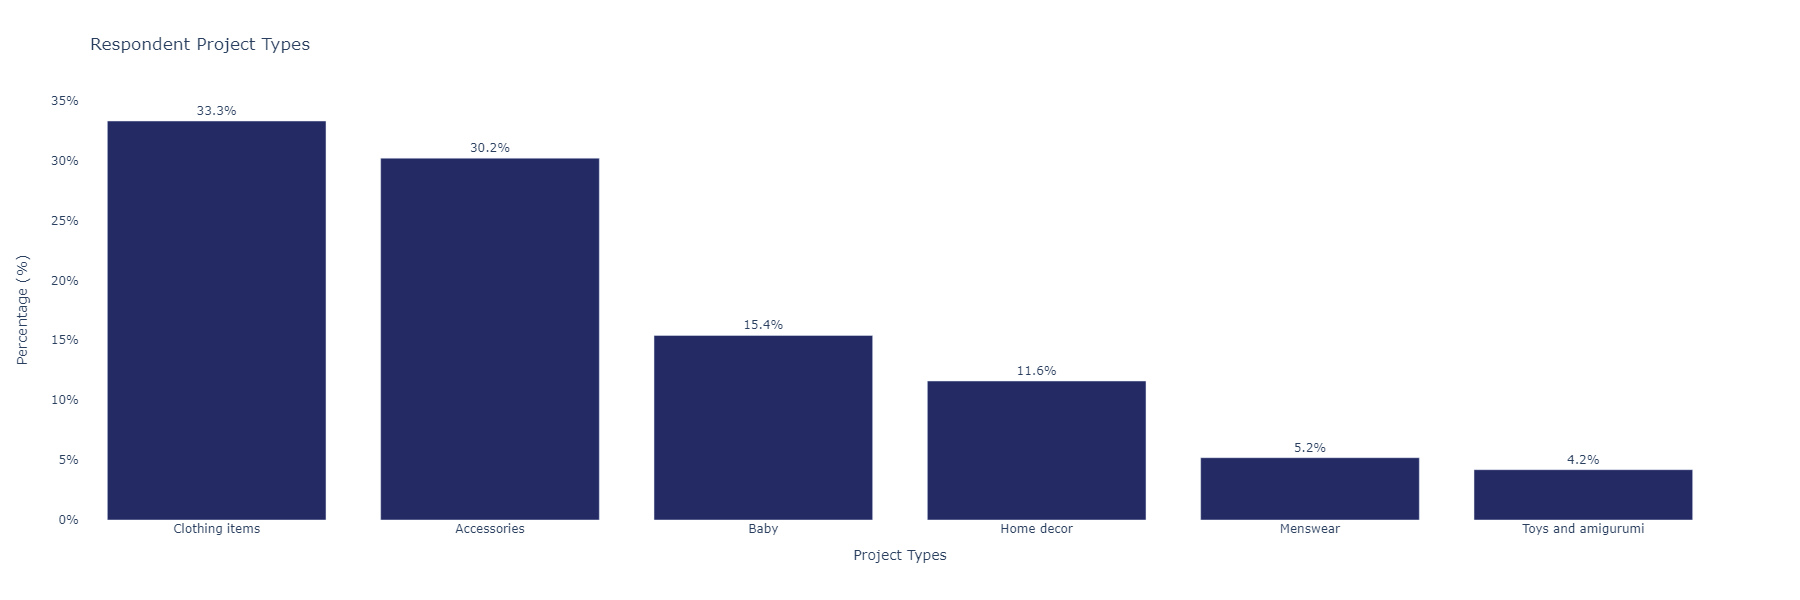

- Of the respondents, the most popular project type for all yarn crafts is: (From 2633 responses.)
     - For ages 18-24: The most popular types are **Accessories** **(40.0%)**, then **Clothing items** **(40.0%)**, followed by **Home decor** **(20.0%)**.
     - For ages 25-34: The most popular types are **Clothing items** **(40.0%)**, then **Accessories** **(27.5%)**, followed by **Toys and amigurumi** **(10.0%)**.
     - For ages 35-44: The most popular types are **Accessories** **(30.7%)**, then **Clothing items** **(30.7%)**, followed by **Baby** **(12.1%)**.
     - For ages 45-54: The most popular types are **Clothing items** **(32.9%)**, then **Accessories** **(29.9%)**, followed by **Home decor** **(14.3%)**.
     - For ages 55-64: The most popular types are **Clothing items** **(32.8%)**, then **Accessories** **(30.2%)**, followed by **Baby** **(15.4%)**.
     - For ages 65-74: The most popular types are **Clothing items** **(33.7%)**, then **Accessories** **(30.2%)**, followed by **Baby** **(16.5%)**.
     - For ages 75 and older: The most popular types are **Clothing items** **(33.5%)**, then **Accessories** **(30.2%)**, followed by **Baby** **(17.0%)**.

In [122]:
# Project Types

# Combining relevant columns into one DataFrame and dropping NaN values
column_data = pd.concat([all_responses[[all_responses.columns[41], all_responses.columns[75]]]], axis=1).dropna()

# Remove text within parentheses (including the parentheses themselves) and clean up spaces
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Split project types more robustly, considering possible variations in the use of spaces around commas
split_projects = column_data[column_data.columns[0]].str.split(r'\s*,\s*')

# Explode the DataFrame to separate rows for each project type mentioned per response
exploded_projects = split_projects.explode().reset_index(drop=True)

# Filter out empty or whitespace-only project types
exploded_projects = exploded_projects[exploded_projects.str.strip().astype(bool)]

# Count occurrences of each project type
project_counts = exploded_projects.value_counts().reset_index(name='Count')
project_counts.columns = ['Project', 'Count']

# Calculate the percentage of each project's occurrence
total_mentions = project_counts['Count'].sum()
project_counts['Percentage'] = (project_counts['Count'] / total_mentions * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per project type
fig = px.bar(project_counts, x='Project', y='Percentage',
             title='Respondent Project Types',
             labels={'Percentage': 'Percentage (%)', 'Project': 'Project Types'},
             text='Percentage', color_discrete_sequence=['#242B64'])

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    yaxis_ticksuffix="%",
)

# Show the figure
fig.write_image("./IMG/project_type_preference_revised.png")
display(Image(filename="./IMG/project_type_preference_revised.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular project type for all yarn crafts is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Correctly split the project types for the current age group, taking into account spaces around commas
        exploded_projects = age_group_df.iloc[:, 0].str.split(' , ').explode()
        # Calculate the value counts and percentages for the current age group's project types
        percentages = exploded_projects.value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Project', 'Percentage']
        # Check if there are at least two project types to report
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for both the most popular and the second most popular project types
            markdown_summary += f"\n     - For ages {age}: The most popular types are **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: The most popular types are **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one project type, mention only the most popular one
            markdown_summary += f"\n     - For ages{age}: The most popular type is **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]}%)**."
        else:
            # If there are no project types, perhaps include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no project types with significant data."

# Display the markdown text
display(Markdown(markdown_summary))

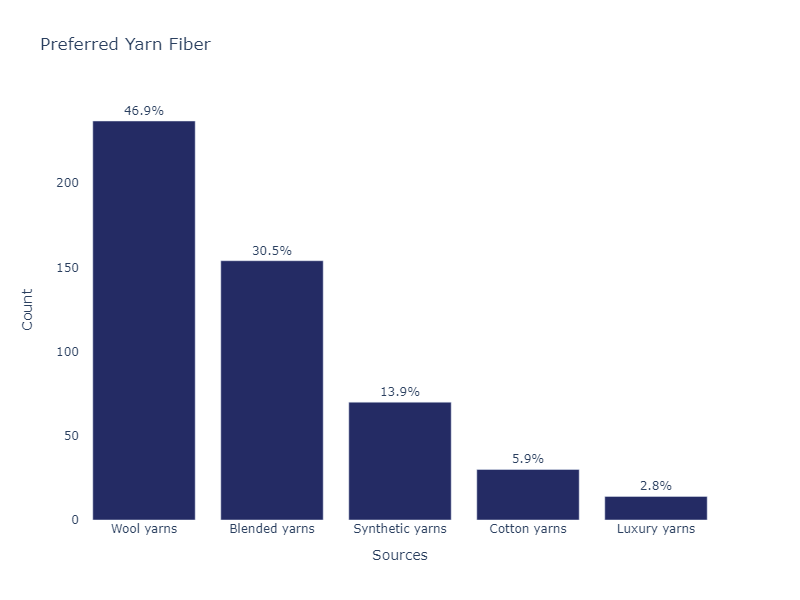

- Of the respondents, their preffered yarn fiber is: (From 505 responses.)
     - For ages 25-34: Preferred **Wool yarns** **(50.0%)** and **Synthetic yarns** **(50.0%)**.
     - For ages 35-44: Preferred **Wool yarns** **(52.6%)**, then **Blended yarns** **(26.3%)**, followed by **Synthetic yarns** **(15.8%)**.
     - For ages 45-54: Preferred **Wool yarns** **(45.5%)**, then **Blended yarns** **(34.1%)**, followed by **Synthetic yarns** **(11.4%)**.
     - For ages 55-64: Preferred **Wool yarns** **(57.6%)**, then **Blended yarns** **(30.3%)**, followed by **Synthetic yarns** **(6.1%)**.
     - For ages 65-74: Preferred **Wool yarns** **(46.3%)**, then **Blended yarns** **(31.0%)**, followed by **Synthetic yarns** **(12.3%)**.
     - For ages 75 and older: Preferred **Wool yarns** **(38.9%)**, then **Blended yarns** **(28.4%)**, followed by **Synthetic yarns** **(25.3%)**.

In [123]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[75]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = column_data.iloc[:, 0].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Preferred Yarn Fiber',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/yarn_fibers.png")
display(Image(filename="./IMG/yarn_fibers.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, their preffered yarn fiber is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred types with significant data."



# Display the markdown text
display(Markdown(markdown_summary))

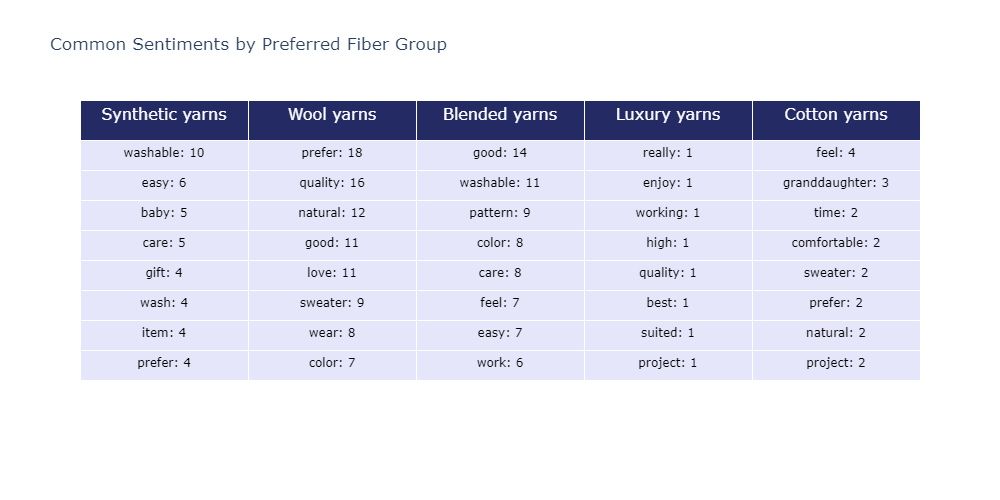

In [124]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[40], all_responses.columns[42]]]], axis=1)

categories = [
    'Wool yarns', 
    'Cotton yarns', 
    'Synthetic yarns (e.g., acrylic, nylon)', 
    'Luxury yarns (e.g., silk, cashmere)', 
    'Blended yarns'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Remove text within parentheses (including the parentheses themselves)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\(.+?\)", "", regex=True)
column_data[column_data.columns[0]] = column_data[column_data.columns[0]].str.replace(r"\s{2,}", " ", regex=True).str.strip()

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'fiber_group', column_data.columns[1]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)
column_data.dropna(subset=[column_data.columns[1]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'yarn',
    'yarns',
    'project',
    'fibers',
    'acrylic',
    'alpaca',
    'wool',
    'cotton',
    'synthetic',
    'luxury',
    'blended',
    'knit',
    'crochet',
    'like',
    'machine'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all punctuation
    all_punct = string.punctuation + "’"  # Adding curly apostrophe
    text = text.translate(str.maketrans('', '', all_punct))
    # Tokenize
    tokens = word_tokenize(text)
    # Filter out stop words and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

# Function to analyze text data by fiber group
def analyze_by_fiber_group(data):
    # Dictionary to hold word counts for each group
    word_counts_by_group = defaultdict(Counter)
    
    for _, row in data.iterrows():
        fiber_group = row['fiber_group']
        tokens = preprocess_and_tokenize(row['responses'])
        # Update counts for this group
        word_counts_by_group[fiber_group].update(tokens)
    
    # Extracting most common words for each group
    most_common_by_group = {group: counts.most_common(8) for group, counts in word_counts_by_group.items()}
    return most_common_by_group

most_common_words = analyze_by_fiber_group(column_data)  

# Transform the 'most_common_words' dict to a format suitable for Plotly Table
max_words = max(len(words) for words in most_common_words.values())

# Re-initialize columns for the table using distinct fiber_group values
distinct_fiber_groups = column_data['fiber_group'].unique()
columns = ['Word'] + list(distinct_fiber_groups)

# Initialize the table data with empty strings for the updated columns list
table_data = [["" for _ in range(len(columns))] for _ in range(max_words)]

# Populate the first column with the word ranks
for i in range(max_words):
    table_data[i][0] = f"Word {i+1}"

# Fill in the word and count data using the updated fiber groups
for col_index, fiber_group in enumerate(distinct_fiber_groups, start=1):
    for row_index, (word, count) in enumerate(most_common_words.get(fiber_group, [])):
        # This assumes that the most_common_words dictionary keys match the distinct fiber group values exactly
        table_data[row_index][col_index] = f"{word}: {count}"

# Exclude the 'Word' column from the final presentation by adjusting the column headers and the table data
final_columns = columns[1:]  # Exclude the first column which is 'Word'
final_table_data = [row[1:] for row in table_data]  # Exclude the first element from each row

# Create the Plotly table without the 'Word' column
fig = go.Figure(data=[go.Table(
    header=dict(values=final_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*final_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply the same layout customizations as before
fig.update_layout(
    title_text='Common Sentiments by Preferred Fiber Group',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000
)

fig.update_traces(
    columnwidth=[10, 10, 10, 10, 10]  # Adjust the numbers based on your preference and the number of columns
)

# Show the figure
fig.write_image("./IMG/yarn_common_words.png")
display(Image(filename="./IMG/yarn_common_words.png"))


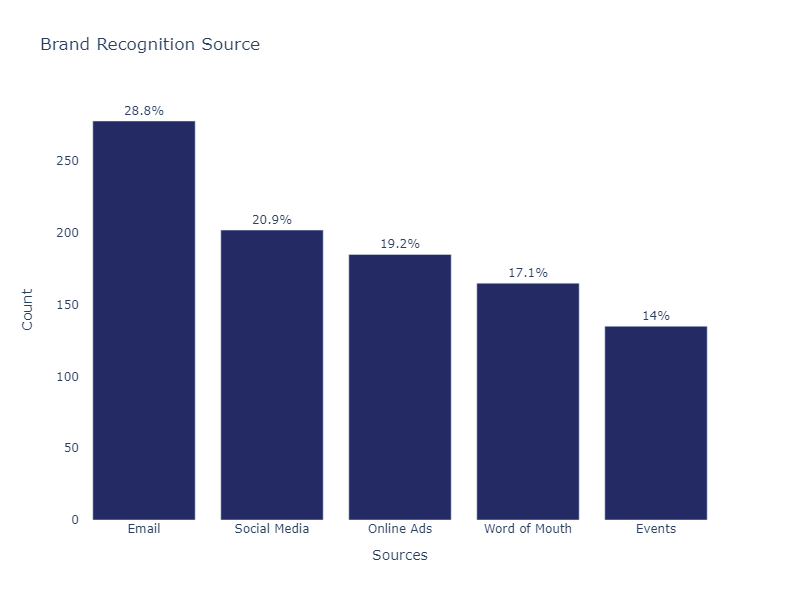

- Of the respondents, the most popular brand discovery sources are: (From 2560 responses.)
     - For ages 18-24: Preferred **Word of Mouth** **(100.0%)**.
     - For ages 25-34: Preferred **Social Media** **(57.1%)**, then **Word of Mouth** **(14.3%)**, followed by **Online Ads** **(14.3%)**.
     - For ages 35-44: Preferred **Email** **(45.5%)**, then **Social Media** **(27.3%)**, followed by **Word of Mouth** **(18.2%)**.
     - For ages 45-54: Preferred **Social Media** **(33.7%)**, then **Email** **(25.0%)**, followed by **Online Ads** **(19.6%)**.
     - For ages 55-64: Preferred **Social Media** **(25.3%)**, then **Email** **(23.2%)**, followed by **Events** **(19.2%)**.
     - For ages 65-74: Preferred **Email** **(30.8%)**, then **Online Ads** **(20.8%)**, followed by **Social Media** **(18.9%)**.
     - For ages 75 and older: Preferred **Email** **(29.6%)**, then **Online Ads** **(20.7%)**, followed by **Word of Mouth** **(20.7%)**.

In [125]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[26], all_responses.columns[75]]]], axis=1)

categories = [
    'Social Media (Instagram, Facebook, Pinterest, etc.)', 
    'Online Ads (Search engines, Sponsored content)', 
    'Word of Mouth (Friends/Family, Colleagues)', 
    'Events (In-store, Trade shows, Workshops)', 
    'Email (Promotional, Newsletter)'
]

column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].where(column_data[all_responses.columns[26]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 26].notnull().sum()

# Remove text within parentheses (including the parentheses themselves)
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\(.+?\)", "", regex=True)

# Optional: If you also want to clean up any extra spaces left after removal, you can chain another replace
column_data[all_responses.columns[26]] = column_data[all_responses.columns[26]].str.replace(r"\s{2,}", " ", regex=True).str.strip()


# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Brand Recognition Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/brand_recognition_source.png")
display(Image(filename="./IMG/brand_recognition_source.png"))


# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular brand discovery sources are: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

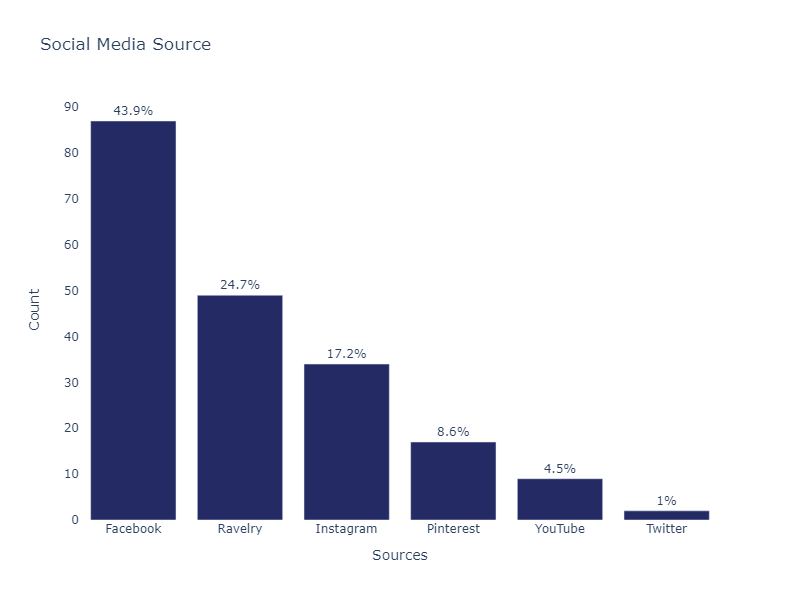

- Of the respondents that discovered a brand through social media, the most popular is: (From 198 responses.)
     - For ages 25-34: Discovered through **Instagram** **(66.7%)** and **Facebook** **(33.3%)**.
     - For ages 35-44: Discovered through **Facebook** **(50.0%)**, then **Instagram** **(33.3%)**, followed by **Pinterest** **(16.7%)**.
     - For ages 45-54: Discovered through **Ravelry** **(35.5%)**, then **Facebook** **(29.0%)**, followed by **Instagram** **(22.6%)**.
     - For ages 55-64: Discovered through **Facebook** **(34.7%)**, then **Ravelry** **(28.6%)**, followed by **Instagram** **(20.4%)**.
     - For ages 65-74: Discovered through **Facebook** **(56.7%)**, then **Ravelry** **(19.4%)**, followed by **Instagram** **(13.4%)**.
     - For ages 75 and older: Discovered through **Facebook** **(50.0%)**, then **Ravelry** **(27.3%)**, followed by **YouTube** **(9.1%)**.

In [126]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[27], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[all_responses.columns[27]] = column_data[all_responses.columns[27]].where(column_data[all_responses.columns[27]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Source',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media.png")
display(Image(filename="./IMG/social_media.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents that discovered a brand through social media, the most popular is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Discovered through **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Discovered through **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Discovered through **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

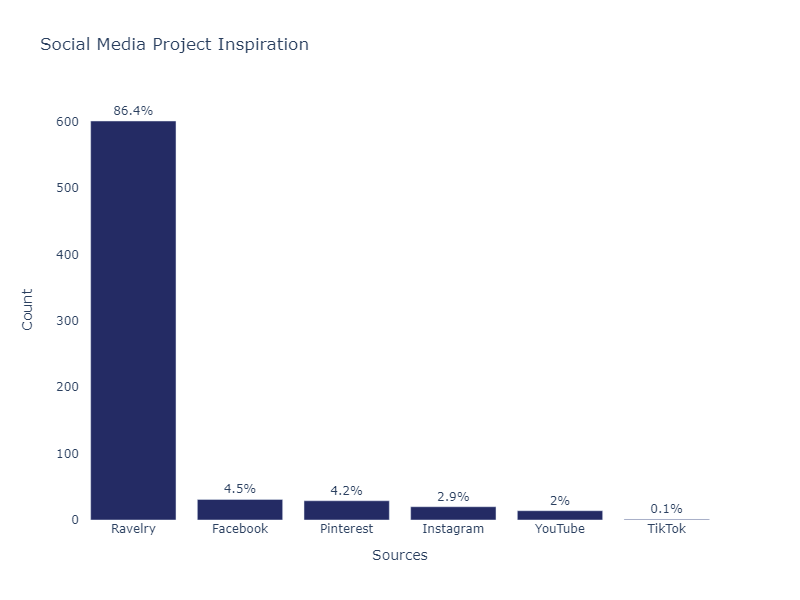

- Of the respondents, the most popular social media platform for inspiration is: (From 696 responses.)
     - For ages 25-34: Preferred **Ravelry** **(50.0%)**, then **Pinterest** **(33.3%)**, followed by **Instagram** **(16.7%)**.
     - For ages 35-44: Preferred **Ravelry** **(68.4%)**, then **Pinterest** **(15.8%)**, followed by **Facebook** **(5.3%)**.
     - For ages 45-54: Preferred **Ravelry** **(78.0%)**, then **Instagram** **(9.8%)**, followed by **YouTube** **(7.3%)**.
     - For ages 55-64: Preferred **Ravelry** **(84.2%)**, then **Instagram** **(5.0%)**, followed by **Pinterest** **(4.3%)**.
     - For ages 65-74: Preferred **Ravelry** **(90.7%)**, then **Facebook** **(5.0%)**, followed by **Pinterest** **(2.5%)**.
     - For ages 75 and older: Preferred **Ravelry** **(84.1%)**, then **Pinterest** **(6.8%)**, followed by **Facebook** **(4.5%)**.

In [127]:
# Combining all the columns into one dataframe
column_data = pd.concat([all_responses[[all_responses.columns[44], all_responses.columns[75]]]], axis=1)

categories = [
    'Facebook', 
    'Instagram',
    'Twitter',
    'Pinterest',
    'Ravelry',
    'YouTube',
    'TikTok'
]

column_data[column_data.columns[0]] = column_data[column_data.columns[0]].where(column_data[column_data.columns[0]].isin(categories))

# Calculate the total number of rows before exploding.
sample_size =column_data.iloc[:, 0].notnull().sum()

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Social Media Project Inspiration',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Sources',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800
)

# Show the figure
fig.write_image("./IMG/social_media_inspiration.png")
display(Image(filename="./IMG/social_media_inspiration.png"))

# Age order for print out.
ages = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 and older']
# Create a new dataframe excluding age where 'Prefer not to answer'
column_data = column_data[column_data.iloc[:, 1] != "Prefer not to answer"].dropna().copy()
# Convert the age group column to a categorical type with the specified order
column_data[column_data.columns[1]] = pd.Categorical(column_data[column_data.columns[1]], categories=ages, ordered=True)

# Initialize the markdown string
markdown_summary = f"- Of the respondents, the most popular social media platform for inspiration is: (From {sample_size} responses.)"

# Loop through each age group to calculate and append the relevant metrics
for age in ages:
    # Filter the dataframe for the current age group
    age_group_df = column_data[column_data.iloc[:, 1] == age]
    if not age_group_df.empty:  # Only proceed if the age group has data
        # Calculate the value counts and percentages for the current age group
        percentages = age_group_df.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
        percentages.columns = ['Platform', 'Percentage']
        if len(percentages) >= 3:
            # Append the calculated metrics to the markdown string for the three most popular project types
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**, then **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**, followed by **{percentages.iloc[2, 0]}** **({percentages.iloc[2, 1]:.1f}%)**."
        elif len(percentages) == 2:
            # If there are exactly two answers, mention both
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)** and **{percentages.iloc[1, 0]}** **({percentages.iloc[1, 1]:.1f}%)**."
        elif len(percentages) == 1:
            # If there's only one answer, mention only the most popular one
            markdown_summary += f"\n     - For ages {age}: Preferred **{percentages.iloc[0, 0]}** **({percentages.iloc[0, 1]:.1f}%)**."
        else:
            # If there are no answers, include a placeholder or a different message
            markdown_summary += f"\n     - For ages {age}: there were no preferred social media platforms with significant data."


# Display the markdown text
display(Markdown(markdown_summary))

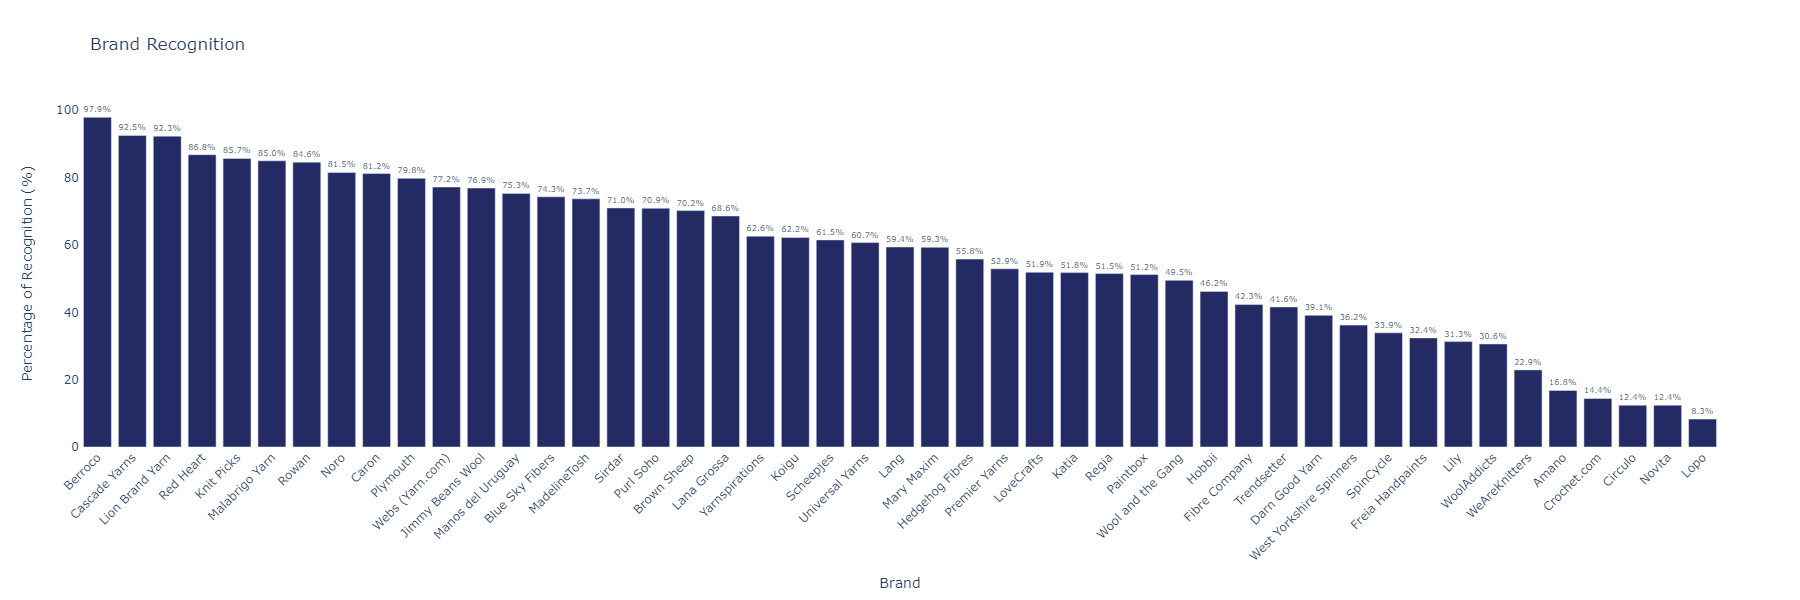

In [128]:
# Print statement question.
question = all_responses.columns[28]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 28].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 28].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Recognition',
             labels={'Percentage': 'Percentage of Recognition (%)', 'Brand': 'Brand'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_recognition.png")
display(Image(filename="./IMG/brand_recognition.png"))

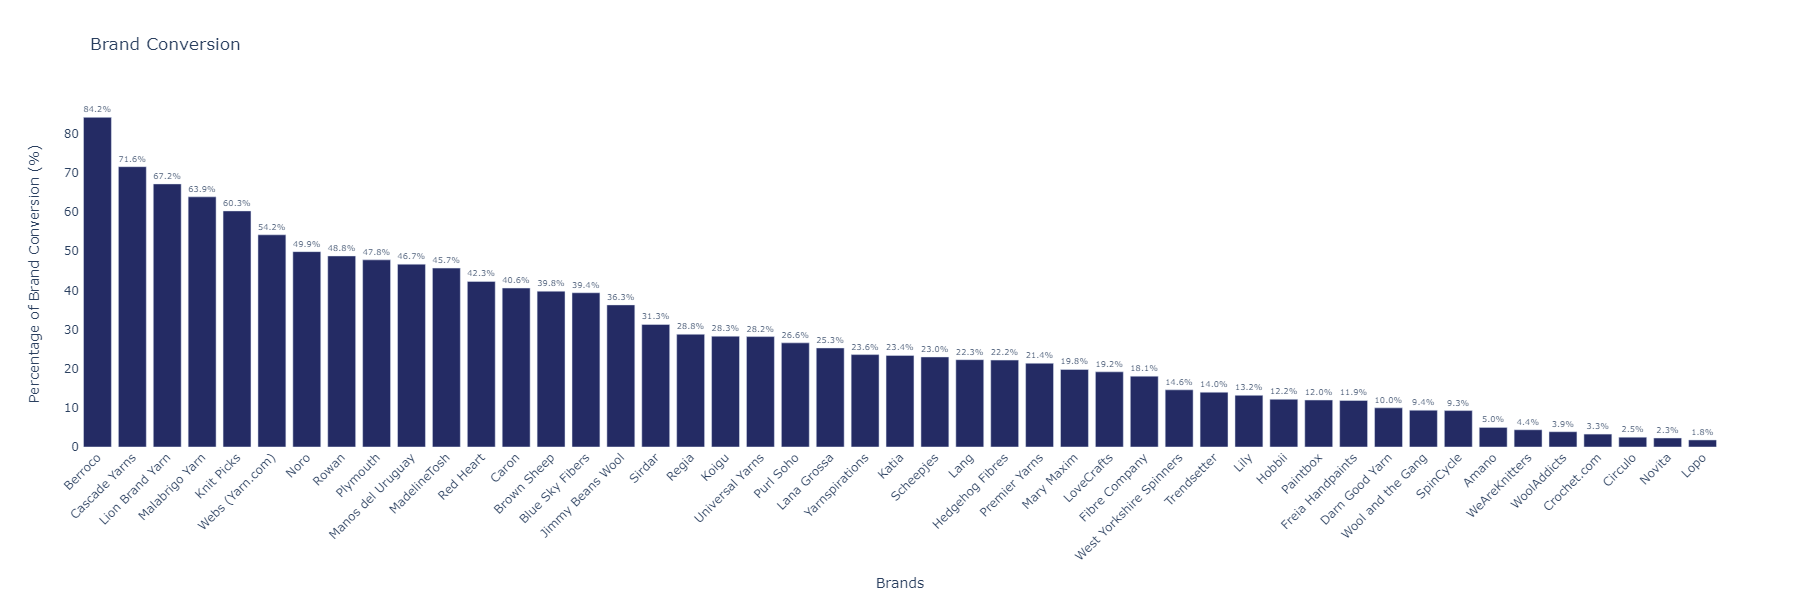

In [129]:
# Print statement question.
question = all_responses.columns[29]

# Split previous concatenation.
split_brands = all_responses.iloc[:, 29].str.split(', ')

# Calculate the total number of rows before exploding.
sample_size = all_responses.iloc[:, 29].notnull().sum()

# Create a temporary DataFrame for exploding, to avoid modifying the original
temp_df = pd.DataFrame({'SplitBrands': split_brands})
temp_df = temp_df.explode('SplitBrands')

# Filter out rows where 'SplitBrands' is empty or contains only whitespace
temp_df = temp_df[temp_df['SplitBrands'].str.strip().astype(bool)]

# Step 3: Count occurrences of each brand
brand_counts = temp_df['SplitBrands'].value_counts().reset_index()
brand_counts.columns = ['Brand', 'Count']

# Step 4: Calculate the percentage of each brand's occurrence based on the original number of responses
brand_counts['Percentage'] = ((brand_counts['Count'] / sample_size) * 100).round(1)

# Plot using 'Percentage' as the y-axis to show the distribution of responses per brand
fig = px.bar(brand_counts, x='Brand', y='Percentage',
             title='Brand Conversion',
             labels={'Percentage': 'Percentage of Brand Conversion (%)', 'Brand': 'Brands'},
             text='Percentage', color_discrete_sequence=['#242B64'])

# Round the values and update traces to display them above bars
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')

fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=1800,
    xaxis_tickangle=-45
)

# Show the figure
fig.write_image("./IMG/brand_conversion.png")
display(Image(filename="./IMG/brand_conversion.png"))

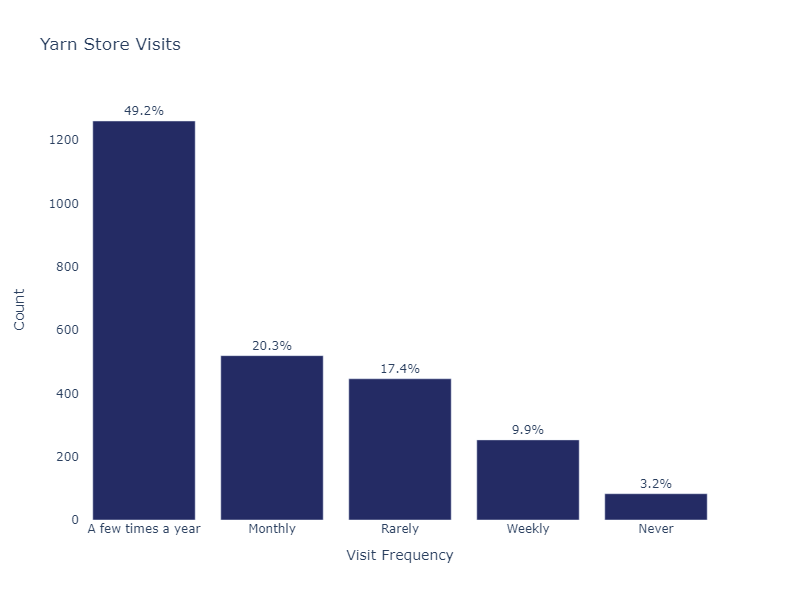

- Of the respondents, their yarn store visits are as follows: (From 2676 responses.)
    - A few times a year: **49.2%**.
    - Monthly: **20.3%**.
    - Rarely: **17.4%**.
    - Weekly: **9.9%**.
    - Never: **3.2%**.


In [130]:
column_data =all_responses[[all_responses.columns[34]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Yarn Store Visits',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Visit Frequency',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_store_visits.png")
display(Image(filename="./IMG/yarn_store_visits.png"))

# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents, their yarn store visits are as follows: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.1f}%**.\n"
    
display(Markdown(markdown_summary))

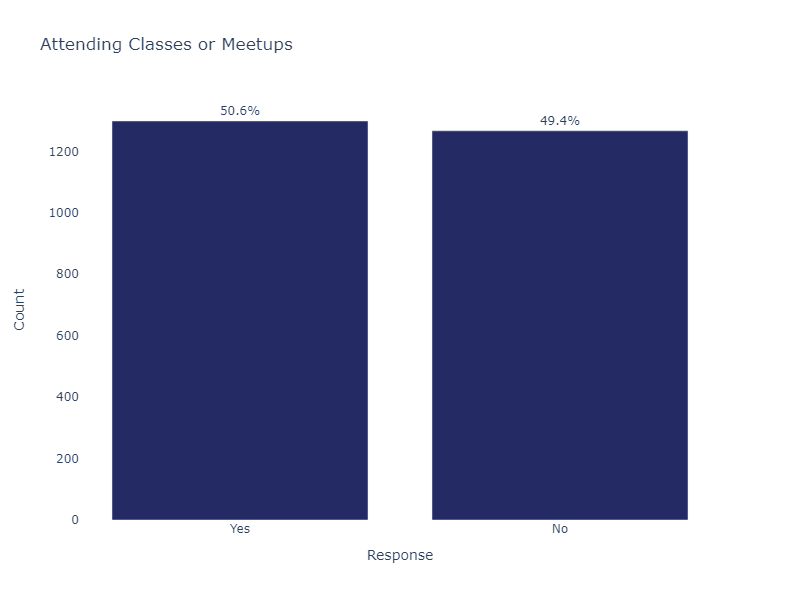

- Of the respondents, the following participate in knitting/corchet classes or meetups: (From 2676 responses.)
    - Yes: **50.6%**.
    - No: **49.4%**.


In [131]:
column_data =all_responses[[all_responses.columns[35]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Attending Classes or Meetups',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_store_visits.png")
display(Image(filename="./IMG/yarn_store_visits.png"))

# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents, the following participate in knitting/corchet classes or meetups: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.1f}%**.\n"
    
display(Markdown(markdown_summary))

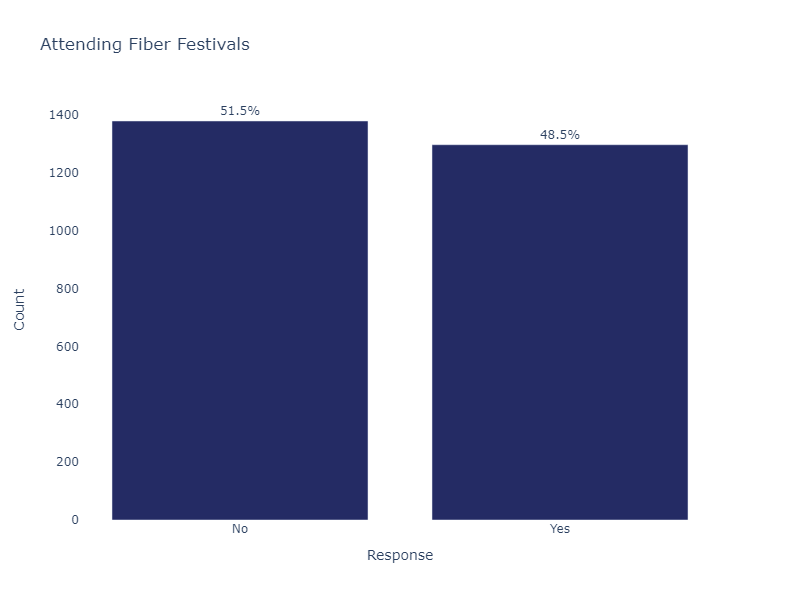

- Of the respondents, the following have attended fiber festivals or shows for makers: (From 2676 responses.)
    - No: **51.5%**.
    - Yes: **48.5%**.


In [132]:
column_data =all_responses[[all_responses.columns[36]]]

# Now apply value_counts() on the series, not the DataFrame
value_counts = column_data.iloc[:, 0].value_counts().reset_index()
value_counts.columns = ['Category', 'Count']

# Apply value_counts(normalize=True) for percentages
percentages = column_data.iloc[:, 0].value_counts(normalize=True).mul(100).round(1).reset_index()
percentages.columns = ['Category', 'Percentage']

# Ensure merging operates on Series results with matching dimensions
summary_df = pd.merge(value_counts, percentages, on='Category')

# Create a bar graph with percentages above bars
fig = px.bar(summary_df, x='Category', y='Count', title='Attending Fiber Festivals',
             text='Percentage', color_discrete_sequence=['#242B64'])

# Customization for displaying percentages
fig.update_traces(texttemplate='%{text}%', textposition='outside')

# Customization for layout
fig.update_layout(
    xaxis_title='Response',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    uniformtext_minsize=8,  # Adjust text size if needed
    uniformtext_mode='hide',
    height=600,  # Increase height to provide more space
    width=800,
    margin=dict(t=100)  # Add more top margin for padding
)

# Show the figure
fig.write_image("./IMG/yarn_store_visits.png")
display(Image(filename="./IMG/yarn_store_visits.png"))

# What is your current skill level in crocheting?
sample_size = column_data.shape[0]
percentages = column_data[column_data.columns[0]].value_counts(normalize=True) * 100

markdown_summary = f"- Of the respondents, the following have attended fiber festivals or shows for makers: (From {sample_size} responses.)\n"

for answer, percentage in percentages.items():
    markdown_summary += f"    - {answer}: **{percentage:.1f}%**.\n"
    
display(Markdown(markdown_summary))

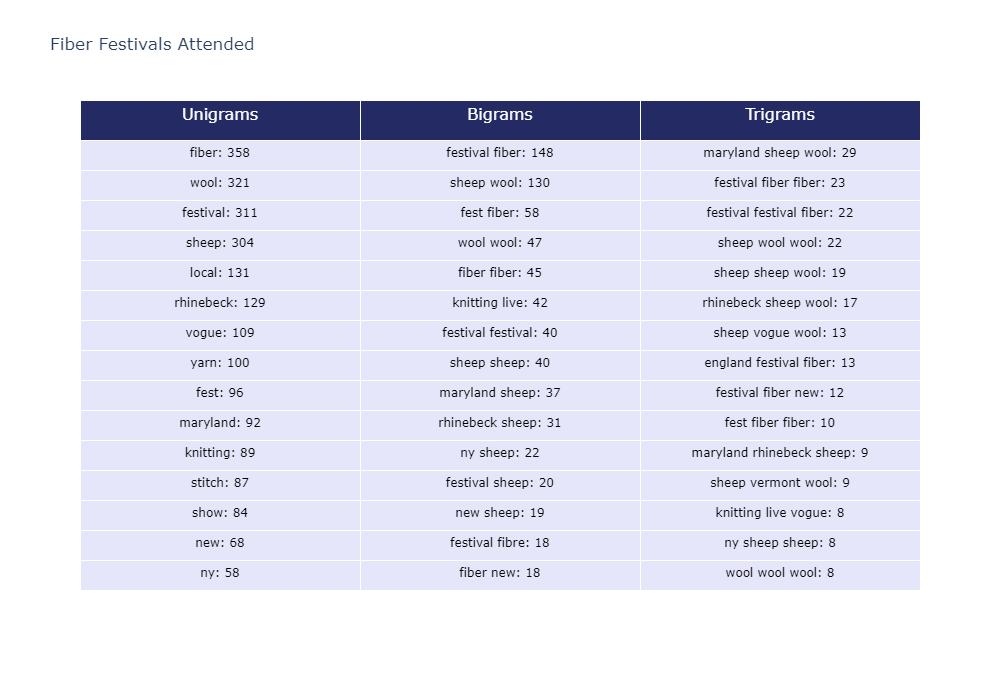

In [133]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[37]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {

}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(15)

# Combine uni, bi, and tri grams
uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Unigrams', 'Bigrams', 'Trigrams']
ngram_data = [uni_grams, bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)


# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='Fiber Festivals Attended',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700
)

fig.update_traces(columnwidth=[15, 15, 15])

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

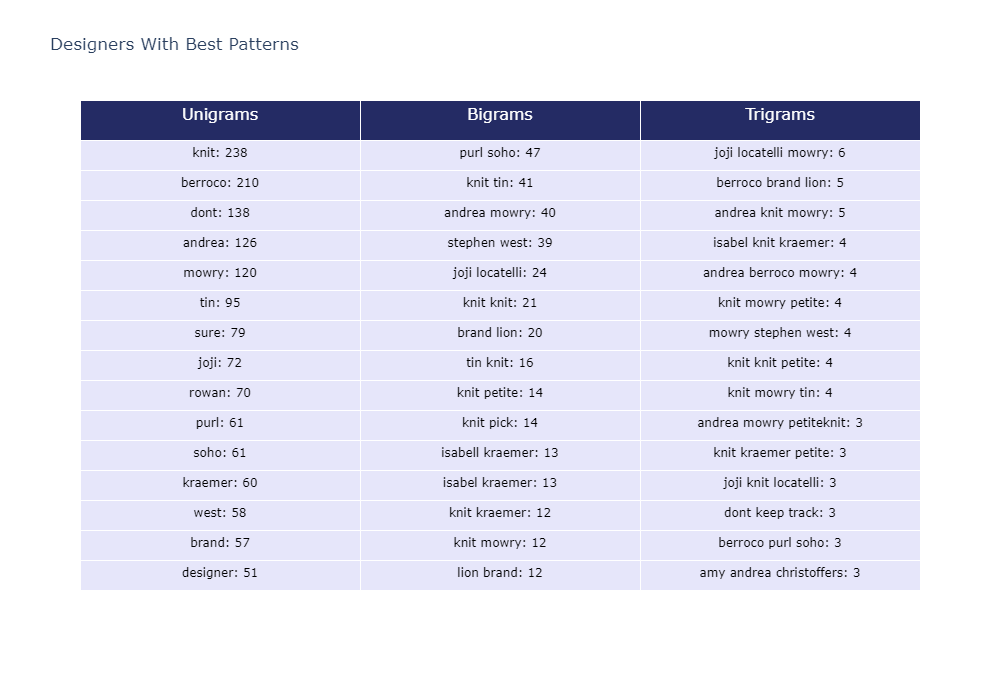

In [134]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[70]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'don\'t',
    'know',
    'pattern',
    'designer',
    'follow',
    'many'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all punctuation
    all_punct = string.punctuation + "’"  # Adding curly apostrophe
    text = text.translate(str.maketrans('', '', all_punct))
    # Tokenize
    tokens = word_tokenize(text)
    # Filter out stop words and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(15)

# Combine uni, bi, and tri grams
uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Unigrams', 'Bigrams', 'Trigrams']
ngram_data = [uni_grams, bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)

# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='Designers With Best Patterns',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700
)

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

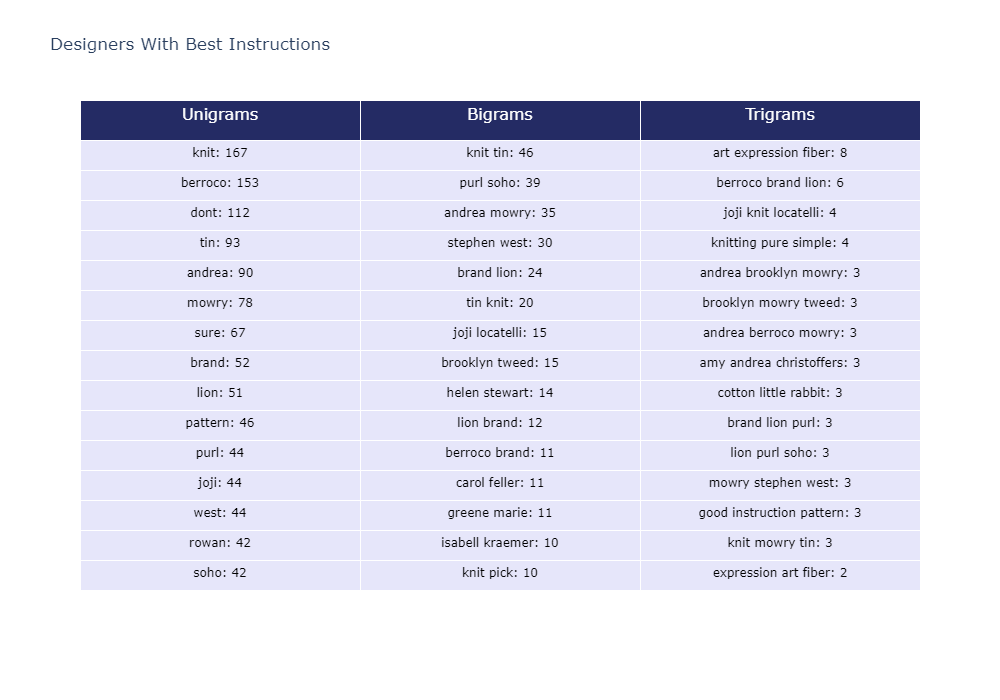

In [135]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[71]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'don\'t',
    'know',
    'pattern',
    'designer',
    'follow',
    'many'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all punctuation
    all_punct = string.punctuation + "’"  # Adding curly apostrophe
    text = text.translate(str.maketrans('', '', all_punct))
    # Tokenize
    tokens = word_tokenize(text)
    # Filter out stop words and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(15)

# Combine uni, bi, and tri grams
uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Unigrams', 'Bigrams', 'Trigrams']
ngram_data = [uni_grams, bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)

# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='Designers With Best Instructions',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700
)

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

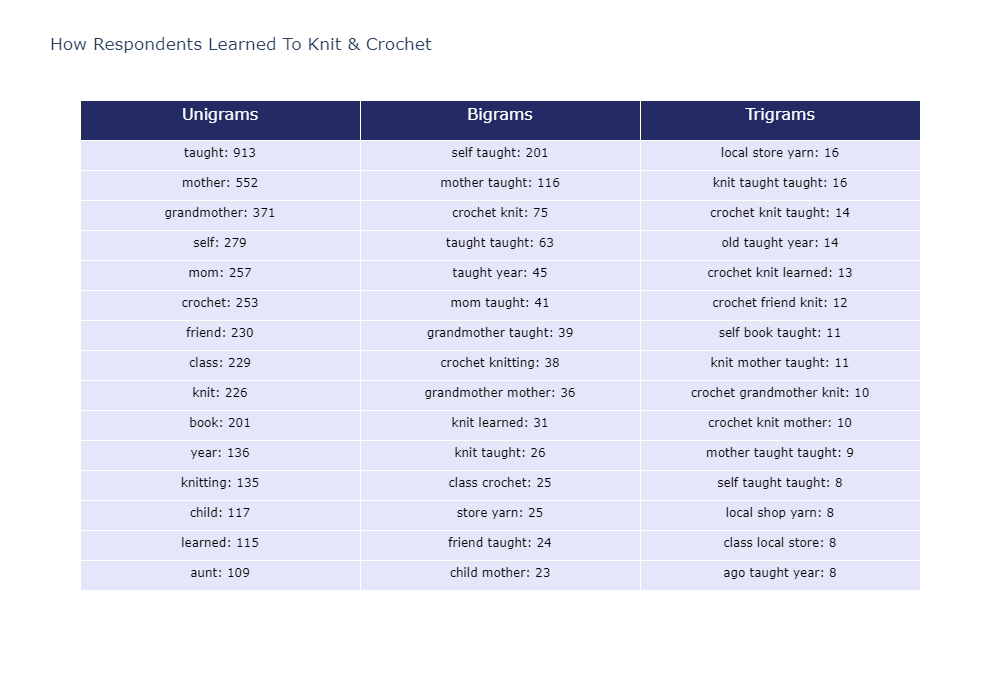

In [136]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[72]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'don\'t',
    'know',
    'pattern',
    'designer',
    'follow',
    'many'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all punctuation
    all_punct = string.punctuation + "’"  # Adding curly apostrophe
    text = text.translate(str.maketrans('', '', all_punct))
    # Tokenize
    tokens = word_tokenize(text)
    # Filter out stop words and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(15)

# Combine uni, bi, and tri grams
uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Unigrams', 'Bigrams', 'Trigrams']
ngram_data = [uni_grams, bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)

# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='How Respondents Learned To Knit & Crochet',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700
)

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

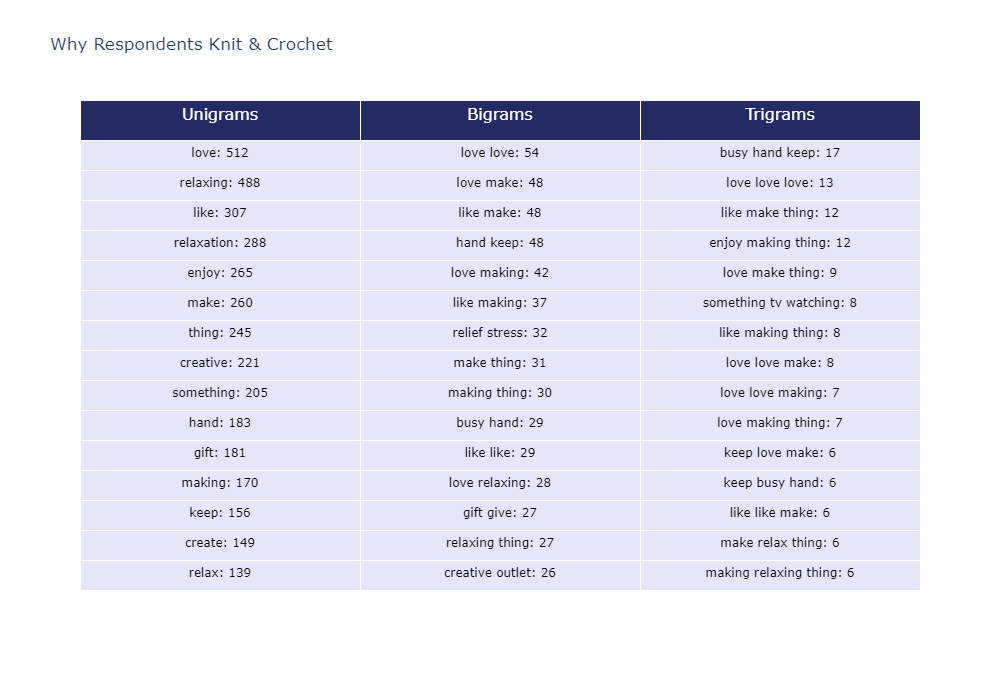

In [137]:
# Combining all the columns into one dataframe
column_data = all_responses[[all_responses.columns[73]]]

# Rename to be less annoything to type.
column_data.rename(columns={column_data.columns[0]: 'responses'}, inplace=True)

# Remove nulls.
column_data.dropna(subset=[column_data.columns[0]], inplace=True)

# Manually remove words.
custom_stop_words = {
    'don\'t',
    'know',
    'pattern',
    'designer',
    'follow',
    'many'
}

# Combine NLTK's standard stop words with custom stop words
stop_words = set(stopwords.words('english')).union(custom_stop_words)

# Using lemmatizer, stemming is too aggressive and re-mapping this would be dumb.
lemmatizer = WordNetLemmatizer()

# Preprocess and tokenize function
def preprocess_and_tokenize(text):
    # Convert to lowercase
    text = text.lower()
    # Remove all punctuation
    all_punct = string.punctuation + "’"  # Adding curly apostrophe
    text = text.translate(str.maketrans('', '', all_punct))
    # Tokenize
    tokens = word_tokenize(text)
    # Filter out stop words and lemmatize
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

def normalize_phrase(phrase):
    return ' '.join(sorted(phrase.split()))

# Finding most common uni/bi/tri grams
def find_common_ngrams(data, n=1):
    all_ngrams = []
    for response in data['responses']:
        # Normalize the response before tokenization
        normalized_response = normalize_phrase(response)
        tokens = preprocess_and_tokenize(normalized_response)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return Counter(all_ngrams).most_common(15)

# Combine uni, bi, and tri grams
uni_grams = find_common_ngrams(column_data, 1)
bi_grams = find_common_ngrams(column_data, 2)
tri_grams = find_common_ngrams(column_data, 3)

# Preparing data for the table
ngram_columns = ['Unigrams', 'Bigrams', 'Trigrams']
ngram_data = [uni_grams, bi_grams, tri_grams]
table_data = list(zip(*ngram_data))  # Transpose to match Plotly's format

# Convert ngram tuples to readable strings
formatted_table_data = []
for row in table_data:
    formatted_row = []
    for cell in row:
        if isinstance(cell, tuple):  # Checking if the cell is a tuple
            ngram, count = cell
            ngram_string = ' '.join(ngram)
            formatted_row.append(f"{ngram_string}: {count}")
        else:
            # Handle the case where cell is not a tuple as per your data structure
            formatted_row.append("")
    formatted_table_data.append(formatted_row)

# Creating the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(values=ngram_columns, height=40, fill_color='#242B64', font=dict(color='white', size=16), align='center'),
    cells=dict(values=list(zip(*formatted_table_data)), height=30, fill_color='lavender', align='center', font=dict(color='black', size=12))
)])

# Apply layout customizations
fig.update_layout(
    title_text='Why Respondents Knit & Crochet',
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=1000,
    height=700
)

# Assuming the environment supports file writing and display
fig.write_image("./IMG/brand_associated_words.png")
display(Image(filename="./IMG/brand_associated_words.png"))

In [138]:
%%capture
!jupyter nbconvert --to webpdf Yarn_survey.ipynb --output All_PDF_Export --output-dir ./PDF --no-input